In [4]:
import pandas as pd
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, precision_score
from itertools import combinations
from xgboost import XGBClassifier
import datetime
import pickle
import base64

In [96]:
def get_historical_data(symbol, interval, days):
    # Calculate the start time (40 days ago from now)
    start_time = datetime.datetime.now() - datetime.timedelta(days=days)
    start_time_str = start_time.strftime('%Y-%m-%d %H:%M:%S')

    # Fetch historical klines data
    client = Client()
    klines = client.get_historical_klines(symbol, interval, start_time_str)
    
    # Convert to DataFrame
    klines_df = pd.DataFrame(klines)
    
    # Assign column names
    klines_df.columns = [
        'Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 
        'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 
        'Taker buy quote asset volume', 'Ignore'
    ]
    
    # Data is supplied in UTC+0
    klines_df['Open time'] = pd.to_datetime(klines_df['Open time']/1000, unit = 's', utc=True).dt.tz_convert(tz='Europe/Berlin')
    klines_df['Close time'] = pd.to_datetime(klines_df['Close time']/1000, unit = 's', utc=True).dt.tz_convert(tz='Europe/Berlin')
    
    numeric_columns = [
        'Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
        'Taker buy base asset volume', 'Taker buy quote asset volume'
    ]
    klines_df[numeric_columns] = klines_df[numeric_columns].apply(pd.to_numeric, axis=1)
    return klines_df

def make_signals(pred: pd.Series, holding_period: int):
    np_pred = pred
    for i in reversed(range(len(np_pred))):
        if np_pred[i] == 1:
            np_pred[i:i+holding_period] = 1
    np_pred = np_pred
    return np_pred 

# De-serialize an object from a plain text
def txt_to_obj(txt):
    base64_bytes = txt.encode('ascii')
    message_bytes = base64.b64decode(base64_bytes)
    obj = pickle.loads(message_bytes)
    return obj

def bot(data: pd.DataFrame):
    symbol = 'BTCEUR'
    days = 1000
    SIGNAL_TH = 0.55
    HOLDING_PERIOD = 24
    FEATURES = ['OBV', 'EMA_24_Sig', 'SMA_168_Sig']
    MODEL = 'gASVLAMAAAAAAACMD3hnYm9vc3Quc2tsZWFybpSMDVhHQkNsYXNzaWZpZXKUk5QpgZR9lCiMDG5fZXN0aW1hdG9yc5ROjAlvYmplY3RpdmWUjA9iaW5hcnk6bG9naXN0aWOUjAltYXhfZGVwdGiUTowKbWF4X2xlYXZlc5ROjAdtYXhfYmlulE6MC2dyb3dfcG9saWN5lE6MDWxlYXJuaW5nX3JhdGWUTowJdmVyYm9zaXR5lE6MB2Jvb3N0ZXKUTowLdHJlZV9tZXRob2SUTowFZ2FtbWGUTowQbWluX2NoaWxkX3dlaWdodJROjA5tYXhfZGVsdGFfc3RlcJROjAlzdWJzYW1wbGWUTowPc2FtcGxpbmdfbWV0aG9klE6MEGNvbHNhbXBsZV9ieXRyZWWUTowRY29sc2FtcGxlX2J5bGV2ZWyUTowQY29sc2FtcGxlX2J5bm9kZZROjAlyZWdfYWxwaGGUTowKcmVnX2xhbWJkYZROjBBzY2FsZV9wb3Nfd2VpZ2h0lE6MCmJhc2Vfc2NvcmWUTowHbWlzc2luZ5RHf/gAAAAAAACMEW51bV9wYXJhbGxlbF90cmVllE6MDHJhbmRvbV9zdGF0ZZRLKowGbl9qb2JzlE6MFG1vbm90b25lX2NvbnN0cmFpbnRzlE6MF2ludGVyYWN0aW9uX2NvbnN0cmFpbnRzlE6MD2ltcG9ydGFuY2VfdHlwZZROjAZkZXZpY2WUTowTdmFsaWRhdGVfcGFyYW1ldGVyc5ROjBJlbmFibGVfY2F0ZWdvcmljYWyUiYwNZmVhdHVyZV90eXBlc5ROjBFtYXhfY2F0X3RvX29uZWhvdJROjBFtYXhfY2F0X3RocmVzaG9sZJROjA5tdWx0aV9zdHJhdGVneZROjAtldmFsX21ldHJpY5ROjBVlYXJseV9zdG9wcGluZ19yb3VuZHOUTowJY2FsbGJhY2tzlE6MCm5fY2xhc3Nlc1+USwKMCF9Cb29zdGVylIwMeGdib29zdC5jb3JllIwHQm9vc3RlcpSTlCmBlH2UjAZoYW5kbGWUjAhidWlsdGluc5SMCWJ5dGVhcnJheZSTlELKJwUAe0wAAAAAAAAABkNvbmZpZ3tMAAAAAAAAAAdsZWFybmVye0wAAAAAAAAADWdlbmVyaWNfcGFyYW17TAAAAAAAAAAGZGV2aWNlU0wAAAAAAAAAA2NwdUwAAAAAAAAAFmZhaWxfb25faW52YWxpZF9ncHVfaWRTTAAAAAAAAAABMEwAAAAAAAAABm5fam9ic1NMAAAAAAAAAAEwTAAAAAAAAAAHbnRocmVhZFNMAAAAAAAAAAEwTAAAAAAAAAAMcmFuZG9tX3N0YXRlU0wAAAAAAAAAAjQyTAAAAAAAAAAEc2VlZFNMAAAAAAAAAAI0MkwAAAAAAAAAEnNlZWRfcGVyX2l0ZXJhdGlvblNMAAAAAAAAAAEwTAAAAAAAAAATdmFsaWRhdGVfcGFyYW1ldGVyc1NMAAAAAAAAAAExfUwAAAAAAAAAEGdyYWRpZW50X2Jvb3N0ZXJ7TAAAAAAAAAASZ2J0cmVlX21vZGVsX3BhcmFte0wAAAAAAAAAEW51bV9wYXJhbGxlbF90cmVlU0wAAAAAAAAAATFMAAAAAAAAAAludW1fdHJlZXNTTAAAAAAAAAADMTAwfUwAAAAAAAAAEmdidHJlZV90cmFpbl9wYXJhbXtMAAAAAAAAAAxwcm9jZXNzX3R5cGVTTAAAAAAAAAAHZGVmYXVsdEwAAAAAAAAAC3RyZWVfbWV0aG9kU0wAAAAAAAAABGF1dG9MAAAAAAAAAAd1cGRhdGVyU0wAAAAAAAAAF2dyb3dfcXVhbnRpbGVfaGlzdG1ha2VyTAAAAAAAAAALdXBkYXRlcl9zZXFTTAAAAAAAAAAXZ3Jvd19xdWFudGlsZV9oaXN0bWFrZXJ9TAAAAAAAAAAEbmFtZVNMAAAAAAAAAAZnYnRyZWVMAAAAAAAAABFzcGVjaWZpZWRfdXBkYXRlckZMAAAAAAAAABB0cmVlX3RyYWluX3BhcmFte0wAAAAAAAAABWFscGhhU0wAAAAAAAAAATBMAAAAAAAAAAljYWNoZV9vcHRTTAAAAAAAAAABMUwAAAAAAAAAEWNvbHNhbXBsZV9ieWxldmVsU0wAAAAAAAAAATFMAAAAAAAAABBjb2xzYW1wbGVfYnlub2RlU0wAAAAAAAAAATFMAAAAAAAAABBjb2xzYW1wbGVfYnl0cmVlU0wAAAAAAAAAATFMAAAAAAAAAANldGFTTAAAAAAAAAALMC4zMDAwMDAwMTJMAAAAAAAAAAVnYW1tYVNMAAAAAAAAAAEwTAAAAAAAAAALZ3Jvd19wb2xpY3lTTAAAAAAAAAAJZGVwdGh3aXNlTAAAAAAAAAAXaW50ZXJhY3Rpb25fY29uc3RyYWludHNTTAAAAAAAAAAATAAAAAAAAAAGbGFtYmRhU0wAAAAAAAAAATFMAAAAAAAAAA1sZWFybmluZ19yYXRlU0wAAAAAAAAACzAuMzAwMDAwMDEyTAAAAAAAAAAHbWF4X2JpblNMAAAAAAAAAAMyNTZMAAAAAAAAABFtYXhfY2F0X3RocmVzaG9sZFNMAAAAAAAAAAI2NEwAAAAAAAAAEW1heF9jYXRfdG9fb25laG90U0wAAAAAAAAAATRMAAAAAAAAAA5tYXhfZGVsdGFfc3RlcFNMAAAAAAAAAAEwTAAAAAAAAAAJbWF4X2RlcHRoU0wAAAAAAAAAATZMAAAAAAAAAAptYXhfbGVhdmVzU0wAAAAAAAAAATBMAAAAAAAAABBtaW5fY2hpbGRfd2VpZ2h0U0wAAAAAAAAAATFMAAAAAAAAAA5taW5fc3BsaXRfbG9zc1NMAAAAAAAAAAEwTAAAAAAAAAAUbW9ub3RvbmVfY29uc3RyYWludHNTTAAAAAAAAAACKClMAAAAAAAAAAxyZWZyZXNoX2xlYWZTTAAAAAAAAAABMUwAAAAAAAAACXJlZ19hbHBoYVNMAAAAAAAAAAEwTAAAAAAAAAAKcmVnX2xhbWJkYVNMAAAAAAAAAAExTAAAAAAAAAAPc2FtcGxpbmdfbWV0aG9kU0wAAAAAAAAAB3VuaWZvcm1MAAAAAAAAAAxza2V0Y2hfcmF0aW9TTAAAAAAAAAABMkwAAAAAAAAAEHNwYXJzZV90aHJlc2hvbGRTTAAAAAAAAAATMC4yMDAwMDAwMDAwMDAwMDAwMUwAAAAAAAAACXN1YnNhbXBsZVNMAAAAAAAAAAExfUwAAAAAAAAAB3VwZGF0ZXJbI0wAAAAAAAAAAXtMAAAAAAAAABBoaXN0X3RyYWluX3BhcmFte0wAAAAAAAAAEWRlYnVnX3N5bmNocm9uaXplU0wAAAAAAAAAATBMAAAAAAAAABRtYXhfY2FjaGVkX2hpc3Rfbm9kZVNMAAAAAAAAAAU2NTUzNn1MAAAAAAAAAARuYW1lU0wAAAAAAAAAF2dyb3dfcXVhbnRpbGVfaGlzdG1ha2VyfX1MAAAAAAAAABNsZWFybmVyX21vZGVsX3BhcmFte0wAAAAAAAAACmJhc2Vfc2NvcmVTTAAAAAAAAAAMNS4yMTc4NjYzRS0xTAAAAAAAAAASYm9vc3RfZnJvbV9hdmVyYWdlU0wAAAAAAAAAATFMAAAAAAAAAAludW1fY2xhc3NTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAApudW1fdGFyZ2V0U0wAAAAAAAAAATF9TAAAAAAAAAATbGVhcm5lcl90cmFpbl9wYXJhbXtMAAAAAAAAAAdib29zdGVyU0wAAAAAAAAABmdidHJlZUwAAAAAAAAAG2Rpc2FibGVfZGVmYXVsdF9ldmFsX21ldHJpY1NMAAAAAAAAAAEwTAAAAAAAAAAObXVsdGlfc3RyYXRlZ3lTTAAAAAAAAAATb25lX291dHB1dF9wZXJfdHJlZUwAAAAAAAAACW9iamVjdGl2ZVNMAAAAAAAAAA9iaW5hcnk6bG9naXN0aWN9TAAAAAAAAAAHbWV0cmljc1sjTAAAAAAAAAABe0wAAAAAAAAABG5hbWVTTAAAAAAAAAAHbG9nbG9zc31MAAAAAAAAAAlvYmplY3RpdmV7TAAAAAAAAAAEbmFtZVNMAAAAAAAAAA9iaW5hcnk6bG9naXN0aWNMAAAAAAAAAA5yZWdfbG9zc19wYXJhbXtMAAAAAAAAABBzY2FsZV9wb3Nfd2VpZ2h0U0wAAAAAAAAAATF9fX1MAAAAAAAAAAd2ZXJzaW9uWyNMAAAAAAAAAANpAmkBaQF9TAAAAAAAAAAFTW9kZWx7TAAAAAAAAAAHbGVhcm5lcntMAAAAAAAAAAphdHRyaWJ1dGVze31MAAAAAAAAAA1mZWF0dXJlX25hbWVzWyNMAAAAAAAAAANTTAAAAAAAAAADT0JWU0wAAAAAAAAACkVNQV8yNF9TaWdTTAAAAAAAAAALU01BXzE2OF9TaWdMAAAAAAAAAA1mZWF0dXJlX3R5cGVzWyNMAAAAAAAAAANTTAAAAAAAAAAFZmxvYXRTTAAAAAAAAAADaW50U0wAAAAAAAAAA2ludEwAAAAAAAAAEGdyYWRpZW50X2Jvb3N0ZXJ7TAAAAAAAAAAFbW9kZWx7TAAAAAAAAAASZ2J0cmVlX21vZGVsX3BhcmFte0wAAAAAAAAAEW51bV9wYXJhbGxlbF90cmVlU0wAAAAAAAAAATFMAAAAAAAAAAludW1fdHJlZXNTTAAAAAAAAAADMTAwfUwAAAAAAAAAEGl0ZXJhdGlvbl9pbmRwdHJbI0wAAAAAAAAAZWkAaQFpAmkDaQRpBWkGaQdpCGkJaQppC2kMaQ1pDmkPaRBpEWkSaRNpFGkVaRZpF2kYaRlpGmkbaRxpHWkeaR9pIGkhaSJpI2kkaSVpJmknaShpKWkqaStpLGktaS5pL2kwaTFpMmkzaTRpNWk2aTdpOGk5aTppO2k8aT1pPmk/aUBpQWlCaUNpRGlFaUZpR2lIaUlpSmlLaUxpTWlOaU9pUGlRaVJpU2lUaVVpVmlXaVhpWWlaaVtpXGldaV5pX2lgaWFpYmljaWRMAAAAAAAAAAl0cmVlX2luZm9bI0wAAAAAAAAAZGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkAaQBpAGkATAAAAAAAAAAFdHJlZXNbI0wAAAAAAAAAZHtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABlOGe0yL539co+f800PacFur9r/Vs/j4ccPfw33D/HXoq83VL3v1bAgb8Zt/U/t+qKP0RS8768510+kRvkP64Hjz/hB+C/kBFxPXXW578J8LS/fO9eP33nID/G53g/pH21PxNEvr5opoS/RaBvPq+B1b8jKwo+/5yhP28loz8NA40+wlDEPWtCK7+ujGA/YsNXvaO7Ir6yyfC/Wzp8v5a3t78O5cA/KVT6PvZ09T8JnmI/j+U4vsxcaD+/4OQ++q4+PqvXS77tma09gzOfv1yYy75a4/8+gELYP6NDET6LmFG/XysGPsUT57xBF5W+o4HiPoUS778KriO+o+IQvePOAT6bf3a+G8EsPb5/rr5Ct7S9nQkXvrJhYb47uBu+4fL+vpX0aL6AZpm9RPp9PriOZzzonb0+wt6pPlnFNT47MHi+g3kAPwttDT7HEA8+Yzc+PYJGJr0cEHq+ScCavSQfSz2Aptq+OS0mvtFG4b62XUA8hzb5PdHUub7BuYY+8n/OPqGclz6BGnC9nBagvlKHKb7VRtNMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAGUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaQBMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAZQAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEQAAABP/////AAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADUAAAA3/////wAAADn//////////wAAADsAAAA9AAAAPwAAAEEAAABDAAAARQAAAEcAAABJAAAAS///////////AAAATQAAAE8AAABRAAAAU/////8AAABVAAAAVwAAAFkAAABbAAAAXQAAAF8AAABhAAAAY///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAZUPro6dEWZJ8Q9Oe4kPWxapC4T6AQlVAIEOEKH5AnMGAQ27bHUJST2AAAAAAQT0CQEGx1jBCO3koQwpniEEv04A/h1oAQk74FEOF00tBvHxsQn8wYEEk2vRBlG5wQbZ5eEDsu4hCKJ3YQShtkENMHARCA9/PAAAAAEFormwAAAAAAAAAAEHtegtBkNWgQlb/oEOlAsVAz8h0QSUoeEH3qwBB1q9QQTkuEgAAAAAAAAAAQGQI4ECCv4o/llFAQSMvIAAAAABBrlpUQP1khkG4L+BBApbgQ5T9WEFM5YBBHXcvQS1BmAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAGV/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAeAAAAHgAAACEAAAAhAAAAIgAAACIAAAAjAAAAIwAAACQAAAAkAAAAJQAAACUAAAAmAAAAJgAAACcAAAAnAAAAKAAAACgAAAApAAAAKQAAACwAAAAsAAAALQAAAC0AAAAuAAAALgAAAC8AAAAvAAAAMQAAADEAAAAyAAAAMgAAADMAAAAzAAAANAAAADQAAAA1AAAANQAAADYAAAA2AAAANwAAADcAAAA4AAAAOEwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAZQAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEgAAABT/////AAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADYAAAA4/////wAAADr//////////wAAADwAAAA+AAAAQAAAAEIAAABEAAAARgAAAEgAAABKAAAATP//////////AAAATgAAAFAAAABSAAAAVP////8AAABWAAAAWAAAAFoAAABcAAAAXgAAAGAAAABiAAAAZP//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAGXFWmVoxdMWk8PE8mDG6k/wxYR7nj+AAADCGHfLP4AAAMbQ0PLFx4Zivxm39cQEhbvD+1JrwyT4hEaXY33G7h9Zxuvn98bovYvGh7qsP4AAAMWmZ9s/gAAAw+eV+sQdCrfDyI02w5R+P8KNPn9GgcKqP4AAAD7/nKE/gAAAPw0DjT7CUMQ/gAAAP4AAAMbHXaHGJnHRxdBb7MXPBpU/gAAAP4AAAMQdCrc+9nT1PwmeYsPMXIE/gAAAxBJ2iMPjmQ0+q9dLw6+ivT+AAADCvsAGP4AAAEZbGzw/gAAARp7zUUakHnU+xRPnvEEXlb6jgeI+hRLvvwquI76j4hC9484BPpt/dr4bwSw9vn+uvkK3tL2dCRe+smFhvju4G77h8v6+lfRovoBmmb1E+n0+uI5nPOidvT7C3qk+WcU1PjsweL6DeQA/C20NPscQDz5jNz49gkYmvRwQer5JwJq9JB9LPYCm2r45LSa+0UbhvrZdQDyHNvk90dS5vsG5hj7yf84+oZyXPoEacL2cFqC+UocpvtVG00wAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAQAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAIAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABlRfNneEV3I6ZFb6tJRSdydUSfYmJD8snERVFSEUM2pw1FHAgERJQ30kKyqP9Df0OxQ2ZP2ERNm99FHesZQr+irkKtq21DNmcsRRChkUPFn8NERZ/DQlyUlUNIHoxCconkQymtX0QYZclDVNhZRRRjvUMYdcFCWJaHQiau1EKROUdBY5EuQfWIbkMXth9Dp06GRPdvgUN4xtpDEnisRAjdWkNzCaVCFLeUQY+6AkL9hItCkriNQNeXA0JXlwNDFDfSQausZkOn7jlDiN1aQzbm7kHvi1lFBxo1Q1SYeEH5hn1C8onkQfOJZ0EzqINBS5zYQY+6AkJrjUtCuaWYQfOJZ0OYFfBEbCz9RIFZA0JwitxDPKQjQn6EDkKlr1FDXBTTQ6OwSkMOep5CyR4PQZO4EEGVtxhCU5j1QaOwSj//g5JAl7YfQY+6AkIPugJCmjToQo46vUL1iG5DVRg6QugO/kMdszRC9AkpQnOJZ0C3ppFBwaG1RP7z2EL0CSlCryqzQvoGPkFrjUtBg7/XQrWnikHziWdMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAzEwMUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAEU6qaMFP5nZ6bzUM70/hG0uP7AxD75vlyI+N/sdPsYXcz8xn8k+3gsaPpPxtL2Ahmu/RtRYP1cnwj2y5nM+lHVSvOkLb79QtcC8R8qDvzL+cr7nyAU/jH3kPxAU5L6FTTA+TnSyvUqzqTx7pzc9Jk86v30GCz9LYaq9uk9ov1JX576zfGc/d334P7CQmj9rwyc+xfx8vkB4Mb8tC54/IKH+PgtHeL5uvJE+RIKkvs/NxL5itl29oUUsPpIxlzztBlK93f+nvkUNTL6nTmC+HZU7vKx8rj4V1rE+qFw/Pt7xRT4PyPW9sqc/PqDB/j1+C2M+TaQdveGLmbyvlem+gUo2vUZJlz36XKM+mqF3PV2z574LHH5MAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAEUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGkBTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAEUAAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAAN/////wAAAA///////////wAAABEAAAATAAAAFQAAABf/////AAAAGQAAABsAAAAdAAAAH/////8AAAAhAAAAIwAAACUAAAAn//////////8AAAApAAAAKwAAAC0AAAAvAAAAMQAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD8AAABBAAAAQ/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABFQ3sBTkBjL8BDoMUPQOBIQD9mzgBDrYtqQ2aXjAAAAABBAfGmAAAAAAAAAABC2CvuQkcdAEIB3IBDA+qiAAAAAD4Q24dB1E0oQylNoUIJhRgAAAAAQO/uQEFdQOhBxK+QQotwFgAAAAAAAAAAQXtRdEFJUfBCHqmUQvYGcUHh8TBBGnpKQRzpAECE4CBBN7WAQPPI0EFppH5BI5xQQdsiEEJi7HkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAEV/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAIAAAACAAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACEAAAAhAAAAIgAAACIAAAAjAAAAIwAAACQAAAAkAAAAJQAAACUAAAAmAAAAJgAAACcAAAAnAAAAKAAAAChMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAEUAAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAO/////wAAABD//////////wAAABIAAAAUAAAAFgAAABj/////AAAAGgAAABwAAAAeAAAAIP////8AAAAiAAAAJAAAACYAAAAo//////////8AAAAqAAAALAAAAC4AAAAwAAAAMgAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAEAAAABCAAAARP////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAARcbqT/A/gAAAxVplaMbuH1nG6+f3xchiZsPE8mA+xhdzP4AAAD7eCxo+k/G0xtDQ8sWEe54/gAAAwhh3yz6UdVLG7VhJxui9i8aM9I3Fohi5vufIBT+AAADD90Xlwt6ir0SDVR69SrOpPHunNz+AAADG5ozdxsddoT+AAADFt+O9P4AAAMQEhbvDzFyBxB0Kt8PS7HzDnJqSwo0+f0OqXfZGl2N9vm68kT5EgqS+z83EvmK2Xb2hRSw+kjGXPO0GUr3d/6e+RQ1MvqdOYL4dlTu8rHyuPhXWsT6oXD8+3vFFPg/I9b2ypz8+oMH+PX4LYz5NpB294YuZvK+V6b6BSja9RkmXPfpcoz6aoXc9XbPnvgscfkwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABFAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAgAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAEUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAEVF8CPzQylCIkXq2eJCs99RQp6k80VpbZJFbEYyQkdctEIgYe5Cg6RIQVgFV0Uxf5REX7f4Q+c0cEVPX6RB5uSXQTO+ikMx2nlFJmHsRErBP0KntcpDbofDQ1/hHkRNFkRFHBoTQG+ouUDvqLlB8GLXQxPOHkNsCu5FF6E9RBXMfkNT0wZDJe6oQpEyNUKQ0tpDF3exRC74lULw7X1DpiBqRQdWBkFJRqRBi7+FQmmQ9kKy08BB8/b7Q02MD0SzJh1EeDi8Q7QKtkNvHIpDBZquQpxwr0IRKbhDAaQ6QoV2P0C7v2hA1cKQQoN2sUK7OdtCZ2sMQ4l7x0PUdWNCtUNtQe6oP0NTl29C8VLJRPvFkkMXM8xMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjY5TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAARzrarFA/fiPZvJbH7D9Uuhw/lefxvizlTD4E9wU+pSFlPwfhtj6/nmc+ak6duzcrYL8D2ns/ToA4PZTO3D5o2f28ud7pvb3p/z8Tb4q+7hb9vsRsXj94Fyo/Fx9Zvdp3Tz4UU3W9GoUVPRpP9b8e8KS9RDQvPzdMxb2AIgu/BOwMvoe10D8PIio/kiN5PoRHcD8+6kg+pj7XvjbWkD6HjB68jygdO9aw/jxtqym+of6nvdZ7zT4bKCy9ORRiPe22Mz6GoOK9nbd5PXvRa74BUdi+jpOzvgZSxrvxKic+i19+PYnM2z67vvA+EMlIPf4/pL5f5Ba+Mf+oPn65Gzy81y4+Fin+vPGl2b3rqjU9MGYrPjEt8r4mNJI9i4hFTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGkCTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAEcAAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAAN/////wAAAA///////////wAAABEAAAATAAAAFQAAABf/////AAAAGQAAABsAAAAdAAAAH/////8AAAAhAAAAIwAAACUAAAAn/////wAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9AAAAPwAAAEEAAABDAAAARf///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAEdDFeSFQFX/wEMkuVhArcBQP5h4QENSvLBDD+uZAAAAAECcR6oAAAAAAAAAAEMBDlFCMz/gQRnEEEIxvdMAAAAAPaWR4EJLHohB7wQcQT97QAAAAABBL2AQQMtBSEH04z5CPn4AAAAAADnGmQBBm1ZsQuD8mkFhwcBATd84QguENEEfBGZAtgHqQLNYgEDXy1lBH4ZMQLZ1ykFd1qJCVIouQwVY2gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABHf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAACAAAAAgAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFQAAABUAAAAWAAAAFgAAABcAAAAXAAAAGAAAABgAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACEAAAAhAAAAIgAAACIAAAAjAAAAIwAAACQAAAAkAAAAJQAAACUAAAAmAAAAJgAAACcAAAAnAAAAKAAAAChMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAEcAAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAO/////wAAABD//////////wAAABIAAAAUAAAAFgAAABj/////AAAAGgAAABwAAAAeAAAAIP////8AAAAiAAAAJAAAACYAAAAo/////wAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+AAAAQAAAAEIAAABEAAAARv///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABHxupP8D+AAADFWmVoxu4fWcbr5/fF0frzw+OZDT6lIWU/gAAAPr+eZz5qTp3F3hUcxYR7nj+AAAA+wJTmPmjZ/cbtWEnG0NDyxdROZ8WmZ9u+xGxexASFuz+AAADDxPJgRbheC70ahRXG6+f3P4AAAMaHuqzF2aWTP4AAAMW1q70/gAAAxB0Kt8PnlfrD7mKYxB0Kt8PS7HzDJPiERXG7+0Ya4qo71rD+PG2rKb6h/qe91nvNPhsoLL05FGI97bYzPoag4r2dt3k9e9FrvgFR2L6Ok7O+BlLGu/EqJz6LX349iczbPru+8D4QyUg9/j+kvl/kFr4x/6g+frkbPLzXLj4WKf688aXZveuqNT0wZis+MS3yviY0kj2LiEVMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAARwAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAEAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAEcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAR0XrYoRDFJPURea95UKhxzZCh2BzRWUNDEVobr5CLMAXQhbOVEJdLL5BRlCgRRrYuUSUaKZDkF6SRVZi60HTvYxBM744RQYQgkOmQbhEi3kTQo75L0Mi6UZC+6e7RHYW/UUY3SxAb/WtQO+BmkMm1D1E90Z9Q4hKmEJvuP1EWyPBQ285l0JGFghC4seJQiPonkKps2xDDBhNRFMQ6kSvzY9EgezJQIe4YEBPknVCfJixQs9cIUOapC9E0J1xQrTs30M2HsFCCwCjQclws0QxGVdDKCmoQwrwwULIkaxBu3xxQdCvnkLI+MpBTnX6Qg+djkCiWIJAlYVkQqBbFkJhk1hCp2buRBf35kNsZBFEfYIYQ8QyDEOlSDdEMTV3TAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI3MUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAEc6/kYeP1cETbxUn54/LaccP4QCY736uCo9wMQMP2uzZj7RTWc+rEESPxxZJLrliWi+wxfTPyWbLT1T9No+l01oPkVlhz8Znza8jUewPncK/T4L4Pi+CaX/Pogeir6tnte+rrVkP09J5D7klV09eQY9vpMacD3wgPg+SFymvOvQizzsfUM9m1O5vmQUTz9FMUA9rP2evsWAJr5EJ7Q+21k4P32dUT8ygsQ+iOBmPLCkZj7guHw7op7bPDdKFb4KkVI9+/Q4vKcl5r360nY+l4zqPil6lr2/OVI+AAhsvbnQvr6ADG691lVUuo9swz2BLM0+j933PqV3zj3fNQ69M5HaPn7KvT0Xhq4+bD9lPJ7FR76bgTg+hEGivZUjekwAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAARwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpA0wAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABHAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAAR/////wAAABMAAAAVAAAAFwAAABkAAAAb//////////8AAAAdAAAAH///////////AAAAIQAAACMAAAAl/////wAAACcAAAApAAAAK/////////////////////8AAAAtAAAALwAAADEAAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA/AAAAQQAAAEMAAABF//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABHQriR20BS0YBCqhH0QIxxCD+9x2BC3/G2Qqu2Dj0j1ABAPiz0AAAAADtQ2ABCrdyrQg9MqEECgGhB+W2yAAAAAAAAAAA8kV4APUEtKgAAAAAAAAAAQfNNsUKUYMBA7B3AAAAAAEEW10hApW7EQkheFgAAAAAAAAAAAAAAAAAAAAA5iibgQqsrDUIEQ4NBGaHoQp2IdUHzUvhA99ugQKL+LECad0BAsrRUQKGGlUMISAlCtxrOAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAR3////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAAEQAAABEAAAASAAAAEgAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAACAAAAAgAAAAIQAAACEAAAAiAAAAIgAAACMAAAAjAAAAJAAAACQAAAAlAAAAJQAAACYAAAAmAAAAJwAAACcAAAAoAAAAKAAAACkAAAApAAAAKgAAACoAAAArAAAAKwAAACwAAAAsTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABHAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAAS/////wAAABQAAAAWAAAAGAAAABoAAAAc//////////8AAAAeAAAAIP//////////AAAAIgAAACQAAAAm/////wAAACgAAAAqAAAALP////////////////////8AAAAuAAAAMAAAADIAAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABAAAAAQgAAAEQAAABG//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAR8bqT/A/gAAAxVplaMbuH1nG6+f3xdH688PjmQ3G7wObP4AAAD6sQRI/gAAAxffLeMWEe54/gAAARqQedT6XTWg+RWWHxu1YScbtWEk+dwr9Pgvg+MaG31HF7YORxakXOb6utWTEBIW7w/tSa0aBwqq+kxpwPfCA+D5IXKa869CLxuvn98bHXaE/gAAAP4AAAMXeFRzFtau9P4AAAD+AAADD55X6xB0Kt8PnlfpGWxs8RpdjfTuints8N0oVvgqRUj379Di8pyXmvfrSdj6XjOo+KXqWvb85Uj4ACGy9udC+voAMbr3WVVS6j2zDPYEszT6P3fc+pXfOPd81Dr0zkdo+fsq9PReGrj5sP2U8nsVHvpuBOD6EQaK9lSN6TAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAEcAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAIAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAEdF5qWMQwAgCEXipItCj+HYQmC8cEVgL7xFZRlaQhJtuEINVflCM5acQTSXUkUY56ZEjpAsQ4H+L0VU2ZVB3VRwQQ8N/kHA0zNBM7F8QErE2kEB5hxEzH37REqipESHPtBCait0Qw3HiULsaalFUwRSQeqhJUDQoV1BjKrcQG/93UDvZApD8fR6RJAA3ENVhRhEFUFeRE03O0OCjMpCOttaQr4hZEJAJYBCjFbpRT89PkOeOKFAh62uQE9suEM7r0pDlBzVRB04J0QCyZFC0xP/Qtf2MkOIRZVDoj0mRC1ipUL+pLdDDam8Qu7fr0IGsO9BUKmrQqXQIUFCihxAz65oQiYvs0Jd8mVBau22RTenIULyw6xDQ0IIQvJec0wAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACNzFMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABROw4j/T8lJu+8LAMfPuSHZz9eB9m9vUpCPYwpUD9L9IQ+PjGpPp3pFT8iEya8r5lPvq6dhj8FrtE9FohxPy+hpz6hlW4+oiA4vmY1Zz6EgPI/BX/Pv2SC3rvNFXm+ltjavp70Wj8uSUA+r0aBvc0IvT24uDQ+ZuZtPgtCRD70ZYC8Vs0CvnB5lj60Ui892+MFPjMHd76xuDG/KZ/4vdkw7z20oi6+6mGGviCjTT6pWwU/XrQEPZmXZT7zkCo+BJPwvj7FwT7idEo9K4kFPbyhjj4gFlW8tAbIO9l3L76Ffwq+HdLjvHhmsb6A4F49XY5vvTMbgr5CIGG9EUmLvkYMCLxTg9c+SpPcPHImlz6eDYo+BYGbPpGBNL0R9Su9/+WdPiV32T3Yw4w8QIKQvj70b70TXzw9m5NzPolNVb2NIjE9C1orTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABRAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpBEwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABRAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAAR/////wAAABMAAAAVAAAAFwAAABkAAAAbAAAAHf////8AAAAfAAAAIf////8AAAAjAAAAJQAAACcAAAAp/////wAAACsAAAAtAAAALwAAADH//////////wAAADMAAAA1//////////////////////////8AAAA3AAAAOQAAADsAAAA9AAAAPwAAAEEAAABDAAAARQAAAEcAAABJAAAASwAAAE0AAABP////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAUUJreEBAuPoQQjdiykDYo1A/5V3AQnWOtkJPk88+Ot6AQB5+1wAAAAA+lkZAQg8kwUHEolhAz52QQcWfbD00KAAAAAAAP+nCAkEdILwAAAAAPE0cAEADU6BByMouQYHfqAAAAABA/d9wQH49qEGWV9BCJS0eAAAAAAAAAAA8S1wAPOGBdAAAAAAAAAAAAAAAAAAAAAAAAAAAPsZG4EJSkOxB7AUbQZxGIEGvOVhAhLXAQKL6GEDUZxhAjZNoQKcFwEGe489BxkjYQiYdzAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABRf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAoAAAAKAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABEAAAARAAAAEgAAABIAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHwAAAB8AAAAgAAAAIAAAACYAAAAmAAAAJwAAACcAAAAoAAAAKAAAACkAAAApAAAAKgAAACoAAAArAAAAKwAAACwAAAAsAAAALQAAAC0AAAAuAAAALgAAAC8AAAAvAAAAMAAAADAAAAAxAAAAMQAAADIAAAAyTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABRAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAAS/////wAAABQAAAAWAAAAGAAAABoAAAAcAAAAHv////8AAAAgAAAAIv////8AAAAkAAAAJgAAACgAAAAq/////wAAACwAAAAuAAAAMAAAADL//////////wAAADQAAAA2//////////////////////////8AAAA4AAAAOgAAADwAAAA+AAAAQAAAAEIAAABEAAAARgAAAEgAAABKAAAATAAAAE4AAABQ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAFHG6L2LP4AAAMVaZWjG7h9Zxuvn98XIYmbD45kNP4AAAMbqT/A+nekVP4AAAMbmjN3FhHueP4AAAMIYd8vG7wObPqGVbj+AAAA/gAAAPoSA8sbqT/A/gAAAxiZx0T+AAAC+nvRaxASFuz+AAADDr6K9RFf0Iz5m5m0+C0JExu1YScbtWEm+cHmWPrRSLz3b4wU+Mwd3vrG4MT+AAADGVAPrxdROZ8WeVWDFwdeAxB0Kt8PrRS/EEnaIxB0Ktz+AAADDpGB4Q6pd9kUtAYU9vKGOPiAWVby0Bsg72XcvvoV/Cr4d0uO8eGaxvoDgXj1djm+9MxuCvkIgYb0RSYu+RgwIvFOD1z5Kk9w8ciaXPp4Nij4FgZs+kYE0vRH1K73/5Z0+JXfZPdjDjDxAgpC+PvRvvRNfPD2bk3M+iU1VvY0iMT0LWitMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAUQAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAABAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAIAAAAAAAAAAgAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABRAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABRReHOcUMKpjJF3Xk/QpWIgEJ/h8pFWVm1RWGYykH4HdxCLwIRQg98EUHgF3JFKSAqREDmLENqmSNFUu84QcGtDUDZwz9CBWNfQSZ6xUDe05BBqGKOQjVf8kUmSqpENSK8Qjw2/0L2Xz5C3tMHRGzh5EUXtr9BiTENQOHv/0Gw9yhBM58uQPgWU0Apvm9A8zoxQVcoBEGZw2pB0Px6RKG3/kSq3VdDpVAKQ8T1bkIwtCNCngUtQhZpK0KTnnJDgT22RCxDCUOR9iBFBXf7QMUtoEF/V4BAb+a3QO9LAEEOpDNBiaphRJZ1GkK0LkZEdT3RQ8D5ukNZ+D1C4U+uQpNNw0OgIf1BnhfcQcNQaUJjedpBsSEAQMQZMkH7zApAj8GMQoqiWUKTLChDOOVYQrQbLEQVv6RDTt7TQqoa2UPeWs9E01lBTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI4MUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAE8678koPxvVcLvX2k8+6WIQP1NAg72E7cU9TBJbPzDyqT55Psk+keTDPsz567xaD7++huuRPwAbYjzwzT0/E/JfPpVfVT7AtrW8KwApPjA2Gj2ri9G91n+dPUxW8L5lQmO/czhKPptSVD8mYDM9OIS1vqBqvz5FIcE94SwdPZL+VT39htS8iXb4PIVR7Tvr7gO/hCFPPg3Lqr2wtra+vf01vd3Lb75WKTG+oYWiPN7RPj8v/nU+mj4hPrqmMDxZKsM/VLgSPppuH770Ow07DNYRO+jtOrz70Fs9uaMjvrKsV76FFnI+twS2PLG0db669O+7/S3Vvi0kZLzyeG2+IHbQvBTgNT2b/Za+CkbVPYnNeD6F2Yo+UXDpPYOV7jxNevu+F4YhPonSQD4o2qA+WuMwvMiI+b6Bui295ku8TAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABPAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaQVMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAATwAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEf////8AAAATAAAAFQAAABcAAAAZAAAAGwAAAB3/////AAAAHwAAACH//////////wAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAx//////////////////////////8AAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA///////////8AAABBAAAAQ/////8AAABFAAAARwAAAEkAAABLAAAATf////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABPQhF4yEA2OuBBuNhqQDMFbD/YLZBCDYl/QgNkVD6iY4A/jeHEAAAAAD1+iwBBfZYMQZlK3ECLliBBkr1xPYGzgAAAAAA8BWcAPIEhowAAAAAAAAAAQujOp0GcoaVBNvdQPoNjgEDoZn1BBxXIQqNLVkFy3nsAAAAAAAAAAAAAAAAAAAAAAAAAADnTaUBCAa2bP86WgEKI0/BCLxjlQXfCmEFDulQAAAAAAAAAAECRhmZAD89MAAAAAEAOy1BCNdQKP/BZQECjLXZAhBwgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABPf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAoAAAAKAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABEAAAARAAAAEgAAABIAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAIgAAACIAAAAjAAAAIwAAACQAAAAkAAAAJQAAACUAAAAmAAAAJgAAACcAAAAnAAAAKAAAACgAAAArAAAAKwAAACwAAAAsAAAALgAAAC4AAAAvAAAALwAAADAAAAAwAAAAMQAAADEAAAAyAAAAMkwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAATwAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEv////8AAAAUAAAAFgAAABgAAAAaAAAAHAAAAB7/////AAAAIAAAACL//////////wAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAy//////////////////////////8AAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABA//////////8AAABCAAAARP////8AAABGAAAASAAAAEoAAABMAAAATv////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAT8bqT/A/gAAAxVplaMbuH1nG6+f3xceGYsPuYpg/gAAAP4AAAD6R5MM/gAAAxmSpLsWEe57EBIW7RpdjfcbvA5s+lV9Vxu1YScbtWEk+MDYaPauL0cZxYW8/gAAAP4AAAMV0Eac/gAAAP4AAAEaI6rU/gAAAPkUhwT3hLB09kv5VPf2G1LyJdvjG6+f3xoBGjj+AAADGVpNVxloTy8WiGLnFwdeAvlYpMb6hhaLEEnaIxB0Ktz6aPiHD+1JrRlsbPEaVI1pGnvNRRpoq2zsM1hE76O06vPvQWz25oyO+sqxXvoUWcj63BLY8sbR1vrr077v9LdW+LSRkvPJ4bb4gdtC8FOA1PZv9lr4KRtU9ic14PoXZij5RcOk9g5XuPE16+74XhiE+idJAPijaoD5a4zC8yIj5voG6Lb3mS7xMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAATwAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAAAAAABAAAAAgAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAATwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAE9F3m9HQsDG/EXbbCtCaT03QhhQwUVXw+pFXxRsQdS65UH9v4pB4+V6QRl4EEUrUs1EMcR1QxnGN0VVeAhBqRJmQK6h/UGj+fhBM4sjQBo6M0Dl0wZEjAMERMqilkQoYTJCFjQsQodHuUKsRLZFTDI8QxRcxUFqwTxAzscfQLv020Fp+YNAb8PuQO80UER6FyVC73cfRHWJi0Qfu6BDk6VdQ70dBkFQGoVBxFsWQh/jqkHdV41CFTXyQkNTeUVEUU5C/B29QfgdRkLqsjlAh5juQE82w0Q2bPtDh1RSQn4iLEJgzBJCZDjKRGdF/kH77YdEF9w0Qyxh4EL10bZCbD2kQ5+VUkHbWUdBSNwcQQfsLkGZYXZBaRTfQgkOQkU55XVDJr2TQsh1LUHOoj5BaNSDQYOzBEG/kTBCus3tTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI3OUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAEM6xrwQPu2dl7vFyYI+lE+JPy4tfr89a9W6694XPxhYIj3VsKU+hsmaPvdUrb6hIjq/AdznPoY8mLxWRgg+9hOTPosCdD4+I5++EW8KPlJF0T7IeJC/NHJbvr+UpL4sT5k/I4CJvpIdxTsfcsQ+JjucPbQirz6WRyq8AdkPvkD6Fj6ChTg9hMOTPg3F7b6Z8GO91corPIdO7b4rdGa/wblIPxIeQD9qVws+ofF0u7DD3L9W3Bs/BWhqvCmdjz1jmJE9xk/NvFHyFjt1hZK+RDaLvywNqrzHdUg+/k6TPWlLRD6iQ18+bEP7PRcNgT1dD1++H4hhvlpbIL6aP5o+hIHaPYeJLL4Cjtg7KTRcTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaQZMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAQwAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEf////8AAAAT/////wAAABUAAAAXAAAAGQAAABv/////AAAAHQAAAB//////AAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALf//////////AAAALwAAADH//////////////////////////////////////////wAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD8AAABB//////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABDQcSev0CCINxBrCtyQGT6Fj/BQVBAFMzoQaP9VD7Wi2A/WkihAAAAAD5siYAAAAAAPsRC4EI3TvZB3xwAPYTbwAAAAAA/KJQAQLe7PQAAAAA+IS9gPxUD8D+uDSpDBIEWQVJ0MEJcuwRCJcFpAAAAAAAAAAA7i/sAPBbi5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQeTBhEJ0XdBBAKqIQMREoEG1k/A/6LmAQXPUCEI/xoMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABDf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAoAAAAKAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAARAAAAEQAAABIAAAASAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAdAAAAHQAAAB4AAAAeAAAAJwAAACcAAAAoAAAAKAAAACkAAAApAAAAKgAAACoAAAArAAAAKwAAACwAAAAsAAAALQAAAC0AAAAuAAAALkwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAQwAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEv////8AAAAU/////wAAABYAAAAYAAAAGgAAABz/////AAAAHgAAACD/////AAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALv//////////AAAAMAAAADL//////////////////////////////////////////wAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAEAAAABC//////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAQ8bovYs/gAAAxuaM3cbuH1nG6+f3P4AAAMaM9I0/gAAAxupP8D6GyZo/gAAAvqEiOj+AAADGtwVuxoEgfMbvA5s+iwJ0P4AAAD+AAAA+UkXRxupP8MbnoGnG56BpP4AAAD+AAAA/gAAAxnm8AT4mO5w9tCKvxu1YScbtWEm+QPoWPoKFOD2Ew5M+DcXtvpnwY73Vyis8h07tvit0ZsbQ0PLG0NDyxp5S4z+AAADGgzCrxoSZ4z+AAADGZKkuPWOYkT3GT828UfIWO3WFkr5ENou/LA2qvMd1SD7+TpM9aUtEPqJDXz5sQ/s9Fw2BPV0PX74fiGG+Wlsgvpo/mj6Egdo9h4ksvgKO2DspNFxMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAQwAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAABAAAAAAAAAAAAAAABAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAEAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAENF28upQuAHzUXYS4pCfTcfQkLYe0Ia6jNF1xW2QbiRn0Ig7lBBtSKvQdCOR0Fx/JBBvNYeQ4yNnEXOTNxBla9IQIuJXkHzc85BHNGjQMPdY0Gflu5A+K7XQX1U0EMDad1DFbFaQ7FrpEXDNiJBS3zTQL/DeUGZts5BM3oAQNpXNUA+mCJA20OzQVGMBEBQMx9AkJVHQJ62rkEt+XlCOOeBQqpf+kKfIB9CjEKVQ2xe/ULs8JdDFVGwRb6LlEC0sLZBWRVBQG+faUDvJEtBrqUoQcMp20JXJ/1B+y/vQVVCzkKEd8ZBoMQVQkgjH0MuNadCeKVbQoslB0JDlx9CigbpQqCcdkOE1YZFtj48TAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI2N0wAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAFE6shOlPsITlruMqIk+boCePxH1v7yixLc+EnVpPwHJRz2jvM0+d5snPr9QxLtbj0C/WCD0PvhfJL1Hy7k+yZZ+PoGhfj4PwxW92jVyPisjZj6XTKW879nEPhl2O7/barI+mSkjP5FsHT4+XYg9g1r7vrNhpT4J/749jqUmPme3GrvOMfK+Hv8KPj/apD1L83M91IwkvBrP7r7geDk/AhaKvG803b8WA5G/jTr9vkClkz6i+O0+32zwP1pbsr9KZRw/SZLDvexlBT8sSYy+eDvtvy++nz2nGKo9KcFVvCBSGDs0mkG8L1LSPbGnJ718gN6+UvrXPoBw1z3Yq3s9PFo/vhivbr34oNS/FOoOPQVePz7XqR2+oV23PKK17z7y9E8+EexjPWCvrb5ILCM+gXybPSKRfL4jzjM8mTOFvqLj0745xTFMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAFEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGkHTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAFEAAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABH/////AAAAEwAAABUAAAAXAAAAGQAAABsAAAAd/////wAAAB8AAAAh/////wAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAM///////////AAAANQAAADf/////////////////////AAAAOQAAADsAAAA9AAAAP/////8AAABB////////////////AAAAQwAAAEUAAABHAAAASQAAAEsAAABNAAAAT/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABRQW6b+kAvmXxBfM09QB6IZz/eHqhCqZXuQizkPz72icA+7PYJAAAAAD5StBBBwhJxQvRbsEI3helBZrUSPWOzAAAAAAA+xRIQQFqiqwAAAAA9mUzwQil3+UJQWsNBADKAQhpAT0Cuv4BCwRn6Qgczb0CAk8gAAAAAAAAAAD0jI6A7rORMAAAAAAAAAAAAAAAAAAAAAEIcEn1BXTA4QV5CqEJE3V4AAAAAQT/cOgAAAAAAAAAAAAAAAEGH0wlBYL60QcOc+kIZZstAy4M4QP0EbT5MHQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAFF/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEQAAABEAAAASAAAAEgAAABQAAAAUAAAAFQAAABUAAAAWAAAAFgAAABcAAAAXAAAAGAAAABgAAAAZAAAAGQAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAAB8AAAAfAAAAIAAAACAAAAAlAAAAJQAAACYAAAAmAAAAJwAAACcAAAAoAAAAKAAAACoAAAAqAAAALgAAAC4AAAAvAAAALwAAADAAAAAwAAAAMQAAADEAAAAyAAAAMgAAADMAAAAzAAAANAAAADRMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAFEAAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABL/////AAAAFAAAABYAAAAYAAAAGgAAABwAAAAe/////wAAACAAAAAi/////wAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANP//////////AAAANgAAADj/////////////////////AAAAOgAAADwAAAA+AAAAQP////8AAABC////////////////AAAARAAAAEYAAABIAAAASgAAAEwAAABOAAAAUP////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAUcbovYs/gAAARhriqsbuH1nG6+f3RdPKMT+AAAA/gAAAxupP8D53myc/gAAARS0BhT+AAABGTe7vRpdjfcbvA5s+gaF+P4AAAD+AAAA+KyNmxupP8ETNDWU/gAAARgVo0EXbyu9GKQIeRnot+UaI6rVGpB51Pgn/vj2OpSbG6+f3xu1YSb4e/wo+P9qkPUvzcz3UjCRCr+NYP4AAAEVZpyJFuF4LvxYDkT+AAAC+QKWTPqL47T7fbPBGNf/kP4AAAEaI6rVGWxs8RpUjWkae81E/gAAAPacYqj0pwVW8IFIYOzSaQbwvUtI9sacnvXyA3r5S+tc+gHDXPdirez08Wj++GK9uvfig1L8U6g49BV4/PtepHb6hXbc8orXvPvL0Tz4R7GM9YK+tvkgsIz6BfJs9IpF8viPOMzyZM4W+ouPTvjnFMUwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABRAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAEAAAAAAAAAAAAAAAEAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAFEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAFFF2kk5Qsv/JUXXGTxCbDhdQivF7EXCjfREJFpBQaKY7kIa6+ZBkNtYQcawgUW+w2xC8qHzQ2uipkPS4zBBhq5FQF9VR0Hrf1FBFLD0QLLeukGZ+NJFoyy/RFy1bEKJOgVCUs/cQpKhSkMiUgJDmblAQuSnv0EzSsRAtCONQZHJ/0EzaqRAxFeEQEoUyUDTFbdBSmbJRZupjUNwZk1DiovRRBdvg0I+7I1Bpw77Qb7sjUHmsypCAjsKQiMHikJ3AmhCySLPQ24NIkKKyrxCr69FQdPh5UEqD+RA8wg0QG99wEDvFmlFjx81Q8ilgUL5/vRC5s2mQq9nR0M9Y/9D4O93QxvfH0FC5tBBCzcnQY7Fd0G3SZxCPNFkQWjEEkHZ6m9CkqgzQxlh+0KpVk9CUXq+QYg1dkIyQ9lCLRqyQCa6JUG/CqBMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjgxTAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAbTriks0+Jv7QvA1PebzVPTc+5Tq+vmfwIDt31gq+8lllPqdI2D8tbVo+NQCrvOkQs78Xhyo/Bq82u92SxT4+eme/kW63PXNtTT7YWGc+GZ+UP0Pl9D8l0q29LfABPdpB9b6YpTy+q2GXvyz66z86qy0+qCjbvpfo9zvNrlk+2qa8PXmTdL81ERW+/0Z3PvF+mr4fDvS+MnE+PrK5Ej9lmmM+rNRovxwOzj6LBzM/YPuYvzZslT7VgZo8mVRcvuruFT6ANWm/MOf0vf1fYr8/lgW+DlI2PwP7UT+M6/w+PPKoPrvRD7zJ+9S/KxbNPhBovbw/gZc9wx6mPnGagz0Bo0C8xVCTvgpiib6hEFk+du3sPcA+xb6QJmw8O0EKPrYr7D54BGg9m1QePkuuIT6tfqM+LWAZvi/Qer7X6Vg9N5v6Pshz871bqzs9HjP9vieb6zyyg90+DgvsvR0njL2Oh46+iMXzvh5mfD3nh4G+OQlevoRK6D5Y+tO9NtVIPh4OrD7Arx4+eISqvW3a8zyFueQ+JApIvZMj0z2zaQ6+CrWzvmFO5jsD1UY+P49Tvm4z0Lo4lNZMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAG0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpCEwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABtAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAj/////wAAACUAAAAnAAAAKQAAACsAAAAtAAAALwAAADEAAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA/AAAAQf////8AAABDAAAARf//////////AAAARwAAAEn//////////wAAAEsAAABNAAAATwAAAFEAAABTAAAAVQAAAFcAAABZAAAAW/////8AAABdAAAAXwAAAGEAAABjAAAAZQAAAGcAAABpAAAAa////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAG1BOQu9QbPZ8EGMsTxCH4PKQSQaXEHKy65CB6DdQkOcNEIjJPFAgXF4QQEH1EEFjd9AG2IwQJTQkEG2i60/14aMQTYlCEEjMlUAAAAAQTGC6ECArDhBl3hAQgf+UkCFMwpA21jxQBWzST+JPMBAhHiwPpEf4EHR85dBX8WzPwGLLD6AaJhAF5wQAAAAAD/p7VhBOKq9AAAAAAAAAAA/C/7APsATYAAAAAAAAAAAP5iXMEASqkhA+d9AQCirIkAyD9w/wAdQP18W8ECNATU/FWDAAAAAAECjpSI/nHXwQHKlM0AibKxBJXyvP5vkAEIwMGRCEXkkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAG1/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACEAAAAhAAAAIwAAACMAAAAkAAAAJAAAACcAAAAnAAAAKAAAACgAAAArAAAAKwAAACwAAAAsAAAALQAAAC0AAAAuAAAALgAAAC8AAAAvAAAAMAAAADAAAAAxAAAAMQAAADIAAAAyAAAAMwAAADMAAAA1AAAANQAAADYAAAA2AAAANwAAADcAAAA4AAAAOAAAADkAAAA5AAAAOgAAADoAAAA7AAAAOwAAADwAAAA8TAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABtAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAk/////wAAACYAAAAoAAAAKgAAACwAAAAuAAAAMAAAADIAAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABAAAAAQv////8AAABEAAAARv//////////AAAASAAAAEr//////////wAAAEwAAABOAAAAUAAAAFIAAABUAAAAVgAAAFgAAABaAAAAXP////8AAABeAAAAYAAAAGIAAABkAAAAZgAAAGgAAABqAAAAbP///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABtxothdca3BW7GgEaOP4AAAD+AAAA/gAAAxnm8AcbovYvG0NDyxp5S48aa5GfGgzCrxobfUT+AAADGZKkuxu4fWcbQ0PLG6L2LPthYZz+AAADGjPSNP4AAAD+AAADGh7qsP4AAAMaJa3LGgepXP4AAAMZ+20vGcWFvxe2DkT+AAADG6k/wP4AAAL7/RnfG7VhJP4AAAL4ycT4+srkSxprkZz+AAAC/HA7OPosHM8aQsUPGjPSNP4AAAMaGCsvGgSB8xoEgfD+AAAA/gAAAxoSZ474OUjbGe1zTxn7bSz+AAAA/gAAAxnSrocZvhoDF9OjYxetNhz3DHqY+cZqDPQGjQLzFUJO+CmKJvqEQWT527ew9wD7FvpAmbDw7QQo+tivsPngEaD2bVB4+S64hPq1+oz4tYBm+L9B6vtfpWD03m/o+yHPzvVurOz0eM/2+J5vrPLKD3T4OC+y9HSeMvY6Hjr6IxfO+HmZ8PeeHgb45CV6+hEroPlj607021Ug+Hg6sPsCvHj54hKq9bdrzPIW55D4kCki9kyPTPbNpDr4KtbO+YU7mOwPVRj4/j1O+bjPQujiU1kwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABtAAAAAAAAAAAAAAAAAAAAAgAAAAEAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAgAAAAIAAAAAAAAAAQAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABtAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAbUXYSVFD0DiRRctFyEN6wBdDJbEMQ67BwkXAWaxC3NDSQwxXrkKxtTFCmazmQ2NcUEL0TmdC8aRdRbyTGkJe18pCWsnZQuLDbUHXr7xBUQczQpeUS0G+RntCVDaPQxfo6UKW5s5B+fsnQrXPnkJpFlNCejJnQ4Fg80W0fQtBkaqRQhYCgUH7UblBukH5Qhm0KUKV6VhA+tVwQKc49UJkcWlBlW5bP71ynUGyb1FBsaukQfbBekICuixC7nS7QmnsMkGHwtVBLGttQaPFcEKDs99ByG76QhoX2UGd/PNBZlG4QkCd+UMWAl9C2X8NRCmps0WfR9VBdmoBQDOsg0HllklBDN10QZn/lEFCpEpBMdIhQdp/QkFhVXVCc31TQSm9rkI6Af1BgdaDQBy+wEEupalBNLGeQdldtkBrHiBB0BiuQNVupUIpvw9CmZU0QkkBjkEDqpNBK7u8QMeT3EB6ys1A23FzQTdwKUEQGrhB+8cnQgmEK0HvCr1BCknqQJ/86UFr+3JAn/cmQRZWJUGJ+F1B90OUQrMKu0Jx9AhB15lVQqOYuEQE6vJDEvsCQnJnREWdYwZMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAzEwOUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAE86yj9Eu8s3ej4jIp07Eqymv4RBDT7cedq+P7ydu/8QdT7oQPW+sXcav14T/D9elwg+QyG1vdz3vb8LoIU76NGwvlMOEj8fJEy+mN5RvjR3SL6mX0c/rjUNPw51kr5aquA/CrOePa1TNr4zTQq+juhzvg+l5LxJcd4+mCS6vpu2Qz2o8cU+kXbkPzqxML44H4g+AoXGPwh43z6wveo+5hz/PpUsdL6fvWW85zSlPzLqJz3HlhM+1F5bvkcYyL7JZxg9NqjVPDCDK7xj9AM9ipbWPlKg4b0dzMG+PaXpPm7Dvr38/lc+tonEveY/Iz6BbyQ+GGC7Piojxz2UF0W9Mo9xvi3XCD4Vfz29NYpZPaiHRz6HTy6+TyB0Pb0vQDzhaws+tf2du9q9D74KF0a+Gtc5vZ+HbD0/4xi8Xeo/TAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABPAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaQlMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAATwAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEf////8AAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACP//////////wAAACUAAAAnAAAAKQAAACsAAAAtAAAAL///////////AAAAMQAAADMAAAA1AAAANwAAADkAAAA7/////////////////////wAAAD3/////AAAAPwAAAEEAAABDAAAARQAAAEcAAABJAAAASwAAAE3///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABPQQZAOUJi97dB8lZaQesIGj2fYABBltXIQH4kXEGWGZRBkB0WAAAAAD95IuBBEFFEQYbkbT/EMxc+p+CgQgUOc0FJOa5Af46AQMA1iwAAAAAAAAAAPW5UAD+uWWA/gKrYQItuHEA8IsFAhoG6AAAAAAAAAABBEbEyQSJuhEGRScJCHN7rQZCcXz/xLiAAAAAAAAAAAAAAAAAAAAAAPxuTOAAAAAA/uYxoP6m87kBXb9BARXy+QGBwqT9CLKo/BMXQPuc5AwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABPf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAoAAAAKAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAIQAAACEAAAAiAAAAIgAAACcAAAAnAAAAKQAAACkAAAAqAAAAKgAAACsAAAArAAAALAAAACwAAAAtAAAALQAAAC4AAAAuAAAALwAAAC8AAAAwAAAAMEwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAATwAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEv////8AAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACT//////////wAAACYAAAAoAAAAKgAAACwAAAAuAAAAMP//////////AAAAMgAAADQAAAA2AAAAOAAAADoAAAA8/////////////////////wAAAD7/////AAAAQAAAAEIAAABEAAAARgAAAEgAAABKAAAATAAAAE7///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAT0Z6LflGY2pPRpdjfUY1/+Q/gAAAP4AAAEakHnVFuF4LRlsbPL6xdxpGcF02RojqtUaI6rU/gAAAP4AAAEVxu/tGGuKqRjxfyj+AAAC+NHdIvqZfR0aBwqpGlSNaRoR83EaVI1pGnvNRRp7zUb6O6HO+D6XkxdROZ0WsmZVF08oxP4AAAD+AAABGTe7vvjgfiD4ChcY/CHjfPrC96j+AAAA+lSx0RoHCqj+AAABGjWZXP4AAAD+AAABGoZx+Rpoq20ahnH48MIMrvGP0Az2KltY+UqDhvR3Mwb49pek+bsO+vfz+Vz62icS95j8jPoFvJD4YYLs+KiPHPZQXRb0yj3G+LdcIPhV/Pb01ilk9qIdHPodPLr5PIHQ9vS9APOFrCz61/Z272r0PvgoXRr4a1zm9n4dsPT/jGLxd6j9MAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAATwAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAATwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAE9F1ooURcyHfUOgKWpFyuSlQlFsLUMziCZDDMqtRcaEJkMMD9RB1aSJQc0z0UJ6NWxC6fWXQuile0HDv3xFuK56Q91ayELlQiBBy3YhQUx5fUFN7iZBuEaPQh4SJEJaUS5CeZoAQfA/tEKslY5AEWceQbGSmEWtIaRDuM1gQ6U3SELgjf9B5LyrQqwS9UGQrhpA6yAdQKd9u0GOZyBCBEQOQM5wrUIMyiFBmw4aQja3tkGFxJVBWIlvQYP6/EIrj3RCLZuoRQ9phUVK2cNDnLbmQmCz0ENUljJC67C7Qjm97kKDrwhBO2crQYcJFkJgh6ZB7zyIQadosEFCPthBsZQqQVAAMEBEp75BgnkjQWdazEH5wgVARxiuQVnC/kElJ71ATYbJQSf5nkC/+LRBr5zBQaeCKEGYJp9BwxCyTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI3OUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAHM6zKECvOx/4T0A/Rw7QxJYvoXNYD6VJlU7V7y/PfapJ7xtM52/GeKbvhDACD76C0U+C9+Gvdo5gD0kEX68bgr5PsQYST0nZC+9tQonv34kLr7JWfW9cvdIv15K1z6mXZo/Zjg1PbSgZz4q4+O9gZFlvy1PIj6AH0M8A8qNvtsUHT6c8zY/Jy47PRcAzLzQ9Qg+T6LJvuppwr02j6W+6JgTvqztUD4ehjm/MqYivjwGID2OnWe/F2urvpgb5D2acJw+2t9+P4CrgT4ae7k+mPD9vX0a5b4/DqA8K13evwYwd752Hc09+8llPyKqG74huF89QuCPPSRcBr6QhOI8JwHPPq0fsz55Z5o9lZx5Po4TS73iZAU8VWgavPZgxz2PwJi+SAgPvZxInL4ihS4+BfidvLpeSb5UxQS8HYfsvhED3D4O3IW87+uXvohvZb6lzbK8a3fyPgUMmburok692gjlvlLXnz3nah69PKWpPoie6T2FF1k+U8bYPqeby7zYGvE9+wSkPjGYAD2DJ7K9hFD8PYd2pTtC7sm91rIZPNwZXb2BhZW+g/dtvdbdbT2vQja5k1czPoR+sz1WQ66+FZRpPUfN/j1LbIO7jFfwTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABzAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaQpMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAcwAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACUAAAAnAAAAKQAAACsAAAAtAAAALwAAADEAAAAz/////wAAADUAAAA3AAAAOQAAADsAAAA9AAAAPwAAAEEAAABDAAAARQAAAEcAAABJAAAASwAAAE3/////AAAATwAAAFEAAABTAAAAVQAAAFf/////AAAAWQAAAFsAAABdAAAAXwAAAGEAAABjAAAAZQAAAGcAAABp/////wAAAGsAAABtAAAAbwAAAHH///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABzQMbRLUHIVTJByZDXQMNMjUGEPE1BIy0kQUiWV0FacK5BKba5QQPeSEGP7OxBGghkQHPc0EGZcPpBelrjQggQikFDN3pBfwoOQY+ep0AE5GBBPzDyQIxkZj7lKgBALY78QEivsECt7KoAAAAAQNLhAj8et2BBb+PwQVQiXEIBnqpCAOz0QJJ1oEGq2gBArak4QTpJ5D/I3JBBb2CiP13fkgAAAABAqc7dQKSi5EGHAlhAiKqCPLX0AAAAAABAEux/QOYTvj5qrAA+2XECP8pPGECNn41BCukaQP8iLz+m+CwAAAAAQJV0qkD6TiRCJEcbQT6LogAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABzf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAIwAAACMAAAAkAAAAJAAAACUAAAAlAAAAJgAAACYAAAAnAAAAJwAAACkAAAApAAAAKgAAACoAAAArAAAAKwAAACwAAAAsAAAALQAAAC0AAAAvAAAALwAAADAAAAAwAAAAMQAAADEAAAAyAAAAMgAAADMAAAAzAAAANAAAADQAAAA1AAAANQAAADYAAAA2AAAANwAAADcAAAA5AAAAOQAAADoAAAA6AAAAOwAAADsAAAA8AAAAPEwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAcwAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACYAAAAoAAAAKgAAACwAAAAuAAAAMAAAADIAAAA0/////wAAADYAAAA4AAAAOgAAADwAAAA+AAAAQAAAAEIAAABEAAAARgAAAEgAAABKAAAATAAAAE7/////AAAAUAAAAFIAAABUAAAAVgAAAFj/////AAAAWgAAAFwAAABeAAAAYAAAAGIAAABkAAAAZgAAAGgAAABq/////wAAAGwAAABuAAAAcAAAAHL///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAc8VaZWjFt+O9w8TyYMaLYXXFq4r2P4AAAMKNPn/GnlLjP4AAAD+AAADFhHueP4AAAMPIjTbCvsAGRFf0Iz+AAAA/gAAAP4AAAMaARo7Ftau9P4AAAD+AAADFdBGnxASFu8PMXIHD7mKYPirj48OcmpLCp0+vQ6pd9kUb6c3G6L2LxtDQ8saM9I3GmuRnxe2DkcXCyo7Ght9Rxnm8AT+AAAC+rO1QxbKfB8W1q73Fohi5P4AAAD+AAAC+mBvkxB0Kt8PuYpjEBIW7w8iNNsQSdojD0ux8w6+ivcMk+IQ/gAAAvnYdzT+AAABEGoU6P4AAAD+AAAA9JFwGvpCE4jwnAc8+rR+zPnlnmj2VnHk+jhNLveJkBTxVaBq89mDHPY/AmL5ICA+9nEicviKFLj4F+J28ul5JvlTFBLwdh+y+EQPcPg7chbzv65e+iG9lvqXNsrxrd/I+BQyZu6uiTr3aCOW+UtefPedqHr08pak+iJ7pPYUXWT5Txtg+p5vLvNga8T37BKQ+MZgAPYMnsr2EUPw9h3alO0Luyb3Wshk83BldvYGFlb6D92291t1tPa9CNrmTVzM+hH6zPVZDrr4VlGk9R83+PUtsg7uMV/BMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAcwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAIAAAACAAAAAQAAAAAAAAAAAAAAAQAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAEAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAcwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAHNF1Rw0RVNYDEVW4FxFOe8KQ8tIEEOn2cJFQeUkQ8ANLkUh7WRC0hhNQ5bB/UMSsktDPQE6REJdOkURTdVDflDVQwHJhkS5OplEiqAvQgxzYkKL3pxDh/SvQezU60LUeHZCIdhAQyqMJkGTqJpENOmnQlc5PkOZMWFE/E9TQt4Rc0MPSBtCkNDfQmWEXESDciRD1yHWQuk4VUR4GVJA+qrTQdo8D0HJQptCMxvqQwo9IUMFrDxBLXrBQZYXi0H7mV9ClZIeQgyTBkCqKdJCjRadQsgBr0OHGJlD4rq0QdOyAkHawHlDZ0V9QpY6i0PB3BxEy9hMQlVtDUJmtdpC2KyLQgvHVkJN3nBBp4abQYyjc0IfMqJECNL8Q/wil0PP5gFBZ3qgQftNGUKqZQ9Cb0ATRGklUUCTIXxATxKvQQJ+vkGIAzxBMl09QgaEm0GKLPdC8e8FQciSnELZM9BAjrNtQMxCFUFU02ZBkS+sQbNuxkJRbNlBFyw7Qc2P70BGhh9ADc2EQXI+f0JdnZtCgdexQgxT/UL1wT5DE1CUQ6c93ELt82FA9vpYQZXzbELHFqhDA7opQkbwwUHLCKtDPxS9Q0SjfEQMFtREhczhTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAMxMTVMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABTOpT+AD6hDDi6h9RIPjWK4D8ns4y9Uk0MPFZMIj7JqUQ9fMcoPoPmDT7g/kO8w8jkvuuENj6ucP+7APWyPonzjT5SaW8+ABj5vU2PCT4wCA67o00YvVynrT6S8qm/LfkyvjN2Sj8E1rA+EygSvw0oETueqyo92rkuPRx1OT04JfU9nVl7u+M5QrykF9m8PHr3vx/vfj2AuCI/nrO0voz+Jb9gtCi9pQcAurAvlj6EIt0/K3cIPtOSSTzl3SS/XqMJvlL5KD4P06y8CT/oPLCFIDtdUfK8WnY6PjV1o752KtO9ouQoPjzFO70RmF8/DrDBPUvNLb5vTDg+GsWuvlcpy763/fc9wryIvVK5NT3XTNG7JFjXPilk6j59pb29goQXPimdTDzVOlK95raNvjWgc77MYXM+Jkg3vll/M7ycVG4+MRH/vQOWgjvljd9MAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAFMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaQtMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAUwAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEf////8AAAATAAAAFQAAABcAAAAZAAAAGwAAAB3/////AAAAHwAAACH//////////wAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAx//////////8AAAAz////////////////AAAANQAAADcAAAA5AAAAOwAAAD0AAAA//////wAAAEEAAABDAAAARQAAAEcAAABJAAAASwAAAE0AAABPAAAAUf//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAU0CSpV5AAywUQJfjlT9WLMY+Q2tAQYNPlUHN3HE+d/nIPjHqQgAAAAA/BGIoQU0FN0C0fIhA/xZcQZVsjj2cnggAAAAAPhlXpTsrEwAAAAAAAAAAAEHyfapBzf08QHlYiD8sLiRAkYqYQFssHUDRP8xBDXZmAAAAAAAAAAA8EiNAAAAAAAAAAAAAAAAAQbmQyECpJUhBH4YvQW8X1ED0PXY/jS3QAAAAAD9kk7k/j/UaP29/gEA/NUA/8Vk0QFBZWEE97SZCHAXhQWE+sgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAFN/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEQAAABEAAAASAAAAEgAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAfAAAAHwAAACMAAAAjAAAAJAAAACQAAAAlAAAAJQAAACYAAAAmAAAAJwAAACcAAAAoAAAAKAAAACoAAAAqAAAAKwAAACsAAAAsAAAALAAAAC0AAAAtAAAALgAAAC4AAAAvAAAALwAAADAAAAAwAAAAMQAAADEAAAAyAAAAMkwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAUwAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEv////8AAAAUAAAAFgAAABgAAAAaAAAAHAAAAB7/////AAAAIAAAACL//////////wAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAy//////////8AAAA0////////////////AAAANgAAADgAAAA6AAAAPAAAAD4AAABA/////wAAAEIAAABEAAAARgAAAEgAAABKAAAATAAAAE4AAABQAAAAUv//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAFPG6+f3P4AAAMX6YeDG7wObP4AAAMYBgc3F7YORP4AAAD+AAAA+g+YNxu1YScYmcdE/gAAAP4AAAMXrTYfG8MjKPlJpb8btWEnG7VhJPjAIDrujTRjGVAPrP4AAAMYAGqrF/cTaxfTo2D+AAAA/gAAAxdUudT3auS49HHU5xu4fWT2dWXu74zlCvKQX2cZYX43GTAbpxhKBbcYEYxM/gAAAP4AAAL2lBwA/gAAAxfYSVD+AAADF9hJUxe7XyT+AAADF7HX+xdmlk8VaZWg8sIUgO11R8rxadjo+NXWjvnYq072i5Cg+PMU7vRGYXz8OsME9S80tvm9MOD4axa6+VynLvrf99z3CvIi9Urk1PddM0bskWNc+KWTqPn2lvb2ChBc+KZ1MPNU6Ur3mto2+NaBzvsxhcz4mSDe+WX8zvJxUbj4xEf+9A5aCO+WN30wAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABTAAAAAAAAAAIAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAgAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAACAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAAAAAACAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAUwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABTRdI7gEI1VXJF0NDVQgWThEE/B7lEtvJCRaMUREEsgbNBtOYvQJNsJEDqo09Eq460QrY44kNkNI5Fm/KgQQ5tnT/woLFBZcQ2QQQIJ0CvIiY/7gSjRJyRVULv1fNCSqELQiHQuELt7RhC2nwEQnB4EkWaEbBAkxkUQInCJ0Eb5VVAk73CQIFqmkCGpbVEkd6kQqsrDkLD4spBr8yiQYub00IE0yFBz8NLQWe8SkIyXa1ClL5BQgAcmkKabbdB8/YjQez6AUPahXtFjGlYQJlXP0Cec2tEimnoQm6XdEJiTmVB6A9uQb0e2EKUmxRBV8D2QQfYT0Epmz1A2zjRQbtbHUEclkxAl9OjQRvSeEIDhWVBO2EgQjNoIEHsKMRAtyARQdJxMEKIMEtBEetnQaN4s0Eg+uBBPe8YQY4CdUOVIxdDCsTIRIiLwEVUjNBMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjgzTAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAANzqKoeE7K0GMvt7Zi7uGDjU+H3Y3vn+qMr3eHu87IUgXv2EiIj6n9+S9vxgsu5CdED6kx/++mtftvzcu0D8zCYU+FOylvjEsX70VJR08A2jSvivYPj7rkBG+jG1tvhEau76MofA/jWVUPrSeTL4cviY+3SFlvWB/h76LfLC9p9QWPR7MvbqzxBc9c1ZNvZGy6zxOBwo9gFPRPiZn7L4dM0Q9m8plPrVnTj5Jcrc9h4IIPoEwcb2Kk+u7pKjePjEz1zydHDo+DRADvXAS8r4G6Lq8hUZePWo1mL1IoC1MAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAADcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpDEwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAAA3AAAAAQAAAAMAAAAFAAAABwAAAAn//////////wAAAAsAAAANAAAADwAAABEAAAATAAAAFf////8AAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJQAAACf//////////wAAACkAAAArAAAALQAAAC8AAAAxAAAAM/////8AAAA1/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAADdAkVXNQNsJPz7KNkBCEpM8QUCToAAAAAAAAAAAQV7Q7D6PHgBBMfs+PwQfpkFJ4zpBMj5WAAAAAD9AODBA57AAQRqZ4z8LtHY/nV72QVz2x0DMozBAB5ZwQFcl4gAAAAAAAAAAPYqjAD/mWmw/C+mCQEIAuD/gmj8/aOX4AAAAAD/Tf84AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAADd/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAcAAAAHAAAACAAAAAgAAAAJAAAACQAAAAoAAAAKAAAACwAAAAsAAAAMAAAADAAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAATAAAAEwAAABQAAAAUAAAAFQAAABUAAAAWAAAAFgAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAACAAAAAgTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAAA3AAAAAgAAAAQAAAAGAAAACAAAAAr//////////wAAAAwAAAAOAAAAEAAAABIAAAAUAAAAFv////8AAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJgAAACj//////////wAAACoAAAAsAAAALgAAADAAAAAyAAAANP////8AAAA2/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAAA3RqQedUZ6Lfk/gAAARmNqT0aXY32+f6oyvd4e70Y1/+Q/gAAAP4AAAD+AAABFuF4LRlsbPL6a1+1GcF02Ro1mV0aI6rU/gAAARpoq20Vxu/tGGuKqRjxfyj+AAAC+ERq7voyh8EaI6rVGlSNaRoR83EaVI1pGmirbRp7zUb2n1BZGoZx+urPEFz1zVk29kbLrPE4HCj2AU9E+Jmfsvh0zRD2bymU+tWdOPklytz2Hggg+gTBxvYqT67ukqN4+MTPXPJ0cOj4NEAO9cBLyvgbouryFRl49ajWYvUigLUwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAAA3AAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAgAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAAA3AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAN0XRCyFF0FTyQbYu+kXHnxtDi111P/pPAUGmigpFxitaQjngeEMkixNC5F+uRcIGJkMEpnBBuSf/QbqY8UJVRDJC3nQOQjrUHUKG9aBFtFTwQ9sTYULXuh5BxksKQUCvJkE0grxBvI08Qe37KEJayUVCYh7WQbBccEHFS8lBehJoQk9mpkWpJvNDst/NQ6SanULZ4xJB2o3nQqEWpEGI78dA9W0LQZX9skCaPilBxGmXQKZGQ0INIShBm1A7QiCYO0GDDTdAh+nuQY5h9EFWgB9BNBd0Qe0WJEGxtyhMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjU1TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAZzpcKTc9x+Yfu7a7t7zPQVQ+bN51vjcR1Dsq+Ji+pjLzPkc/0T7Aus89bo23vcpDXL604+M+nG5Gu2zUBL2ffZa+xolUPKICqT6zID2+2tiWPvFiyT9IiLu+cD2lvEJZCb5yN+Q8nGx/vseJrD79OVU+Bc4FvmArlTvGvdw9ocgHvtw/vj6sCvm9/qjDvQ/Xx77boSY/MrYJPoiRjj6igjg+MSAfvLL5Rb6lfFC+F2QmPYMWQL6vlAQ96+95vbY6Ij2pYMS+7Db8vk4vRT68ukI/NtN8PZ00Hz4yeCS8S2C9vwUpGT5fvPg5tfSWPc43RTtX6m69KduPvodmET5NURg9hzyHvnWixjvJYBM+d/38PjBMdT0KAcE+dwVpPbW9Gb2Meu69+baNPdly1Twloxe+XYnRPfKbcbwzHH69+pszPF4k4L1tBZc9rRJgvciaj74w7dO96DS3vTft6D4dy/i9DyYUPa9jNj6AdCM8VNWFPP+tWT0dIcg9bYi/PWaasr2XYOC+Q4guveOKaz5RH3G9lzmEvj1OJDr91edMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAGcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpDUwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABnAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAH/////8AAAAh/////wAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9AAAAPwAAAEH//////////wAAAEMAAABF//////////8AAABHAAAASQAAAEsAAABNAAAATwAAAFH//////////wAAAFMAAABVAAAAVwAAAFkAAABbAAAAXQAAAF8AAABhAAAAYwAAAGX//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAGdAhERqQNnirkENoFBBZRXWQJ64kEB5lGhBM9akQa8rkUGqUwBBBuLSQZ0olEAU6P8/mgtgQHnMTEFC2mJAhMVGAAAAAECd8UIAAAAAQGJ/jUCJxOg/Zn1AP556sD+gKRBANp9oP0ubOj993PA/qTtwPgu1WEF6ImlA2WW9P2kMOkA69wI/lD3AQOmkDgAAAAAAAAAAPhr2gECIeFIAAAAAAAAAAD+09VxAMR8oQJFaIkAmvFw/vYDEP30LFgAAAAAAAAAAPzMi4D4ljCRAMSdQP0ydgDy9e0g7uewAQOJ2JD/F41BB/Tp6QaQpdAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAGd/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAARAAAAEQAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAJQAAACUAAAAmAAAAJgAAACkAAAApAAAAKgAAACoAAAArAAAAKwAAACwAAAAsAAAALQAAAC0AAAAuAAAALgAAADEAAAAxAAAAMgAAADIAAAAzAAAAMwAAADQAAAA0AAAANQAAADUAAAA2AAAANgAAADcAAAA3AAAAOAAAADgAAAA5AAAAOQAAADoAAAA6TAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABnAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIP////8AAAAi/////wAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+AAAAQAAAAEL//////////wAAAEQAAABG//////////8AAABIAAAASgAAAEwAAABOAAAAUAAAAFL//////////wAAAFQAAABWAAAAWAAAAFoAAABcAAAAXgAAAGAAAABiAAAAZAAAAGb//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABnxoe6rMa3BW7GgEaOP4AAAD+AAAA/gAAAxnm8AcbQ0PLG0NDyxp5S48aa5GfGgzCrxobfUT+AAADGZKkuxui9i77GiVTG6L2LPrMgPT+AAADGjPSNP4AAAD+AAADGhgrLP4AAAD+AAADGgepXP4AAAMZ9GAXGcWFvxlQD68bvA5s/gAAAxu1YST+AAAC9D9fHvtuhJsaT/vA/gAAAPqKCOD4xIB/Gi2F1xolrcj+AAADGhUpAxoEgfMaB6le9tjoiPalgxMaEmeM/gAAAxntc08Z+20vGfttLP4AAAD+AAAA/gAAAP4AAAMZMBuk9zjdFO1fqbr0p24++h2YRPk1RGD2HPIe+daLGO8lgEz53/fw+MEx1PQoBwT53BWk9tb0ZvYx67r35to092XLVPCWjF75didE98ptxvDMcfr36mzM8XiTgvW0Flz2tEmC9yJqPvjDt073oNLe9N+3oPh3L+L0PJhQ9r2M2PoB0IzxU1YU8/61ZPR0hyD1tiL89ZpqyvZdg4L5DiC6944prPlEfcb2XOYS+PU4kOv3V50wAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABnAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAgAAAAEAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABnAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAZ0XP+WJDznuYRcMRqUNXmTJDRV3/Q4xfx0W6S61CtjYYQvj8TELVcBZCtUvoQ0GQuEKuXapC7g1VRbaTd0KS6/JBjSiXQtTABkGQ8RZBLpooQr+c0UHMxb9Cghp4Qu67a0KUZgVA+ebDQp6/PkJhQYdCetkiQ3pqLEWuwCZCTXWeQbDEjUIDihZCkvr8QRL3kz/dFKxCMU3OQk3r1UETmNhBgvlTQZvv7kI2PPlCKaJLQpnqRkJj8/tBibAdQFuePECMF6ZCYdIOQbdY3UIV8xJBlpzqQepAh0IFuN9DFS/xQsp0dkMRmixFqjNUQR76oEIltvZBY11JQPxXoEDoretBzOixQULikEJ1PVNBpU3lQb1Nt0Ijtg5BKNccQPCGnEE/nI5CI7dqQJQsdUIDsklBF8AFQYnrmUJu3r5CQxhqQQNuRkC/blxBM6kNQd2d00HmBklAcIzaQZlHQUHmgQpBCso1QJ0/KUFemj9BZP+gQW+Bb0E/ZjhBq76iQqEMqkKJUzhCXJpZQjhOk0KRgqxCkbGsQlHKeUWoj8BMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAzEwM0wAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAADU6Kg77Ou9ONb6xBKC7Ty7xPfU1db5m/5K9qfJ8OuKd5L89/lo+wPH2PHmrybtO9KU+c4yxvoauGr8VeSc/f8r8PhyTez3fxbC91A/oO4n32L5J02M+rxYuvlb/Wb3hesC+bxGiPqXDrD4sSg4+pthlvaqHTL2jl+8+150JvoCUqj0XOwc6AybrPZSxsr4kZQc7ZNHnPhg4aj1+BuS99ppjPV9cpjze2yY+LwCQO4HnPr3PzDc9JKGUvVBtgD5NqUs8WwUIvc2yWr14dku8SlCNPJ7E50wAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAANQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpDkwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAAA1AAAAAQAAAAMAAAAFAAAABwAAAAn//////////wAAAAsAAAANAAAADwAAABEAAAATAAAAFf////8AAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJQAAACf/////////////////////AAAAKQAAACsAAAAtAAAALwAAADEAAAAz//////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAAA1QCx5RkB36BM+11lwQba/qUDlphYAAAAAAAAAAEDn5us+v1pAQSm4J0AJVuFBDLYFQMBSMgAAAAA/JUvQPdbVAEAZQjRAy1udP+KhWkBlcN1BfmqAQANFDD/141gAAAAAAAAAAAAAAAAAAAAAP/Btkj8gcig/qNdcQHEzQD3RyAA9yf4gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAANX////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAAA1AAAAAgAAAAQAAAAGAAAACAAAAAr//////////wAAAAwAAAAOAAAAEAAAABIAAAAUAAAAFv////8AAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJgAAACj/////////////////////AAAAKgAAACwAAAAuAAAAMAAAADIAAAA0//////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAANUakHnVGei35P4AAAEZjak8/gAAAvmb/kr2p8nxGNf/kP4AAAEaNZldGl2N9RdPKMUZbGzy+hq4aRnBdNkaI6rVGmirbRo1mV0ae81FFyyq9RgVo0D+AAAA/gAAAveF6wL5vEaI+pcOsPixKDkaTjFZGoZx+P4AAAEaVI1o/gAAAP4AAADoDJus9lLGyviRlBztk0ec+GDhqPX4G5L32mmM9X1ymPN7bJj4vAJA7gec+vc/MNz0koZS9UG2APk2pSzxbBQi9zbJavXh2S7xKUI08nsTnTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAADUAAAAAAAAAAAAAAAEAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAAA1AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAADVFznp7Rc3PaEGrE1tFxXzBQ4UqcD/WOD9Bna/XRcQ4U0IiNvxCmGpDQz4fv0XARXpC/LZOQZusGEGoweBBmf8uQmPU70LUVW1Cp+oRRblDYENgQzhCzWtqQb0rjkE1WANBHCu+QXCtRUCGoi5CAqNjQcJjGUKFGNNCHnk0QiI6C0ItmhhFt1WWQnblEkKqCCtDCz8jQjtoqkJfbipBfeNHQPjnqkGKkqNBdWhFQZKF7kC/dKtBnDOfQjwX10G7PKVBgbXDQUz+DEHd9Q9BM7V3QgCsukwAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACNTNMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABzOfTn5j2clOy7jSwGvEC8Ej5GPXO+Bzt3OtdFpL6Ln40+P5TsPsAQobxOMsy9kuOyvonRJD5lsre7PGvQPXADor8ib348YT0JP2orxj8W+OQ+TidePzcX6b4l+K28pkLOvkywyjw9Gf6+mI88Pr4GDj2/TDu+JZJPO4ag2z5hTKW8BdqtvrVY879WBrY+hz3ZvcMZVT6nVEs/ECHPPzOhfj4QKec9pCbCPys4Mj6L7h4+IHUNvGnuCb5i9eW94AqlPKK+gb6eD8c9ykNvvY+4hD18g/m+vU4Sviayhj6Kc68/DVifPWBWwT3/c8y9IaeKvumkQj1ftGC8H+4rPQ0/Oz5Jwt68lPy2PK1TL75/r+28GyLQvrRmpL3OPqc+NJNCPSSOk75QhTY7iKYwPoGZTT3RDDw+ECacPnM/6D0boWe8FR1VPUtivT6eqFW+NEgEPRE+9r2sJJs9prjYO+X17b4kX7s9rbSMvEiUYr3zX4Y8ILVsPdJdUb2KNd+9ln5evhtpN73oL8688dZtPeo4C7zRuf09hSDKPkjARTzfN0U8HqY4POLDSz0pdQq9kltjPKC+aL5eg4O9wJo3utXVVz2unsy9wEnVOUCZ+UwAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAcwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGkPTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAHMAAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9AAAAPwAAAEEAAABDAAAARQAAAEcAAABJ/////wAAAEsAAABN/////wAAAE8AAABR//////////8AAABTAAAAVQAAAFcAAABZAAAAWwAAAF3//////////wAAAF8AAABhAAAAYwAAAGUAAABnAAAAaQAAAGsAAABtAAAAbwAAAHH/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAc0AY8CxAgNUWQJa9W0E5/mRAyI/SQBDIPEC+n8xBOmIuQYA5okBM5fhBC+08P6IzZz8ugxBADqGiQM4IwT8OgdpAFMNAQDbOQD9jguA+TacAQDRiZD0qR4A/FU9CPv9SJD/pLCg+7l06Py2yOD9bPdg9j6AIQQyaPkB5W0c/HhCMPiJll0BO/FNAgaQUP6EVxECVGKIAAAAAPrMRODxWYAAAAAAAPl3Akj/buIgAAAAAAAAAAD/NBn0/uN9mQB1POD/Gch8/nN6QP6YWqgAAAAAAAAAAPzUzQD6043I/wN/iPv4kMDyw/Lg7ADcAQGj/r0Ag5MxBhDAnQVudUwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAc3////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAAJAAAACQAAAAoAAAAKAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAIwAAACMAAAAkAAAAJAAAACYAAAAmAAAAJwAAACcAAAApAAAAKQAAACoAAAAqAAAALQAAAC0AAAAuAAAALgAAAC8AAAAvAAAAMAAAADAAAAAxAAAAMQAAADIAAAAyAAAANQAAADUAAAA2AAAANgAAADcAAAA3AAAAOAAAADgAAAA5AAAAOQAAADoAAAA6AAAAOwAAADsAAAA8AAAAPAAAAD0AAAA9AAAAPgAAAD5MAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAHMAAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+AAAAQAAAAEIAAABEAAAARgAAAEgAAABK/////wAAAEwAAABO/////wAAAFAAAABS//////////8AAABUAAAAVgAAAFgAAABaAAAAXAAAAF7//////////wAAAGAAAABiAAAAZAAAAGYAAABoAAAAagAAAGwAAABuAAAAcAAAAHL/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAHPGh7qsxp5S48aARo4/gAAAP4AAAD+AAADGebwBxui9i8bQ0PLGjPSNxprkZ8aChc7Ght9RP4AAAMZkqS7G7h9ZxtDQ8sbovYvGtwVuxpP+8D+AAAA/gAAAP4AAAMaGCss/gAAAP4AAAMaChc4/gAAAxn0YBcZvhoDF0xaTP4AAAD+AAADG5ozdxrcFbj+AAAA/gAAAPqdUSz+AAADGllUxPhAp58aJa3LGi2F1PovuHj4gdQ3Gk/7wxolrcj+AAADGhUpAxoEgfMaBIHy9j7iEPXyD+caEmeM/gAAAxntc08Z+20s/gAAAP4AAAMZ2GxvGbisaxdwrX8XPBpU9DT87PknC3ryU/LY8rVMvvn+v7bwbItC+tGakvc4+pz40k0I9JI6TvlCFNjuIpjA+gZlNPdEMPD4QJpw+cz/oPRuhZ7wVHVU9S2K9Pp6oVb40SAQ9ET72vawkmz2muNg75fXtviRfuz2ttIy8SJRivfNfhjwgtWw90l1RvYo1372Wfl6+G2k3vegvzrzx1m096jgLvNG5/T2FIMo+SMBFPN83RTwepjg84sNLPSl1Cr2SW2M8oL5ovl6Dg73Amje61dVXPa6ezL3ASdU5QJn5TAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAHMAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAQAAAAAAAAABAAAAAQAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAHMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABzRc272EPCL+tFwZjZQ14LsUMmVCVDiWL+RbkCqUK/vjhC/FkqQrAHxEKcoIVDP9y9QqXSfULpgbdFtVyiQknvI0I1jUxCzXGRQbueYUIZQS9CRs5ZQUs0c0KDOfdDCb/FQlhz30D4nCRClki7Qlip40J6WYxDc4S3Ra3AfUFhmDRCEYkWQaEXIkHKA3ZB9cv/Qo/+kUFkTsZBEu39QYra6kGnp3RCIZsjQRTM2ECOj/dBA+x4QZmdO0I5pVBCKQ2RQr74wkIejDlBZ56YQFWl9kCNySlCP8xHQdmKXEIRm2NBjhz/QeoIIkIFVXtDLOuiQo0yKESVqNhFiFZHQUYjez/bpcZBr8JhQWaflkDvQH9BSo4FQWQl+UEv4PRA+dPBQbdXD0EoYxtCdeRcQDUZpUDLTydA0rL9QSxcVUHipy9BQR4vQJB1J0CZJIhAParRQYHn4EInfCtAkUktQgO87UEVQpBBicRKQpyHr0H7capBA02RQQOhZkDH+mZB09X/QavCj0Ckji9BsGbQQd2d7kELMbBAmzKnQU6gq0EhJGNBmXXwQT7pcEGrNj5CbSiKQuNDAEG5DSpCPd28RG10YEN3dUFDD1xjRYPbZEwAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAADMTE1TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAYToJs5M9mRr5u0Gxn7wEvcg+kisIPI6jE7ynVKW+WnoGPhiDkD78xSk+Bx6uO3vB+z5pnh6+CGwJu6tsdj0/etO/Bf8YPB3oEj9U8Q0/G7nTPefQDT8gNoe82ql0POov67+Gctw+oDeAPa5Srr2lchC+reMKPz67W7xWleQ+aOyXO5QRsL60/X6/gXMdPYgS777Dy8k+ngrmPvcQAT7GVAc+Vzu5PoJ8Mz4D94W+L0gRPkglLTyZMis+p/Bov50c778lpqm95o+fPppcyr4Dxsw+jTaPPkINhz7ahYK+IxepuambAj0NxZo+K04XPB8h0bzgL3i7c5eIvi4FGb1uRzO+q8QyvJFPcj4/F6K+hwwvvVgbuz5udHk9psndPkRFXj2FvHm9/qc/vQjgzD41x+e9b52Aux8p3j2HSlS+X16tvsQzJb0JHda+0Vh2Pc5vyL4CHOQ+i6aWPQ0LXryaXxy+LR8JPkdCZzy62fq9sXjaPcht7z0a5EO+XczRPkzfjrvHBDBMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAGEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpEEwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABhAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJQAAACf/////AAAAKQAAACsAAAAtAAAAL/////8AAAAxAAAAM/////8AAAA1AAAANwAAADkAAAA7AAAAPQAAAD8AAABBAAAAQ/////8AAABFAAAAR////////////////wAAAEkAAABLAAAATf////8AAABPAAAAUQAAAFMAAABVAAAAVwAAAFkAAABb/////wAAAF0AAABf/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAGE/2HmEQKPfy0AOZttA2w8EQCUolkEEF4ZAuJRpQO5SFEE3CpM+b9tAQHbLXkKNpJNBoicfQaawkEGMK9k+xqKiQEhYVEARieI/aBKQPVdjAAAAAAA+I7FAP6CYcEHfNIxAabogAAAAAEDN9xlA0TnoAAAAAEE1OAJAr4MqPpWd8D3tStRAF8VuPy+pIEDH+Fc/lfviAAAAAD65O2g+H/BIAAAAAAAAAAAAAAAAPpgEGkAgfWRBYyUiAAAAAD39BgBA/hZaQTJ2M0EAjhZBGY+hQFVEGD+jaQwAAAAAQhf6XUIPvQoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAGF/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAATAAAAEwAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGgAAABoAAAAbAAAAGwAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAIQAAACEAAAAiAAAAIgAAACMAAAAjAAAAJAAAACQAAAAmAAAAJgAAACcAAAAnAAAAKwAAACsAAAAsAAAALAAAAC0AAAAtAAAALwAAAC8AAAAwAAAAMAAAADEAAAAxAAAAMgAAADIAAAAzAAAAMwAAADQAAAA0AAAANQAAADUAAAA3AAAANwAAADgAAAA4TAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABhAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJgAAACj/////AAAAKgAAACwAAAAuAAAAMP////8AAAAyAAAANP////8AAAA2AAAAOAAAADoAAAA8AAAAPgAAAEAAAABCAAAARP////8AAABGAAAASP///////////////wAAAEoAAABMAAAATv////8AAABQAAAAUgAAAFQAAABWAAAAWAAAAFoAAABc/////wAAAF4AAABg/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABhxoz0jcaeUuM/gAAAP4AAAD+AAABGGuKqxkwG6cbovYvG0NDyxpP+8Maa5GdF08oxRikCHsZPrOrGBGMTxu8Dmz+AAADG3/R3xrcFbsaWVTE959ANP4AAAMaT/vBFxSvDRgVo0D6gN4BGei35xlhfjb6t4wrGJnHRxeEX6D+AAADG6k/wxtDQ8sbmjN3G5Br9P4AAAD6eCuY/gAAAxprkZz5XO7k+gnwzPgP3hT+AAADGkLFDRQcDCD6n8GhF28rvP4AAAEZN7u9GjWZXxmSpLsZWk1U/gAAAPtqFgsXu18nF1tw3PQ3Fmj4rThc8HyHRvOAveLtzl4i+LgUZvW5HM76rxDK8kU9yPj8Xor6HDC+9WBu7Pm50eT2myd0+REVePYW8eb3+pz+9CODMPjXH571vnYC7HynePYdKVL5fXq2+xDMlvQkd1r7RWHY9zm/IvgIc5D6LppY9DQtevJpfHL4tHwk+R0JnPLrZ+r2xeNo9yG3vPRrkQ75dzNE+TN+Ou8cEMEwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABhAAAAAAAAAAAAAAACAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABhAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAYUXMeg5DkhQCRcNYzkNSY8ZCo4h8RTRkXUVSTT5CthS6Qu6y0kIHDeVCQAMTRSmJwUMtqc1Dx0QgRTlkukJH4kFCJEc0QsfwmEGbCOpBbh5fQZcMmkEvRsBCFDFjRSW1jkJ1DJRBx+hKQxSsxEO91vxBltJEQe5tKEU3h+BBCiZlQiVYqEH96utBFUb4QrAWZ0E+0YhBMk0gQQPEtUC9WmBBD3EvQGQYgkDsgT5BtLKoQWdgOkUkP2pBuxHpQiSbakGg4lVCm+GKQo13/kOno45CMZttQYij5UFLkoZDaxHzRSjWwUDugl0/lym3QgIhaUEM3PxBSbTeQZkQfD+z0/BA/Zj1QpEVsUF4BbBAIu8qQRYVvUAUwTVAvSjOP6KJmUCUt/pAUjxwQZprGkDdea1A8UbHRREFpEOZzjJApJtqQhAH/EFCpzpA/jreQf8Dz0I4QSxBe3EcQlwTtkOSFP1CLHSLQWtSZkHtjaZAYyRlQVh+sEMcf25CnSUJQprA2UUkALpMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjk3TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAczoR/zY8J2H9vNZWjbvHrm8+RtxBvrgKQTxdQeY7qjXGvixIoz74bPg+ErBKvdlVz78c3Uo+GY4mu+2pprwpdfs9cPmZvrYBwbxAXFQ+ysU+PohazL3TmNY+RpZxv4QPyj9nDMq8Nl6ov6uBYj6zE9y8tLH0vmevmzxcz1K6ovdGvwz0Tz5jrgu85AoXvpF7Kb+ep+G+Oz1aPklVrT6rs0o+SSeTPykPTb8Jlz69rj1qPsehKb9DaN6/liBJPqh3dj8MJi6+hby6PpQMqL8R6ae++DXXPjgwwT8lxSu+lseePhk2Uj9Hz+W/ATrsPoUPj7wyLrO7DJ6JPjq3rb6VKhm9WycWPfEYjzzzfNK9HRTAPOHX576S0EK9ZWU+PlJKMr8KwIM99igeviSUUr5WR3s+EjOIPRV+Bz4aBok9sCeuPNgu4z4HB2I+gBbCPp3o975HfGY9zlr8vkurbz1gvPo+Ru53vrhQJ7y57yW+KO5AvwOKOj2nzg4+Rh8QPYBs8z6Jad2+u2VZPagjNz2nQyy8LDf/Po1Odz0k06a7n0sLvk+14rzSTFU9vD5IPoxP5z2cprC+XHqLvgR31bvK3vk920dEvK0j9DwJOTpMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAHMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpEUwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABzAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJf////8AAAAnAAAAKQAAACsAAAAtAAAALwAAADEAAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA/AAAAQQAAAEMAAABFAAAARwAAAEkAAABLAAAATQAAAE8AAABRAAAAUwAAAFUAAABXAAAAWQAAAFv/////AAAAXf////8AAABfAAAAYf////8AAABjAAAAZQAAAGcAAABpAAAAawAAAG0AAABvAAAAcf///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAHM/1pL/QWUN1EG2bflBAF9JQLYXGEE7TsxAi8sGQFqk20EFsJpBImWjQIVqQUKvYhRCIBanQOA3LUDCrCpBegjmQVDeM0D6yeRAs501AAAAAD4jnrBBmrqaQXHF7T91RIBAIDqQQVcHnkD8UFBAlOGuQKaaEEIDjVZA6zYhQTQi5EEBGyFA1M3QQOdFukD4tlZBN+Y3QZAOsEGQisg/OUb4Pmd8tD7kVwBA5R+uQeDLl0EIf2RAupr0QRN1JAAAAAA+mwMwAAAAAD/X3ohA5bAdAAAAAD+dQBFAk5lCQJHNYkAjAZM/xlKwP4+fYEBAW35AJRecAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAHN/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACEAAAAhAAAAIgAAACIAAAAjAAAAIwAAACQAAAAkAAAAJQAAACUAAAAmAAAAJgAAACcAAAAnAAAAKAAAACgAAAApAAAAKQAAACoAAAAqAAAAKwAAACsAAAAsAAAALAAAAC0AAAAtAAAALgAAAC4AAAAwAAAAMAAAADIAAAAyAAAAMwAAADMAAAA1AAAANQAAADYAAAA2AAAANwAAADcAAAA4AAAAOAAAADkAAAA5AAAAOgAAADoAAAA7AAAAOwAAADwAAAA8TAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABzAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJv////8AAAAoAAAAKgAAACwAAAAuAAAAMAAAADIAAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABAAAAAQgAAAEQAAABGAAAASAAAAEoAAABMAAAATgAAAFAAAABSAAAAVAAAAFYAAABYAAAAWgAAAFz/////AAAAXv////8AAABgAAAAYv////8AAABkAAAAZgAAAGgAAABqAAAAbAAAAG4AAABwAAAAcv///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABzRM0NZUKv41hFG+nNwyT4hENeB5FE/Nr6RUjEgcVaZWg/gAAAP4AAAEOqXfY/gAAAP4AAAD+AAABFY+UDxYp+KsPE8mBCMbpvwo0+fz7KxT4/gAAAP4AAAD+AAABE3aiaROuJbUUHAwg/gAAARTpCTz+AAAA/gAAARYhjjMWRils/gAAAP4AAAMOUfj/DFsAZP4AAAD+AAAA/gAAAQxwYMEMcGDBDg8KcP4AAAESadhBEmnYQP4AAAD+AAAA+qHd2P4AAAL6FvLo/gAAARQcDCL74Ndc/gAAAP4AAAEU/jfhFMzBGRVmnIkVOW/9Fcbv7P4AAALsMnok+OretvpUqGb1bJxY98RiPPPN80r0dFMA84dfnvpLQQr1lZT4+UkoyvwrAgz32KB6+JJRSvlZHez4SM4g9FX4HPhoGiT2wJ6482C7jPgcHYj6AFsI+nej3vkd8Zj3OWvy+S6tvPWC8+j5G7ne+uFAnvLnvJb4o7kC/A4o6PafODj5GHxA9gGzzPolp3b67ZVk9qCM3PadDLLwsN/8+jU53PSTTprufSwu+T7XivNJMVT28Pkg+jE/nPZymsL5ceou+BHfVu8re+T3bR0S8rSP0PAk5OkwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABzAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAgAAAAAAAAACAAAAAQAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAEAAAACAAAAAAAAAAAAAAABAAAAAgAAAAAAAAAAAAAAAgAAAAIAAAACAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAAAAAACAAAAAAAAAAAAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABzAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAc0XK5glFlQquRNdtbUWI7tNDwb2zQzZzPkTAnwVFgAyOQ44kUEJh2ThDpYKMQrfbUUK1CypDSqR9RKdKdUVGnVdEZe8QQwDa70MbbbJBKu07Qjcd6UJhDWxDiWDfQj+z9EIwAq9CSF4KQiG4SkK6ilZC2r6lQuW9TESY7qFFQ2LmQk6cd0OfCctEFmoqQvDpcEEGY2tCqtGgQowJxUGo8IpBxUtHQaGfh0IQPahC4y/BQyEp3UGVyiVB6Z3CQdi9sEGHR65BR6LkQhZ1UUE3rEdB55pxQnGjdkIDcTdCKAMfQoa9FUHEB0ZCtLt7QtpW60SLSTJFQZHxQeh6cEG7/VRB4TuaQwS/pUM5U/FDo+gwQ4jsJUFiXAxC1J3uP+68xEDRF6ZCAIvoQlUXWEGCeadCVta2QR/bWUEyBbtBSQQ/QUGSUEEnGltBHCSyP+4DN0IIzY9Cg+3AQj6EA0K0oL1CjbL9QS/xdkD3RapBZ+zWQWtOrkCtv9JBN690Qgmf4EBNVw9Ax2m6QKfu00IoQiZBksKeQaecZUE+jBFBxyZXQYjf50HZAodCIPjnQZe7Y0CxL4tBp7g4QorNbEHiCtlCodQ0Q9uO60Qoyu5MAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAzExNUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAADU6H3xDOsYjqL6Lm1y623SQPaGpnL5PZYO9gS4TOtkMl78V9N8+OgXcvVXzibsSAss+ftCnvlvfIr7m/dk+1rqQPbcXiL3Mnhi8nAoPOr+XGb6IOX8+3DI/PZRM4b2af+i+R6BFPo8cnD5gq5e9S8t7Pq2kub4WmuQ93kmnvU47TTzTYPq59tHfPeYbxjzuaBG+Dy98Pks6tz3fF3+9bcq+PclZSD0ePmI+Tw6rPRVJ2b0VXrw+Ll01PC8dXru2TFS9ZiQCPT6EGjx/Bh09MCw7vSEpMUwAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAANQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpEkwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAAA1AAAAAQAAAAMAAAAFAAAABwAAAAn//////////wAAAAsAAAANAAAADwAAABEAAAATAAAAFf////8AAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJQAAACf///////////////8AAAApAAAAKwAAAC0AAAAvAAAAMf////8AAAAz//////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAAA1P8v0ED/LIio+yNJEQUBYRUBb4mEAAAAAAAAAAEC80i4+lIBAQEYVBj40PgpAvIYEQECRmgAAAAA/IG8oQHb7QkBowOo+70p2Puj2PUDYAHpAw24pPvelQEBanaoAAAAAAAAAAAAAAAA/kjcLP1kUE0AkqVI+RN1YPIFdQAAAAAA/fgu8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAANX////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAACAAAAAgTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAAA1AAAAAgAAAAQAAAAGAAAACAAAAAr//////////wAAAAwAAAAOAAAAEAAAABIAAAAUAAAAFv////8AAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJgAAACj///////////////8AAAAqAAAALAAAAC4AAAAwAAAAMv////8AAAA0//////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAANUakHnVGei35P4AAAEZjak9Gl2N9vk9lg72BLhNGPF/KP4AAAD+AAAA/gAAARikCHkZN7u++W98iRnBdNkaI6rVGjWZXRqGcfkaaKttGGuKqP4AAAD+AAAA/gAAAvZp/6L5HoEU+jxycRpUjWj+AAABGlSNaRpoq2z+AAAC9TjtNRqGcfrn20d895hvGPO5oEb4PL3w+Szq3Pd8Xf71tyr49yVlIPR4+Yj5PDqs9FUnZvRVevD4uXTU8Lx1eu7ZMVL1mJAI9PoQaPH8GHT0wLDu9ISkxTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAADUAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAACAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAACAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAAA1AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAADVFyaGJRcj/aUGiIAlFwRVBQ31E+j+zlJ9Blua/RcAE9UIIJd5DDdG3Qt7mhEW9FFZCvCfEQXHw1kGXU1JCGqPYQs5Rg0IzqD9ChRJlRbqAmUKk70pCNst6QkGEDUEpBD5BBaJmQR06yUHmqktChYXpQhGXNEITd+pBAMFTQWxr2EJPCdRFuQe6QjxvsEHr02ZCU/ThQQQvc0IVv55BvoUSQcSDCEHI4qZAbj0pQZwmQ0I8+LFBoiqlQYEDw0ESJQxB3d1OQF3O+kCSmylB7SQRQbDvmEwAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACNTNMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABFOhH4Zz6xL024YNJgPhq3Mj5iJY08mdewvBWwhD2LQps8ZkFVujdAKT6l2tO+KJV4utlwMjyT7aS+DSPiPvFroj3ODj+8Nulzvtpwnz4u3ua8A5pWvHFfhz4svdC/RwJ3vSGspD6GJO8/Ry+QPiFuAj0bq++94/jaPm4Z9r9xesq+Jpn6PX+wbT52VvS9ouyvPAImIDsf1nS9nutUPe1yB7ywCwW+rdmQvWutlL0OwZs9NwNxPLLQwD4iq/M+DH9IPoCE8T2E9hs82J/dPM0bD7sfMbm9fwTuPaK3gj4XcVa8VR5xvGK0o76j5Xi9/iDJvKJDUz2V4sK8o2GmPTxN2T3cpBq8k0R9vmDoqT2oa2G6WIyxTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABFAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpE0wAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABFAAAAAQAAAAMAAAAFAAAAB/////8AAAAJAAAAC///////////AAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJQAAACcAAAApAAAAKwAAAC0AAAAvAAAAMQAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD8AAABBAAAAQ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAART+tzZ4/QJtYP4zBXD1xZHgAAAAAQUbsfEChWwEAAAAAAAAAAECh/XZAgtngQP/fLECRmipBCNzcQW3Y4ECUOdA+NRt8QEc/QEEd1+Q/jOz8QJH/e0D99JtBgdanQMpZSEA/5zdAE1SyPjsfAD22axg9X5rrQFTDxUAsTqdAK+VQP5c9gj+zTYk/XtyQQRS5tEEUul8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABFf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABQAAAAUAAAAGAAAABgAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACEAAAAhAAAAIgAAACIAAAAjAAAAIwAAACQAAAAkTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABFAAAAAgAAAAQAAAAGAAAACP////8AAAAKAAAADP//////////AAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJgAAACgAAAAqAAAALAAAAC4AAAAwAAAAMgAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAEAAAABCAAAARP//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAEXG7wObP4AAAMXVLnXG8MjKPmIljcXZpZPFzwaVPYtCmzxmQVXF5uNcxdbcNz+AAADFyeQwxffLeMXlG7A/gAAAxdYFdT+AAAA/gAAAxczj88VaZWjGAYHNP4AAAD+AAAA/gAAAxdgOXz+AAAA/gAAAP4AAAMXQW+zF0frzxdROZ8XTFpM/gAAAP4AAAMWEe57D7mKYOx/WdL2e61Q97XIHvLALBb6t2ZC9a62UvQ7Bmz03A3E8stDAPiKr8z4Mf0g+gITxPYT2GzzYn908zRsPux8xub1/BO49oreCPhdxVrxVHnG8YrSjvqPleL3+IMm8okNTPZXiwryjYaY9PE3ZPdykGryTRH2+YOipPahrYbpYjLFMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAARQAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAACAAAAAQAAAAIAAAAAAAAAAQAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABFAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABFRcknZUElq+5FyNSPQPqFm0AhpIFFAqmbRYd/wkB25iJAfiUURPXDJEL5AQxDRflxRYFP9kTYSaBDa8wnQpSVqEJI1shC+wIcQpDwxUMSlEZFeXaoRLG3NUOaSapB9BYkQ01JY0I07OZB6HzUQcvXaUHF1ihCsqp7QhCvQUG9E5JCQ1fCQmiuR0Kw0WhENgRdRUv1kUSimNZC8eX1QyGQU0MTAwBBk2blQUFef0MSKgdCbH1xQdnlQEGP9IxAu0gdQbmqzUFKlUNBTRmPQUC3AEFK9U9Cjvx+QY639EGRm2hBj8MbQEIBtkGk01tBSrkCQhCpgUG+RU5CCYugQlDq/kIQt9FEMPd9QaGb/UL6QtdFRCN6TAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI2OUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAFc59dS2PLOALLveMMG7lH+WPqLuy76551m7H34bPDM5Ur2v9n8+6rQ2PimBa78sssa9AzNxPjUVgLub+2u8A/UJPsylaL44YDY9pEHEPqktzz8gOs0+1SqhPcnEXr8Hqpu+jx5UPvfSg736vRc/CAQlvyORTL8QcLq6hDH0PGZ5sL8CkRo9CYuTPsXZ7r6FDRW8nTeoPjPHZ7zljY69Qxa0PnVw7T6QhBG90PAlvQ/rTz4rw0g+76CevLDgdL3IixW+ap1dPpQ+5TyKcdE+P0iQPrfv0769oLO+EeE1vn3aQ74OF1M9ndtVu9KISbskSVA9huOFvobLKr2JyDI+Kuqwvj92CL0LtNO+JYJzPio8tLx9TaG9OkasPcjFnT2mQ5C9gfojvYBAWz14ISU9fSPtPmnXp72HfY09WLucPfCGiTyQ94Y9u/J2vmLgo7wG0hs9uZPIvP9Bb7m/r9xMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAFcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGkUTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAFcAAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC//////AAAAMf////8AAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA//////wAAAEEAAABDAAAARQAAAEcAAABJ//////////////////////////8AAABLAAAATf////////////////////8AAABP/////////////////////wAAAFEAAABTAAAAVf////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABXP385xkFLLb9A7YmGP/AL7EAxCDhAve+IP/z2CkET75JAbwOKP6HpaD+G1oE/HIdQQLrATkGPJThBHQn/QVRUSUGXbLQ/+WdgP2Zsf0Dp1p5BEHErP4s4uEAWUvQ/RA0AAAAAAEAj1CgAAAAAQRnRpT+gonBAVvzQP/ubTECo4J5Aoz2GQW4fMgAAAABAgpuYP3v3VEAVlxFAFTOVP35JLAAAAAAAAAAAAAAAAAAAAAAAAAAAP1bxvD/SRUcAAAAAAAAAAAAAAAAAAAAAPz87TAAAAAAAAAAAAAAAAAAAAABAbajYQOMRhEANFrkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAFd/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAATAAAAEwAAABQAAAAUAAAAFQAAABUAAAAWAAAAFgAAABcAAAAXAAAAGQAAABkAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACMAAAAjAAAAJAAAACQAAAAlAAAAJQAAACYAAAAmAAAAJwAAACcAAAAtAAAALQAAAC4AAAAuAAAAMwAAADMAAAA4AAAAOAAAADkAAAA5AAAAOgAAADpMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAFcAAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADD/////AAAAMv////8AAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABA/////wAAAEIAAABEAAAARgAAAEgAAABK//////////////////////////8AAABMAAAATv////////////////////8AAABQ/////////////////////wAAAFIAAABUAAAAVv////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAV8Xtg5HF9OjYxetNh8YIJZY/gAAAP4AAAMXm41zGJnHRxfph4D+AAADF85aPP4AAAMXsdf4/gAAAxeUbsMZPrOo/gAAAP4AAAD+AAADF8CjhxfAo4T+AAAA/gAAAxex1/r6PHlQ/gAAAvfq9Fz+AAAA/gAAAP4AAAMXWBXXGWhPLxkwG6cYSgW0+xdnuxgAaqsYEYxPF98t4xffLeMXyE6w+dXDtPpCEEb3Q8CW9D+tPPivDSMXu18nF8CjhvciLFb5qnV0+lD7lPIpx0cXpTbI+t+/Tvr2gs74R4TW+fdpDP4AAAMXZpZPFzwaVuyRJUD2G44W+hssqvYnIMj4q6rC+P3YIvQu0074lgnM+Kjy0vH1Nob06Rqw9yMWdPaZDkL2B+iO9gEBbPXghJT19I+0+adenvYd9jT1Yu5w98IaJPJD3hj278na+YuCjvAbSGz25k8i8/0Fvub+v3EwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABXAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAACAAAAAAAAAAIAAAAAAAAAAAAAAAEAAAACAAAAAgAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAIAAAAAAAAAAQAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAFcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAFdFyFuTRMpuNUWVwAZEufVgQwPGpkJjDe5Fk/nqRJxY2UNs5D1Ch1IEQoA7SUHlr6NB4Gw4Qm7QdkWSHElElS5iQmVO0kMXJ5BCq3lbQiAoPkHc95RBRrfSQk7InUGiqyFBBgkDQTtFhUGCyXZCJ3LiQY67KkHxMaRFkSsYRI8AOEJFxTJCJVN5QX/tZELJPH9CSiVBQjT8P0Ih9ndBtUBGQYsQNkGmypNA2LQGQCpCJUEcJ0lBP4pqQh7mA0FCaJ5BAu2kQJ1XCkDZNABB436iQVbOQ0AcautBdluYQZCUqEFBOfhDljrqRYfHaUSBCghC32MHQaXFm0HlxMhBuMr+QZHb9EKF4jJCBrSaP+sklkJCzBxBZNMDQfeO/EFztQNByhJtQV3gVUEMoDZA5xCgQJgENEGeDspBn707QSI2rUGSY0tA5u0PQJuG4UNNwWlCvWjXQ1tql0WA7BRMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjg3TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAbTn6lbk9VQXWuzuoXry5EII99NEcvdbuyDq2Gh++OfeKPbcXnT5zJ2I9L3HsvXlR4L5T58Y+NkiHuxJlCr0hIlO+oOtWO1e8JT6WLCc+rSUNPhh2CT4c3bW+HNOvvmKgZ70b4Gm+ko1Nvd8EzD6ThhM9qVT5vdgklTsX4vI8+vyGvmlyUT7vQVC9KP9IPvasDj5ZiT09keJMPv0Ktz2/WMc+yok8voIIzbzMIJA796uXvlYJdb3hoYo+GMWUvkXzxr5KkBC+r2JevSzvOD5P2FM+5EJEPP6NvD3GtXQ8rNKTvp+SuT46zl26uZZoPYSDfztQ+SO+afhtPNeDoD5ldb49i/DAvQp28j0WL4U9kQ1RPojCoryeC9g91/xEvRXs2j0UfNU+ZRl+PbAV9D4XS0M8blIsPJmkUT5cVec9iu5DvgSX7L2HiXI9hlMFPg5Ulr1ov4K+A6NCPY+aNb3pU9a9EorDvj3zAj15uY88aTBFvUvlIz2wQs28ja9SPV+dLz4ihsM+JhcPvZ1Qm7zD3GQ9biE5vQDQoj10qYm96V3tvPJsbT44F/S9hjGRvVbf9Toebz5MAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAG0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpFUwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABtAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAH/////8AAAAh/////wAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9AAAAPwAAAEEAAABDAAAARQAAAEcAAABJAAAASwAAAE0AAABPAAAAUf//////////AAAAUwAAAFUAAABX/////wAAAFkAAABbAAAAXQAAAF8AAABhAAAAYwAAAGUAAABnAAAAaQAAAGv//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAG0/jN0eP/tTR0AmyaRAVMYhP+tjlj+IiMhAbBEJQRdUt0EGK78/Kp0AQC6lCD8cPl4/B1+gP5ijfEAp/Vg/ZRMYAAAAAEAG1mwAAAAAPw/2+D+UZTw/kJDbPxUs8EAdZ1BAAf/2P52x5D8DLmw/IEMwPTQ1qEDHVNJAaOTjPjr/p0BJw1c+2xLsP4zYYD+3xuQ/WNf3Pr/GMT5ReZg/lECHP9Bp7kAQ4KA/h0VsAAAAAAAAAABAoEnOQAloSD7QvAgAAAAAP54ITD6f8MM/UHtgPpe0+EAX+EQ/W28NQFaGeT+j7lBBk/IkQEnwswAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAG1/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAARAAAAEQAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAIwAAACMAAAAkAAAAJAAAACUAAAAlAAAAJgAAACYAAAAnAAAAJwAAACgAAAAoAAAAKQAAACkAAAAqAAAAKgAAAC0AAAAtAAAALgAAAC4AAAAvAAAALwAAADEAAAAxAAAAMgAAADIAAAAzAAAAMwAAADQAAAA0AAAANQAAADUAAAA2AAAANgAAADcAAAA3AAAAOAAAADgAAAA5AAAAOQAAADoAAAA6TAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABtAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIP////8AAAAi/////wAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+AAAAQAAAAEIAAABEAAAARgAAAEgAAABKAAAATAAAAE4AAABQAAAAUv//////////AAAAVAAAAFYAAABY/////wAAAFoAAABcAAAAXgAAAGAAAABiAAAAZAAAAGYAAABoAAAAagAAAGz//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABtxobfUca3BW7GgEaOP4AAAMaQsUM/gAAAxnm8AcbQ0PLG0NDyP4AAAD+AAADGhgrLxoMwqz+AAADGZKkuxui9i76g61bG6+f3PpYsJ8aa5GfGk/7wP4AAAMaJa3I/gAAAP4AAAMaEDv8/gAAAP4AAAMZ+20vGcWFvxlaTVcbwyMrG5ozdP4AAAMbkGv0/gAAAxpZVMcaeUuM/gAAAxoz0jcaLYXU/gAAAP4AAADv3q5e+Vgl1xoVKQMaFSkDGhgrLvkqQEMaBIHzGgSB8xntc08Z+20s/gAAAP4AAAMZ0q6HGa5fZP4AAAMYmcdE9hIN/O1D5I75p+G0814OgPmV1vj2L8MC9CnbyPRYvhT2RDVE+iMKivJ4L2D3X/ES9FezaPRR81T5lGX49sBX0PhdLQzxuUiw8maRRPlxV5z2K7kO+BJfsvYeJcj2GUwU+DlSWvWi/gr4Do0I9j5o1velT1r0SisO+PfMCPXm5jzxpMEW9S+UjPbBCzbyNr1I9X50vPiKGwz4mFw+9nVCbvMPcZD1uITm9ANCiPXSpib3pXe288mxtPjgX9L2GMZG9Vt/1Oh5vPkwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABtAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAQAAAAIAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAABAAAAAQAAAAAAAAABAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAACAAAAAAAAAAAAAAACAAAAAAAAAAAAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABtAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAbUXHrYlDwhuKRbuL0EM4xetDS3EpQ28SSkW0Ez5CmDJ0QtlZYUKetphC+Cu6QygLGEKODmRC5bouRbB8VUKEhL1BHW2/Qsf4v0ELBQxCDz/8Qi4tNUKfDJNCMj5OQZ6wA0MUNRdCGNQ8QgNIjUJRbxJCegVLQ21iPEWpEUNCQ8PkQYqLK0D9sJBCuB22QXZWsEGjVKBCEiOrQOBMS0KB0L5Bad6qQcMuq0GhTfFBWvuTQMTI40LWl1lCI6WqQf5xDEDM3a9Ay8Z8QdOfe0IN7pRBhwD7QWSHg0JA42pDE5oTQrOQUULZy+dFpaoUQHSTPEI0erBAvStrQTaAoEAriVVAp+vlQoCRNEHeMghBKZlRQJl6v0DgSqpBVoPqQOVGxEHq9aY//6wgQKBhRECx/k5CbWGyQPiS90DbKlxA0ID7QY8ObUEzt6pBDuQ4QUb+EkK9t5dAln/qQhDVrUD7xnJBv39wQISL5EAOdTBBexwtQSwiyUHWHu9BC3xyQJn2gkFBBrZAmoiLQRdDPkGI/pFB+MhDQq1ghUJzp0NChtlfQbLbyEJUkN9CXwbvQsuxc0Wie05MAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAzEwOUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAFk5/VZvO6xpHb0AA+86q//OPttjNr4JZpk8vAiyO/6fCL0R4Cg7ENlxPm4ZU721nKK/HjnhPqnws7wfICW7lJH+PhYQpr6H+w086u15PmYrNL49iAO+N7l8PQRbE760AHY+PiV6PRLcxD84Hge+r4BkPPoyLztxXgm9+VvKPpjolz0xl4W9qBihvuR4yT3QRNq8tZtZOzrVzD5hG2681xmsviXTuT5bqOS+qYnkvj427z4cq/6/AOKVP3FWKr5Z+74+vCXpv1aPob12v/I+F1muvH1BdDoODTY9kcpLvZzJZbsyQ+E+iJEfPUIV3r0egFk9VszVvm4Ynz5O5bK6yV8dvpintz2UhHq8YIRQvY730TvXo48+GiLCvia4J7z/HhW+NMPUPmaqu74SZEw+kXpBPItIZLyU39W+tce8PqZNHj3XMW88hogYvwjeaz38nCe+ChohvOzywD2HuXO9u9yRPEsCZ0wAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAWQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpFkwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABZAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAE/////8AAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACUAAAAnAAAAKQAAACv//////////wAAAC0AAAAvAAAAMQAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD8AAABBAAAAQ/////////////////////8AAABFAAAARwAAAEkAAABLAAAATQAAAE///////////wAAAFEAAABTAAAAVQAAAFf///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABZP3cen0ET8bRAlNDwP6dhHUDxuupAyNBZQLCW2UD/CKpBQTgIP4UM1AAAAABAOdZrQYxSEkC/AIRA1Mi+QIQthEC+f/BAvBzIQBfucj+ejHI+19iPQRGDFEBByJMAAAAAAAAAAEF3sn9BiZRwQO3hikAY+Z0/4NprQIcVwEFJwsxApb9WQj4J80GtSedAraZgQGCYzQAAAAAAAAAAAAAAAAAAAABBGI8aQMrNYkE4oChAszXtQL1pez8ZOjAAAAAAAAAAAEGDOshA1DjVQA/99kCojBQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAWX////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAAJAAAACQAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAATAAAAEwAAABQAAAAUAAAAFQAAABUAAAAWAAAAFgAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAIwAAACMAAAAkAAAAJAAAACkAAAApAAAAKgAAACoAAAArAAAAKwAAACwAAAAsAAAALQAAAC0AAAAuAAAALgAAADEAAAAxAAAAMgAAADIAAAAzAAAAMwAAADQAAAA0TAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABZAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFP////8AAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACYAAAAoAAAAKgAAACz//////////wAAAC4AAAAwAAAAMgAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAEAAAABCAAAARP////////////////////8AAABGAAAASAAAAEoAAABMAAAATgAAAFD//////////wAAAFIAAABUAAAAVgAAAFj///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAWUW4XgtFrJmVRgVo0ETNDWU/gAAARfF4ukYj23tCr+NYRRvpzUWys5U+bhlTRcsqvT+AAAA/gAAARi8t18Mk+IREGoU6RPza+j+AAAA/gAAAP4AAAD+AAAA/gAAAvrQAdj4+JXpGGuKqP4AAAD+AAABGWxs8wzSyaD+AAAA/gAAAP4AAAD+AAAA/gAAAP4AAAD+AAAA7OtXMPmEbbrzXGay+JdO5P4AAAEXFK8NFz6b7P4AAAD+AAAA/gAAAvln7vj68Jek/gAAARikCHkY1/+RGei35Og4NNj2Ryku9nMlluzJD4T6IkR89QhXevR6AWT1WzNW+bhifPk7lsrrJXx2+mKe3PZSEerxghFC9jvfRO9ejjz4aIsK+JrgnvP8eFb40w9Q+Zqq7vhJkTD6RekE8i0hkvJTf1b61x7w+pk0ePdcxbzyGiBi/CN5rPfycJ74KGiG87PLAPYe5c7273JE8SwJnTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAFkAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAgAAAAIAAAACAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAABAAAAAgAAAAEAAAACAAAAAQAAAAIAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAIAAAABAAAAAQAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAFlFxtpTRazalURP/e9Fq0luQkiTIkOPP89ECF4IRZHPcERLz/FBt3+BQdmmw0ODejRBvFmnQk0fYUP3GCRFhfaGQ72OrEMxbxZEH3QsQSY/PEFIv8ZDFfxTQuHwKkGCZP1A59KoQe12UkGsyG9CUef1Q9zbJUV6bpZDi/OpQxh5gENio9lCsXt1QrFit0OCtWZDvDLyQQA2ukAYIghBLRauP91IxkImWWlC2MvyQiA39kKR1C9BlyOHQSyllkCxTVNBgHUaQZLD4kIIhgRC96jWQ57w70V4f6ZB93ghQv8oyEMYUu1B4ousQvhQFELEJPdDAJFdQjkZIkIp3cdCRrqfQhwKzkMFt7BC/2Y4QoDpIEOb+KpB8ykSQTMTf0JpL8JCSGgiQRHUTkH3hcVA3dRvQoP26EFBm7hA2VauQQDyAkAuzlFBHpkBQQbuw0F2mgdBlb8FQeOhZEK+wH1CTRQFQ4VOb0wAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACODlMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAAApOdrgSDqWZI++ZSnAPobQ1zo9X6O+PlTFvUz8nz2tLqU+T0KZuv3tQT0oeAw9Jh5rO8/PBTnLD/e+bjBzPkra6zwC5Ii6qwACPmk9ZL7FMeW9i3hfP0nn7z0iAl2+BKCQPUwdSDqE+Li80KuIPnIz671aAQe+EP2MvcJZoz0Ayc29SBq3PolnvzvJeNo9606QvXV2rzyOsdy+AmY4PSCKNLxwO4xMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAACkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaRdMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAKQAAAAEAAAADAAAABQAAAAcAAAAJ//////////8AAAAL/////wAAAA0AAAAP//////////8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJQAAACf/////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAKT+Ekdk/M9w6Prgq9D8xge0/LU0gAAAAAAAAAAA8wco4AAAAAEBK1GhAAWlVAAAAAAAAAABAEBzYP7oMLkDKESQ/7iTRQBGzDEEfXFU9BBwAPwByvj+SafhAkbsAQIZiOj/9z5EAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAACl/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAcAAAAHAAAACQAAAAkAAAAKAAAACgAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGEwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAKQAAAAIAAAAEAAAABgAAAAgAAAAK//////////8AAAAM/////wAAAA4AAAAQ//////////8AAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJgAAACj/////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAClGpB51xu8Dmz+AAAA/gAAARjX/5L4+VMW9TPyfxvDIyj5PQplGKQIeRk3u7z0mHms7z88FRhriqkYvLdc/gAAARnot+UW4Xgs/gAAAP4AAAD+AAABGQeZ1P4AAAEZjak9Gl2N9OoT4uLzQq4g+cjPrvVoBB74Q/Yy9wlmjPQDJzb1IGrc+iWe/O8l42j3rTpC9dXavPI6x3L4CZjg9IIo0vHA7jEwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAAApAAAAAAAAAAAAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAgAAAAEAAAABAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAKQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAAApRcWvCEXFEr5BnEmfQRNKqUXEyRk/m54fQZKPvUDoPm8/+VuNRbipHEPB/81AWgdlQHZ1ekW22V1CZ99KQoWKIkOgnURFtYeIQijqg0HrDnZB5LAeQVSjkEJV62BClOknQ3bF9UWr7CxDmbXJQYqNf0HHR4dBJmvbQZfYiEEhTS5BlAmHQTiR/z/gjINBrbmjQf4dHUI4AsBB458eQweBskLeiIZMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjQxTAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAVznYd3Q8RKl+vAobUDv8CUk+5wIQvujghztgj7Q7IPWxPhH/Aj6Kyge+K2r0v2DnDL6FbQQ9SJ4+vAUqFTwIRm++ohvLvpS36j6NfiC9x6ntvQ38Er6sUT++n6NsPiH+Cb8HT0q8501IPfVR7L6jPwc63Un1PNCpeLyBHKm/FyVfvXb0171WwV2+8BraPv+a0T5GBfK+LK/qO5Asbz7EhLK9368gu9OLXL83O1g9fwxIvgcjGj8bJ389uSDYPiZX8r8fdDk+blWbungaU7tGxTg9DGClO6IGpb1NSLu+g/oavcxmUzwHffS9CdU9vdSVnD2yl3S92mStvnQ+9zzQRz0+ULS4uoXk0D23prO9y0TpPodoC76woCS9uuOqPgJzBb12naG9/NCNPWK7uT3u8DY+atXDPZrP2Dvd8Sk+xF4xvYHXTr5L9Gu+CWLOPnzmwb1fLd696h5AOoW44kwAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAVwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaRhMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAVwAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEf////8AAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACP//////////wAAACX/////AAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9AAAAPwAAAEH//////////wAAAEP//////////wAAAEUAAABHAAAASQAAAEsAAABNAAAATwAAAFEAAABTAAAAVf///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAFc/Jbh6QKWHEkGXuIo/9LkCQPKpx0Ds0Lg/60LaQJwm90C+GnIAAAAAPXnegEAJyJBA7AoVQHdvcEEH9Dw/h3uLQFEfzj+BWTQ/q8qEAAAAAAAAAAA/JWDFAAAAAEBN+dNAcSVgQEwVc0Cm5URBSV2xP9KKGECXRZFApo1aP6Q3vD3zoj8/of7wPmmLID+8TpA/mysCAAAAAAAAAABA3op+AAAAAAAAAABAmxb8QYsg4EFhFzA+1smwQHRTsEFmEIk9pxEAQPNLoUCNU/4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAV3////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAAVAAAAFQAAABcAAAAXAAAAGAAAABgAAAAZAAAAGQAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAIQAAACEAAAAiAAAAIgAAACMAAAAjAAAAJAAAACQAAAAnAAAAJwAAACoAAAAqAAAAKwAAACsAAAAsAAAALAAAAC0AAAAtAAAALgAAAC4AAAAvAAAALwAAADAAAAAwAAAAMQAAADEAAAAyAAAAMkwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAVwAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEv////8AAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACT//////////wAAACb/////AAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+AAAAQAAAAEL//////////wAAAET//////////wAAAEYAAABIAAAASgAAAEwAAABOAAAAUAAAAFIAAABUAAAAVv///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABXxbfjvcW5znjFq4r2xcB/YD+AAAA/gAAAw6+ivcXCyo4/gAAAPorKBz+AAADFtau9P4AAAMQEhbvDpGB4P4AAAMXB14DFvVHNxb6oSr3Hqe29DfwSP4AAAL6fo2zFrZRixbWrvcWUm1zD+1JrP4AAAMOg0Hc/gAAAxdUudT+AAAA/gAAAxb6oSj+AAAA/gAAAxb1Rzb4sr+o7kCxvxbKfB73fryC704tcxbBIyz+AAAA/gAAAxAASuj+AAADDrFTcw6hoKz+AAADDnJqSu0bFOD0MYKU7ogalvU1Iu76D+hq9zGZTPAd99L0J1T291JWcPbKXdL3aZK2+dD73PNBHPT5QtLi6heTQPbems73LROk+h2gLvrCgJL2646o+AnMFvXadob380I09Yru5Pe7wNj5q1cM9ms/YO93xKT7EXjG9gddOvkv0a74JYs4+fObBvV8t3r3qHkA6hbjiTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAFcAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAIAAAAAAAAAAAAAAAIAAAAAAAAAAgAAAAAAAAABAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAEAAAAAAAAAAgAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAAAAAAAAgAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAVwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAV0XFU+tFKscURV/gw0UpLidBzHZRQrdpP0VaJXlFIuuQQshS6EFn7ydBMP17Qd3BjEJ/8bhEMGJFRS4M6EUgCoBCOEPwQbroUUKZmNQ/t6UKQRoI2kDhl+JBpVuUQckB7kIbcMFDqORLQ7fgQEKoo1tFKMfNRLrp7USFKxNBrSbHQcNhGUEpDsZBTMHcQZvI9EJlTS1Ae1V/QEfaRUGN2OJA7KQvQSx3H0HgpfJDNJxXQx0sPkGeuxpDrfSOQgNLd0JN+z9B67DORSbwa0SFgl5D1Z46RFu7o0M6ahFBFzsUQUMSekET2m1BcufEQLYQoUCcDOtBMLNQP+B0YUDLC6tBUgwSQaLJW0IT6IBA7VYgQSUGtUFMrfNBdJ3xQpdh5ULR1spCppq+QpO9vUEdMK1BIEWHQswat0N128JA9BjtQcmQtEId8yxBQCBNQTveykGNwWlB6cffRSUc20wAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACODdMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAAA3uXRiezmp6i++NJdqPaR/yLoyiYO+Lk2uvRjF2TvtcbY+TKj+vrdx/zpDz/09q3sPvKKLez70EqQ9z5rjvzKB0r519FU9oXuBusHTij0m3GI9UiGVOn0ytb2h5A0+VbK/PZ6rJz2tVzg9c0I0vn7TKLytLHq95O+hvohiJrzk2Jk+LHiBvWDsjjrmIkQ8E4u2PJSOaTzmceK9IwV0vfiZJz4F4zm8S5K3PRX6Ur5Ov5A9yOmQPKOFgb4CWjS97tVxPO4PWz242iE8qGpSuz/z9L0+ZF49FdvquV4Ql0wAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAANwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGkZTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAADcAAAABAAAAAwAAAAUAAAAHAAAACf//////////AAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAh/////wAAACMAAAAlAAAAJ////////////////wAAACn//////////wAAACsAAAAtAAAALwAAADEAAAAzAAAANf//////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAANz8eJjU/ATT6PqqwiD8tzzRASqDgAAAAAAAAAAA91Oi4P0Ghij9R3Ew/iW0OPHheGD08Yis+NhSwPiHalD7aHYg9FuLgP9IjTz+E3toAAAAAOJNIAD67wJw/5sukAAAAAAAAAAAAAAAAPgZMqgAAAAAAAAAAP7xETD9bB2JAZdvYP5s0cD/F+nQ/1oTNAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAN3////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAGgAAABoAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACEAAAAhAAAAIgAAACJMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAADcAAAACAAAABAAAAAYAAAAIAAAACv//////////AAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAi/////wAAACQAAAAmAAAAKP///////////////wAAACr//////////wAAACwAAAAuAAAAMAAAADIAAAA0AAAANv//////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAADdGpB51xui9iz+AAAA/gAAAxuaM3b4uTa69GMXZxu4fWT+AAAA/gAAAxoz0jcbwyMrG6k/wxuvn98btWEk/gAAAP4AAAMa3BW7GgEaOPSbcYsbvA5s/gAAAP4AAAD5Vsr89nqsnPa1XOMbqT/C+ftMovK0sesbnoGnG56BpP4AAAD+AAAA/gAAAxnm8ATwTi7Y8lI5pPOZx4r0jBXS9+JknPgXjObxLkrc9FfpSvk6/kD3I6ZA8o4WBvgJaNL3u1XE87g9bPbjaITyoalK7P/P0vT5kXj0V2+q5XhCXTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAADcAAAAAAAAAAAAAAAEAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAEAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAADcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAAA3RcSvjEXEGLtBltFlQpnGWUXBsaE/hn9YQY5pcEJBgOhB5BeTQb1E30XA9F1BQa7vQhEVLUDPLKpBsExoQJsPB0GWgR1DKiHhRbujTkBbEJhBCurJQdyH00ELRQxACSC4QIqcTkBE0O1Bl7JLQG8Cmj+ONuZAgodDQWu+mUKb2ppCuGkoQ6rnmEWw9NRAeWNoQJkj3UGDjn9BMfKoQK7WgkBPZy1A7MJYQTkDaj/HHaxAIX+wQJ2tD0Ec6BFBm+ArQmnFH0IbIBFCVbI/Q2xDo0LTFxtC4VajRa1veUwAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACNTVMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABvuW4xu7vFCrQ8NvWBulVws76PZrk+Bp94vCGmtLttt2A+R87cv0HfyL4Ukjg9fCIrPnjw7r3YV+k8VBfbOCxJB771TaA+3l9zvc94/r6Jlgq+xFaFvqk1lj4L7rU+Dhb3vghPXD8XM7Y9iFENvoI2Hz0vSZQ+IvjDuyy7dLvyOIk8zCeFuyB+U76+Zqw/YAlovo+6fz8HeNK/EXjRvdIVDbxS7ym+BPYLvvpj7L0nmHY9mKyGPRqiWD6bu4k+4AebvtV8oz6QpiY/OQPWPogl3r4WHo++3yvYPf8PcD6Lzu2/HtbdO52IGD6HXoi9+ARzPELjYbqpfHO+hKllPXOaLblGMAU9IUB9vdDGHT2EugA+1YlDvcaHl70VFCi8wLgtPlnqJL5Pnoa99+x1OsTSKb1gm+e+WF4bvdqrnr2l5r09jIr2Pp0nsj09WIo9qtQHPjBKZz5zgue+FfUyPNT74j4P2Wk+gLn3Pit77r2yK1g+IcgsPgsK073o9209mWpWvh6qJT3HY7U7gJfAvjG5sj38Dsa+qumnvgEdjj02LF+9F0RsPcWp4T0yaXg+PDCOvcnZoj05CNK7RdpHTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABvAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpGkwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABvAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJQAAACf/////AAAAKQAAACsAAAAtAAAALwAAADEAAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA/AAAAQf////8AAABDAAAARQAAAEcAAABJ//////////8AAABLAAAATf//////////AAAATwAAAFEAAABTAAAAVQAAAFcAAABZAAAAWwAAAF0AAABfAAAAYQAAAGMAAABlAAAAZwAAAGkAAABrAAAAbf//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAbz7UKs9AvhElQKty4kAQZVNAnHecQBxxQEB8JwhA4TheQITcT0B84XhAUUCWQDzZUUDsT+RA9VgBQFRuiT89quZBMx+tQSaWLUECgHk+GcxMAAAAAD+Qqyg/TbqPQBUqZUET1eY/uYrgQF/JI0E/xTJB1oPJQBHK7EARP5hBAi4SQIKaOj9yNp0AAAAAQNHGxj1I9gA/rXaoO/bIAAAAAAAAAAAAPgP6fj6t69AAAAAAAAAAAECn2hZAsf1kPoKAmEBpWLQ+7ObcPXSBAEDJihpAt7oEQNPgoD+iAlVBdyoDQH+DgD+KVWM/BfT4QbD8AkBlA04AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABvf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACMAAAAjAAAAJAAAACQAAAAlAAAAJQAAACYAAAAmAAAAKQAAACkAAAAqAAAAKgAAAC0AAAAtAAAALgAAAC4AAAAvAAAALwAAADAAAAAwAAAAMQAAADEAAAAyAAAAMgAAADMAAAAzAAAANAAAADQAAAA1AAAANQAAADYAAAA2AAAANwAAADcAAAA4AAAAOAAAADkAAAA5AAAAOgAAADoAAAA7AAAAOwAAADwAAAA8TAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABvAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJgAAACj/////AAAAKgAAACwAAAAuAAAAMAAAADIAAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABAAAAAQv////8AAABEAAAARgAAAEgAAABK//////////8AAABMAAAATv//////////AAAAUAAAAFIAAABUAAAAVgAAAFgAAABaAAAAXAAAAF4AAABgAAAAYgAAAGQAAABmAAAAaAAAAGoAAABsAAAAbv//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAG/CGHfLwr7ABkSRVAXDBTvaP4AAAEOqXfZFJSgywxbAGT+AAAA/gAAAwo0+f0NeB5FEGoU6P4AAAEVE+tfFWmVoP4AAAMLeoq8/gAAAwo0+f77EVoXCp0+vP4AAAEKv41g/gAAAP4AAAD+AAABFBwMIRPza+kUzMEZFY+UDxXQRp8PuYpg/gAAAvr5mrD+AAAA/gAAAwt6ir8Leoq+90hUNvFLvKT+AAAA/gAAAvSeYdj2YrIY/gAAAP4AAAEODwpw/gAAAQ957kkPee5JEV/QjRFf0I0SadhBFE7AkRJp2EEUHAwg/gAAART+N+D+AAABFkcTEuql8c76EqWU9c5otuUYwBT0hQH290MYdPYS6AD7ViUO9xoeXvRUUKLzAuC0+Weokvk+ehr337HU6xNIpvWCb575YXhu92quevaXmvT2MivY+nSeyPT1Yij2q1Ac+MEpnPnOC574V9TI81PviPg/ZaT6Aufc+K3vuvbIrWD4hyCw+CwrTvej3bT2Zala+HqolPcdjtTuAl8C+MbmyPfwOxr6q6ae+AR2OPTYsX70XRGw9xanhPTJpeD48MI69ydmiPTkI0rtF2kdMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAbwAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAgAAAAEAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAACAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAEAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAIAAAACAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABvAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABvRcRcXUWCPRNFBD6TRX+wf0KZNPlDnQ3gROE5rkV8IYlCY72CQX37YUJy6xpDQhrtQvABqEOs9QxEtfxrRXpDQUHvI/tB+gPwQc13FUEPknlA3NHRQhIXgEHBpzRDCzD9Qlunv0IeivtCoLwqQyx0VEMtdcRDC1ISRKSSKUVAumNEZiN3QZfvekEuaQNBmY6HQUDq0UEt8BlBbP4RQMxqdUAldPlBh2XwQZzJEEDfDCdBieQrQq5c0UJQClJBkH0gQhNpL0FNWppB1mioQiWaoUIb3bNC6PbDQl/jzEMBMedCMQ90QmOg+UKk06hDDwqQRJKw10VAGXtBIOf9QurOx0RIyZ5BYKKcQJ54r0EQrihBIm7nQQtlfkBWFUpAJ2PdQQQXIkDip3ZA91SsQKDapkE+Xo5Auy5wQVv650IE55xCV9IHQP9CnkIwIf5BG4/BQQVqfz++CQdCDXjnQN7BXUC789hBVY5CQVdDDkFS6dpB4cBWQSoYGUHir1pBQIlsQtDllUGaxy1CEoA2QYvUIkLfbsVBN6gsQgMlaUHV/wFB8ULxQloDW0HfR+xB+MXBQt/jsEMfm3REfXrRTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAMxMTFMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABluNxYHjz++sm7B9LJvSnn/j2I5eq9OYMVOy3+ST2GHtK+WCJKPc0PAz0jQU68g+N2vo/AUT35R2i5/pGwO/KZzz4lk1++lpdDvgKmBL6WOqI9ionQvZAP6zzszAO+HXmiviwsfj7fVva+XAT4vpQRJjsAMzK8wuvFPZDDoT7TH2I9oQBIvyKw0L5A1UG8Af5CvSlLu72/xxe+usXxPc8aLT0NAiy+VJf9vVOr9j3bPV69QMa/vQjcHL6M3kA+d84cPquI6L8k/9u8OAw4PMK9rL84jdM+JRfsujAxlDxN7V+9yMgRu9JDuz3ObrQ+RuU2PXy4kT2QiTY8WivDvm8aw7ySDm69AXb5vXoTgz39Rte+XPaBvnuCNL1oM+i8OfhfPX1oqzzvxfu806XovRLhH73G4J49KojbvMY3Cz1HSaO+Ty3RvL51qj1/0EW+MuLcPg5HcjwGO2u+LjxrPUpvNT5HF/g9zdAzvoX4tT2pkxq+eA/qvaZ9Oj2BYbi9XcUjvodIZryGExw+IZ0vvfMc5zoEqStMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAGUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaRtMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAZQAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEf////8AAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAAr/////wAAAC0AAAAvAAAAMQAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD8AAABB//////////8AAABDAAAARQAAAEcAAABJAAAASwAAAE0AAABPAAAAUQAAAFMAAABV/////wAAAFcAAABZAAAAWwAAAF0AAABfAAAAYQAAAGP/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAZT7Eu3Q/dsQUP5ndYkAPexI/467FQH7pKz/92nw+2Q7FPpZF4AAAAABAB9y6P6HeYj/KnnRBaFlyQGk4bj3HfFc/ECHRPzeXIDy6BPA+Xu+APmwP6D8XROg/1/mhAAAAAD8h5tRAGIfQQLn7GkC7/OdACVblPyzLRj7PEiY+ThhwPeP2RD69fNA7LY4AAAAAAAAAAABADGk+P1s9BD/D8gQ/UuMzPnsw+D+UZDZAxH6CP5GfJ0C+ZpZADHMmAAAAAEA8uYxAodeCQSxrRT+/Q1M/tXPIQNKXDkCWbS4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAGV/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAJQAAACUAAAAmAAAAJgAAACcAAAAnAAAAKAAAACgAAAApAAAAKQAAACoAAAAqAAAAKwAAACsAAAAsAAAALAAAAC0AAAAtAAAALgAAAC4AAAAwAAAAMAAAADEAAAAxAAAAMgAAADIAAAAzAAAAMwAAADQAAAA0AAAANQAAADUAAAA2AAAANkwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAZQAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEv////8AAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAs/////wAAAC4AAAAwAAAAMgAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAEAAAABC//////////8AAABEAAAARgAAAEgAAABKAAAATAAAAE4AAABQAAAAUgAAAFQAAABW/////wAAAFgAAABaAAAAXAAAAF4AAABgAAAAYgAAAGT/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAGXGht9RxuQa/cZkqS7G6L2Lxt/0d8ZvhoDGVAPrP4AAAMbmjN09zQ8DxtDQ8saARo7GbisaP4AAAMZMBuk/gAAAP4AAAD+AAAA/gAAAP4AAAMaM9I3GhgrLP4AAAL4deaI/gAAAxl4WF8ZaE8vGT6zqxggllsbqT/DG6k/wxuvn98btWEk/gAAAP4AAALwB/kK9KUu7P4AAAD+AAAA/gAAAP4AAAD+AAADGhUpAxnFhb8ZxYW/Ga5fZxmuX2T53zhzGVpNVP4AAAMZWk1U/gAAAP4AAAD+AAADGBGMTPE3tX73IyBG70kO7Pc5utD5G5TY9fLiRPZCJNjxaK8O+bxrDvJIObr0Bdvm9ehODPf1G175c9oG+e4I0vWgz6Lw5+F89fWirPO/F+7zTpei9EuEfvcbgnj0qiNu8xjcLPUdJo75PLdG8vnWqPX/QRb4y4tw+DkdyPAY7a74uPGs9Sm81PkcX+D3N0DO+hfi1PamTGr54D+q9pn06PYFhuL1dxSO+h0hmvIYTHD4hnS+98xznOgSpK0wAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAEAAAACAAAAAQAAAAIAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAQAAAAIAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABlRcNcBEO4zehFt88mQvOkn0N3yYBEEMadRaW2UkKWKDhCOvjPQa2tZUNiE9REAQuaQnuwNEMHTfVFoXvjQj3xf0HcveFBsVVFQcScWUGFT8lDUWnbQ2nQOkONLxdBm0npQi4LQEKLlsRCgwUnQilovEWgKRFCAOUaQXQxkEC8PL1Bra6yQIHtoEGQ2d1AJPytQa/8w0Cf15lBOrPHQs6Qp0LUQw5B1jSkQ08JpkMK/YhDD2ClQZ65XkG9XSFBV6RZQmFEcUGi8VpCNJGhQcjOrkGKAspCpHLZRZ2XRkHZhkJAoQ/MQUAzNUBP+W8/4I6SQIQZGEA1w3tBlvZDQD45qD+LQy9AgQY5QWEwnUA81LJAAtqAQA8sLkEW6LtCMwKOQmoewUKLjQJCEWwYQYMGakEmXHJB1rW5QzQy70MCkkRBBrQ8QwC5wUFqbkFBFXc5QSf7gkFBLPVBOY1OQhXbtkGW0XdAcCodQYTsFkIGnu9BN8rIQRkAHkF4nT9AjY1jQU0+4kJQz0VB8CzaQeeTNUWcr7JMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAzEwMUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAGe52NXsPBAEMLv0UOk7DLmqPhCO3L6//h06zXvqO9XC9b56ogu9iT6tPlkIgr9LHQ++VRsWPPBzA7uyQ1+77EO1PTH1Fb71yF29LuB/vmwFJj6Pyss+rzG+PjDQpL6MKJO+lkmGPdXP5L7cfrG8vozHPaB+Lb5xrkg62233PDfZtL3X11c+Pq52PEc7gb5j7e++gcpoPKt3P72lxci9I5aAvsOVdD3tMLO9qwDSPJsOgj4MdlY+ovN+PZ1kub4R5vk7bUqfPoPldb2tq0C7kP8EvxrLtT0xBse90SG3vRjszz4fZjA98wRgvvKvzbzHgQs8iKdluy+H4D2RajW9r2mMPRo+6T0DfKQ90mY3PL/qQr0Gcq29DQ8NvbQVjb2iJTY92RMFPW6gJr04wPq9p74JPYCQ2L2oqxK+XKd/vdVd9z6cEzQ91jrMvaJwH72drXc+Li0mvqOTHr2OuDY9r3kPvS+iVr5BIls7dti+Pi7cC7zXqGg+QBoDPLkwqT4x2Sq9+bJCvht9YL3P9xY9k4pxvFs6kb3DMY076ER7TAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABnAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaRxMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAZwAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACUAAAAnAAAAKQAAACsAAAAtAAAAL/////8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9AAAAPwAAAEEAAABD/////wAAAEUAAABHAAAASQAAAEsAAABN/////////////////////wAAAE8AAABR//////////8AAABT//////////8AAABVAAAAVwAAAFkAAABbAAAAXQAAAF8AAABhAAAAYwAAAGX///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABnPs76rEAYJGNBO4BxQDI0VT/1cAZAt+sAPyv9lD+kXKJABz6dP/xc1D7e08BAATqsQIstPz/lo15AkKo0QFXjC0BEGZ8/hKqwPYFGuj8owPI/Q784PyhPQD+FDc4+47F8AAAAAD/S0+RAJ8WYP+IAikBOcohA4JkQP4XBNkDiJplBQs/kP76qOECQ+nkAAAAAPRFgUD+IaTs+qxn4PzkWVz6JsJgAAAAAAAAAAAAAAAAAAAAAQWQ5okCPY1UAAAAAAAAAAEBQSVAAAAAAAAAAAECEerRBBMF4QRTjdECPfXlBAZ7GQQbvWz022gBAqAXOQHy0YAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABnf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAJAAAACQAAAAlAAAAJQAAACYAAAAmAAAAJwAAACcAAAAoAAAAKAAAAC0AAAAtAAAALgAAAC4AAAAxAAAAMQAAADQAAAA0AAAANQAAADUAAAA2AAAANgAAADcAAAA3AAAAOAAAADgAAAA5AAAAOQAAADoAAAA6AAAAOwAAADsAAAA8AAAAPEwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAZwAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACYAAAAoAAAAKgAAACwAAAAuAAAAMP////8AAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+AAAAQAAAAEIAAABE/////wAAAEYAAABIAAAASgAAAEwAAABO/////////////////////wAAAFAAAABS//////////8AAABU//////////8AAABWAAAAWAAAAFoAAABcAAAAXgAAAGAAAABiAAAAZAAAAGb///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAZ8W3473FwH9gxauK9sXCyo4/gAAAP4AAAMOvor3F3CtfxcHXgMW5znjFvqhKxbWrvT+AAADEBIW7w6RgeMXtg5HF1tw3P4AAAD+AAADFvVHNP4AAAD+AAAA/gAAAP4AAAL6WSYbFrZRixbWrvcWUm1w/gAAAP4AAAD+AAADF9OjYP4AAAD+AAAA/gAAAvmPt7z+AAAA/gAAAP4AAAMW+qEo/gAAAPe0ws72rANI8mw6CPgx2VsW7YkPFu2JDvhHm+TttSp/Fsp8Hva2rQLuQ/wTFsEjLP4AAAMWRilvD+1JrP4AAAMOoaCvDqGgrw5CHz8OcmpK7L4fgPZFqNb2vaYw9Gj7pPQN8pD3SZjc8v+pCvQZyrb0NDw29tBWNvaIlNj3ZEwU9bqAmvTjA+r2nvgk9gJDYvairEr5cp3+91V33PpwTND3WOsy9onAfvZ2tdz4uLSa+o5MevY64Nj2veQ+9L6JWvkEiWzt22L4+LtwLvNeoaD5AGgM8uTCpPjHZKr35skK+G31gvc/3Fj2TinG8WzqRvcMxjTvoRHtMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAZwAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAEAAAAAAAAAAQAAAAEAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAgAAAAIAAAAAAAAAAQAAAAIAAAACAAAAAAAAAAEAAAACAAAAAgAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAZwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAGdFwthQRSjqwUVcxd9FIOgEQwArzEKnWq1FV4sJRR4p8kIvhIRCAiE5Qr9G+0G2SwFCc4/ZRC2ALEUsKv5E5qP/RCtfyUGdGbVBwe9SQbLj40EivRxBovxJQpaH6UDUSDJBgTj0QcxfsEINYAFDp3v5Q7OEX0Ki+V9FJxMzRMJHekORchRC9KkCRAzKqUEA18lBOVuhQRRYwkFvheNBJ23PQT5Z+EENIyY/rM+yQMzHSUFflO1B554AQjlA0kBgUEZASEAfQZRVukDgJ9VBK+7JQcTInkM1/X9DGPp0QxAA4ENXB99CA7B8QkJCQkR0WntE0/kpRLJzbkL9QLlDI0qAQv8zUkKklk9CICVmQ7awZENFyd1AXBzPQQJUbUCjUqtAhV7YQCnUcEFFEMdAq3ElQKNqeUEmRbo/wKH1QXE4UEFeA7FBziEmQaRgfkDg6+FBODWEQSK0WUFm3ORCnaViQs5Vm0HUb8tC/Nj0QSQu40MFvfJB80R4QzifUEGL6W1Bdu8YQhQprkE4YlBCiXgGRGMrekIGZc1Ez8X7TAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAMxMDNMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAAA9ujK2Crl5ejK9LycjuuQiuj0yuYW5VQ9+vgutST4Lsim9DSfUuxIv1D4LhCq+qmTZu9UfPj53TLA9ovUfPR51Yr12mEq5TbDgvecEFDyBfNk+goELvv8eXL5EbA0+kR+UvjvmTj8Dlj++7/m4veYRAz7WNv899q1uvS1v+b4t8CU9JUwFuhjP/D4fpzc9jXAlvZdm9b1wYkc9pDGcPjvNUj0jvH6+PlE2vbVdrboc4Uy+AtMhvK+gw73To5k9uZ1FPmdjWL033Oi+SKN9vcFX9LyQlV0+RWQOPaKY+jxKq++9pS1NvYFWPL0Wups8nOs2O8L1X0wAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAPQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGkdTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAD0AAAABAAAAA/////8AAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJQAAACcAAAApAAAAK/////8AAAAtAAAALwAAADEAAAAzAAAANf////8AAAA3AAAAOQAAADv/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAPT7IO6U+0RlnAAAAAD+euDw/vuQGP9HH9j/cf1Q/CshkPlq3qT+oFFo/niHPPwgoHEDmTChA0PeaQIN4uj9ku30/bSK5QKanUkCcf2VAGWuIP+e0jD3Z0sA/N3DQAAAAAD8f7fY/fLBIPu03ID7X8kI/HZscAAAAAD76p9k9USzAPKShJAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAPX////8AAAAAAAAAAAAAAAEAAAABAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAATAAAAEwAAABQAAAAUAAAAFQAAABUAAAAWAAAAFgAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAeAAAAHgAAAB8AAAAfAAAAIAAAACBMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAD0AAAACAAAABP////8AAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJgAAACgAAAAqAAAALP////8AAAAuAAAAMAAAADIAAAA0AAAANv////8AAAA4AAAAOgAAADz/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAD1GpB51RoR83L0vJyNGY2pPRpdjfUY8X8pGei35P4AAAD+AAABGI9t7P4AAAD+AAAA/gAAARpOMVkaTjFZGmirbRp7zUUYa4qo/gAAAP4AAAD+AAABGcF02RnBdNj6RH5RGgcKqP4AAAD+AAAA/gAAARpUjWj32rW5GoZx+Rpoq20ahnH66GM/8Ph+nNz2NcCW9l2b1vXBiRz2kMZw+O81SPSO8fr4+UTa9tV2tuhzhTL4C0yG8r6DDvdOjmT25nUU+Z2NYvTfc6L5Io329wVf0vJCVXT5FZA49opj6PEqr772lLU29gVY8vRa6mzyc6zY7wvVfTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAD0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAIAAAAAAAAAAQAAAAEAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAD0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAAA9RcIaikXBh45BkvxPRbsmTUNMKAVFuRFxQoU3KUK568FC3mRJRbZjikKreZZBzyiYQiLaB0H7+U5CddrbQeaEBEKkw0hFsx/RQtDuakIsb85CKoNeQSvyM0FyXvxAtpbOQgwHLUG3ssRBCI0VQh6pokGuYnFAkTtjQcI1K0IcUDdCLTZZRbKOMUGRn5hB6KxlQpbDUUG8TflBnJGiQR0mVEIDOclArj+GQKmk4EEOvO9Ax0QaQavwjUFYO5tBVgPBQRlhx0ByhjVAl9cQQOjHBEIBkMJA8mQWQWOS10GSpD9AvkOvQZkYmEGfh9ZBmaVqQcDHSUwAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACNjFMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABDual54z44WNa6G0gOPNJp4T44KHa7qeXqPAqMjzyfKwu7iVVOupi20b5kV4w90Fpdu/w8CLtUnrE+Ej++vx3ZxL3zFww9Qn4NPkKRUr2YRHc8AntYugqo6L66W4A+qJpqvbNTQr5KPxS+q8eCvoXtcD25pa490dWjvbdq0z72fW49YuRxviymITytWz0977SOu2zrjLqa1z88R8prOxdMrL6dHPY+RjBcvXd78z3c2L6+CZgLvZ4/Arvs8va8+zfCvfIdcr0DfYk9U5KBPAix0D2MtEc90PPevbFV4j2KWv0+OFYzPXg6l7z15rq9uVTAPPvCnD1rOCe+Els+OvIYuj1uo+W8zKoLOyS7v0wAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGkeTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAEMAAAABAAAAAwAAAAUAAAAH/////wAAAAkAAAAL//////////8AAAANAAAADwAAABEAAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALf////8AAAAvAAAAMQAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD8AAABB////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAQz6aKKM/FT52PoPM9DxU6rUAAAAAQGY5YUBJKyoAAAAAAAAAAD+as59APu5HP7uYvD/tuNdAeW9CQB/azEBAiuI/6SCQP7pfZECR3Z5AQ0EmP+kIaD8N/VVA6TTYQK+i9ECNusI9v6cEAAAAAD84I2Q+2LQtP6V8U0CbF3Y/e8WwP+8drEDFt9VBZpAmP5dXCj+fieUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAQ3////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAUAAAAFAAAABgAAAAYAAAAJAAAACQAAAAoAAAAKAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAIQAAACEAAAAiAAAAIgAAACMAAAAjAAAAJAAAACRMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAEMAAAACAAAABAAAAAYAAAAI/////wAAAAoAAAAM//////////8AAAAOAAAAEAAAABIAAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALv////8AAAAwAAAAMgAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAEAAAABC////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAEPG7wObP4AAAMIYd8vG8MjKPjgodsK+wAZEkVQFPJ8rC7uJVU7DBTvaP4AAAEOqXfZFJSgywxbAGT+AAAA/gAAAwo0+f0NeB5FEGoU6P4AAAEVE+tfDlH4/P4AAAMLeoq8/gAAAwo0+f76rx4LCp0+vP4AAAEKv41g/gAAAP4AAAD+AAABFBwMIRPza+kUzMEZFcbv7uprXPzxHyms7F0ysvp0c9j5GMFy9d3vzPdzYvr4JmAu9nj8Cu+zy9rz7N8K98h1yvQN9iT1TkoE8CLHQPYy0Rz3Q8969sVXiPYpa/T44VjM9eDqXvPXmur25VMA8+8KcPWs4J74SWz468hi6PW6j5bzMqgs7JLu/TAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAEMAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAIAAAABAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAgAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAABAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABDRcHFzkED4/hFwYPcQNmnAT+4g79FgF/MRQJIIUBG1NpAbHkpRXwoUEKS6NdDmXZKRN4yr0V4oNhCYd38QWW3MUJsY+FDPwv9QufBLUOowHxEtAKQRXbVOUHlz9NB98FTQcv6pEEJUSFAuMwfQgvnpUHA+HhDCIeyQloRKUIPMwdCoCepQyl8PEMoBLxDCVL7RKLYMEVkA1RDlo8oQZf8LkEbp0pBmjzQQTsJBUE2GPhBYdxQQMBzQEAkXgZBhXWuQZJZnEDefcJBiVkIQq1JNUJHjGFBiEx1QhXq70FD8JZBvG3EQiQ5GEIcFjtC4zcYQl+CwEL7SMhCKYFeQmMqXUKhEMdDKbI8RI2h6UwAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACNjdMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABZuZyz/Tv7f1W703GhO7X6ZD5TQn6+nRwyOdb4mLri01A9I98ePrpzi71u4Vm/Nj/GvikjojzbdQe7ntixO6cqUr47aBc+A/ceuqrXHj2lXV4+BW1KvZI177t2ZtG+YqpSvo22Vz2TVhe+sl/VvIFYTj2zjq+9g9CIOzEVfbuRBQU9d+UnvY0bwb6j6UQ9kHPsPncAvb4YTlc8bKoevfTSrztRchE+OHdlvYVh/bszPHu/AfZwPQKqab4Gldw+j0RFvBEtmzs7k2K9+tvsPnyuW7thCRQ4o3+NvaZlDj0WbGk6gOOJvb0miDzIAPG+jIKAvD0tALzcExE86cRwPjgbqD1TzXU9WKgLvgTUbD1C//e6PXJ0vXG4LT3uIa2+mVVYvVZRe7wcdO4+D1/+vcb96Dz1nN49+2ttvZSl4b0PT0s9gcgfvYcw/D0QOMe9nOLXvJctGD4MY4I8vyWUvgV/CjogV6RMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAFkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaR9MAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAWQAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACX/////////////////////AAAAJ/////8AAAApAAAAKwAAAC0AAAAvAAAAMQAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD8AAABBAAAAQ///////////AAAARf//////////AAAARwAAAEkAAABLAAAATQAAAE8AAABRAAAAUwAAAFUAAABX////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAWT6bYuA/kSs0QOZKgj8rVgI/msvOQItq3D7yenVALp1jP9q2lTs3RAA9u3EGP+0pWEAl0qw/vHsYP6PHGD+PhZA/nWtyP3N16D89+lAAAAAAAAAAAAAAAAAAAAAAPpuqgAAAAAA/XsQMP+cPyD/s3qpAisj1P6BiPEByT0FAEM60P404nT/RyN1AwCfFPsse2j+QyyBAOuTEPzPeFAAAAAAAAAAAP9C04AAAAAAAAAAAQGMj9kDTYwZAjJlEQKwPQ0BvJ5ZAdhHxP7BIakAKs8RAukPrAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAFl/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAAXAAAAFwAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAIwAAACMAAAAkAAAAJAAAACUAAAAlAAAAJgAAACYAAAApAAAAKQAAACwAAAAsAAAALQAAAC0AAAAuAAAALgAAAC8AAAAvAAAAMAAAADAAAAAxAAAAMQAAADIAAAAyAAAAMwAAADMAAAA0AAAANEwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAWQAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACb/////////////////////AAAAKP////8AAAAqAAAALAAAAC4AAAAwAAAAMgAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAEAAAABCAAAARP//////////AAAARv//////////AAAASAAAAEoAAABMAAAATgAAAFAAAABSAAAAVAAAAFYAAABY////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAFnFt+O9xbnOeMWrivbFzwaVP4AAAD+AAADDxPJgxdEF7MXJ5DA/gAAAP4AAAMW1q70/gAAAxASFu8OUfj/F3hUcP4AAAD+AAADFyTXOPaVdXj4FbUq9kjXvu3Zm0T+AAAC+jbZXxa2UYsW1q73Fin4qP4AAAMOsVNzDilGyxd/OMsXW3DfF0FvsP4AAAMXOHtU/gAAAP4AAAMXIYma99NKvO1FyEcWynwe9hWH9uzM8e8WwSMvFkYpbP4AAAMPMXIHD0ux8P4AAAMOkYHg/gAAAw4SXGDijf429pmUOPRZsaTqA44m9vSaIPMgA8b6MgoC8PS0AvNwTETzpxHA+OBuoPVPNdT1YqAu+BNRsPUL/97o9cnS9cbgtPe4hrb6ZVVi9VlF7vBx07j4PX/69xv3oPPWc3j37a229lKXhvQ9PSz2ByB+9hzD8PRA4x72c4te8ly0YPgxjgjy/JZS+BX8KOiBXpEwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABZAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAACAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAIAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAWQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABZRcE1m0UoT6xFWhuLRSaYmUHbiWtCme7kRVVMFEUJkjND6DMzQYegHUEn0pxBlzeBQmhCB0QNnnFFMeR3RQSiH0KeAm1DErQ/Q57ZFEEUF+BA9lC0P6OQg0ETYIxAyXN9QUm1REHMlx9CAfZ4Q6blHUNor4xDn8i2RR3rYUTic9hDm0GcQi/DB0IMQdJCw0N/QkRJ/0HuwulDj+zlQEpvQ0BId7dBlw5YQNYjHEErfSVBri5dQ2zXikLB5V5Cmlo/QxuCbUMUoN1DKvCPQnQEv0UaG05E3qlBQfKltEMUpjNDId0EQYR69UHbCxpBKMMQQcQiHEFKWU9CqfhVQNV3m0IpmwtBYVgOQXwtxUHp3nBDgU7+QNcai0FCj2pA///1QVxcv0NPX5lB67+HQlLUZEIw9llCeA1MQXKcx0LRa6lCSzJiQkiCckLFAIJCUxWDQuxWXEHTZWVCClIMQe9kuUUYPIRMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjg5TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAW7nn7Fg7D1GqvJVYh7pS5kw+qVZDvdeAvzr7qWc6+Hb+vbA1+TxDjH0+PfZEPkKmWb5gube9hcM3PTJ5eLriLvI+EZO8vtcOKTw+DG8+QNjOvgcioLrlsDM/T4HCvWY5dL7QreI+NaF0vbyaYD4jEpO76rbTOjv2Xb2uc2S+lrkTPqkeyb8n9Bg+CF5gPp7PYL2oUgc7qNJgPj37jrx+4FW+AuR2Pja3t77K1Yc+l7yivCAmlb2/47Y9ZIudvp6vAr6AAyq+sJnyPQENJr5AU80+fSFpPkvpHr0vpzO6IFPaPRa7sz4FxKa9i/crO2ZUWb5++u8+P1U7PSi7jr3P5gu+1zhLu7tf4j39Wpo9Ymr3Pk3oSz3AYke9VjSQPQeolD3FlW0+OpBxvpQgbr13jrY9vJO0vKmXo73oWZO+D584vYoGDz31Gjq7nQ/HPsDMRL5BPVC87jwiPmdHEb4u+/w9vBdNvXCryLqCqMlMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAFsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpIEwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABbAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAE/////8AAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACUAAAAnAAAAKQAAACsAAAAtAAAAL/////8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9AAAAPwAAAEEAAABDAAAARf////////////////////8AAABHAAAASf///////////////wAAAEv/////AAAATQAAAE8AAABRAAAAUwAAAFUAAABXAAAAWf///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAFs+k7wgQKkPFT+ySsA/nPhGQI4UY0CipSM/5/DqQCftVECq5IA/InixAAAAAECg2T5AUzokQI0AKkAWIdA/g2osQSxls0CdjttAZkQyP1BzWD6bY9lAG7oqP8LtQD/bOFhAlcpiAAAAAEDvCh9AcP5WQAP30D/SiptBK73XQNCCXkCiO8hAtsGsPwOUIz+iY6hAZ6BJAAAAAAAAAAAAAAAAAAAAAD5GGahA1p3HAAAAAAAAAAAAAAAAQDF4WwAAAAA/buXsP4aiyEA0cXRBhq0kQYiDLEBkoHw/uI2wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAFt/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAIwAAACMAAAAkAAAAJAAAACkAAAApAAAAKgAAACoAAAAuAAAALgAAADAAAAAwAAAAMQAAADEAAAAyAAAAMgAAADMAAAAzAAAANAAAADQAAAA1AAAANQAAADYAAAA2TAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABbAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFP////8AAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACYAAAAoAAAAKgAAACwAAAAuAAAAMP////8AAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+AAAAQAAAAEIAAABEAAAARv////////////////////8AAABIAAAASv///////////////wAAAEz/////AAAATgAAAFAAAABSAAAAVAAAAFYAAABYAAAAWv///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABbRbheC0WsmZVFyyq9RZHExD+AAAA/gAAAP4AAAEVxu/s/gAAARbKzlT499kRFxSvDRcUrw0XPpvtGKQIeRUjEgT+AAABFp1sWP4AAAD+AAAA/gAAAP4AAAD+AAABFvbRcP4AAAD41oXRGLy3XP4AAAD+AAABFMzBGP4AAAD+AAABFg6uiP4AAAD+AAABFp1sWRZcEgjuo0mA+PfuOvH7gVb4C5HZFwg2qRb20XD6XvKK8ICaVvb/jtj+AAAC+nq8CRcfAAkYFaNBGPF/KRdvK70Xbyu9GNf/kRjxfyrogU9o9FruzPgXEpr2L9ys7ZlRZvn767z4/VTs9KLuOvc/mC77XOEu7u1/iPf1amj1iavc+TehLPcBiR71WNJA9B6iUPcWVbT46kHG+lCBuvXeOtj28k7S8qZejvehZk74Pnzi9igYPPfUaOrudD8c+wMxEvkE9ULzuPCI+Z0cRvi77/D28F029cKvIuoKoyUwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABbAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAACAAAAAQAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAQAAAAIAAAACAAAAAQAAAAEAAAAAAAAAAQAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAgAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABbAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAW0XAvQpFp/FbREZde0WmdVlCPgD8QxRuKkQhQfFFoWBzQyKcvkG4MHBBw9GIQiTczULWbe5DdodgQ8dAMkWdWHJDAQAPQhAm9kL9JgFBI0mNQU0XVEIA+Z5BD4y7Qmhi4kJEePpBDVpTQ22xukLxrzhDitRkRZjmtUMON6pCGrsoQrSiiUHJCdhBLogpQe2hS0LBva9BALVrQApQiEEv+kw/6Og7QbQRAUEbxHRA6K4TP9mtkEGJD0FCI9tBQQw65EIhakFCmun0QyA8wEHBm69CwUhMQiE6SkNtWjVFlY1xQtZQ/kHxIXBC4Cb3QcnnvkFXHSRCDBF5Ql0zmUGVGXpAz8F5QPUvlUBPwXlBuQZhQNJrpkGO2bhCngdAQYOpVkDBnqxAX6qAQMezqUGiqaxBpQzWQYrqLkG36lNCE7deQiIcikGL7gtDDr7/QKeE1kGXunlCZ/GvQhqe6UCMspZCD6P3Qj/VIEM9ZO1MAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjkxTAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAT7dUlTk8zVC0utFF/LyN+Gk9fnELvhjhi7prqPK99fybPVRZ2z5OHKI9HmWRvadAJL54S7u8pskAOwNGBrwvyiS+k8d6vFhykD6Mlf69mJ53PtTjBz4Ih3i9sTkYPJd60r5D6wq+GXVFPR1mWTmqM1i+sqoLPuwvtroIyn89KKMxvfbHWjzXLoi+lZhQPQfivL55TYE+d74MPZinFD2FbzI+z17ZvnsGpbxPK549cTvovXdR/r8djCC+RjWmPa32cD6mFMS8hH8BPFTzFLzSgn0+I3I8PLsQHL59kme8Ix2rPZl3zb5k2mG9J87aPcF2hTwb+XA+WRXLPaMIHL4EzoW9bRFsPc2Ahryi9sC7a1R3PaaVDjtUgyu9DhPKvSdEwL5wLXG+S7a/PRp8ur4ATYG7evYhPq6K0jsua0tMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAE8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpIUwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABPAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAH/////8AAAAh/////wAAACMAAAAlAAAAJwAAACn/////////////////////AAAAKwAAAC0AAAAvAAAAMQAAADMAAAA1AAAANwAAADn/////////////////////AAAAOwAAAD0AAAA/AAAAQQAAAEMAAABFAAAARwAAAEn//////////wAAAEsAAABN/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAE8+ekxNPxNSqT8YqVs/nLUoPyErHD4bSqw+pqNOQMusrEC5tFo/13S5QAB3FT+1NgM/jYRGQKKpBEC6IEs+uC96AAAAAD+Jhy0AAAAAP++nNj9WJAA/4OkvP1qIgQAAAAAAAAAAAAAAAAAAAABAII7NP9t8EEAuPio/hyc+QC5bo0A3nUc/kvUiP0AMRgAAAAAAAAAAAAAAAAAAAAA/JHIYPx499D4SkGg/eIimQKzuaT+ukcM/lD54QI/iDwAAAAAAAAAAQEo8xEFGZB0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAE9/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAARAAAAEQAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAIQAAACEAAAAiAAAAIgAAACcAAAAnAAAAKAAAACgAAAApAAAAKQAAACoAAAAqAAAAKwAAACsAAAAsAAAALAAAAC0AAAAtAAAALgAAAC4AAAAxAAAAMQAAADIAAAAyTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABPAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIP////8AAAAi/////wAAACQAAAAmAAAAKAAAACr/////////////////////AAAALAAAAC4AAAAwAAAAMgAAADQAAAA2AAAAOAAAADr/////////////////////AAAAPAAAAD4AAABAAAAAQgAAAEQAAABGAAAASAAAAEr//////////wAAAEwAAABO/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABPxobfUca3BW7GhgrLP4AAAMaa5Gc/gAAAxiZx0cbQ0PLG0NDyP4AAAD+AAAA/gAAAP4AAAMZPrOrGEoFtP4AAAL6Tx3rG3/R3PoyV/j+AAAA/gAAAP4AAAMaT/vA8l3rSvkPrCr4ZdUU9HWZZP4AAAMZMBuk/gAAAP4AAAMbmjN3G56BpxuQa/T+AAAA9B+K8vnlNgT53vgw9mKcUxpP+8MaQsUM/gAAAxpCxQ8Zrl9nGebwBP4AAAD+AAAA9rfZwPqYUxMYIJZbGCCWWvNKCfT4jcjw8uxAcvn2SZ7wjHas9mXfNvmTaYb0nzto9wXaFPBv5cD5ZFcs9owgcvgTOhb1tEWw9zYCGvKL2wLtrVHc9ppUOO1SDK70OE8q9J0TAvnAtcb5Ltr89Gny6vgBNgbt69iE+rorSOy5rS0wAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABPAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAACAAAAAgAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAACAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABPAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAT0XAQJBDtlH9RbTbcEMqUndDQlGCQdGnUUW0CclCiHEzQswzu0HXauRDJ2QmQYItZkEe89dEOrd8RZyy2UJ1GHZA3k96Qr+53UDHnedBQQ8YQW3GsUK+kwtCkDVBQVpSE0AoIuJAtR+gQIjID0Qv5PdCLShTQdNeoEWb33tCKBwOQZn40UKpi2NBMXPOQSUsfz/fFMdAU+vgQTjLuUKaVAhBkPwNQbFuF0JHs3ZDswz6Q6y89EFtrlZB43l6Qa09LUCYhc9FEHiORSdGaEIIN6VA/yNIQXvyGkBf/h1Ch0SNQYkbWT/vHT5BE5AnQQHR/UKKGchAjm6QQVrA0kBP/shBl24+QL9/9kIvw3dDhpXDQrHc20MXTO1DQiz7QImAXkEo7idBMSpPQYrkU0GThq1FD1GAQQykQ0UmucNMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjc5TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAARzcnhD49fxIrukepXzyHl2g+Dl5gvmFiRjfODtE9jaNvuypUJT66Vl09iyFsviuHlL4EADg6etexvS8RqTzt0Qg9TD0PvVdn7zx16tI+OXqIPVRBUz1TZ7k9O/G4vZDyrr4O+uC51RA2Pey3lzww52m9bVGAPAXxnDyUOZE7Cpq1vQ6Y9j2MDXO8TXeovOHUpzzjEWm+OatVPa150j0O2nu9qtqCOklear2iXYQ+QuWQPYZpWD4zxT2955m1vgD2wrxnU3E9eJKEvMv/yLy/2/089ye0vQeR+Tskd6e5Fzp1PQOkw72uBZY6+YrPPg9rhL3E9Ke9Rt7KPcTlvLy+4Dk+i43sO3mxHL3w/IW9QWTbvN15QTwDBYi9Bdq3TAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGkiTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAEcAAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAATAAAAFf////8AAAAXAAAAGQAAABv/////AAAAHQAAAB8AAAAh////////////////AAAAIwAAACUAAAAnAAAAKQAAACsAAAAtAAAAL/////////////////////8AAAAxAAAAMwAAADX//////////////////////////wAAADcAAAA5AAAAOwAAAD0AAAA/AAAAQQAAAEMAAABF/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAEc+lwoQPoXhrz+F3/c9R85OPtfzLD8Yo7g+dtLZOwaJkD0GOPA+RV4IPTK3YAAAAAA6zM8AP2yxtz3YNgoAAAAAOienAD0ZfTQ9KgVkAAAAAAAAAAAAAAAAPZBZmj+LuNQ/C47YPwqzuT59Fig/Hn84PpiaqgAAAAAAAAAAAAAAAAAAAAA+V8Z7PhjVkjzWJiYAAAAAAAAAAAAAAAAAAAAAAAAAAD9D/fo/wA+kQIBaIUAjn75AHt0+Px1jCDz2fIA+easyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABHf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAAWAAAAFgAAABcAAAAXAAAAGAAAABgAAAAZAAAAGQAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAACEAAAAhAAAAIgAAACIAAAAjAAAAIwAAACkAAAApAAAAKgAAACoAAAArAAAAKwAAACwAAAAsAAAALQAAAC0AAAAuAAAALgAAAC8AAAAvAAAAMAAAADBMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAEcAAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAUAAAAFv////8AAAAYAAAAGgAAABz/////AAAAHgAAACAAAAAi////////////////AAAAJAAAACYAAAAoAAAAKgAAACwAAAAuAAAAMP////////////////////8AAAAyAAAANAAAADb//////////////////////////wAAADgAAAA6AAAAPAAAAD4AAABAAAAAQgAAAEQAAABG/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABHxui9iz+AAADG5ozdxu4fWT+AAAA/gAAARpdjfcbwyMrG7VhJxuvn98btWEm+K4eUP4AAAEaI6rU/gAAAPO3RCMbvA5s/gAAAxuvn9z45eog9VEFTPVNnucbqT/DG56BpxuegaUZjak8/gAAARp7zUUae81E8BfGcPJQ5kTsKmrW9Dpj2P4AAAD+AAADG6+f3POMRab45q1U9rXnSPQ7ae72q2oJGQeZ1Rnot+UaTjFZGk4xWP4AAAD+AAABGmirbRqQedT14koS8y//IvL/b/Tz3J7S9B5H5OyR3p7kXOnU9A6TDva4Fljr5is8+D2uEvcT0p71G3so9xOW8vL7gOT6Ljew7ebEcvfD8hb1BZNu83XlBPAMFiL0F2rdMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAARwAAAAAAAAACAAAAAAAAAAAAAAABAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAgAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAEcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAR0W/0SZClFPNRb1/10I89jRB12LLQaVL80W82otBPpFrQg1R2UCvRlFBq5E3QFMu2EGK5hhFuNqzQv/130BP44NBCpiKQQr3xkHVJ88/vH1mQIAm90AjzcNBlxd+QHjJM0FXmeNFtrZhQokUbkHi4h5Cxz1YQHg0aUCZFuFAnfD7QG/9I0EJD0RBkKAtQO9eI0E2f+s/oeCAQCfY80CZMrxBCwCFRbQP3UKpoP1B0qZxQijVo0E/44lBgvBZQhk3IEJ1Q49Ai8C1QIZd1EE6SWhAze3lP9GhxkC69bJFsgDFQoPGK0HDKw9CcaxzQYkey0ETD01Bs/UkQZ22IkEZQDtAGo05QT8OlkCNpDhBlLxDQZ2x/kIthBRBj372TAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI3MUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAEE4VoY9Phn6c7kwHM08rcyTPic6DLwjg9c7JY+rPFzPBLqHKic7d8J4vkaHCj4BtHm7TLsxu5Lw/D6hMKy+lG09vYwrGj5xgB88cdJzvoUIc7eXFEE7HemOvoqKKD1Tyus/FL7MvbfwZ77HYM2+DH3OPWHLWT4pGvA+vuljvY/amD1kumS9Ln3cvvIuHD4bMLe7A4H4uyFKMD2ORyo8mpzKvpiPZj6UzSc8xpAovgdk8j4KQlu9mRulvk3yOb1OVqO87V4PPbFxGby6bO48feQ5PdLZjT4IyO89c4EDPUwVZzuRDae9vVxGPcanVb48LN+91soZPggBV74e9Wu9+JDtOU/b3EwAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAQQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpI0wAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABBAAAAAQAAAAMAAAAFAAAAB/////8AAAAJAAAAC///////////AAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJQAAACf/////AAAAKQAAACsAAAAtAAAALwAAADEAAAAzAAAANf////8AAAA3AAAAOQAAADsAAAA9AAAAP/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABBPk7Y0D7iqBo+JdKwO5m/BAAAAABAVcKjQFfEjwAAAAAAAAAAQEo+6z+LH4hAI2OxQGqdMkAMrmk/jaRAP37D2D624iQ/dsIYP4pQOkAhnB0/r1iZQDYHS0DrWzwAAAAAP/7f/kBs1BA/l1kYPIxNgD78860/tvVQPrbxYAAAAAA+0Gy6QDaNBj6GFvBBOxouQJomzwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAQX////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAUAAAAFAAAABgAAAAYAAAAJAAAACQAAAAoAAAAKAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAGAAAABgAAAAZAAAAGQAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAgAAAAIAAAACEAAAAhAAAAIgAAACIAAAAjAAAAIwAAACQAAAAkTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABBAAAAAgAAAAQAAAAGAAAACP////8AAAAKAAAADP//////////AAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJgAAACj/////AAAAKgAAACwAAAAuAAAAMAAAADIAAAA0AAAANv////8AAAA4AAAAOgAAADwAAAA+AAAAQP////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAQcbvA5s/gAAAxfph4MbwyMo+JzoMxgGBzcXtg5E8XM8EuocqJ8YEYxM/gAAAP4AAAMXrTYfGCCWWP4AAAMYAGqrF/cTaxfITrMX3y3jF7HX+xebjXMYmcdE/gAAAPVPK6z+AAAA/gAAAP4AAAMYAGqo/gAAAP4AAAD+AAAC9j9qYP4AAAD+AAAA/gAAAP4AAAMXlG7C7IUowPY5HKjyanMq+mI9mPpTNJzzGkCi+B2TyPgpCW72ZG6W+TfI5vU5Wo7ztXg89sXEZvLps7jx95Dk90tmNPgjI7z1zgQM9TBVnO5ENp729XEY9xqdVvjws373Wyhk+CAFXvh71a734kO05T9vcTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAEEAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAEAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAACAAAAAQAAAAEAAAAAAAAAAQAAAAIAAAACAAAAAAAAAAIAAAABAAAAAQAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAEFFv5w3QP2n10W/XM1A2G41P5Tmi0Sk01RFlif4QEHVw0BvBqZEmXbdQrXHbkNQP2NFj6X9RJWctUH2igVCSvNbQiCbgELRsrJCzswUQlfbJ0WN9kdEkfRsQeoSQEGpLgFBGrgHQYvhY0IFAqpBzc/EQWbOd0KNPWlCCOqRQV+6eEKy1MVB2pQJQdUiRUJnbNNFjCdtRIucDkJLC81BpSf0QQnUmECdcJlAl/92QStVB0DY235Bu4lDQRz4IkFNzWZBTdIhQJf07UEa1ABCL6pVQdWg/EG42kVBMfW7QbubEEKD7gFBfsO5QTZkWkEqTS5Bf/dcQiIwFEGKeX5B5D33RYtDL0wAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACNjVMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABZOC0V1Tx6Amm7FsOMOyrn5T6qL6G+D9PHOjzeTTw+gy295xHJPxB2+D3Z9k++jjR0PBgBLz2lb9u6Zhnvuz7VNz2TPzy+gwejPQGTYD20rRw+r5hBPkJQfL4c53G+n6HCvY2Mbz4DEHm97WpxPqS2Wb4MGgi91EnfOpFrcjyNXYS9SIbhvFC9Bj4Xg2q+T4q+u1kARj2q6mq94ghFvssi0b5N9+g9e7qcvhUTv74dV9o9nGKivZXIir2UdfM/FYJIPSMssL8tbVA+kR01PM7+9L6LQi8+m8+dueRb97uEVkE8TnGWvODQozsIJ6Q8jK38vcoOjD4DI3E7tdJwvSjcPTybK1++AxzJvZyz0r0BgR29ptgFPAY2Ub4kk7i85861vIDXcT4+evk9tMWZvW6o/D4ciEG+GHyzvnAskT6bCko9MCtpPVnNq70ieBW+IA6ZvS85JT0zxI8+kreSu4kNRTtcuU1MAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAFkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaSRMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAWQAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACX/////////////////////AAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9/////wAAAD///////////wAAAEEAAABD//////////8AAABF//////////8AAABHAAAASQAAAEsAAABNAAAATwAAAFEAAABTAAAAVQAAAFf/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAWT5fcatAUZ++QA3ABD9R6fM/ymR4QBWP3T8qJ0I/I9svP5gPKEAC5cZAu/ZUPsx3sD9WJ9xAq/fiP4Urwj8MSto/am9rQEMobUA/N5gAAAAAAAAAAAAAAAAAAAAAPssMsD+YzuI/iKDQPgnnrkBkPNRBR9DxQAakYkAV2RE+oAoiPtr8DT/DSMBALHYVAAAAAD42B4oAAAAAAAAAADwQRgA+CKrIAAAAAAAAAAA/LRlOAAAAAAAAAAA7mE5APaKTAEAyipM9hMUAQEF72T+tbsw/o66gQB3ZLj9Ik/cAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAFl/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACEAAAAhAAAAIgAAACIAAAAkAAAAJAAAACcAAAAnAAAAKAAAACgAAAArAAAAKwAAAC4AAAAuAAAALwAAAC8AAAAwAAAAMAAAADEAAAAxAAAAMgAAADIAAAAzAAAAMwAAADQAAAA0AAAANQAAADUAAAA2AAAANkwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAWQAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACb/////////////////////AAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+/////wAAAED//////////wAAAEIAAABE//////////8AAABG//////////8AAABIAAAASgAAAEwAAABOAAAAUAAAAFIAAABUAAAAVgAAAFj/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAFnGcwJfxnSrocZkqS7Gd8feP4AAAD+AAADGVpNVxoBGjsZ2Gxs/gAAAP4AAAMZrl9nGb4aAP4AAAMYmcdHGhUpAP4AAAD+AAAA/gAAAPbStHD6vmEE+QlB8vhzncT+AAAA/gAAAP4AAAMZuKxrGWhPLxloTy8ZPrOrGEoFtxp5S4z+AAADGebwBP4AAAL5Pir4/gAAAParqar3iCEXGbisaxm+GgD17upy+FRO/xnFhbz2cYqK9lciKP4AAAD+AAAA/gAAAxl4WFz+AAAA/gAAAxkwG6T+AAAA/gAAAu4RWQTxOcZa84NCjOwgnpDyMrfy9yg6MPgMjcTu10nC9KNw9PJsrX74DHMm9nLPSvQGBHb2m2AU8BjZRviSTuLznzrW8gNdxPj56+T20xZm9bqj8PhyIQb4YfLO+cCyRPpsKSj0wK2k9Wc2rvSJ4Fb4gDpm9LzklPTPEjz6St5K7iQ1FO1y5TUwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABZAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAACAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAIAAAACAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAEAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAQAAAAAAAAABAAAAAQAAAAAAAAACAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAWQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABZRb9IukRL48xFpcxBRERPeEHyinJC4Ry5RaJHzkQ2SnpCYE/nQWOQkkGAwipCaRcEQlkibkLJVvpFnyJyRBMNlEMM85hB3kfYQeJX90ErlodAX+gpQQrM9EDtbr5CRrIUQQmTwUHe0aZB03M2Qj4wXEJUfZdCvz5kRZwleEPMvVJDMrusQoY4KEKTrwdBHPmVQY/LDUGNeJ1BKb61QdUSBUG4UiJAr7hLQEbebUEJFmBBmkZ2QLEJqEGnMMxBwJRvQbvMSUG3ufZB8UE3QlqFxUIj9wNBwrUVRZtiw0M24/NDYpayQspHPUKbMBtCXndFQTfkLEG1cqVCTKS8QLM+7UFF9qVBooNOQMo63kEtJTtBQ38IQM430UAH6d9BA8evQUqZ6UGjLFhAa0C4QYB4tEDtTlZBKAdfQUdsjkB35hFB0kR1Qd3mGUHXJXJBT7J5QeAUykGkjdBAcTomRQ/++UUmxo1MAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjg5TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAPTaH5ig9V5n9uiicszyKPOM96CfXvfxgEzmPInM817RmvOoWCj6iJeY9Va6FvodSkb2qXic+J5hEucfx0z1Rbnq8+pzHvYfTLz2McKw+LAwNPSxr0L0Nrfw9khMBvmXXFDysX889RTqVvgWlNDzSYpg9YFk1vk/fkDk+c5E6i0FuPeym4Dx84bO8xAcvPS4Wcj1eUwY9qpa8vayYOL2SOEa8wl37veJc3r5uQ/c9wc+8udQnfbuETdI7X5hFPUnBCjytbHw7ZwYNPLTM1j2D2PS+CTnOPUbSAb43j8++UMb9vOrgkr3f7NQ+IFd3vR+LLDemWydMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAD0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpJUwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAAA9AAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACH//////////////////////////wAAACP/////AAAAJf////8AAAAn//////////8AAAApAAAAKwAAAC0AAAAv////////////////AAAAMf////8AAAAz//////////8AAAA1AAAANwAAADkAAAA7/////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAD0+VSsGPiMbST8tkro8rslCPqW1TT5siTQ/JAtnPW6l7D73FKI+PNPgPaLKmj+o4jA+4VFtPKEG4D8uV9M9uwcIPWSK/wAAAAAAAAAAAAAAAAAAAAAAAAAAPIrlrAAAAAA+Vz6MAAAAAD4cE9QAAAAAAAAAADyhP4A+qNYMOzB0czx+RmAAAAAAAAAAAAAAAAA8ZfYUAAAAAD81tP4AAAAAAAAAAD9h43Q/JaERQOyyGT64pCoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAD1/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABYAAAAWAAAAGAAAABgAAAAaAAAAGgAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAJAAAACQAAAAmAAAAJgAAACkAAAApAAAAKgAAACoAAAArAAAAKwAAACwAAAAsTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAAA9AAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACL//////////////////////////wAAACT/////AAAAJv////8AAAAo//////////8AAAAqAAAALAAAAC4AAAAw////////////////AAAAMv////8AAAA0//////////8AAAA2AAAAOAAAADoAAAA8/////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAAA9xui9iz+AAADG5Br9xupP8D+AAAA/gAAAxt/0dz+AAAA/gAAAxuvn98buH1nG56BpxuegaT+AAADG0NDyxu1YScbtWEm9h9MvPYxwrD4sDA09LGvQvQ2t/Mbr5/e+ZdcUP4AAAD1FOpXG5ozdPNJimD1gWTU/gAAAxprkZ8bvA5vG6+f3PHzhs7zEBy89LhZyxupP8D2qlrzG5ozdvZI4RrzCXfs/gAAAP4AAAD+AAADGllUxu4RN0jtfmEU9ScEKPK1sfDtnBg08tMzWPYPY9L4JOc49RtIBvjePz75Qxv286uCSvd/s1D4gV3e9H4ssN6ZbJ0wAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAAA9AAAAAAAAAAIAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAAA9AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAPUW+5WhCkndORbybi0I7kgRB0rkxQi8ijkW7PUZCHKiAQPdMH0CkEIJBqbUQQQcSSUINXftBt0BkRbqGBUHazgZBPQX2QI//gEBOmT0/nsSiQHi+sj/UyPtBnGiBQCHpbkC9L9xAq3gDQe/d9kCxa/1BiuVlQXitMkW6Ca9Bf2NAQTY4y0CNHddA7O4WQBjNnkGJTs0/n0HJQJVfakEIeJ5Bq6GnQJ2S80Ep47hCDvBuRbjrzkDQBXpBF2CDQIZgaEDmES5Au3L7QTTkHEAyCPU/8Wu9QGWIMj+rO2o/yCs+QRDeUEGKYYBBk39bQaOWg0W4SDdMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjYxTAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAZ7fgECs7zN/Tu55rLjsHazM9svv1vn9fCjnYh8k7r6dLvj/7j72PNhM+D0lEvyHIJ74Gc+w84C/Ku23EQLo7AlQ9O/IJvsbWSbzfL+C+M+xGPg2Vxz53EZ4939iivjcLKr6FMJQ9aoVMvpJAnrzbKWY98dD3vh5zerp+hm07sRBWvfa5lT25Ona9EBSjvkPIwL5HEFM801p6vXOCM7y60ba+m59qPXNg5r1+GSA8ifC4PcFQxbywM1o+INC5vcmwyDqers8+TJmWvdLEC7tkmHS+2tc6uoC4Wb54UAy8izLHPo6R9D6FhtC+uUkHPpv1a7tqPTG6TzUFPMUunr2VY4I8IVeKPBI6nj1T6d09d+E2vViAJLzISie9jEFWvXPsqj2lCgc9Mg2mvQtPkL1/qVk9RcORvXfH7L5I39W+DcdZPaB2Gz4JNeC8JozuvTDjdz4Z+WW77DEivURyb76Qvsi9JkVMvOUVZTzd6Qs8crdhvkQd8T5mI8w9QIHPPSZUbT4lGSA7Uyp8vhYJcD0+Ru095k+mvT3GlrotKK5MAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAGcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpJkwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABnAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJQAAACcAAAApAAAAKwAAAC0AAAAv/////wAAADEAAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA/AAAAQQAAAEP/////AAAARQAAAEcAAABJAAAASwAAAE3/////////////////////AAAATwAAAFH//////////wAAAFMAAABV/////wAAAFcAAABZ/////wAAAFsAAABdAAAAXwAAAGEAAABjAAAAZf///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAGc+PMQ4P2Y1kECOBYI/yXlZP4qmqkBMvmQ+vOqPPxwZIT+wDjw/QUgDPo3HDD/SVsw/1ZsFQAr3Rz+XYwo/yivyP5WxOj9Ljrg9NWquPt3C/D6Q+EA+juIAPvd/bj5F7esAAAAAPx+C+z+bctBAssreQGVf4kCPOWxAE4RLP535gj/9O14/hEaUQHiwCgAAAAA84+yQPxs2DT5D9DQ+1mXGPpq5KAAAAAAAAAAAAAAAAAAAAABAMlBnQEilkgAAAAAAAAAAP8btbD1hHLwAAAAAQD60pEARyl8AAAAAQHFEDkCG63M/CPXCP9ArrD5MO+A/GCwgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAGd/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAATAAAAEwAAABQAAAAUAAAAFQAAABUAAAAWAAAAFgAAABcAAAAXAAAAGQAAABkAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACEAAAAhAAAAIgAAACIAAAAkAAAAJAAAACUAAAAlAAAAJgAAACYAAAAnAAAAJwAAACgAAAAoAAAALQAAAC0AAAAuAAAALgAAADEAAAAxAAAAMgAAADIAAAA0AAAANAAAADUAAAA1AAAANwAAADcAAAA4AAAAOAAAADkAAAA5AAAAOgAAADoAAAA7AAAAOwAAADwAAAA8TAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABnAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJgAAACgAAAAqAAAALAAAAC4AAAAw/////wAAADIAAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABAAAAAQgAAAET/////AAAARgAAAEgAAABKAAAATAAAAE7/////////////////////AAAAUAAAAFL//////////wAAAFQAAABW/////wAAAFgAAABa/////wAAAFwAAABeAAAAYAAAAGIAAABkAAAAZv///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABnxbfjvcXAf2DFq4r2xcLKjj+AAAA/gAAAw+OZDcXPBpXFwdeAxbnOeMW+qErFtau9P4AAAMVaZWjD0ux8xdH68z+AAAA/gAAAP4AAAMW9Uc0/gAAAP4AAAMW9Uc0/gAAAvoUwlMWwSMvFtau9xXQRpz+AAAA/gAAAw8xcgcXZpZM/gAAAxck1zsXKmIK+Q8jAP4AAAD+AAAA/gAAAxb6oSj+AAAA9c2DmvX4ZIDyJ8Lg9wVDFP4AAAD+AAAC9ybDIOp6uz8WynwfFrZRiu2SYdMWwSMs/gAAAvnhQDMPnlfo/gAAAP4AAAD+AAAA/gAAAw8iNNrpPNQU8xS6evZVjgjwhV4o8EjqePVPp3T134Ta9WIAkvMhKJ72MQVa9c+yqPaUKBz0yDaa9C0+QvX+pWT1Fw5G9d8fsvkjf1b4Nx1k9oHYbPgk14LwmjO69MON3Phn5ZbvsMSK9RHJvvpC+yL0mRUy85RVlPN3pCzxyt2G+RB3xPmYjzD1Agc89JlRtPiUZIDtTKny+FglwPT5G7T3mT6a9PcaWui0orkwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABnAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAIAAAACAAAAAQAAAAAAAAABAAAAAQAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAACAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAIAAAACAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAACAAAAAQAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABnAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAZ0W+wzpFJXEXRVgVXUUdYvtDAOG8Qo9NckVTmvFFGsIBQig+g0IAuIxCwWcyQX34VUJfHM9D3FWKRTgQQEUGo6ZDoPLaQZBCe0HAOopBq4lSQSvPjEGmwy9Cl7ZmQMDDrEEdln9Byx5uQfMbMUOKODtDJDqeQkeap0U08dVFACc2Qs+N9UNPpIBC5IJqQNyne0EyMTlBEnFBQW4D00ElFshBMfvcQRg+aj+ciRFAzVR1QWbcJEGjcxRCXbNCQDgLbkBJe+pBVNjTQUFkCUErr89BnUNJQ4ZKyUD7XJ1Cs0WtQpUvj0GEHbhCBYvLQbvOLEUzejlE542gQ0YGaEJlSFJCOdOYQvA6nEKvDmRCKeMPQo+Q4kBW1kRA+PdPQJtIEkCJmnFAMDkeQUH1i0CiTnBAp98hQR08LD+l/YFA98/UQUr+PUGr63FCB72KQM6v/0DbAadAtT8pQM2I6UDJ575BVZKzQwWVO0MHAFZCo6KmQPowa0FkZWZCcUXFQUYxpECEE5dBCxv5QcWJmUEITY1Bb07LQccNH0Ux7B9MAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAzEwM0wAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAEm5jmyBOUY4wr1rcy+6J+JLPQkVC75FV8G9DNRQObTebL1is9w92+Biu6B9CT13S6W+RlWuOxQAY7zJ3zW6M5XlPgMORz1iH5G95nSjvT0zsD5oBkg+GYbOvXbNPzwl4Y26/HJhOtPwvLzqh+a+o9hlPoFVKr363ZE/SVC+vocBA724KTQ9mIuTvmNojLsLpII+xWF+vSSuLz84oRu9xBMAPRTedbk+GBc9nLMNvK6uZjjMpr6+JeRvPluviT415WY81aBPvBu0l75Bqg8+h6ATPcaCYb4q8b69NUkevQ+pcbwNvfw9MAaKvS4hHT4xIpq98QHFPi5Iyb2H7zw+DIskPYPsLj2Jw0a9Khc0Poqb2z13Vtm9WZkQvJDE0buR8oc8l/cSTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABJAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaSdMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAASQAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEQAAABMAAAAV//////////8AAAAX/////wAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACUAAAAn//////////8AAAApAAAAKwAAAC0AAAAvAAAAMQAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD8AAABBAAAAQwAAAEUAAABH//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABJPiRnZD4q16A+FOA8PqLI5z7VnxU/rc+zPZmwJj9DCNo/KnanP25QNj9YspUAAAAAAAAAADvolVAAAAAAPr1c70Aq6/NAmceSPlmEGD8AJ2c/hJJxQDa+rT6BWt4AAAAAAAAAAEA/ZBg/CbCIQDJJ0EABXs8/rrXsPRsKgD5S/NQ9yTUYPm4XCT/Cx3Q/2mHvPd32ID8QC1A+3vT4PhlCSDzgA9UAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABJf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAANAAAADQAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAZAAAAGQAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAIQAAACEAAAAiAAAAIgAAACMAAAAjAAAAJAAAACQAAAAlAAAAJQAAACYAAAAmAAAAJwAAACcAAAAoAAAAKEwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAASQAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEgAAABQAAAAW//////////8AAAAY/////wAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACYAAAAo//////////8AAAAqAAAALAAAAC4AAAAwAAAAMgAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAEAAAABCAAAARAAAAEYAAABI//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAASUahnH5GiOq1P4AAAEZbGzxGlSNaP4AAAEakHnVGQeZ1P4AAAD+AAAA/gAAAPXdLpb5GVa4/gAAAvMnfNUW4Xgs/gAAARnot+UZwXTY/gAAARo1mVz+AAABGnvNRPCXhjbr8cmFFrJmVP4AAAD+AAAA/gAAARnBdNkaEfNw/gAAARoR83EaTjFZGjWZXP4AAAEaTjFZGmirbRp7zUT+AAAA/gAAAuT4YFz2csw28rq5mOMymvr4l5G8+W6+JPjXlZjzVoE+8G7SXvkGqDz6HoBM9xoJhvirxvr01SR69D6lxvA29/D0wBoq9LiEdPjEimr3xAcU+LkjJvYfvPD4MiyQ9g+wuPYnDRr0qFzQ+ipvbPXdW2b1ZmRC8kMTRu5HyhzyX9xJMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAASQAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAgAAAAIAAAACAAAAAAAAAAAAAAABAAAAAAAAAAAAAAACAAAAAAAAAAAAAAABAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAABAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAASQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAElFvlBaRbzTFEI+oydFuEMtQxH81kC8OltCJxvbRbUIWkLOtOxCRRviQsFru0BcWGVAHBxQQcFv9UGMx8FFs509QjWOG0IM+pZCiDehQa5x8kHbxdNByCsaQo9g9UCTMgtBnKNyRaX4kkPaSrZBGJa/Qg9oa0HoMFVAxxNfQO8jyUJyislBVGQ2QQh/rUE6rK5BfN73QZvDk0CxnhtCUb6vQZoGdEWkj09CNKFoQzByqUOCEWFBBCd9P6N6DEEunq1Bx4GAQcwuXUBgD79AjL61P+lSqD+F3vRAzawMQiWuXEGZuNhBJTu8QDyh6D+KHexA7nfgQDM4DEEN3qtBHv7DQLvAaECdn55BaLdXQGSELT/9cBJBcoEgQhUeZ0DRPbFBS24PTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI3M0wAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAEM3l9mNPgi9XLk2wCM8nV8qPhv3oLtk91c70LrNPDwxTbmUEsa52R1IvjHkWz2bcmK7upxtuvz5Fz3VAwa/AszWvbf8qj0QYhg+Eu0mvYW8TzuFk8k44J1vvo8ufD51Hc+9hC5evhRdAL6bda6+SuNdPYHY5j2ZBAO9gJQNPsSHPD0qLE06YmPSvyEuHDzUpyS79X3IOhgi2Ly9WAI7TNjtvoSbQbzYcPM+SKx/PaFLbL3UlOC9ij+zvEdQKLy5Wp+9u6owvK/hYD0SSDg7yaF3PU+SEj2i9iK9flY/PVqxyD4Vlnk9PcC0vLkN3r1gb4o9Iq5gve0HoL53zuA9AraIu9pPIL0gSto6mfrZTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaShMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAQwAAAAEAAAADAAAABQAAAAf/////AAAACQAAAAv//////////wAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACUAAAAnAAAAKQAAACsAAAAt/////wAAAC8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9AAAAPwAAAEH///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABDPiAJJj66vZI+BywAO0V+NwAAAABAB0LvP9uknAAAAAAAAAAAPyCQ7D/9glw/U2pWP4IEiEANZ7I/p41qQBupXD98FhU/PYzoQDCZd0ESvuQ+wl7gPwv/rkCaW0NAix6jQB86hD2MYz4AAAAAPt1BsD5JFwI/MPQwQCpkeD8gb0g/iagHQKtZ3T9NOTBAALV8P7A/tgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABDf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABQAAAAUAAAAGAAAABgAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAIwAAACMAAAAkAAAAJEwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAQwAAAAIAAAAEAAAABgAAAAj/////AAAACgAAAAz//////////wAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACYAAAAoAAAAKgAAACwAAAAu/////wAAADAAAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+AAAAQAAAAEL///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAQ8bvA5s/gAAAwhh3y8bwyMo+G/egwr7ABkSRVAU8PDFNuZQSxsMFO9o/gAAAQ6pd9kUHAwjDFsAZP4AAAD+AAADCjT5/Q14HkUQahTpE/Nr6RZHExMM91XI/gAAAP4AAAD+AAADCp0+vvpt1rsKnT68/gAAAQq/jWD+AAAA/gAAAP4AAAD+AAAA/gAAAP4AAAEWexCA6GCLYvL1YAjtM2O2+hJtBvNhw8z5IrH89oUtsvdSU4L2KP7O8R1AovLlan727qjC8r+FgPRJIODvJoXc9T5ISPaL2Ir1+Vj89WrHIPhWWeT09wLS8uQ3evWBvij0irmC97QegvnfO4D0Ctoi72k8gvSBK2jqZ+tlMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAQwAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAgAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAEAAAABAAAAAQAAAAEAAAABAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAENFvhK9QPgjBkW91LRA19VyP4E2UEV76XVE/3/mQEAoOUBvgqxFd39BQo1GdEOWuJJE2dHCRXQEHUJeyTlBUOpaQmZSUUM9K+BC4IqGQ3Sg/US7PaJFck0cQduAEEH1QGZByFILQQSm+0CYhr9CBkOdQcAdaUMHC1pCWIIYQgJxVkKfUdtDW9mtQcY6fUQBZopEdRS7RWzBH0Kxf6hBl+C7QQc+q0GMb/1BUaDRQTnN70FW1idAgSAgQIgt1UGDoTZBiOYEQN2nckGIs4xCrP2RQkIyR0GCLTZCF2t9QTyovkGmjk1CIWsxQh04hkK3P7tDADnPQTwuckFQRolDQXA1Q6IU+kKksUBEYH6TTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI2N0wAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAD248uumPSOHTroeXbs8QPxcPbR58L4Xg2+44PXJPFUMIzmr/Ck+i3A6PRBfr74MBCa8vcyJPMnsHbqQ11C9KtHnPHvTDj4fB309BzJ+vRm1VT1edgy84UFCPURn+b0UGwo5ZNA2OyDPQ7zqOSI9SRJiuwlNND0OKAE9JDimvoQU+z01CSw99FqgvPC9tbx2k0y+QZjNPSARgLrxQqs9HqTMvDle+7xD8mM8lpiROzLE9jyFM688oAlQvohaILw5ykE+gW19vJZ4qD01L489j9Q8vMXwYzu685O9BW7zvYcr/bwCotc7eNCmPZmkKr0C92g5BdZ/TAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAAA9AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaSlMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAPQAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA3/////AAAADwAAABEAAAAT//////////8AAAAVAAAAFwAAABkAAAAb////////////////AAAAHQAAAB8AAAAhAAAAIwAAACX//////////wAAACcAAAAp/////wAAACsAAAAtAAAALwAAADEAAAAzAAAANQAAADcAAAA5AAAAO/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAAA9PfMbpD3JG2E+4NdgPIwNWD6Az1g+zqrnPhdC+gAAAAA8vmJnPjN1SD2XhoYAAAAAAAAAAD6Q0RI+iIXtPNqhZzyDXU0AAAAAAAAAAAAAAAA8VuEQP5onIj9jqSw/LA0yPuL+xwAAAAAAAAAAPY3d6D1CJigAAAAAO/J5REBkptBAbFXPPt47kD+IrnY/F09JPfhcsD/GjY0/n+MCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAAA9f////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAACAAAAAgAAAAJAAAACQAAAAoAAAAKAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGwAAABsAAAAcAAAAHAAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACEAAAAhAAAAIgAAACIAAAAjAAAAIwAAACQAAAAkAAAAJQAAACUAAAAmAAAAJkwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAPQAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA7/////AAAAEAAAABIAAAAU//////////8AAAAWAAAAGAAAABoAAAAc////////////////AAAAHgAAACAAAAAiAAAAJAAAACb//////////wAAACgAAAAq/////wAAACwAAAAuAAAAMAAAADIAAAA0AAAANgAAADgAAAA6AAAAPP////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAPcbovYs/gAAAxuaM3cbuH1k/gAAAP4AAAMaHuqw8VQwjxu1YScbr5/fG7h9ZvgwEJry9zInGtwVuxoHqVz+AAADG6+f3Ph8HfT0HMn69GbVVxuvn9z+AAAA/gAAAxoKFzsZzAl87IM9DvOo5Ij+AAAA/gAAAPQ4oAcbqT/DG0NDyxtDQ8saeUuPGmuRnP4AAAD+AAADGdKuhxmSpLj0epMy8OV77vEPyYzyWmJE7MsT2PIUzrzygCVC+iFogvDnKQT6BbX28lnioPTUvjz2P1Dy8xfBjO7rzk70FbvO9hyv9vAKi1zt40KY9maQqvQL3aDkF1n9MAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAPQAAAAAAAAACAAAAAAAAAAAAAAABAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAPQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAD1FvasAQpBNb0W7actCOVm8Qc6CRUGZPqxFutCMQTl/A0IK+fxAmplRQafb8UAj+SlBhL+GQ2awv0WzmwZBCwleQdBvSD+Gpp1Acd9TP9HCYEGav8tCjmLeQx9/UENQHLdFrRogQJ4T9UBv/Y5BBFuXQY5BfUAS88BBiGFTQYIz1EJbq9JCpVeGQpmnGkM31ORBwj6bQ4rm3kWka7JAgaE6QIcV9EE1+8pAzQ5eQLsQl0EzOlpBNZYJQJ2jPEJKqw1AiAYsQS/OukKPXa5BPouZQoHVp0MHVmBCQfoPQaDJukCF04JDd9OGQe/RtULc5m9FoPgZTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI2MUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAF24lnNXO/omI7srXdq7RyBGPgRiYr5HXTq5tYY5O4giGr1X8uI+a711PO4nIbzy5Y++uNtUPeFU4rrnMLu7CEfjPnNuYL4PNf09JpNrPgHgzT69qQA+ah9fvK6o/75lzmc+bkDOvhIWWL2hwI4+plhavsdpiL6W8kA5GBECO0U8w75HLU4+AshNPuWlm75X4Aa9RuC1PeYfZr0aDYy+GT/YPwpsnj8opim93xqnvYPAeT3czBw+g9uuvcpOVbymoRG+M2SPPkk8I7zOn2M91FvcPns10r6QQXm9ni/Uvh6zNb5YeMI8/0FhuyGzjrpl2Ps9JM1QPHGaxr5bZKI9J6NvPKUsyj5rh2A8jw05vJjWM72u7RK88+60PE9Fj7z2kbQ9hNuJPXx5fb1kS429u0yHvL2joD5YYaM96jkXPgA84j5tUZc78kKYPizCVL2TAAs8aVtqPZ9r2Ts81Xq94RZ+PaNAnruj65c9KObhvMotCTi4RQ1MAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAF0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGkqTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAF0AAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAx//////////8AAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA/AAAAQQAAAEMAAABFAAAARwAAAEkAAABLAAAATQAAAE////////////////8AAABRAAAAU/////////////////////8AAABV////////////////AAAAV/////8AAABZAAAAW/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABdPfNVqD/6EJc//kDBPv1eVD+cRoI/uaIePzSNqT/hlLw/tyAIP1PReD8g/Gk/vH7OPi6TUEDIXv5AH1QvP5PuBj8sIEw/FAImPvdEtUCHTpRAsWniP059CD+OwK0/YzLBP9pTfgAAAAAAAAAAQIqgGz+E+GY/xUwiPrd+sD9lGbdAeKeuOyE5AD+fdqY/Ck0QPkV8gT+BY9k/xFYdPms98D3tjQA+OcxgAAAAAAAAAAAAAAAAP0jT6D9WY58AAAAAAAAAAAAAAAAAAAAAPtkrawAAAAAAAAAAAAAAAEAHvBcAAAAAP9/xLD9mDnYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAF1/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAATAAAAEwAAABQAAAAUAAAAFQAAABUAAAAWAAAAFgAAABcAAAAXAAAAGAAAABgAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAIwAAACMAAAAkAAAAJAAAACUAAAAlAAAAJgAAACYAAAAnAAAAJwAAACgAAAAoAAAAKQAAACkAAAAtAAAALQAAAC4AAAAuAAAAMwAAADMAAAA3AAAANwAAADkAAAA5AAAAOgAAADpMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAF0AAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAy//////////8AAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABAAAAAQgAAAEQAAABGAAAASAAAAEoAAABMAAAATgAAAFD///////////////8AAABSAAAAVP////////////////////8AAABW////////////////AAAAWP////8AAABaAAAAXP////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAXcXtg5HF9OjYxetNh8YBgc0/gAAAxex1/sXm41zGBGMTxfph4D+AAADF85aPP4AAAD+AAAA/gAAAxeUbsMYIJZY/gAAAP4AAAD+AAADF8CjhxfAo4T+AAAA/gAAAP4AAAD+AAAC+EhZYvaHAjj+AAAA/gAAAP4AAAMXUTmfGJnHRP4AAAD+AAAA/gAAAxgAaqsX9xNrF98t4xffLeMXzlo/F7tfJxfOWj73fGqe9g8B5PdzMHMXu18nF8CjhvKahEb4zZI8+STwjvM6fY8XpTbI+ezXSvpBBeb2eL9Q/gAAAvlh4wj+AAADFz55SumXY+z0kzVA8cZrGvltkoj0no288pSzKPmuHYDyPDTm8mNYzva7tErzz7rQ8T0WPvPaRtD2E24k9fHl9vWRLjb27TIe8vaOgPlhhoz3qORc+ADziPm1RlzvyQpg+LMJUvZMACzxpW2o9n2vZOzzVer3hFn49o0Ceu6Prlz0o5uG8yi0JOLhFDUwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABdAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAABAAAAAQAAAAIAAAAAAAAAAAAAAAEAAAACAAAAAgAAAAAAAAAAAAAAAgAAAAIAAAACAAAAAgAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAAAAAAAAAAABAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAF0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAF1FvWkORLvv4EWObRZErOQQQvC9B0JQ2M9FjMtkRJcgUUMuHfRCbUmaQnQwdEHWaF9By0k/QmCmRUWLChdEk1F5QfO2CkKzozNCqJi2Qgz4FUHAowpBOYJBQkXP5EF3a4pBNWU0QR7N40F3xJpCHg6pQYUvN0HeZ65FiiuwRI+keEHrQENBqJUhQRZB0kJHNVpCIBEMQi8WJUIiG0dBrBXoQVu0g0GK3YVA1xYVQB+6JkERk7dBI+1FQhzUk0E5l5FAd0/kQIzSEEDd+FhB4N7cQTZ87UACjUZBabscQa4L4kDBbzBDq1LkRX7tA0SJipBCQz0VQaUWQEEMVARBipmZQG/cQUCUj3BAl/Q1QYky6UICm+VBzOFjQWaBaUFl+2dB6y6WQXM7a0HKmNhAuoHoQXrq3ECi7WpBCj3OQOHKTkEk1eJAzXcUQHTG6kGdZhBBnEMWQR7BYkGRfitBaQ9YQOYQ2kNs4ylC04U+QwdoZ0V2dnxMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjkzTAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAANzg5usA51lOqvTk/SLqHauw8k4XLviIsXbzVR+s6SpSyvwQ6bz5gIGS7Z4saPTtBZb4hjX69EqsMvBU8KLh8xYs+S3Dgvpl7DT2+U5w9eLCdPtB9Tj24vrW9MohCuuht8btyxTs6laUnvTmlxb53S64/ntYPvovPqj9BxfW+HDFtP08BgD4tols9Xs1Cvvp74LycVka54FshPBgzaz4TkEm9PA5tPwa74D6F7VQ8xPCBvpkniT6P/kw9VReSPpUojT3/P0a9XTKQPOiNw77DZhs8T6EnvQAK9zuBe8hMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAADcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpK0wAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAAA3AAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABX///////////////8AAAAXAAAAGQAAABv//////////wAAAB0AAAAfAAAAIQAAACP//////////wAAACUAAAAn/////wAAACkAAAArAAAALf////8AAAAv/////wAAADEAAAAzAAAANf///////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAADc9zITmPhwFJD3Og91ApVTsP/voiz9btro9h1joP2lw20EAmlI/pMpMP8ZSTAAAAAAAAAAAAAAAADmjGCA+mXttQcoFagAAAAAAAAAAQMFoxED3mKBABIq2QElo/gAAAAAAAAAAPtKAvEECTgAAAAAAPzMlgECThE4/OQ3AAAAAAD8BpRAAAAAAP44yIEDJxPc/QalcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAADd/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAGQAAABkAAAAaAAAAGgAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAACAAAAAgAAAAIgAAACIAAAAjAAAAIwAAACQAAAAkTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAAA3AAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABb///////////////8AAAAYAAAAGgAAABz//////////wAAAB4AAAAgAAAAIgAAACT//////////wAAACYAAAAo/////wAAACoAAAAsAAAALv////8AAAAw/////wAAADIAAAA0AAAANv///////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAAA3RqGcfkYFaNA/gAAARfF4ukYj23s/gAAAP4AAAEXbyu8/gAAAP4AAAD+AAAA9O0FlviGNfr0SqwxGpB51RcUrwz+AAAC+mXsNPb5TnEYa4qo/gAAARikCHkYpAh666G3xu3LFO0Vxu/s/gAAAvndLrj+AAAA/gAAAP4AAAL4cMW1GGuKqPi2iW0Y1/+Q/gAAARkHmdbngWyE8GDNrPhOQSb08Dm0/BrvgPoXtVDzE8IG+mSeJPo/+TD1VF5I+lSiNPf8/Rr1dMpA86I3DvsNmGzxPoSe9AAr3O4F7yEwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAAA3AAAAAAAAAAAAAAACAAAAAAAAAAAAAAABAAAAAQAAAAAAAAACAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAEAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAAA3AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAN0W9DBRFu5FgQj1aBEWtZBlD4tR6QLoErUImGW5FrNEXQZMBekIsNT9DzU3SQF3hvUAWJ51ArkdVQhBQg0WsH5tBsXxoQTd6aEDdERdBwPR2QZd2CEL1GMlDkAegQZyfiUGEAX5Fp7NgQw2HZEE2r8tBLEkFQYW2O0Ds+O9Atgw4QVPl9UDxxG1C5fyCQWBk0UOJBHpFmm6oQ9RLfkG72ClC7Bi9QDuwFED6uf9BPU3wQJw9CUCmJ+dADaIQQQVMmUCdMrdBgrC6QsVQVECjb6BBDq0BQpVkO0NHVtZMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjU1TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAVzgvwqk7MiCEu/pRHjondtM96RtLvjz9+DqzTUw7AVgovk0r4r7Zb1Y+6VY4vuNarj3Fhe88hLWDu9XXbbqtJ9k9VccuvqnupL2v9Wk9R/Fbvz+iMT6eaPA+HnMpvSK0zr+AgYo+vCFtvmEkKT2XS3q8kwGovc0K4zsaNac4BCYYvkN5uD4WK+m8lqg5PFi79b6AaRa+CH3eOv19xT3z6FG+DxucvjCfS76vcMi8bs+OPfJtGT3irBS9itDlvrDy6r4QznI+XglWPUI8NT4ga5i+d+zKvejVHD54iAa/AVwQOy4clT2GXay8A/aQuedXHz13Xqo+wIGlvkbOSD1k6Ii9HenXvJv17z4BdAe9m7ryPfaUurydTpI8/NZpPI4/1j3sgiO+VKiiPKoCf73jj3+84ZxkvIu1GT3mvwC8vpPmvpUnhz0nLtu9h5t3OpVkez1cJ4O8o7OZOuTQL0wAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAVwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaSxMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAVwAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACUAAAAnAAAAKQAAACv/////AAAALQAAAC8AAAAx/////wAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD8AAABB/////////////////////////////////////////////////////wAAAEP/////////////////////AAAARQAAAEcAAABJAAAASwAAAE0AAABPAAAAUQAAAFMAAABV/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAFc9/juQP4RsEEAfKYs/lxJvQXV1hUCxxpQ+Mj9/PzkYID7REshAoIFuPpLgoEEOYIRBCcbAP4JW2T9Ogpg/hp0pP+Xz8EAh6NI/D6w+QC3Yhz8qRZA/C8zIAAAAAD8yP/o/Ql3AQE4/wAAAAABAoiFIQQJHV0BgQa4/Fa3PP52zbEGfp/0/o9ceQEYtvwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/yb56AAAAAAAAAAAAAAAAAAAAAD3ZwGhAW0b1QLY8KD+nJ3RAYK1cQFQ8OkADxAA/YUdQPx6/lAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAV3////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAAJAAAACQAAAAoAAAAKAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABcAAAAXAAAAGAAAABgAAAAZAAAAGQAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACEAAAAhAAAAIgAAACIAAAAtAAAALQAAADIAAAAyAAAAMwAAADMAAAA0AAAANAAAADUAAAA1AAAANgAAADYAAAA3AAAANwAAADgAAAA4AAAAOQAAADkAAAA6AAAAOkwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAVwAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACYAAAAoAAAAKgAAACz/////AAAALgAAADAAAAAy/////wAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAEAAAABC/////////////////////////////////////////////////////wAAAET/////////////////////AAAARgAAAEgAAABKAAAATAAAAE4AAABQAAAAUgAAAFQAAABW/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABXRN2omkS2PhJFBwMIRKf12z+AAAA/gAAARZHExEKv41g/gAAARMFORz+AAAA/gAAARPza+j+AAABFnsQgQjG6bz+AAAA/gAAAP4AAAD+AAAA/gAAARMFORz4ecylE/Nr6RPza+kTriW2+YSQpRXG7+0Vxu/s/gAAARbheCz7AlOY/gAAARJp2EESadhA8WLv1voBpFr4Ifd46/X3FPfPoUb4PG5y+MJ9Lvq9wyLxuz4498m0ZROuJbb2K0OW+sPLqvhDOcj5eCVY/gAAART+N+EWDq6JFG+nNP4AAAD+AAABFm2c/RayZlUXLKr2551cfPXdeqj7AgaW+Rs5IPWToiL0d6de8m/XvPgF0B72buvI99pS6vJ1Okjz81mk8jj/WPeyCI75UqKI8qgJ/veOPf7zhnGS8i7UZPea/ALy+k+a+lSeHPScu272Hm3c6lWR7PVwng7yjs5k65NAvTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAFcAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAIAAAAAAAAAAAAAAAEAAAAAAAAAAgAAAAEAAAAAAAAAAgAAAAAAAAAAAAAAAQAAAAIAAAACAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAVwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAV0W8qfVFi+5iRMLuTUWJZDhCoopiQpUzPES5mxlFiIQPQeApeUH7viNCRzWyQhnvJUIQd1JEANnCRHJccEWAI6xDhgY0QUJxZUF94YxBUggfQZK6FEGCPidCBhafQbe+5EF4PsxB3SFOQQearEM/OupDohYQQqY4eERdlWFFfoZxQeBzN0LkWN1DGd/6QO95JECVaadAHh6mQVZZ40D+7FBApSPuQWbzmUB6AjxATY4+QVEYvkFO4kZBIJuDQTOvAECJH5hBSAbUQXI7yUMX7hxCHTM4Q21/jUKtWSRBgC77QoYsuUL48+VEPnbkRXyzeUHpfBlAyh+MQa3rVELIKXRBYXtLQwxZAkFYb4pAuXtrQORJIUCfWwRBIo5HQtXWjUI0C1dBeRDAQb3eEEGLQ8JDXBcVQdZzBEJveMZBD1xuQOIDEkIo/dlBxrc0QqKLUUIs0SZDETOCRBoqBEwAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACODdMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABjuJRluDuqXWu7h6lbOxrYID10cKC+TolRuKGJ8Tue382+E60MvXI8dz3KG8u/DiuwvdT2eL2Z2Yc6x71QOjdYNT0gWfC+n+UGvJWU/L4Pteg9wmqMPi+rKT2coEe+E/+5vnkhJT0qXxW+atNYvpce5j4yDqo94d12ux5SiTspiUi+BwiVPhbOZTvhlSm+Jx7svhglzzygede9KR/3vJKo2L59Doo9LY9JvVneezxMLSY9iKyXvKG7Jz3jvEK9p2ezOoIWdj4VQiy9np4YuyGRyb61OcE/A+e2O2MQTj63d6u92d26vusOGTqsDms5W7ipPShc7D0/Inq+AG8WPFzuFz2++YI8vpfKvRx2/rybbfK9VltDvT1wVj10Xrw9CAmIvMveh71HAeA9ELQFvTubb743VQy93aqaPWIqFT2/YrW76o4ivQZNMD3cS9W7riiDvRVvHr6Ipqy89riUPp91Arrkx1O8oOJ0PSQD6D4SWsy+P8RKvigVjz0qT3G+O9VPvZh0fT3Mio66GzLaTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABjAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpLUwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABjAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJQAAACcAAAApAAAAKwAAAC0AAAAv/////wAAADEAAAAz/////wAAADUAAAA3AAAAOQAAADsAAAA9AAAAPwAAAEH/////AAAAQwAAAEUAAABHAAAASQAAAEv/////////////////////AAAATQAAAE///////////wAAAFEAAABT/////wAAAFUAAABXAAAAWQAAAFsAAABdAAAAXwAAAGH/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAYz4ERjg+z5NtQC6bhD9o+CU/G47WQBPJpT7M+9Y+suACP2BGNT7YZZU+FSroP7U0+D+BcFZBfr3EP7L9kD8Mc0E/bFNSPxf5yjy4Oj8+j9xxPjMiyz4Maaw+hNpbPgTuQAAAAAA+rGf1P1Bz3AAAAABATnfcQMVqgkCro/0/DHELQCY1bT+Ah/k/+j57AAAAADx1ukA+sJOAPd+GXj50mNI+lTACAAAAAAAAAAAAAAAAAAAAAD/FuVQ/xW18AAAAAAAAAAA/UVSoPQKPVAAAAABAHvCBQKE3HT6y5lxAz9cSQNd+uT8rCxhAWf8tAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABjf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABkAAAAZAAAAGgAAABoAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAIQAAACEAAAAiAAAAIgAAACQAAAAkAAAAJQAAACUAAAAmAAAAJgAAACcAAAAnAAAAKAAAACgAAAAtAAAALQAAAC4AAAAuAAAAMQAAADEAAAAyAAAAMgAAADQAAAA0AAAANQAAADUAAAA2AAAANgAAADcAAAA3AAAAOAAAADgAAAA5AAAAOQAAADoAAAA6TAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABjAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJgAAACgAAAAqAAAALAAAAC4AAAAw/////wAAADIAAAA0/////wAAADYAAAA4AAAAOgAAADwAAAA+AAAAQAAAAEL/////AAAARAAAAEYAAABIAAAASgAAAEz/////////////////////AAAATgAAAFD//////////wAAAFIAAABU/////wAAAFYAAABYAAAAWgAAAFwAAABeAAAAYAAAAGL/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAGPFt+O9xcB/YMWrivbFwsqOP4AAAD+AAADFohi5xczj88XB14DFuc54xb6oSsW1q70/gAAAP4AAAMWUm1zFzh7VxcqYgj+AAAA/gAAAxb1RzT+AAAA/gAAAxb1RzT+AAAC+eSElxbBIy8W1q72+lx7mP4AAAD+AAADFkYpbxc8GlT+AAAA/gAAAP4AAAL4nHuw/gAAAP4AAAD+AAADFvqhKP4AAAD0tj0m9Wd57PEwtJj2IrJc/gAAAP4AAAL2nZ7M6ghZ2xbKfB8WtlGK7IZHJxbBIy8WmZ9vFpmfbP4AAAD+AAAA/gAAAxYp+KjlbuKk9KFzsPT8ier4AbxY8XO4XPb75gjy+l8q9HHb+vJtt8r1WW0O9PXBWPXRevD0ICYi8y96HvUcB4D0QtAW9O5tvvjdVDL3dqpo9YioVPb9itbvqjiK9Bk0wPdxL1buuKIO9FW8evoimrLz2uJQ+n3UCuuTHU7yg4nQ9JAPoPhJazL4/xEq+KBWPPSpPcb471U+9mHR9PcyKjrobMtpMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAYwAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAACAAAAAAAAAAAAAAAAAAAAAgAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAAAAAAEAAAACAAAAAgAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABjAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABjRbwsmEUj+eZFVF9KRRvsYEMA2GFChv3BRVAnXEUZYfVCIpqzQf2+B0LCQUBBWY4rQleX+EKJNbFFS92uRQjjTEOD9UpBhj1HQb74HkGmoa1BLji0Qajv6UKYBUZAuhn2QPkCYEHJ9MxB5TsjQWHuf0JZ78FC4ilpRUTMY0UHBtJB7j0UQm9WZ0NMFPlAv4e6QSy2sUERZEJBbIv6QSP0JEEpTzZBG3iBP5YBnEDOeZ5BaqMCQaIoj0Je9kRAKptdQEmYj0FVgN1BPmi8QStrAUGPhaJBi7/2QhQPxkJRq0JCcqePQcQV1UVDRDhFBTfQQeeBOEFxYhhBaxgQQhZd40Gx8QhDBfeFQow66kBT9YVA73KgQJXxc0CM1xBANL7WQT9cRUCcB6FAq+CmQRdmOT+PR+lA6WZOQU+d90GvYJhCB0X4QMlMDEDhta5AtOyuQMfkykCepXZBT7iKQQOVZEET6ohBxB42QUgCrUI9A81ApTunQanZJUIduvxBUhUOQTYWnUHtYsRFQWlyTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI5OUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAGG6ABXKO91mk7s9pWq6tdJ8Pc/hcb4WDtu6op3GPFkSubyPh7I+OXWuPMuDU7yysz2+jAeKPadTYLsVTks9Fs3MvUgnxbwOOVC9vZT3Pc5T+D6We/8+LUXcvDVtZb4zo3s+PWHWvr0+V75HTgA+fkHHvpxERb5nKny6Y25wO4tldz5lzp++JBKuO9GLu7zS5cQ+XZqivksCfj2HcOq92idyPuR5IT8KCn+9nvYrvUiJ+T2oTN0+VDQVvY3BbrxvjTW+FzK9PiO7bbyXcuS9mRxYvidugL2m7ae9Ly9GPZzeUz5N+lq+f+jhvWiS473oya6+LumAPLWbn7tE+cY8B7cCvg27hj3tpnI9NtowvJRh9b30fKE8CbFRvYakF7qagiq9DH+qPmzBYzt4aQ294uBYvQTxezrBKZ888KKLvUyycTspJyo+OaCfPbljlz367eE+cbsUO7m1dT4R4nO9TZ+fPCpbbz1skPg7E3phvakLOj1zcNi7wDrTPMOPqry/6Oi5mGbkTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABhAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaS5MAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAYQAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACUAAAAnAAAAKQAAACsAAAAtAAAALwAAADEAAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA/AAAAQQAAAEMAAABFAAAARwAAAEkAAABLAAAATQAAAE8AAABRAAAAU////////////////wAAAFUAAABX//////////////////////////////////////////8AAABZ////////////////AAAAW/////8AAABdAAAAX/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABhPdaylz+UGoU/iUFVPqcqWz84R2o/Trs8PsTgjD+IFsw+3vrHPv5aXD6kjg0/Y9noPfaUgEBolYg/sf5mQE2oZz+djwtAEUDrP5Y8rEAlaY1AVgEmPvLE4D8nEGk/HkhnP4f69z2oYkA80kIAQDJOdT9i9/I/gCFHPl07tkCcy9k/ZdGoP8ZpAz8pgA8/h7VPQJYzEj8aifI9YHM2PiP6bD4AavA+YLmAAAAAAAAAAAAAAAAAPwlqgD7WGRQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5r/lgAAAAAAAAAAAAAAAA/lXt8AAAAAD9k04o/HRowAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABhf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACEAAAAhAAAAIgAAACIAAAAjAAAAIwAAACQAAAAkAAAAJQAAACUAAAAmAAAAJgAAACcAAAAnAAAAKAAAACgAAAApAAAAKQAAAC0AAAAtAAAALgAAAC4AAAA3AAAANwAAADsAAAA7AAAAPQAAAD0AAAA+AAAAPkwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAYQAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACYAAAAoAAAAKgAAACwAAAAuAAAAMAAAADIAAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABAAAAAQgAAAEQAAABGAAAASAAAAEoAAABMAAAATgAAAFAAAABSAAAAVP///////////////wAAAFYAAABY//////////////////////////////////////////8AAABa////////////////AAAAXP////8AAABeAAAAYP////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAYcXtg5HF9OjYxetNhz+AAAA/gAAAxex1/sXm41zGVAPrxgAaqj+AAADF85aPP4AAAD+AAAA/gAAAxeUbsMZrl9nGCCWWxiZx0cX3y3jF8CjhxfAo4T+AAAA/gAAAP4AAAD+AAAA/gAAAP4AAAD+AAAA/gAAAP4AAAMXTFpPGcWFvxl4WF8YSgW3F9hJUxmuX2cYIJZY/gAAAP4AAAMXyE6zF7tfJxfITrL2e9iu9SIn5PahM3cXu18nF8CjhvG+NNb4XMr0+I7ttvJdy5L2ZHFi+J26Avabtp70vL0bF6U2yPk36Wr5/6OG9aJLjP4AAAL4u6YA/gAAAxc+eUjwHtwK+DbuGPe2mcj022jC8lGH1vfR8oTwJsVG9hqQXupqCKr0Mf6o+bMFjO3hpDb3i4Fi9BPF7OsEpnzzwoou9TLJxOyknKj45oJ89uWOXPfrt4T5xuxQ7ubV1PhHic71Nn588KltvPWyQ+DsTemG9qQs6PXNw2LvAOtM8w4+qvL/o6LmYZuRMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAYQAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAQAAAAEAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAACAAAAAgAAAAIAAAACAAAAAgAAAAEAAAABAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAYQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAGFFu+5ERLtLp0WNG1pErJWnQutf90JJgIdFi4hZRDUBj0QkKcBCZEMFQnJ86UHQA4ZBwv2JQljRSUWJ1rdEA0q/Q0bbQUQTHP9CiGYIQgm3ckG1FyZBNWdQQkUjFUFwFHxBL/KPQRUr2kFwzzhCGI+XQYCDZUHVXjlFiQFZQ+AuyUKZmtRCgqSYQwWI9UQI89xCIpIoQiMnX0HbSWFBr5zqQUej9UF7G3JA3iW0QCVCgkEMFq9BHTioQh3U60E4rUdAXZzUQIKCA0DdYxtA3tXfQBcDqUCLxnpBKuv7Qd+gxEEi/NQ/47tiQWSPXkGo6vZAsc0LQ7nFnEV6yf5D1ewLQaQr2EG4wJdCVtVcQjuHCEGThFBC9U7CQS4ZQ0PcNHhC1s0AQSLW+UHzuNRBUATuQd5MR0EcLz9BjTHCQWIb50D6O9pAjhVXQQCZSkFADc1AbDaVQMytaEBbh9FBn9DJQZvZDUEcWtJBkXNbQV/OcEDkDvlDV4qwQxwAiELR9/ZFdDo+TAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI5N0wAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAFu5pIYsu6byiDtv32g8OAjzvSPi2bxJGoE8rXXAO78t8z51sx6++4kSvHd4wDrlEdy+Q/pKPr/gFDsooJm8KsCyPbvthrzNDU2/vg/Jvg5+qjxzLaW7dKZ7PeCcnjxNA+i+g6+fPyR2Rz2iZyW/KfyrPCJFBjs5V1y+nuOIvDlUOz69E269jINKPOXb6748DlS++CymvNBn57+RA64/CN2JvIgNUDwvAbK9kvgMvf+qQT5EOCu+nAD2PlonhL4v3vm+CFFuP07eYD1NP1Q8kqt5vsCYFz36OA+7ogAWu3DM+DxLcBu+iCnYvMVl9D49BxK8j+1VPh6aMz2CbDC88VLVvEIWKD33slW8xFhjvm/H3L79yJc9X3BlPlJry7xe1ps822dDuJRfoj1kg569ioS6u1jJdz3jeaa976ZLOzUROT2t/HC+YoxnvUNpXL2i9Hk97eHcPe1ptz6MFrm6hSxyPk87s74H5Ow6dNbdTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABbAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaS9MAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAWwAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAP/////wAAABEAAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAx/////wAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD////////////////8AAABBAAAAQwAAAEUAAABHAAAASQAAAEsAAABNAAAATwAAAFH/////AAAAU/////8AAABV////////////////AAAAVwAAAFn///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABbPemQuz/G4AY/akJCQPzYokEcCUhAigDLQSRadEAlDqYAAAAAQafoakBEBzw/cWF+P9aOlEAIzFBA6GoBQMV/BUEGf8Y+L2OEPyoYoEGQtYxBLfqtP76MYj/AjplA5RqnP7ajrD/NecgAAAAAQN8/S0Ac1+o/XZvGQQoxs0DNAhg/3Q14PIj9VAAAAAAAAAAAAAAAAEBadyE/2/ywP/GvWD/06FdAGXKlQB5nqkA193w/dRowP6SsngAAAABAZEY3AAAAAD61g0AAAAAAAAAAAAAAAABBPpikQJKL7QAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABbf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAJAAAACQAAAAoAAAAKAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAIQAAACEAAAAlAAAAJQAAACYAAAAmAAAAJwAAACcAAAAoAAAAKAAAACkAAAApAAAAKgAAACoAAAArAAAAKwAAACwAAAAsAAAALQAAAC0AAAAvAAAALwAAADEAAAAxAAAANQAAADUAAAA2AAAANkwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAWwAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQ/////wAAABIAAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAy/////wAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAED///////////////8AAABCAAAARAAAAEYAAABIAAAASgAAAEwAAABOAAAAUAAAAFL/////AAAAVP////8AAABW////////////////AAAAWAAAAFr///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAWz+AAADDkIfPw5CHz8OUfj/DV17pw6+ivcNXXunFl/9hPnWzHj+AAAA+wJTmw7+65D+AAAA/gAAAw0g3LMW1q70/gAAAw27V2MOKUbLCGHfLRBqFOsWeVWA/gAAAw5yaksOZh5HDbtXYPaJnJT+AAABCMbpvP4AAAMWiGLnFlJtcw8xcgcOKUbI85dvrvjwOVL74LKbDSDcsP4AAAEIxum9GGuKqxauK9sQdCrfDu8Vjw7vFY8OsVNw+WieEw5yakr4IUW7DilGyPU0/VDySq3m+wJgXwhh3y0Kv41i7cMz4PEtwG76IKdi8xWX0Pj0HEryP7VU+HpozPYJsMLzxUtW8QhYoPfeyVbzEWGO+b8fcvv3Ilz1fcGU+UmvLvF7WmzzbZ0O4lF+iPWSDnr2KhLq7WMl3PeN5pr3vpks7NRE5Pa38cL5ijGe9Q2lcvaL0eT3t4dw97Wm3PowWubqFLHI+Tzuzvgfk7Dp01t1MAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAWwAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAWwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAFtFu4Q0RSo5B0VMz2FE6AehRFjU20TWgG5Ewx5UROaTyUE57EJCMYwdRE28GUTHCv1C91cTQpodVUS5fH5EwfzGQ5JcC0H3Q55BV6k6Qx9Sj0Ql53VEvYnVQpgSf0HzAM9CupbfQajJfkJf1exBcq+gRLeXH0S55e9CgW1lQ1YlKEKdJd5Bt0U4QP/5lkAf30VBL7FpQw/iQEF3BPFCE8vtRByqtkScfHBDhDWTQZxuxUJh7ZxBqiUOQRG3gkKCmtBB3/A7QXIKKEC/EaZA5t/9QP5/Q0MqtJ9EokCLRIW1iEPQwZ9BjTHlQjxB2EFiw2VDR/jxQh2ZYkIcslpBIwC1QUuJu0F393lDAGLJQSsE8UCYAABBOzVpQcn9JkP2r/5DBUrdRJNtsEKQ7AJClEFbQz5KeEDV23tBTe/MQZnzeEIU8+BAiqcDQYd7TkJhlXZBDoCnQHsvukEzPjpDC+ZeQfZyCkG0A41En3B9TAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI5MUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAFG5skW4OpH667zYGfk5kUNHPm0HuL3ZyYq7kXqTuZ+ScD07JKo+rADsPSE6xb5JBqg75/uQPV+pFbyxZSE6bSYKvgceqT7Mu0m9TkbsusH/+z37lRe+oNnuPU/8CD5838q9drl5PzUQFrysQ4m93efLuwVPx7kX1bk+tJp9vsWVQjxiXnu+FY11Pl+v6T2UQNK+CZBwviENX75YPhI9VEOfvWIJ/D4VgMi8kXlSOhXDH70kPEU+eqzJPZp/o74Ko9w9Ed9PvOCHUL5kDA49um4kvSLuDzmVe/i9NEArPk3Ohzz1hMY81ILrvouOwj1AIwW82FoLO95nor4ZBUY8Ez/IPMwXwDyKtGa9lVukvLxy8L4Li2w8kdLBvepkiLypJmI9wAgDPebmNb3BR3y+vIusPbbHg7udHr89vKTfvP4fk7u6JOZMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAFEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGkwTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAFEAAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAAT/////wAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAj//////////8AAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9/////wAAAD8AAABB/////wAAAEP//////////////////////////////////////////wAAAEUAAABHAAAASQAAAEsAAABNAAAAT/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABRPmghgD+L61Q/DhbEPhjXIj4vA1g/Mlg/PoJ1DT9jeKxAHN9xPnOdIAAAAAA/j8gaPwRgekAzzBA+qMPCQAK7lT/xZupANvJCPxkvNAAAAAAAAAAAPuYZiD7Q4qU/Cxw8Per3Xz2zWoA+rfFCPqZdlD8QBzI/YrIDP6BUZECVKRo+/iQ5Ps5vfwAAAAA8B+b4Pzl4EAAAAAA/FnrkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/WnNqP4WyDUArNalBAKPeP4lkCz4Yrx8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAFF/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAFQAAABUAAAAWAAAAFgAAABcAAAAXAAAAGAAAABgAAAAZAAAAGQAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAIQAAACEAAAAjAAAAIwAAACQAAAAkAAAAJgAAACYAAAAvAAAALwAAADAAAAAwAAAAMQAAADEAAAAyAAAAMgAAADMAAAAzAAAANAAAADRMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAFEAAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAU/////wAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAk//////////8AAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+/////wAAAEAAAABC/////wAAAET//////////////////////////////////////////wAAAEYAAABIAAAASgAAAEwAAABOAAAAUP////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAUUZN7u9GQeZ1Rnot+UYvLdc/gAAAP4AAAD+AAABGI9t7P4AAAD+AAAA9ITrFP4AAAD+AAABGiOq1RoR83EYa4qo/gAAARjX/5EY1/+S6wf/7PfuVF0ZbGzxGY2pPRlsbPEZbGzxGhHzcRpOMVkaBwqpGlSNaRfF4uj+AAAA/gAAARikCHj+AAAA+X6/pP4AAAD+AAAC+IQ1fRmNqTz1UQ5+9Ygn8PhWAyLyReVI6FcMfvSQ8RT56rMk9mn+jP4AAAD+AAAA/gAAAP4AAAEaNZlc/gAAAOZV7+L00QCs+Tc6HPPWExjzUguu+i47CPUAjBbzYWgs73meivhkFRjwTP8g8zBfAPIq0Zr2VW6S8vHLwvguLbDyR0sG96mSIvKkmYj3ACAM95uY1vcFHfL68i6w9tseDu50evz28pN+8/h+Tu7ok5kwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABRAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAACAAAAAgAAAAAAAAACAAAAAgAAAAAAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAQAAAAAAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAEAAAABAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAFEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAFFFuxRNRbE3JUOd0npFsJrzQZwybEKGQ0VDeINSRa5nQ0KM6+tBBpJLQTHSjkIUHGBB8NRUQl5wbkNA5zdFrNjYQkc1rUFltntCYGo3P9Q2Z0DYFvxBxxgWQUJBVkDAYqpBwLupQJ0Ls0JKzvhCCw8fQx4jb0WsXTlBdz0CQYx9GkIA9x9AszI/QQwdXEG2xrVCBQbcQNrooUGQXe1BAp06QH6QcEBCoYJAPiPSQVk2E0EoQUBAVMStP8qlckGCqxpCCXlrQainG0Fa7kVCNOOEQuHVHEWrHcpCH7e5QMPodEEVSMdBGpqsQPy/EkFTadpBmDlSQI1lzj+XMcNAqzx1QYv3mEFD/jRBqA6fQUdu3kCymflBGK1jQNlRokHMBOpBDdvYQQpAA0FHDjNAhoRnQResEUH24NFBZcxvQdcTgEKsEDxMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjgxTAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAATbk7wQI6XeulvJmHNDlsf9I+NpSnvaOokLsOx5K6FKG9PORsaT6IgPQ87ypfvhnXrjwIUaA9PZpOvIWAVjouaXq+0CiSPjMMT7ysrSa6nZYkPcpdJL3Rxqe+JRoCPk6HW702P0Q/Jci7vGhHW72tBg26WE5htwCQsz4zleW+ivuDPaTcxj0Imvk+qPInPkFAlr3B0Ii+W4k5PRXOBD34z5O8ZKefOdfRc7z17Jk+akqYPYSECzwcqGq+MRwivKizZb4yh3A9i5tDvOexhLlDl3k8PVU1vlOdLD6UnUE9wDEBvkoldL3xlKU+UF+mO+L3kz5C4rG91cPKvGcGHL3pV9O9E+8XvOxg0zyzscA9CGStvhrD9D2hRXq9koxQvo3yuj2GDec9zHNDulrJxbzFStO687mlTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABNAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGkxTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAE0AAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAAT/////wAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAj//////////8AAAAl/////wAAACcAAAApAAAAKwAAAC0AAAAvAAAAMQAAADMAAAA1//////////8AAAA3AAAAOQAAADsAAAA9AAAAP/////////////////////////////////////8AAABBAAAAQwAAAEUAAABHAAAASQAAAEv//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAE096SvTPx/g8z6iV2Q9/ZzvPexSuD7Ug7g+LidkQC/hbD+RbBM+G8Z8AAAAAD8iBac+pDfmQAMT8j5PvH4/JNm1QLqjpT9axJI/7Tp2AAAAAAAAAAA/Y1c+AAAAAD63f9Q9gbqsPbrX4D5KI0I+TWl+PpoKYz4EOl9BcNx/AAAAAAAAAABAjPgxQJ9D7kASgUw/hu7ZPqGzUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+olE/PzIDBz+1Gs5AkGG7P1mKeD4FDKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABNf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABUAAAAVAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAACEAAAAhAAAAIgAAACIAAAAjAAAAIwAAACQAAAAkAAAAJQAAACUAAAAtAAAALQAAAC4AAAAuAAAALwAAAC8AAAAwAAAAMAAAADEAAAAxAAAAMgAAADJMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAE0AAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAU/////wAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAk//////////8AAAAm/////wAAACgAAAAqAAAALAAAAC4AAAAwAAAAMgAAADQAAAA2//////////8AAAA4AAAAOgAAADwAAAA+AAAAQP////////////////////////////////////8AAABCAAAARAAAAEYAAABIAAAASgAAAEz//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABNRk3u70ZB5nVGei35RgVo0D+AAAA/gAAAP4AAAEXxeLpGI9t7P4AAADzvKl9GcF02P4AAAEaI6rVGhHzcRdvK7z+AAAA/gAAAP4AAALqdliQ9yl0kP4AAAL4lGgJGWxs8RlsbPEaEfNxGoZx+RoHCqkaVI1pFyyq9P4AAAL6K+4M9pNzGP4AAAD+AAABGNf/kRikCHkZbGzw9Fc4EPfjPk7xkp58519FzvPXsmT5qSpg9hIQLRpOMVj+AAAA/gAAAP4AAAD+AAABGmirbuUOXeTw9VTW+U50sPpSdQT3AMQG+SiV0vfGUpT5QX6Y74veTPkLisb3Vw8q8ZwYcvelX070T7xe87GDTPLOxwD0IZK2+GsP0PaFFer2SjFC+jfK6PYYN5z3Mc0O6WsnFvMVK07rzuaVMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAATQAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAgAAAAIAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAIAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAE0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAATUW61K5FsRObQ5wRJ0WwfYBBlhsTQoNiLEN2cThFq5qJQxxe8kD8I5FBLiReQhCoGEHsOH9CXE8JQz9ddUWrHY9BefQOQhm8gULr36U/1GwwQMcIhUIFQuRANlNAQLdbaEG+YaVAhKYJQku6SEIKQopDHMzTRap9b0GgH65BDKfMQNqYhUGl4PBBjZgRQfGrxUKvdLNBsgd2QTD8o0AzYh9AO1SwQVkl+0EjnVBAKsjOP70Gh0I0gDdAudCHQadcNEFaUb9CMN1+QuEq50Wn2GpCqUFOQRon3EEmF4BBcn+eQLKEhkC2x61BP8xLQbZS+EDtYzVBTjjMQpWtmkDezSlBdKhYQYX65kHjBYhAXt5SQBTCvEEQLIdBPoviQIcl1EEWvtZBCRqvQg6W0kIDHF9Cn5y3TAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI3N0wAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAADG5D+TFPPwBvrmUbfm7h9gkO2LQZLsY8Uy+ZTAFPfdHDrp3fPq6HRqrvh9YQj5tNUQ89i5Rvh/tgTo7oym7U7bfPni/Mb8vdsI+OeYbPViTGD5yW1e+1lhCPbo35T41ROu+s50APogsoLqwvyK3zmVnveRFfT4KO/a8MeoyvofZ4zx9M5o9ukX/vduylD21+By8+TyRPZxuuL5O+K4+l1cdvI06TbwoGhk+YPatvWI4sr4SozW99+L3Pl5Bq70H5iU5Oxm1TAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAAAxAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaTJMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAMQAAAAH/////AAAAAwAAAAUAAAAHAAAACf////8AAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAj/////wAAACUAAAAnAAAAKQAAACsAAAAtAAAAL/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAAAxPbcw/QAAAAA9sJ1QQHxpWj/IQfU/R1BPAAAAAD+MP1I/QJx7P+23jEC/SOlAm2lWP9vAKkAEL+M/ypEOQFTKfT/nSjk/+QWgP7yaRT+72/IAAAAAP7tIxkDrIjo/uDDjPqk7uEDkF3Y/G+aYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAAAxf////wAAAAAAAAAAAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAATAAAAEwAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGkwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAMQAAAAL/////AAAABAAAAAYAAAAIAAAACv////8AAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAk/////wAAACYAAAAoAAAAKgAAACwAAAAuAAAAMP////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAMcbvA5s8/AG+xVplaMV0EafD7mKYxYp+Kr5lMAU/gAAAw+eV+sWRils/gAAAxAASusQdCrc/gAAAw+OZDcWUm1w/gAAAxYR7nsWEe57EHQq3PnJbVz+AAADEEnaIP4AAAMPrRS8/gAAAw9LsfLfOZWe95EV9Pgo79rwx6jK+h9njPH0zmj26Rf+927KUPbX4HLz5PJE9nG64vk74rj6XVx28jTpNvCgaGT5g9q29YjiyvhKjNb334vc+XkGrvQfmJTk7GbVMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAMQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAABAAAAAAAAAAAAAAACAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAMQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAADFFuoZDQO8cD0W6SnxFN2KTRT0yZUU3ADZAxLqfQtlA6EU2aF5FNQPpQf4miUJAqyxCcdajQe8iFUU0ihpFMyQtQe/d0EE/P6xBnoazQhUwOUEt68pA0KmKQlfBckEw4u1BlrCeQaqN/EUzNP5FMa9UQbpsr0GG5SpBUfFLQRQOSkAsxYZBhDM9QFKbtUFh3jhBuXFXP+Vp10CXTxVA2/K1QjxDG0ELBRhAF3dVQRL9yEEaY3RBC0C5QUnbQEJEiadFMCLXTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI0OUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAFu3s83eOkJ9Qbx4SkC4jcB8PShbcr3Fiq+6slMwOgUTyb3XK5Y9maYdPJfs573o5bi9m7o7PRZkWbxLPDC5QLNDPeSPNb4+/Ea9WxtZPpdq1715O5A/AqJQvL6TdbvsL2G+cx6evMOeZb2GCeI+WjZ1u3+GmL1nMJA7pAYWOiL7ar3v7kg/DDagvgi++bz1s9K9xgEzvZQkSLhm9yI80/lGPkitC75jC449K0chvf362D6GwJm98b/RPaAnMr4DmL48F+VCvTOSuD3EsyE9cL09vadm2bx9uwC9pohGPe+6r7ylppI4MJYVPSvi6r4EpZM94VtZPmnMeD2wfGK+FJCCPRFXyDtf5gQ8J5R+PSAAkb3G1wK9jmUwPcOEgzyyg9G9y6rWPZSxYzwEwMq9r+7UPaXb2jx21vA9Bvttu88KfD3HgP+9AsrnOwpfNz1kpYe9XKUtvgUuwDvJRGk65aUTPa9+Dbxr5nE6njMwTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABbAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaTNMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAWwAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACUAAAAnAAAAKQAAACsAAAAt/////wAAAC8AAAAx//////////8AAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA//////////////////////wAAAEH/////AAAAQwAAAEX//////////wAAAEcAAABJ/////wAAAEv/////AAAATQAAAE8AAABRAAAAUwAAAFUAAABXAAAAWf////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABbPY0R1D4969Y+pFiuPqwlpj2sD0Q7xDOAPdSkIz7ZwQo98H18P6wphD+1bi0+YtbcPiH5tD/CyS4+FnsOPwTCmUBvAQY9z0jQPkyJ9j/QKZI+81/DQAxhbD8f1TIAAAAAPs7twz6IpkMAAAAAAAAAAD6HvFk9XVRcPsj0pj67oFxAvH4pPvRGkEAD4wYAAAAAAAAAAAAAAAAAAAAAOmmn6AAAAAA+4loSP7hSLgAAAAAAAAAAP7FzQD6D3/AAAAAAPuBy7QAAAAA5wz4APyWR5D1clSg/QKV8P5sKzz70BUE9nOu4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABbf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAYAAAAGAAAABkAAAAZAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACEAAAAhAAAAIgAAACIAAAAnAAAAJwAAACkAAAApAAAAKgAAACoAAAAtAAAALQAAAC4AAAAuAAAAMAAAADAAAAAyAAAAMgAAADMAAAAzAAAANAAAADQAAAA1AAAANQAAADYAAAA2AAAANwAAADcAAAA4AAAAOEwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAWwAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACYAAAAoAAAAKgAAACwAAAAu/////wAAADAAAAAy//////////8AAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABA/////////////////////wAAAEL/////AAAARAAAAEb//////////wAAAEgAAABK/////wAAAEz/////AAAATgAAAFAAAABSAAAAVAAAAFYAAABYAAAAWv////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAW0ZbGzxGLy3XRnot+UYpAh4/gAAAP4AAAD+AAABGGuKqP4AAAEY8X8o/gAAARmNqT0ZwXTZGhHzcRojqtUXxeLo/gAAAP4AAAD+AAABGNf/kRkHmdUY1/+RGPF/Ku+wvYUZwXTZGY2pPvYYJ4j5aNnVGmirbRoHCqkaVI1pF28rvP4AAAD+AAAA/gAAAvPWz0r3GATO9lCRIuGb3Ij+AAAA+SK0LP4AAAD+AAAC9/frYPobAmUY1/+RGQeZ1vgOYvj+AAAC9M5K4P4AAAEaVI1o/gAAAP4AAAD+AAABGkXswRp7zUTgwlhU9K+LqvgSlkz3hW1k+acx4PbB8Yr4UkII9EVfIO1/mBDwnlH49IACRvcbXAr2OZTA9w4SDPLKD0b3LqtY9lLFjPATAyr2v7tQ9pdvaPHbW8D0G+227zwp8PceA/70Cyuc7Cl83PWSlh71cpS2+BS7AO8lEaTrlpRM9r34NvGvmcTqeMzBMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAWwAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAIAAAAAAAAAAQAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAgAAAAAAAAABAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAWwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAFtFukcLRbFcU0OOq4BFredlQt07e0IiFL1DdNHRRaz8vEHqqWJCLQDOQoa7FEGb1k9BqFMqQloU00M+TJxFq/LCQgT8/0ElufhBl8xmQYBBGkHZwIJAjNKyQnvb0UE/v8lA79mrQYH4QECZa6lACmoRQlFuMkJVIMtDCQRpRarNmkISk7lBOFAfQa3R7kDsXVlAPi0wQFrPdkF45O9BG/L3QMkeeUEibNxBiIoUP5uS6UBL2+9CAeGrQfP0TEBz1FZAa98AQP34mEEE9DRB6R8mQbm9PUGl9PVCAiZRQcQUrELhA6hFqj70QY6l80GyLMxBZfVMQKjTxUDHzHlBC0kwQVBarUCMhiFAq1/OQA3lqUD95uRBCop3QQaJsUGL/ItBb42XQMvvNkHA+H4/1ya5QABLpEA/1IlAqf4kQbj2S0DAo2xBkBCgQKaydUET+wNBN+7nQNINXkHPyUpBdkEkQRHoM0JP7G9CchrhTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI5MUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAE04y2uSu0ZaqztNz5O61otgvy9o5D3F7JC5hymiuYrQrr4EDCu9iT1wvnR5bjxBsO8+O1rLvdhipTpmd9i7C/n5Pi9+K78RuHc+AYnEvVvE4D4g8rQ/H8OQPURTwj4Zhhi+fOv5PlPpuLot+lc5A/Lpvo+SXLyAs2Q+vblrvmmZqz0ipXA+XS/rvbgAcT2AWy2+T7mTvpD8Qz7iT1s9RXScPl54HT6Izwu80qJbvMtOUT5RI4u9IglQvcw/b72qi6o+NqlWvZ6X+jo7jN26Pz96PZLaYL33EkK9JsEGPpqdvrsv2hg+Np2CvjKRjD4R9Fs9Kv3MvQxv9b4D2wA9u1Z6vh9U4LwBWCM+OGB8PfMcAT0Bagq9SoRHPRB/WTu2PWO8hctGPYXZ0r2F+8s9jkF7ucMnC0wAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAATQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpNEwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABNAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAAR//////////8AAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADX/////AAAAN/////8AAAA5AAAAO///////////AAAAPQAAAD8AAABB//////////8AAABDAAAARQAAAEf//////////////////////////wAAAEkAAABL//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABNPWflYUAyQYk/dV3HPwMzAz4CcQA/RbqePrKxLz9u1PxAZcOoAAAAAAAAAAA/BsM6QEWweD+UdCo/apAAP+d87j+1K2g/sbx6P1m/vj/FUg9AEbzWPuXnUD8r9Vk/jPfFPiCCgECGApU+myIpP98RPz60+jQAAAAAQIFA/gAAAAA/0RICPpG9UAAAAAAAAAAAPuaS6D+WgDg/UQRIAAAAAAAAAAA+M6mQPybjsTxd6FoAAAAAAAAAAAAAAAAAAAAAAAAAAEAJQLw/ooluAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAATX////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAeAAAAHgAAACAAAAAgAAAAIQAAACEAAAAkAAAAJAAAACUAAAAlAAAAJgAAACYAAAApAAAAKQAAACoAAAAqAAAAKwAAACsAAAAxAAAAMQAAADIAAAAyTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABNAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAAS//////////8AAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADb/////AAAAOP////8AAAA6AAAAPP//////////AAAAPgAAAEAAAABC//////////8AAABEAAAARgAAAEj//////////////////////////wAAAEoAAABM//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAATcVaZWjFdBGnw+5imMWKfio/gAAAxASFu8PnlfrFkYpbP4AAAL2JPXC+dHluP4AAAD+AAAA/gAAAw+OZDcWUm1w/gAAAxYR7nsWEe57EHQq3xB0Kt8QAErrD+1JrP4AAAMPrRS8/gAAAw9LsfMWX/2E/gAAAvICzZD+AAAC+aZmrP4AAAD+AAAC9uABxPYBbLT+AAAA/gAAAP4AAAD1FdJw+XngdP4AAAD+AAADD60UvPlEji70iCVC9zD9vvaqLqj42qVY/gAAAw8xcgbo/P3o9ktpgvfcSQr0mwQY+mp2+uy/aGD42nYK+MpGMPhH0Wz0q/cy9DG/1vgPbAD27Vnq+H1TgvAFYIz44YHw98xwBPQFqCr1KhEc9EH9ZO7Y9Y7yFy0Y9hdnSvYX7yz2OQXu5wycLTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAE0AAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAEAAAACAAAAAgAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAAAAAAAAAAAAQAAAAAAAAACAAAAAAAAAAIAAAACAAAAAAAAAAAAAAACAAAAAgAAAAIAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABNAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAE1FugsERTefkEU8dnlFN0/+QJ8jiELRkk5FNenmRTVrgkHyPis/xbEbQFtugkJVs9hCTXDEQfCm20U0CJlFM4ZRQfKYmkEqrVBBnOeEQhUS5EGBQehBMwQkQiCvu0ErCehBmyHnQaNWUUUywexFMiOqQbFTdEFqDgdBeyMtQP255UAvQXNBhOuvQD/eqEFVvkdBv0akQMsmd0Ec8JVAHNSnQQvO+kEXBd9B9dyGQQwn7j/3D8xBFYFZQSDCdkETNv5BM3WjQkX9HUUvqfhFMFBBQem0ZUExKqxBMXw8QKfuq0EnK9g/vATeP6J+CUAnX7BBX/9xQZIi5kC0jvg/3Y5OQJPC5EAr9hRA4+YhQI6hvUCfagBBeE6IQXNqhUBtSTlAoatAQXyoD0IG0xpBtRFORS4/1UwAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACNzdMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABhOTZPI7tq+c07VwBTOa89kr2IW2O7OVS3PL+xRLuIW8E/FBDivlnF0TzfQMU7wGRMvgzevz7asWU7tRkxOc6EW73dXoc+jOL5PybHKz4Yv1i6KRl/OweYgj5WW2O+T0vrvXIjzT80vYo+ijrkvTqHxTzA8mW7FgXWPvPNB762Xfo9HWhIPjXgib4TEg4+yRJZPqFPOL23RAk+79cavfpxDzyui3A7+zDTvnDsSj3NDOo+Dm3Lvx8G+D2ppLU/PGrRvn1SQj4LZaE+nrgMPgc5XD0B5ja++85yOpwaaj6HLWe7VYDaOZtRuL4FnEs+OU2FPX03Cb1o4oy+TZWHPQTNWL0bUZI+R0xuvVIgEz0x6uG+fF89PlNZcz2MRDe8WD2WvaqGej4PRbO7VvUEuU//pD1hBYy+FaXKvQUeHzwfTws9bRJbvlyGq719xU09YgG6vSpB0z6Gghs967c/vUpKGr2w/L69R7Wpvkc3OD2qP6K8lOaVuwW2FD25KDO9CKkeO7XIEkwAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAYQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGk1TAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAGEAAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABH/////AAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJQAAACcAAAApAAAAKwAAAC0AAAAvAAAAMQAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD///////////wAAAEH/////AAAAQwAAAEUAAABHAAAASQAAAEsAAABN/////wAAAE8AAABRAAAAUwAAAFUAAABX/////////////////////wAAAFkAAABbAAAAXQAAAF//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAYT2OQGc/Khu1Pszs1kDS05pBGFJgQDt+M0CvEOo/mHT6PoI68AAAAAA+8T2wP+h1jj9CamA/m+jgPyutKEBFDvRAdqUzP81uPj+RvYRAAHp0PpzLCkBEKMQ+qOs8QR6fykEqnf8+33HwPxLPoEB9w79AXiKaQFmmAj6t9wA/9lpAP0lUzAAAAAAAAAAAP9QkkwAAAABAMtqaPt3GQD5NuNg/syOHQFLBQj/Sx6IAAAAAPiWQUD+ZQag/knbnPqwpwD4VM3AAAAAAAAAAAAAAAAAAAAAAP1MLeEA94vY/DFcsP5IYiAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAYX////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAATAAAAEwAAABQAAAAUAAAAFQAAABUAAAAWAAAAFgAAABcAAAAXAAAAGAAAABgAAAAZAAAAGQAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAIwAAACMAAAAlAAAAJQAAACYAAAAmAAAAJwAAACcAAAAoAAAAKAAAACkAAAApAAAAKgAAACoAAAAsAAAALAAAAC0AAAAtAAAALgAAAC4AAAAvAAAALwAAADAAAAAwAAAANQAAADUAAAA2AAAANgAAADcAAAA3AAAAOAAAADhMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAGEAAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABL/////AAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJgAAACgAAAAqAAAALAAAAC4AAAAwAAAAMgAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAED//////////wAAAEL/////AAAARAAAAEYAAABIAAAASgAAAEwAAABO/////wAAAFAAAABSAAAAVAAAAFYAAABY/////////////////////wAAAFoAAABcAAAAXgAAAGD/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAGE/gAAARdPKMUVxu/tFxSvDRgVo0EU/jfhFg6uiRYhjjEXHwAK+WcXRRikCHkUtAYVFVB+2P4AAAD+AAABFg6uiRadbFj+AAAA/gAAARhriqkY1/+RE/Nr6P4AAAD+AAAA/gAAARXs8cUV7PHFFkcTERZcEgkVxu/s/gAAAP4AAAEW9tFw+NeCJvhMSDkXPpvs+oU84P4AAAD+AAAA/gAAARkHmdUSadhBFE7AkPc0M6kUzMEZFTlv/RU5b/0Vj5QNFWaciPgtloT6euAw+BzlcPQHmNkWIY4xFsrOVRYhjjEWsmZU5m1G4vgWcSz45TYU9fTcJvWjijL5NlYc9BM1YvRtRkj5HTG69UiATPTHq4b58Xz0+U1lzPYxEN7xYPZa9qoZ6Pg9Fs7tW9QS5T/+kPWEFjL4Vpcq9BR4fPB9PCz1tElu+XIarvX3FTT1iAbq9KkHTPoaCGz3rtz+9SkoavbD8vr1Htam+Rzc4Pao/oryU5pW7BbYUPbkoM70IqR47tcgSTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAGEAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAGEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABhRbnI30UoH9pFS3HkRR5VrUMcotVFHBpZRD1eLUUdLKJBlIVZQZkKckMJgYdFErEbQxaT1EH5IHhENZUpRRaiYELRSCpAkQKPQWCJbEHGXypC4WtDRRAQDUIoQ3ZCox4bQooJjUEfcB9BqWhoQz0aQ0QGTphFFdn3QUhpaEIZSWlChKN1QFXehj+YTS1BG21QQIo4OEFpoB9BIx41QYRBD0LAWv9FDM2RQlCfJEFdOMlB4eqIQgJH2EJD9F9BSoEFQmFy2UDfNpJAP1NZQRk0IEE5nLBBiCzXQywUqEJUAsJD8hzYRRTJdEGIQX9A9ccEQJsLzEHQcLtBREQuQjtzVkGbpypA0nGHQEjSL0E6tVlAO6sZQIs/w0C6/KhBPX2DQJYJNUCyxoxCtS6WRQZ7n0LKPjBBhDhlQg6C8UEgJQFBkdgHQc6QdEDX/PBCBv3SQXPaNED//F9AlQWqQaHm6EIQf2VAxKKfQS4IXkH2wOlDDTyLQNC1OUI57BtCoQNmQ8nb/0wAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACOTdMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABfOa7F07sKeLI8AhTSudKPZb63duQ9Bb6Ju2ekzjqQOWy8+3ktvWw4uL4dvY49z7D4vOD+pr1KJUA7dA0nuo5M/j2tOX+95NckPQzJXD0vXcI+hGXkvpOZSruzRoq+hnrcPBGeSz1H5Ja7gTO2ud7TYb3SHyg+gemKPKbgp7ygFIK+yXN6vvkdpz4HGh4+OXQkvjSCjj2lOFM+3x7vPeZKnL4ttW89kb+tvZ1w/7053NO/BMkGvlPhej2aUNG9TS8CPddlCL0+LB872QR6OgH3GrvE1j49lj4fvYhmN7pmffA97anBPKfpR7xqJEy9P1HiPYEuRDziKjC+nLdRPRdRwb4tX1C9KaJMPZnKIDygdbM+WqV6PqBHTb2hUmq9VcjHPdbpNz421K69EVvuvKGdFT0Zlt29DiZ+Ox/9PL2utGU9xXN3vdKMqb6S5429+VrDPKPTRD2IyV+9ALd4vU6Fej4A4Tc8SEEPPbeJpD00Z3y9E1CWPF0PhLryyNVMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAF8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaTZMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAXwAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEf//////////AAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJQAAACcAAAApAAAAKwAAAC0AAAAvAAAAMQAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD8AAABBAAAAQwAAAEUAAABHAAAASf//////////AAAASwAAAE0AAABPAAAAUQAAAFMAAABVAAAAVwAAAFkAAABbAAAAXf//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAXz3iGGhALySxPtGuBD5QRQM+6KV4P/Kj2T6oJLw/Rv3jP47/mAAAAAAAAAAAP/qnZj+zwpQ/1wenPpcE0T6OhVI/lnIGQBwy00DBv/BAmTHVP+UCOkBtjgU/n71NP8t2Mj/Gg88/MmMrPqfmtT4sCj4/lVbqP4KF9D6HBfRAEmkeQOTTcD92MEBATt/SQLyzS0DXBkNAB+uyQCcRtgAAAAAAAAAAP1G1QD7H1Qo/x/N5PzC3/D+058tADayfQCabvz96KfhABUqhPpM8xAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAF9/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAIwAAACMAAAAkAAAAJAAAACUAAAAlAAAAJgAAACYAAAApAAAAKQAAACoAAAAqAAAAKwAAACsAAAAsAAAALAAAAC0AAAAtAAAALgAAAC4AAAAvAAAALwAAADAAAAAwAAAAMQAAADEAAAAyAAAAMkwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAXwAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEv//////////AAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJgAAACgAAAAqAAAALAAAAC4AAAAwAAAAMgAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAEAAAABCAAAARAAAAEYAAABIAAAASv//////////AAAATAAAAE4AAABQAAAAUgAAAFQAAABWAAAAWAAAAFoAAABcAAAAXv//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAF9FBwMIRPza+kWIY4xEkVQFP4AAAD+AAABFnsQgQ6pd9j+AAAC9bDi4vh29jkVUH7ZFG+nNP4AAAEW4XgtDg8KcRBqFOkTdqJpEmnYQP4AAAD+AAAA/gAAARU5b/z+AAAA/gAAAP4AAAEXLKr3DPdVyP4AAAD+AAAA/gAAAP4AAAD+AAAA/gAAAP4AAAEU/jfhFG+nNRXs8cUWDq6I95kqcvi21bz+AAABFcbv7RZcEgkWXBIJFlwSCRZcEgj+AAABFrJmVP4AAAEYj23s6Afcau8TWPj2WPh+9iGY3umZ98D3tqcE8p+lHvGokTL0/UeI9gS5EPOIqML6ct1E9F1HBvi1fUL0pokw9mcogPKB1sz5apXo+oEdNvaFSar1VyMc91uk3PjbUrr0RW+68oZ0VPRmW3b0OJn47H/08va60ZT3Fc3e90oypvpLnjb35WsM8o9NEPYjJX70At3i9ToV6PgDhNzxIQQ89t4mkPTRnfL0TUJY8XQ+EuvLI1UwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABfAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAACAAAAAgAAAAAAAAABAAAAAQAAAAIAAAAAAAAAAAAAAAEAAAABAAAAAgAAAAEAAAABAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAXwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABfRblaxUWMRAFEtFsORYugTEGjtb9D5HSMRHZ71UWFD0ZDUiC7QS9vk0EX++tDVNDhQ3QYN0MGCoVEVPk0RYGxxELXYHNCuoTkQum8kkMb8ulCY3fgQZBVmkNiDYRB3/eGQtQXKUL2GShENjYPRYDjEEHOtDBB5o0/Qp29I0KOI+dBsYP2QY5zrULGH6ZCv2tcQnD07EHo0HxB3h9DQKbdyUFNPE9C2hDXQuoKMUF8fr5BQ3BOQcPGCEKjJadCMtvRQpyrQEMQexxEEhdIRWkeUUPFPnNAywgIQZvyLkEiyydBlSerQjkCDkICeDhCM1JHQdHrDUFPw+VBE0QGP/mC9kF9tvxB8SaLQonWA0Ke+ApBgc1JQE/PbUJj9/VBciZnQV96kkGsCz9AyFAQQfWguUKcqKlCoDGNQhOxSEEbDj5AwuEBQR+8nkAOzsBBXjg/QSlT0UIy+t1CE1ByQhEAX0EHbcZCbrcBQZU+/EIeE4dC0ex1QxGTGkPbZQJMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjk1TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAUzmTZxa60nkmO8o15LmyxV6+j0qiPR4/Nrn6ut67u81aO6LX1b4SBgy+ANjfPa//0LyXqOq9x6zuOuifkbssTvS+pAQyOrYnJT4l2Uu9AjibvZ2vdTyppjc+I01rvmSNyzyn/Fa/By0rPYZxYLyMN+E8FHzlvC1vOz3XPio9hqjbvo2A/zwUxTS9cl7HPoBEobx67PQ+Ac1CvcIE/D6Kv7k9PuDSPatMZb4LI5Q+J0QwvQspQz47LBa+kbhPPql4brzd2LK9TSEvPIUaSrnWWNi+T3k7PhlcwTujLc29ewXQPacD1TkY5dY+uAYivYKAyrwSYaQ89s3TPiVorDxD/Zw+fQK2u0uZjL2d5vo9CB02PkYIWz3BqW+9T5IgPaS6MTz3m729cHKlPEOHsz2FgE8+AwFLvWefm7svcR09j4B7vRr5dz22UDc6u7l2TAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGk3TAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAFMAAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAAT/////wAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAj//////////8AAAAlAAAAJwAAACkAAAArAAAALf////8AAAAvAAAAMQAAADMAAAA1AAAAN/////8AAAA5AAAAOwAAAD3/////AAAAPwAAAEEAAABDAAAARf//////////AAAARwAAAEn//////////wAAAEsAAABNAAAATwAAAFH//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAFM9hrYwP8ns4D6euGQ+AtxJPqhNzD8pXHo+hZgmQApT5T+hvwI8su/oAAAAAD8jZns/ZOnPQHOExj4kqpo/8PKxQKJ5DD+DNRU/dVxYAAAAAAAAAAA/ZNYOP0bjPkAMVZs/PZ/UQMalnAAAAAA/kYcMPre/wkFIlNRAqFQzP1cO5wAAAABBn5/dP44mkz+9374AAAAAQBEIQT70bF8/5wqqP/a/sQAAAAAAAAAAPhSlcD9VUL4AAAAAAAAAADvQ5QA/bXWMQAA3lkAa0ioAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABTf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIQAAACEAAAAiAAAAIgAAACMAAAAjAAAAJQAAACUAAAAmAAAAJgAAACcAAAAnAAAAKAAAACgAAAArAAAAKwAAACwAAAAsAAAALwAAAC8AAAAwAAAAMAAAADEAAAAxAAAAMgAAADJMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAFMAAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAU/////wAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAk//////////8AAAAmAAAAKAAAACoAAAAsAAAALv////8AAAAwAAAAMgAAADQAAAA2AAAAOP////8AAAA6AAAAPAAAAD7/////AAAAQAAAAEIAAABEAAAARv//////////AAAASAAAAEr//////////wAAAEwAAABOAAAAUAAAAFL//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABTRQcDCET82vpFSMSBP4AAAD+AAAA/gAAARU5b/0TdqJpEwU5HP4AAAL4A2N9FLQGFRRvpzT+AAAA/gAAAPsCU5j+AAAA+wJTmROuJbb0COJu9na91RRvpzT+AAAA/gAAARS0BhT+AAAA9hnFgRVmnIkVxu/vCvsAGQ6pd9kTriW2+jYD/whh3y0Kv41hE3aiavHrs9D+AAAA/gAAART+N+EU/jfg9q0xlvgsjlD+AAAA/gAAAPjssFr6RuE9FVB+2RYOroj+AAABFg6uiudZY2L5PeTs+GVzBO6Mtzb17BdA9pwPVORjl1j64BiK9goDKvBJhpDz2zdM+JWisPEP9nD59Ara7S5mMvZ3m+j0IHTY+RghbPcGpb71PkiA9pLoxPPebvb1wcqU8Q4ezPYWATz4DAUu9Z5+buy9xHT2PgHu9Gvl3PbZQNzq7uXZMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAUwAAAAAAAAAAAAAAAAAAAAIAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAABAAAAAgAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAFMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAU0W45WlFjAz3RLNhxkWLcrZBmkFLQ3MkpESU/TJFCmgXRQx9VUEr11dBCKs/QwTBNkLcxttB0Lq9RJG6R0UJHh5BpPwIRQlrSkJEgtxBGW7UP5NEEUKOECBCduSYQYdZFEK68JZBLEW+QXUvvEOiF09EUmjmRP96tUMWDD5BUZEIQPDOEETz9uxDdv1CQgpOIUFo0u1CE+JiQgg93kHyvxpB+woXQKfTOUE6yIxByguIQohttEAyT2ZA/2PKQQH+YkOeB1xCtQt2RDvHd0T8G2RB19Q1QdVOikL2xNpAtYncQO2YNETyVoNBUDRDQhr9M0NQPfVBvOoeQS9kSEIHP+1ASidMQbjc6EEvPapBsScIQQMwI0FcOGZBjO3lQQN8aEGITVNBpsyLQj11I0CmfilAOv00QfgTkkOOhiNBlZcOQo+ls0HkVIlENKTTTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI4M0wAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAE85svuduxByvjuGWNM6QPLXveyKLT5LKQQ60zRpusNjrD6CZ1u+TqMsvZYSgD8admm9k5PwvKV0fDxc96Y6ZSnQvh9kdj4f/fE9KDetvHFDDL3git48s3nzvigglD4DSx4+aq9CPfkfML2YFKm+vJ8RueI3Nj6Le9S5o0mSuyLT+jzncV+9pKqzvl+7cz0NNG25ptcbPRn5G730qHW+QtYwPbNe8jwr+Mm+kJL8vJVrSr+UEAc+lOXxu9knbz72z+89ZnNRvvozOzupfo86eXVrvEroMz0dSTm7K/ybPUuZob2V49S9oenLvSMTN72lYKE997Q3vVdd4z4a0K48iczhvd8firx15O88p+2AvhQwHL7CDss9wdbkPSVIfL3FKXk67sxxPjtdsj0YvgE8Vqx7vo3+rj189PC6QmhzTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABPAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaThMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAATwAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAh/////wAAACMAAAAl/////wAAACcAAAAp/////////////////////wAAACsAAAAtAAAALwAAADEAAAAzAAAANQAAADcAAAA5/////////////////////wAAADv/////AAAAPQAAAD8AAABBAAAAQwAAAEUAAABHAAAASf////8AAABLAAAATf////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABPPWdyCz+WJmk/k437P/iQDz6emjBAVh9vPxw/AD+e5Dg/1nNwP1+IRD8I51Y8kL8AP9hOl0C2/I5ArnHSPp3yVT5nElgAAAAAPWFOpj9TKt8AAAAAP+mAlz8nUjcAAAAAAAAAAAAAAAAAAAAAQUTHpD+2E14/pD5IQHidlz8n7QQ/rVG5P4Xq9D2RlpAAAAAAAAAAAAAAAAAAAAAAP3I9FQAAAAA/q9czPwkIzj265Ao+wN3APKs2QEBFSA4/aamoAAAAAEBxuXxADN88AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABPf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAASAAAAEgAAABMAAAATAAAAFQAAABUAAAAWAAAAFgAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACEAAAAhAAAAIgAAACIAAAAnAAAAJwAAACkAAAApAAAAKgAAACoAAAArAAAAKwAAACwAAAAsAAAALQAAAC0AAAAuAAAALgAAAC8AAAAvAAAAMQAAADEAAAAyAAAAMkwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAATwAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAi/////wAAACQAAAAm/////wAAACgAAAAq/////////////////////wAAACwAAAAuAAAAMAAAADIAAAA0AAAANgAAADgAAAA6/////////////////////wAAADz/////AAAAPgAAAEAAAABCAAAARAAAAEYAAABIAAAASv////8AAABMAAAATv////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAT8OUfj/DoNB3w5CHz8OkYHjDnJqSP4AAAD+AAADDrFTcP4AAAD+AAADDmYeRP4AAAD+AAADDV17pw1de6cQEhbs/gAAAPh/98T+AAAA/gAAAveCK3j+AAAA/gAAAPgNLHj5qr0I9+R8wvZgUqT+AAADDSDcsP4AAAMNINyzFt+O9P4AAAMOoaCvDqGgrPQ00bbmm1xs9GfkbvfSodT+AAAA9s17yP4AAAD+AAADDbtXYw4pRsj+AAADDNLJow27V2D1mc1E/gAAAwxbAGTp5dWu8SugzPR1JObsr/Js9S5mhvZXj1L2h6cu9IxM3vaVgoT33tDe9V13jPhrQrjyJzOG93x+KvHXk7zyn7YC+FDAcvsIOyz3B1uQ9JUh8vcUpeTruzHE+O12yPRi+ATxWrHu+jf6uPXz08LpCaHNMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAATwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAgAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAEAAAACAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAATwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAE9FuIC9RVwFkkUU++hFVoRPQrAoekHpMe5FEymERVS2v0Hmx7FB3Y2YQnGKJ0Ey3iRBj8LcRE94CUS+lwRFUY+1QknCpkFDSVBBhSMJQVbpdkFkMblB7vRrQfQf5EDilbFAgyaXQI8/0EFX5dBCLoTYRESPu0KYYLBEtRD5RTq2WkO2ytZBv+jpQdOcYkCtX/BBM5YbQSVRVkBGYIBBhyLGQU+jSUFK6aBBjqsUQfdaoUFLXh1BdriGREC02UGk5DJCXk9GQXG2qESzLYtFIwD4Q72rDELEgMFDhaqmQRkpKkFmqKhBf8NxQSd1VEF2RZc/v/+oQRrptkA//6hAX7WkQWVov0G3ZCJA/9n8QB9b40EjhyRBRwIiQD7ZkEHn+cFEOXULQWqk3EC+RxBA5o/UQPzde0JOl0pErLjRTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI3OUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAFs5Us0Hu9sg7zrN8FE7i84pvaXEVT6ZXUS40OxhuxNcCz2E6fo88xSgvkc33z4ehnc+t1zjvYD2kDqTaJ07nGz/vbqg0z4xrmU4+MIGviuiOT5VWuK+lbCkPPLRS72J3q8+qbGcPmRxwT1Van88xxZwvjnncT5HjtU5L0ytu5ZqjT1hDFa+SGOiPG093z620Ns7E200viXzRj3w7ve9sWxkvcDooz39ruG+M2qCvX96T78PXNU93lvcvYSZk77RuMC9m2KnPYCTBj6C59y9lxdSOoXTqTsz22K74fe6vK3rOD1Lqqm+H0YiuxdVIz1owMy9rBV3PTGkdj6AocU97HRBvgl2hrytzxi91WRdvIze/z2B3G07X6YdvYTVAb0Wsue9sywGvS5JsLucLsq99INJvknACz3Jphi9sk6ovhod8D2jGJg8OV++vjxlcb4M3S09Sv/YPO5jXb1OG7W9Urm8Po4teT1VJL+4FR+sTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABbAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaTlMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAWwAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACUAAAAnAAAAKQAAACv//////////////////////////wAAAC0AAAAvAAAAMQAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD8AAABBAAAAQ/////8AAABF/////wAAAEcAAABJAAAASwAAAE0AAABPAAAAUQAAAFMAAABV/////wAAAFcAAABZ//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABbPWQAHT9L1YRAHL1xPqy7ej/LKOg+NWowPsDa5j72228/FUCSQBQK2D/oMh5Abrc5P5pBYj94wy4/Y/doPqxo9D8gogY/eOjXP4ODRj6AffpAMSbWQDaRHAAAAAAAAAAAAAAAAAAAAAAAAAAAPtXdnT9tR6Q//4PAPpp6aT4cqYM/yn9EP9zJSD/GjXY/s6koQEZyWz63pyw/Bk2KAAAAAD6Lc0oAAAAAPSqpYD3CwZ89nKCAQCXNQUCCAMU/kxHMQCx2Dz44InMAAAAAQK+Pqj9tpQEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABbf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAIQAAACEAAAAiAAAAIgAAACMAAAAjAAAAJAAAACQAAAAlAAAAJQAAACYAAAAmAAAAKAAAACgAAAAqAAAAKgAAACsAAAArAAAALAAAACwAAAAtAAAALQAAAC4AAAAuAAAALwAAAC8AAAAwAAAAMAAAADEAAAAxAAAAMwAAADMAAAA0AAAANEwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAWwAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACYAAAAoAAAAKgAAACz//////////////////////////wAAAC4AAAAwAAAAMgAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAEAAAABCAAAARP////8AAABG/////wAAAEgAAABKAAAATAAAAE4AAABQAAAAUgAAAFQAAABW/////wAAAFgAAABa//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAW8ZYX43Gb4aAxlaTVcZ0q6E/gAAAP4AAAMYmcdHGd8fexnMCX8ZkqS7GWhPLP4AAAD+AAADGT6zqxhKBbcZ+20vGdhsbP4AAAD+AAADGbisaxloTy8ZkqS488tFLvYnerz6psZw+ZHHBPVVqfz+AAADGTAbpP4AAAMYEYxPGht9RP4AAAD+AAAA/gAAAP4AAAD+AAADGcWFvP4AAAL2xbGQ/gAAAPf2u4T+AAAA/gAAAxl4WF8ZUA+vGVAPrP4AAAD+AAAA/gAAAPoLn3D+AAADGAYHNOzPbYrvh97q8res4PUuqqb4fRiK7F1UjPWjAzL2sFXc9MaR2PoChxT3sdEG+CXaGvK3PGL3VZF28jN7/PYHcbTtfph29hNUBvRay572zLAa9Lkmwu5wuyr30g0m+ScALPcmmGL2yTqi+Gh3wPaMYmDw5X76+PGVxvgzdLT1K/9g87mNdvU4btb1Subw+ji15PVUkv7gVH6xMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAWwAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAgAAAAAAAAAAAAAAAgAAAAIAAAABAAAAAQAAAAEAAAAAAAAAAgAAAAAAAAABAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAABAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAWwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAFtFuD3vRHRgx0WZsdZEVSrgQvmvN0HTcUZFmN5lRECzxEKjuN1CfoQnQnTaRkEKp+NBjh1UQrjyh0WV+ptEMs+dQl5CdkHvpYtCT570QfIomkIFb9pCN6KnQXTee0DXqgE/9pcYQJiSj0FP8WFCVueEQhr9i0G01EhFlUXHRBbgj0LfeHNB2+6gQeCWS0Fe+b5BgCisQa0zT0HyCppBJQdlQZ+k6EGtqD5BOm7tQcrWH0GkbzBB2+1gQdHhp0E1u4NB2x1UQZ3ed0A3roZCVjdiRZOZWEOs5BFDgN0MQlIPPEJs4atBF4tuQZAo6UGOsqlBI8dDQSkGDUBXzsJBC717QOknvEF20apAxynmQSsFIkGciAlBMvOXQQxWOEEXEPxADXfDQQmcuUGGB8JBGYUeQS9ZQkGOu7pBGmNNQTEadEFyqNpAc7rdQPGZl0Ejy29BiTedQY1/PkAC+ctCRiftQIB7p0HwHuxFkqk5TAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI5MUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAD05MQCJObDFubyEyhC6qcfrO8vvHTo/Ls688yUyPc6jRDsVWzm6RexoPRxofr5PZiq8RCgFPjkE4T0Nso88i5Pfuw+a07lhzPK9rgdaPkvc6TuOuq69e4DgvozKPz3LGD28xMKLPQmhPj2uzYy9jf8hPcaVFj28QjO8MuuuvUxNKDuCp+O5qDHqPGSY6T05rBK9Q/z3uPXtST2+64u7iig4PMElbTzGMtG97bN5vj7rFr0GvBE9h5PyObBqVLyHD8I7k+HhvRP47zuRNyQ9TJOLPBigKj3DPjW8DF4MvJueMj0Tru29fJv1u1pBnzwKiQS6qEcTTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAAA9AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaTpMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAPQAAAAEAAAAD/////wAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC///////////wAAADEAAAAzAAAANQAAADcAAAA5AAAAO/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAAA9PVweeD1nEgEAAAAAPodAcj7zmA0+dFSYP28v6D6G0no9pY2ZPkAiVD9jut0+i+QIPsA5lT4GhQw+R9L2PxjoUD6OCBE+J7YdPvkX5j8h8to+P7lWPwkjeD99U24+p0ITPpx6GgAAAAAAAAAAPVFpBz2jzZ5AB5rOP7ge5T8mU2A+Ku3rAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAAA9f////wAAAAAAAAAAAAAAAQAAAAEAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAAJAAAACQAAAAoAAAAKAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIEwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAPQAAAAIAAAAE/////wAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADD//////////wAAADIAAAA0AAAANgAAADgAAAA6AAAAPP////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAPUakHnVFMzBGvITKEESn9dtFP434Q6pd9kS2PhI/gAAARY2M8EODwpxEGoU6P4AAAETBTkc/gAAAP4AAAD+AAABFnsQgQq/jWD+AAAA/gAAARJp2ED+AAAA/gAAAP4AAAD+AAAA9CaE+Pa7NjEU6Qk9FOkJPRVmnIkVxu/s/gAAARcUrw7moMeo8ZJjpPTmsEr1D/Pe49e1JPb7ri7uKKDg8wSVtPMYy0b3ts3m+PusWvQa8ET2Hk/I5sGpUvIcPwjuT4eG9E/jvO5E3JD1Mk4s8GKAqPcM+NbwMXgy8m54yPROu7b18m/W7WkGfPAqJBLqoRxNMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAPQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAACAAAAAgAAAAIAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAEAAAABAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAPQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAD1Ft/AGRbdmIkGJ5A9Fj5lGRJ8zb0WGERRDmIMsQkfWKkSY9L5FgPxhQyKWUEHa/0NDitM4Qa8hc0HgiuJDjeb5RGr2AEWAMhpBykbOQdstkEMHMJ5BHpZlQYu0EUHTjJhDezTdQWbU7UDu2/FBJ8IzQYypyEKZEIBDT0WyQtX7okRQNotFe9lkQpFZ/kC6PLtBm7efQSMJQUGJqPBC2fN9QdG2+0DtkMdAHzgFQJf9rkFLaUpBNANQQXMV4EML8/JC3oHVQMgjQUCHYSVA+hFkQRxK30HQbjhCSenjQxR0WUJrRWZBo87pQq0H6ENTdwhEG1jJTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI2MUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAADs5I6IkPLio9zhU6We8nR05OhQFnDuCe8++FuXKPYuUzLmH2Qq8slVdPfElH778r4M9xdm1PiagwrwD0P28jF1JOjDIvTx9Ny29neNZPSDBZz0sHlW+AASKvoDIuL46sgU+dBe9PqSPcD0RRF6+o9rnPV6VTLvOdzC+Cv0pPRzaJrmdE1W8qhS4O/eAWL15EkC8V13IPZC7Pb4lItQ88lCdvivSD74/OGq8lUHoPWhKxD5aBFa9IMvcPS0oqL5zPYm8aehTPkRwv7xFEBE75SdgvLEv4L1Dtoe7k1YgO2OKtzy95Vy75dBWObo8L0wAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAOwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpO0wAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAAA7AAAAAf////8AAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACX/////AAAAJ/////8AAAAp/////wAAACsAAAAtAAAALwAAADEAAAAzAAAANQAAADcAAAA5//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAAA7PT40GQAAAAA9bdkaPujI9T6jKNY+xRNtQAG0kT7+7uI9tngMPmNucj0XhAg/ktoEQD7z/j8cS/s/R1vVPsKWJD5JG3A9YiDDPjBHKj9kT3cAAAAAPyG9ogAAAAA/EDHkAAAAAD8QXhA+rQRQP1Gc8D/v4SA/CHJxPYtGzD4PVq8+Nz2+AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAO3////8AAAAAAAAAAAAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAATAAAAEwAAABUAAAAVAAAAFwAAABcAAAAZAAAAGQAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAAA7AAAAAv////8AAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACb/////AAAAKP////8AAAAq/////wAAACwAAAAuAAAAMAAAADIAAAA0AAAANgAAADgAAAA6//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAO8bvA5s8uKj3xrcFbsbf9HfGkLFDxuQa/T+AAAA/gAAAxoHqV8bovYs/gAAAxtDQ8sbQ0PLGmuRnxp5S48aChc7Ge1zTxu4fWT+AAAA/gAAAPSweVT+AAAC+gMi4P4AAAD50F73GnlLjxpZVMT+AAAA/gAAAP4AAAD+AAADGfttLxlhfjbyqFLg794BYvXkSQLxXXcg9kLs9viUi1DzyUJ2+K9IPvj84aryVQeg9aErEPloEVr0gy9w9LSiovnM9ibxp6FM+RHC/vEUQETvlJ2C8sS/gvUO2h7uTViA7Y4q3PL3lXLvl0FY5ujwvTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAADsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAQAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAAAAAABAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAIAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAAA7AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAADtFt8opQOfs+kW3kC5DF/JMRbLQm0MBg4VBs3Y1QofUb0WwsUpC1Ik5Qbn3REENneVBWU6GQe5jJUIYd0tDk7vIRad1jUJ/03pCKT75QLg+eEGL56ZAngLEQHpyDEEjtLZAVmc9QUlSqUGJudFAtT0xQgHPpUOH2b1BviC7QwZE2EWjQ2ZAvqV2Qmf+y0D5d/xCCg/6QJeVLT+CpStAcUP4P5WDIT+pVz5BDonPQSfhokAFxBtA0sQXQSoRlz+wEONAiTj4QG1MuEHl9bRDO9HFQqfDaEGc+MVAhJ/YQqDaaEJXXo5DnVfvRZlt50wAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACNTlMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABnOGWVVzueyVa6y3T3u4SEXT18Mk+97C1vuYE9KzscWkm9tkz6PgERBbqZEdq8jpL5vlxOTb0CHq06plUkul9xTj3+RwS+DzzPvMmwVz6EGSk9yRj/viMPZTzSK289y/dFvkCWvb6Xrs2+GoKmvlvdQj5JdE49jeIVup2wCTsePhy9/POjPRwOSD6aDku9oCfvvoIdDr2HA+89RRFyvFsZLT54psQ8WQlVPjIZ+byM9Yy9ZxxvPYr7i7wE6UW8INuUPgLEy73+Kmy8YwWhvWZaXb4Q/DW9hlqOvQKybb3BWRS/AU0YPY85vj7h7po+IuG5vcTworzkSoY5j6aQuhCqXTz3LVE8tddfviwH5DxdN7g6jm1gPjFkVbo4NmK9gifjPUz3R7ziyQq+PxprvPUXFbwGUvs9ejPTvEZhrT075qC9jryoPQoIvj1yAvq8VjXfPROtpj0+/2i8dPrmvF8bTb4pDwW+O9MqPZYLeT4Aon+9vQN0PlT9MT0XbZo9miDou18IXr5OQWA95OL8O8mj370ioWY8XQOKuhPVM0wAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAZwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGk8TAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAGcAAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9AAAAPwAAAEEAAABDAAAARQAAAEcAAABJAAAASwAAAE3//////////wAAAE8AAABR//////////8AAABTAAAAVf//////////////////////////////////////////AAAAVwAAAFkAAABbAAAAXQAAAF8AAABhAAAAYwAAAGX/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAZz05W4w/PqYOPydgrT8ysQA/TzYDPvgBoD5U8/s+7/fgPpT21D6suIw+4F4OPws60z2rePBBBj8xPzLNBT7t2mU+6eILPqo3dD4BAIRAM2H+PwhGsT0IQig+AZMhPzcibj6rMUo9zJGQPMfXMEB1+SJAL0Y4QAt/Tz4hscE+8ZXBQCiWwDulK2A/VbCxP5KoVz91xbQ9AmpKPmEmbgAAAAAAAAAAP7VCNT0kFUAAAAAAAAAAAD5wk1U+sq7NAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/4ZprQC7CGEEAgadAFglEP747QkFjzuQ/iH+8PrtM7QAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAZ3////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAAJAAAACQAAAAoAAAAKAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAIwAAACMAAAAkAAAAJAAAACUAAAAlAAAAJgAAACYAAAApAAAAKQAAACoAAAAqAAAALQAAAC0AAAAuAAAALgAAADcAAAA3AAAAOAAAADgAAAA5AAAAOQAAADoAAAA6AAAAOwAAADsAAAA8AAAAPAAAAD0AAAA9AAAAPgAAAD5MAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAGcAAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+AAAAQAAAAEIAAABEAAAARgAAAEgAAABKAAAATAAAAE7//////////wAAAFAAAABS//////////8AAABUAAAAVv//////////////////////////////////////////AAAAWAAAAFoAAABcAAAAXgAAAGAAAABiAAAAZAAAAGb/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAGfF7YORxfph4MXrTYfGAYHNP4AAAMXsdf7F3hUcxgRjEz+AAADF98t4xffLeD+AAAA/gAAAP4AAAMXW3DfGCCWWP4AAAMX9xNrF/cTaP4AAAMXzlo8/gAAAxfOWjz+AAAA/gAAAP4AAAD+AAADF4RfoxeEX6D+AAADFz55SxiZx0T+AAAA/gAAAP4AAAD+AAAA/gAAAxgAaqj+AAAC8WxktPnimxD+AAADF8hOsvIz1jL1nHG8/gAAAP4AAALwg25Q+AsTLvf4qbLxjBaG9ZlpdvhD8Nb2GWo69ArJtP4AAAD+AAAA/gAAAxd/OMsXZpZPF2aWTP4AAAMXJ5DC6EKpdPPctUTy111++LAfkPF03uDqObWA+MWRVujg2Yr2CJ+M9TPdHvOLJCr4/Gmu89RcVvAZS+z16M9O8RmGtPTvmoL2OvKg9Cgi+PXIC+rxWNd89E62mPT7/aLx0+ua8XxtNvikPBb470yo9lgt5PgCif729A3Q+VP0xPRdtmj2aIOi7Xwhevk5BYD3k4vw7yaPfvSKhZjxdA4q6E9UzTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAGcAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAIAAAABAAAAAQAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAgAAAAAAAAACAAAAAAAAAAEAAAABAAAAAgAAAAIAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAEAAAACAAAAAgAAAAEAAAABAAAAAAAAAAEAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAACAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAGcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABnRbedyUS4aXdFiYNrRJ+HA0NHE6BCQ8NhRYf75ESUavVCscDoQsNfbULKx9JBymQqQb0il0NGtGFFgcZBRJCxvUHuTc5CQ/7nQh+C6UF5U5pCpDT6QV/jC0Kuy3FBdBuKQSCsy0ENqd1BbJtQQtzF4EKwouNDELTdRXqBNUSND05B6Ju/QabNuEEPAC5CA6fyQYCt60HL8rhBZiY0QSp7f0CdsDVCHQJyQitngUBvx1dBI/E1QhmVTkJEAZRBN+KQQHDj6EBIzzZA3PH7QNfUHUAG/zlAif3xQSecWEKd+TxB+zKPQmwH3EHqe9NCu6a1QkuGCkNRbqZFbWpKRIdRbkI3vBBBpLgdQQfHREGI7Y1AbwFYQIZyBECXjldBqxPhQTh4BUFAoypAgXFWQUvyTkFL8yFAl9DwQRo9vEHKGEVBX9k/QVQicEHsvctBRR6EQdCbWUEWhC1CHmCJQpCfpkDVmVpB3UVcQG9pk0H07XpB4yI9QXsYAEFZ36VCcq8iQgSeSUG1MupB4dkqQw+ymEKDeBxDLbwlRWKOiEwAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAADMTAzTAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAQziD2tC7Xb00Oz5gkr2SyGy6uZCrPZm3BjsqfJe8KZD3vnZ7yT6vuwy7PS1nue21ZTzSG4i9DFTDPS90Vr3OB3W+gDYkPYDlAz38NjM4jCFfvUqxwTuIiM6+CFR2PoWKALvwaxm8IakYveslub6mflQ8qqe+u0F+Bj8I8rG+PDT4PLqMvjtAqxQ+HBFYvpyTQr28Y2c8y/MJPvUO9r2isMk7Mfe4u7eWKTsj/y48tphHvmmF3LsjoJg7xqRcPbXCpT6RQsG847JFPDV7gjqdOI28tb1WvaxzcD4GG5G+XFj9PLvI8r0vipo8ni6sPXiZnrtSrs8+YfTHPaKYbr3YXnk8MuUOPGbiEbuB5oVMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpPUwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABDAAAAAQAAAAMAAAAFAAAABwAAAAn/////AAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABn/////AAAAG////////////////wAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACn/////AAAAK/////8AAAAtAAAAL/////8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9AAAAPwAAAEH//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAEM9a2yxPrZo6D52fkU/RGtUP6d1ZQAAAAA+Z6aUPlU+zT/HW/88SiyAPrUFWT/ewNBAOtJlPtKj0gAAAAA/LOqMAAAAAAAAAAAAAAAAQHnlU0DH0/Y+/zuqPyaPTEAXdcY+dbooO/pm3gAAAAA/rv6KAAAAAD6ZLVQ/hs4GAAAAAD5oEr0+YyV0QDkIJEA4Nhw/IlbQPhjMNj+QDPg/pXDcPlLqSwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAEN/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAPAAAADwAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGwAAABsAAAAdAAAAHQAAAB4AAAAeAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAIwAAACMAAAAkAAAAJAAAACUAAAAlAAAAJgAAACYAAAAnAAAAJwAAACgAAAAoTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABDAAAAAgAAAAQAAAAGAAAACAAAAAr/////AAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABr/////AAAAHP///////////////wAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACr/////AAAALP////8AAAAuAAAAMP////8AAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+AAAAQAAAAEL//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABDP4AAAMaeUuPG7VhJxt/0d8aT/vA9mbcGRdPKMcbmjN0/gAAAxpZVMUXTyjFFxSvDRhriqsbovYs9L3RWxrcFbr6ANiQ9gOUDPfw2M0XHwAJGBWjQRcINqj+AAABF28rvRi8t1z+AAAC96yW5xtDQ8jyqp75CMbpvP4AAAL48NPhGGuKqRbheCz+AAABFyyq9Rc+m+z+AAABF8Xi6P4AAAD+AAAC7t5YpOyP/Ljy2mEe+aYXcuyOgmDvGpFw9tcKlPpFCwbzjskU8NXuCOp04jby1vVa9rHNwPgYbkb5cWP08u8jyvS+KmjyeLqw9eJmeu1Kuzz5h9Mc9ophuvdheeTwy5Q48ZuIRu4HmhUwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABDAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAQ0W3US1FJbIWRUjwQ0KShYVFIR3qQDuj90VIwVpCWiYiQZXJ0kEffANFIH5uRTFQSUO7iIxCP19YQNY2TkGAxTtAKCS9QJcW3ECn4StFFvygQxgc20UrZ9hCvQ4fQjUk50Ok4/BCNrJMQArQwkDRXU9BGNvORRYzfUFJIsFBg5PxQweqXUUqD99Bq/xrQYef3UKbJihBsjFmQbgYaEIeCDNDkSLpQfYfl0FuigNAde9fQCzLPkTz7EZD4erVQRCGVkBicalBY1x3QvLpK0Unz6pCEA0kQQhYaEFPoG5A977GQRNgV0JqYpdBl9NxQDw6f0GaqhdBFZirQVqYJUEytvtB4rToQpie4kNV9mFMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjY3TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAUzdeojM7TwV3uw1lBjsCfus9+lkOvg9CZLoafoK7oLp3PCD1yz5Vohm8HapsvVwNrr6AMmO8z1dXOtOUcDtIUpC+g/x+OxUa+D58y/66+bdrPiJKRj2TnSa9Xz/KPQgsGr4CTEi+DZ3LvelxcL585DY9CrkPPeRRNjoV1Y27S7CfPZtRTr7vEpI9v12jO9u9Br4MCsM/N6JOvg165jximVG5ev9zvVgET7yvYqi8dWdcvSPisb2Kley+g8BYPgX0/rzMzRS+XKPHPqQXk71GG4E6wgBjOt5tc70Lu988kyoMPYPG+b4++ji9k8MtPYrJLb2JqhG7HrHEPKXDkr3EwnQ8LsoWPqvv+T2+ubS6+TxovhZM2bxhe6e9SqohvPi03z2N+II9Fn+rvRJBKjzbQBu+kSkNvb+hCj4WIYg9eaq7vbTEUz1e5HW4zr+pTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGk+TAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAFMAAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAl/////////////////////wAAACcAAAAp/////wAAACsAAAAtAAAALwAAADEAAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA/AAAAQQAAAEP///////////////////////////////8AAABF/////wAAAEcAAABJAAAASwAAAE0AAABPAAAAUf///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAFM9I9/MPqox/z8/rbU+Ayc+Pohr6z63UlI+P0yzQCKM+j/+L5Y/eGISPvWooj4cMME+3I58QGwoqj64qf8/DJs7QDfRsj8qC71AybNAAAAAAAAAAAAAAAAAAAAAADuk9OQ8tSrQAAAAADv7W4BAzdTfP6LkwEAF3dY+DiSHP4wuEz5LZeg/M7AoPzCkEz9wKBE/iDwoQAzaXD9oTgwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA9vBy4AAAAAD/9pfo/+PbVQDIc0kAHav1AZQ2GP39NvAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABTf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAFwAAABcAAAAYAAAAGAAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAIQAAACEAAAAiAAAAIgAAACMAAAAjAAAAJAAAACQAAAAlAAAAJQAAACYAAAAmAAAALQAAAC0AAAAvAAAALwAAADAAAAAwAAAAMQAAADEAAAAyAAAAMgAAADMAAAAzAAAANAAAADRMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAFMAAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAm/////////////////////wAAACgAAAAq/////wAAACwAAAAuAAAAMAAAADIAAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABAAAAAQgAAAET///////////////////////////////8AAABG/////wAAAEgAAABKAAAATAAAAE4AAABQAAAAUv///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABTxcPyZcXFH9DFwdeAP4AAAD+AAADFwsqOxaIYucXIYmbFyGJmP4AAAD+AAAA/gAAAP4AAAD+AAADFnlVgxc4e1cXGXbHFyeQwP4AAALr5t2s+IkpGPZOdJr1fP8o/gAAAP4AAAL4Nncs/gAAAxbKfBz+AAAA/gAAAxZf/YcXTFpM/gAAAxceGYj+AAADF2aWTxck1zsXHhmLFxl2xPGKZUbl6/3O9WARPvK9iqLx1Z1y9I+Kxxbfjvb6DwFjFu2JDxbtiQz+AAAA/gAAAP4AAAMWUm1w63m1zvQu73zyTKgw9g8b5vj76OL2Twy09isktvYmqEbsescQ8pcOSvcTCdDwuyhY+q+/5Pb65tLr5PGi+FkzZvGF7p71KqiG8+LTfPY34gj0Wf6u9EkEqPNtAG76RKQ29v6EKPhYhiD15qru9tMRTPV7kdbjOv6lMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAUwAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAACAAAAAQAAAAIAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAQAAAAAAAAABAAAAAgAAAAAAAAAAAAAAAgAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAFMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAU0W3CHlFFXWmRVibTEUUEjdBsbd5QhgTA0VWOwBEnYNiRIqhDEFRHt5BElAUQbGMekF9MxlDi9ZARUTAOESY0z1CFgSwRIZ5DEIE//RBBmkBQJVru0BkTxJAsnifQSavc0E8aYJAqR5+QSij2kJpD7FDXWiVQeTIwkVC9qZEjQBzQr0snUG6ZpFBY0WgRIJvZkIBNL9BaToyQZViz0Dpwb5ARzpOQKTjxkDT7z1AUd4nQOhYoUI3m3VBRdDwQqZfjUMKOM5BMj7nQYupT0JfnvRFP3gqRILCRUKj4t1CrDdoQQeppkFM4G9BJ+yzQSOhOEB+kZ1EUf/MQ0t7/0FzpopBiJY6QM5vrEECAlxBZQ6AQItuPEIazhlA5mrjQcjGEUJoXBJCVsiMQqkNVkEHpLJAKmjVQF9EyUFfgWtB3b87QeF+rUHsCMtFPaAZTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI4M0wAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAF25aglcO468irrmvuC6E4PWPX9UdL208ZW6Tb9qOog7UL2j5LQ94oB+PJAAi7xIZRa+Kj85PZ0b6Lri4P+7DY/WPZDjyDzoUgu+iRcLPRcbqj5ejDs90IIru0csaT2lkpq+GN5DvnQV5r3kj50+Md/rvh6GAL47Lr26IjA5OyaudL2EaKo+IgKBvQqCRzocotE8hlbtvlxelrycwDO98NGAPqcTND7izeK9lmfZvRVFEj1a9K099+fLvQsJD7viX7U91jxwvdVLE7wime29Lc5GvftL5L1JbNS8vmSNPZTRmT4O5ZO+Vii8vWLifb3wQJq+yBSuvOX82Dk5dLs31XdrPOtd2Lz7YZu7q7uoPWT72jzkE929DLj2PI9vJ72Aky+8r+Y+PhXcST1uuvA9zfuNPkqpnbwk3GI94o/dO5pomr1dNf89QVcdO9ZhHrvIhsm9BffovWqZnTwePlq+QLXnvXmax713Yz09Y4sIPG1WYrn0mNtMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAF0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGk/TAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAF0AAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9AAAAPwAAAEEAAABDAAAARf////////////////////8AAABHAAAASQAAAEv///////////////8AAABNAAAAT///////////////////////////////////////////AAAAUf//////////AAAAUwAAAFUAAABXAAAAWQAAAFv///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABdPSjAXT7Wzjw+vXp9PjD68D58dko+kyYXPqLCCj6YE4E/DbJfPtoXqj3ZJRw+rncIPYuPyD+ZvgA/XMIuPr/C3D8KNAQ8ScaTP10V5T/GjW5AG/WlPme1ND5IEH8+5++mPnHggT3Kzdg8dw2AP4hb7z9SgHQ+ntVaPb52Gz6LHUg+IFhyPSpdUD5X6JQAAAAAAAAAAAAAAAAAAAAAPaZHGD4l3iA+DLRQAAAAAAAAAAAAAAAAPs2bDD6YoSYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD332wwAAAAAAAAAADzN8HA+dnN+PgaL6ECO8Ds+sJg1AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAF1/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAATAAAAEwAAABQAAAAUAAAAFQAAABUAAAAWAAAAFgAAABcAAAAXAAAAGAAAABgAAAAZAAAAGQAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAIQAAACEAAAAiAAAAIgAAACcAAAAnAAAAKAAAACgAAAApAAAAKQAAAC0AAAAtAAAALgAAAC4AAAA3AAAANwAAADoAAAA6AAAAOwAAADsAAAA8AAAAPAAAAD0AAAA9AAAAPgAAAD5MAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAF0AAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+AAAAQAAAAEIAAABEAAAARv////////////////////8AAABIAAAASgAAAEz///////////////8AAABOAAAAUP//////////////////////////////////////////AAAAUv//////////AAAAVAAAAFYAAABYAAAAWgAAAFz///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAXcXtg5HF9OjYxetNh8X2ElQ/gAAAxex1/sXm41zF+mHgP4AAAD+AAADF85aPP4AAAD+AAAA/gAAAxeUbsMYBgc0/gAAAP4AAAD+AAADF8CjhxfAo4T+AAAA/gAAAP4AAAD+AAAA/gAAAP4AAAD+AAAA/gAAAP4AAAMXeFRzGBGMTP4AAAD+AAADF98t4Ohyi0TyGVu2+XF6WvJzAM8Xzlo/F7tfJxfITrL2WZ9m9FUUSPVr0rcXu18nF7tfJu+JftT3WPHC91UsTvCKZ7b0tzka9+0vkvUls1Ly+ZI3F6U2yPg7lk75WKLzF6U2yP4AAAD+AAAA/gAAAxdbcNzfVd2s8613YvPthm7uru6g9ZPvaPOQT3b0MuPY8j28nvYCTL7yv5j4+FdxJPW668D3N+40+SqmdvCTcYj3ij907mmiavV01/z1BVx071mEeu8iGyb0F9+i9apmdPB4+Wr5Atee9eZrHvXdjPT1jiwg8bVZiufSY20wAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABdAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAAAAAACAAAAAQAAAAIAAAAAAAAAAAAAAAEAAAABAAAAAQAAAAAAAAAAAAAAAgAAAAIAAAABAAAAAQAAAAIAAAACAAAAAQAAAAEAAAACAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAF0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAF1FttTHRLe/ekWI5OlEqX42QuQUPEI/OjhFh2Z0RKZDpkHOo95CWKkSQm9/ZkHGIBZBuFRZQk0pNUWFzCJEnxVzQmXGdEGHT1JBDqkYQgNYJUGqodpBL/zhQkOALkFv5ORBHFtJQQfDKUFo5YlCEUrAQW951UHJJGZFhQL+RJQPZ0KwYLxB9/9sQdONfEEPvXdA/cJaP/+jzkDdaTxBrl6/QTCjGEFlv59A3wgqQCnJLEEFipZBEp/NQh7YO0E3ZTlAYf6uQDhWh0Dci05A0n6kP/QeukCH23pBJPfMQd8zNUEGxJg/sZI/QVlHjUGifk5AmphdQu3JwkWBS9dEkGC6QeurJEJBoq1CHx7KQaMQc0Ep3fJBX4awQUeUSEDDIr1BeywfQHA9MUDpJ5hBNLEoQEQ52UDFmRpAP00BQfJtpkEWhZ5BGu/0QZG7OkEQ2l5AkNpeQVbM40DcX3I/jOUJQG6+NUKDQqpCVQ4wQw7Xb0V5qjZMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjkzTAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAATblGodi61XhXO4yqQro1GM++XFD1PaOMUTs4IGk6CQg5vNF6Sr3oGA298MwxPjmTh74an108WhhVut2jbrpGNh49TNZAvb2DmDzdzsW8q8JVvW39Jz0cGXo+HYKAPanAPr3Bj/I9Phf1vFg9QLyu+l47v7gnOq2PabydIK0+GQIFPH185744vxc+GA3yPaiRLb5lZj+8HCN+PjXtETsaj36+ENVlviUvZjtO1zC8HFV3PKA4/7h67n89XedQvZUkkLmxo3S6WVFXPZPJXjx6w1+7vxGDvEpilL4n88Q8iHqnPZiVBbygHCA9ks10vn+yiTzCGak8MUa2vaEt5zzc1SU9payGvVLaDDtJ78m9ttgoPHvSm7zIYx69wtTHPL405bw3yoY7yKmPvRDOLj1toEe7OSyvTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABNAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGlATAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAE0AAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAAT/////wAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAj////////////////////////////////AAAAJQAAACcAAAApAAAAKwAAAC0AAAAvAAAAMQAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD8AAABBAAAAQwAAAEUAAABHAAAASQAAAEv//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAE09Gnb4P2LMhj4i15s+CEJJPpuOID8qpwE9hwkbPogx0T85oHg9DChkAAAAAD6RbG4/NaFmPrxNoj4Ui/U+INrGPrj02T/4oi4/z28yAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP69TpD7uTfI/bjHNPhj2Cj+Awik/1r95PsFZ5j3MkgFAWGARPlzFREAODBNAfRbjP8NgTz7aEqA+lB3SP0ZMGT7z9+A/MzsWP4rjlz/xkk0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABNf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAIwAAACMAAAAkAAAAJAAAACUAAAAlAAAAJgAAACYAAAAnAAAAJwAAACgAAAAoAAAAKQAAACkAAAAqAAAAKgAAACsAAAArAAAALAAAACxMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAE0AAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAU/////wAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAk////////////////////////////////AAAAJgAAACgAAAAqAAAALAAAAC4AAAAwAAAAMgAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAEAAAABCAAAARAAAAEYAAABIAAAASgAAAEz//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABNRQcDCET82vpFE7AkRJFUBT+AAAA/gAAARYhjjEOqXfY/gAAAP4AAAL3wzDE/gAAAP4AAAD+AAAA/gAAAwz3VckQahTpE3aiaRN2omryrwlW9bf0nPRwZej4dgoA9qcA+vcGP8kVUH7ZFezxxRadbFkXTyjHDSDcswzSyaD+AAAA/gAAARMFORz+AAABEtj4SP4AAAEVIxIE/gAAARRvpzUWDq6I/gAAARdPKMUXHwAJGI9t7uHrufz1d51C9lSSQubGjdLpZUVc9k8lePHrDX7u/EYO8SmKUvifzxDyIeqc9mJUFvKAcID2SzXS+f7KJPMIZqTwxRra9oS3nPNzVJT2lrIa9UtoMO0nvyb222Cg8e9KbvMhjHr3C1Mc8vjTlvDfKhjvIqY+9EM4uPW2gR7s5LK9MAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAATQAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAQAAAAAAAAAAAAAAAQAAAAEAAAAAAAAAAgAAAAIAAAABAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAAAAAACAAAAAAAAAAIAAAAAAAAAAgAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAE0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAATUW2nrRFij+lRLF8O0WJrN9BksXiQdKHiUSuMh1Fg00tQ0v2WEFK6r5AtUIOQZN8v0D8KyhD0Ls4RHQGnkWABhZC0cWuQrLhXULlC1RBFyFMQE8lx0GIRm0/s2UeP/+GmUC8SYJDOVORQ2gi4EOHBFVEMIR0RWYfcUPPZdRB0XyzQp1mgUKDdD5BvbR9QrzZZEGgx79DApg+QlrtS0NP5e9BweeEQh2tYUNmnVFDpl4jQ7qqxUVkPs9B8FEkQfB5/EPAXjVBIrdLQYAhDkIbD3BCH72TQkG4S0GKYGBBUWJBQSoGuUJDv4xCNfM8QMM9lUFf8LNC3rtGQZnU20HoHPpBzb2bQQJTf0NHwLdBUWNkQTJro0HYnppBRXhQQqJJTUMVeKtDgqP3Qo7oskJSId9DoGaJTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI3N0wAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAEO5XgS2upJfszwk7py50W7ovqnndT4HqbA6EM2GulfM3T4Uj5W+ULDpu7iR9z19y68+c6MHvXcgkDwCcw659G4QvZGAjL31DbI/DickvWebDD2uzT4+6JjQPPJ7sb5st7Q802kzPTNyGrsHKHu6Ylu0PROyaL2ZSfW9D/ddPp4niz2J8mI9IHlqvmeKwz5YnXk7wpgXPJY5lb8ND2I9403mvQhi6T4emBM8uiqXvSYwvTwFCNa404oxvPmBhj2s4Fm7gyHKPQVG8LyYFB09oQAhvIoLOr5kVoy9U+McPZHE1jxD9X29C8NOuzt74rzB3SM9zOlQPPBgLbuHWni8vOoSOqgR6DxGvqa5yr1GTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaUFMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAQwAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEf//////////AAAAEwAAABUAAAAXAAAAGQAAABsAAAAd/////wAAAB8AAAAh/////wAAACP/////AAAAJQAAACcAAAApAAAAKwAAAC0AAAAv/////wAAADH///////////////////////////////8AAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA/AAAAQf////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABDPV5ttT+i5WI/DNeHPqkRfz+gB7w+dEqsPkt2uz4JDQ1AbFRfAAAAAAAAAAA/FxCPPrY7YD81iyQ+EI1BPZ37uz4oJ+4AAAAAP5zrxkAD2mwAAAAAPwX/8gAAAAA/pfBJPiwxLz5KObU999EkPo7bmT8yaawAAAAAPcen3AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5JbhI+xtLgPeb3vj0YkLA/F0taPk8Uyj3XwZI9mC5mAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABDf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABIAAAASAAAAEwAAABMAAAAVAAAAFQAAABcAAAAXAAAAGAAAABgAAAAZAAAAGQAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAAB4AAAAeAAAAJQAAACUAAAAmAAAAJgAAACcAAAAnAAAAKAAAACgAAAApAAAAKQAAACoAAAAqAAAAKwAAACsAAAAsAAAALEwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAQwAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEv//////////AAAAFAAAABYAAAAYAAAAGgAAABwAAAAe/////wAAACAAAAAi/////wAAACT/////AAAAJgAAACgAAAAqAAAALAAAAC4AAAAw/////wAAADL///////////////////////////////8AAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABAAAAAQv////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAQ0YFaNBF8Xi6RiPbe0Xbyu8/gAAARhriqkYvLddF08oxP4AAAL5QsOm7uJH3P4AAAD+AAAA/gAAARk3u70XLKr0/gAAAvfUNsj+AAAA/gAAAPa7NPj+AAAA88nuxP4AAAEYpAh4/gAAARnot+UXHwAI/gAAAvZlJ9T+AAAA+nieLPYnyYj0geWq+Z4rDPlideTvCmBdGKQIeRikCHj+AAAA/gAAARjX/5D+AAAA/gAAAP4AAALjTijG8+YGGPazgWbuDIco9BUbwvJgUHT2hACG8igs6vmRWjL1T4xw9kcTWPEP1fb0Lw067O3vivMHdIz3M6VA88GAtu4daeLy86hI6qBHoPEa+prnKvUZMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAQwAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAgAAAAIAAAABAAAAAAAAAAAAAAACAAAAAAAAAAEAAAABAAAAAAAAAAEAAAAAAAAAAgAAAAAAAAACAAAAAAAAAAAAAAACAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAACAAAAAAAAAAEAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAENFtl0IRaehoEPrtoJFp0y/QSnBNEIEQqhD2y4tRabYSkFo6m9Ajyp0QMRX80GmHp1BRM1mQjsjBEPDyc1FpghCQdAH2kDIpzRBBJbUQWCVREDXT+tAe5IsQQXo20Fx48VB/VQlQqmqzEOZXxlFpEamQmDN50BW8llBtSmPQCJTVEC4A/9BO07QQBUZ0UAGOJ8/6rMaQRBcDkDDD25BScpyQZhu7EFIXNRCkJ8yQn4SHkNzOatFo3OBQdMlnEEKILNCPkW6QES910GckdQ/wvjQQO/550BZ1X1ALElfQGz2pUEOjMlAXs/zQXkp3EC1Ul9A22dJQbjP3EJE1nVCCtilQeZy8kJYappDPR8FTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI2N0wAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAEu5EoA7uyTIPDsQQI+6uMUZvyAJdj2otJ66NnZzufQE/b27pGW9Yn5HvmT9fD15kAU+i4VTvaaIdDlH6Pm7Bp5xPhNfDb7uHOk919DNPBo3kz4mFvo+IrzBPK2jAD3KZWe+MgW4PheyH7pqoU66AA1Zvk5UMbzB4iM+ldDxvkY03zzrbVE+MN04vZRAtD3j2wS+BcxpvlE0qz6EMhq9TyJMPj8zQL2+INW9j3g/vYmZ1T4U2Re9grWeOYBH0LoWPRw9HXr+vbs9V7zWwiC7hx7AvH5E0z5xUQY6sKfNPgmJ3b4jv8Q95sM/PQjuX7zW1Yg900GAPkvrKL3DDTA9pbL7vfIqJj48Dn49VANau4H1P7yt6VS9QEsivJiPRD0ktoy9OvWyPUrXPrmzPZtMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAEsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGlCTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAEsAAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABH//////////wAAABMAAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACX//////////wAAACcAAAApAAAAKwAAAC0AAAAvAAAAMQAAADMAAAA1/////wAAADcAAAA5/////wAAADsAAAA9AAAAPwAAAEEAAABD/////wAAAEX///////////////8AAABHAAAASf////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABLPQTHSD/+wY8/LqWfPnwc4j4JiCA+zVoePk+Qez8oIGRAEBoUAAAAAAAAAAA++IW7Pvk6FD8ICcE+5syMP2JUAT9Ijg4/dGdQPwStXj9piFg/lDNYAAAAAAAAAAA/ZnLCPaDs4EAqt/c+TKFZPwOt8j5u0XA7baDkQBaHvgAAAAA/kCO+PjYx9AAAAAA/3oroQIa8ID8+QYA/KZVCO83EQAAAAAA8MEeoAAAAAAAAAAAAAAAAP2L7Zj8f8lUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAEt/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFAAAABQAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAIAAAACAAAAAhAAAAIQAAACMAAAAjAAAAJAAAACQAAAAlAAAAJQAAACYAAAAmAAAAJwAAACcAAAApAAAAKQAAAC0AAAAtAAAALgAAAC5MAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAEsAAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABL//////////wAAABQAAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACb//////////wAAACgAAAAqAAAALAAAAC4AAAAwAAAAMgAAADQAAAA2/////wAAADgAAAA6/////wAAADwAAAA+AAAAQAAAAEIAAABE/////wAAAEb///////////////8AAABIAAAASv////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAS8VaZWjFdBGnw+5imMWKfio/gAAAw/NFd8PnlfrFkYpbP4AAAL1ifke+ZP18P4AAAD+AAAA/gAAAw+OZDcWUm1w/gAAAxYR7nsWEe54/gAAAxB0Ktz4ivME8raMAP4AAAMPrRS8/gAAAw9LsfMWX/2E/gAAAP4AAAD+AAAC+RjTfP4AAAD+AAAC9lEC0xBJ2iMQSdog/gAAAxBJ2iMPrRS8+PzNAP4AAAL2PeD+9iZnVPhTZFz+AAADDzFyBuhY9HD0dev69uz1XvNbCILuHHsC8fkTTPnFRBjqwp80+CYndviO/xD3mwz89CO5fvNbViD3TQYA+S+sovcMNMD2lsvu98iomPjwOfj1UA1q7gfU/vK3pVL1ASyK8mI9EPSS2jL069bI9Stc+ubM9m0wAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABLAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAABAAAAAQAAAAIAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAEAAAAAAAAAAAAAAAEAAAACAAAAAgAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAEsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAEtFti3DRTTeikU3fPxFNJyKQIP/LkLK3HJFMSYYRTLNg0Hng5U/tqfSQCyqc0K4q4tBEYc3Qe7I4UUvSIZFMOrvQfFKHEEYYvtBm1IXQne0P0HzRa5AUjojQLnxXUEhsrdBne+GQZuMvUUuEW1FL5oTQahuKUFpM4pBeWCtQNgfAUAxTetBhWs+QC82x0IP5pRBz5tWQMJ8CUHCpqxBCQwmP8U0gkEXTwNBJJAJQRY/sUEg2clCQkP8RSsIXUUtvjpB7exnQSLNvEEuDpZBPeW4QC03SkCjmuRBJ5M7P9oBjT+ImkpAK3mPQV/4GUGd6JBBgeSYQI6IrUGr+Ss/zxRWQI6280Biw1hBpk5BQGWL+0CfUk8/3+k4QPajuEFtQ0hCBvMqQa5yC0Upq3lMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjc1TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAATzYoTho7roRuupgHcLr42+Q9vRi3vqyNirm/eJ47t8ANvV19QD51VDM8jjaqPBdx474ix029ZhOJuBCBEjgnBfU9auzFPPkGnr4QzUw+Dt3uPo859T2jDfS9PW/avrNvED3xgc4+AwQ1uiom3Dub3HG9dUjkPhFIpDv3u2W970B2PiZEZb5gtEU8ws0hvUMaEz6RlbE+QrXTPRy3cD54TDK+X5/Cvr9O2T4+d2O7C6nNvqQ6Wb01mM49ZAGoPIoZuj5uJka8w4TpOWn3KLl1XkM8J+IGvSiRjjurp389r2gUOwTTCr0NOq085bVUvYQth7yT66o9x0VTvRNsb7w7e2K+CgGLPTHqiT3rnH87SMkPvk4j1r6FrMe8GWBcPgAqJD0fOG48V0M0vTalYrykLog8gBmyPDlsk7nKe8BMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAE8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpQ0wAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABPAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABX//////////wAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9AAAAP///////////////////////////AAAAQQAAAEMAAABFAAAAR/////////////////////8AAABJ/////wAAAEsAAABN/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAE89E6hxPygPvj+jWAE+wau4P2E5UT9RJbo9tFzjPnktez9mghg9jb+APl9LbgAAAAAAAAAAP72lPj6/HTc+XUeLPrBAwT+eCA8/hj/PQB92Uj9mxNo/swQbQAnVhUAohcY+t23wP88Toj3D4EY97FHDPqv+xj8WU9M/EK64Ph6tJj/IjTw/6zVGAAAAAAAAAAAAAAAAAAAAAAAAAAA+SrRgP4mdPz/7XpI+J8YcAAAAAAAAAAAAAAAAAAAAAD3HaBoAAAAAPw+6LD6ED/EAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAE9/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACcAAAAnAAAAKAAAACgAAAApAAAAKQAAACoAAAAqAAAALwAAAC8AAAAxAAAAMQAAADIAAAAyTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABPAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABb//////////wAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+AAAAQP//////////////////////////AAAAQgAAAEQAAABGAAAASP////////////////////8AAABK/////wAAAEwAAABO/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABPxk+s6sZYX43GTAbpxm+GgMZWk1U/gAAAxiZx0cZ0q6E/gAAAP4AAAD+AAAA8F3HjviLHTT+AAADGEoFtxnfH3sZzAl/GZKkuxloTyz+AAAA/gAAAxlQD68ZUA+s/gAAAP4AAAD+AAADF+mHgxn7bS8Z2Gxs/gAAAP4AAAMZuKxrGWhPLxmSpLjzCzSG9QxoTPpGVsT5CtdM9HLdwP4AAAD+AAAA/gAAAP4AAALsLqc2+pDpZvTWYzj1kAag/gAAAPm4mRj+AAADF7tfJuXVeQzwn4ga9KJGOO6unfz2vaBQ7BNMKvQ06rTzltVS9hC2HvJPrqj3HRVO9E2xvvDt7Yr4KAYs9MeqJPeucfztIyQ++TiPWvoWsx7wZYFw+ACokPR84bjxXQzS9NqVivKQuiDyAGbI8OWyTucp7wEwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABPAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAACAAAAAQAAAAEAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAACAAAAAAAAAAAAAAABAAAAAQAAAAIAAAAAAAAAAAAAAAAAAAACAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABPAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAT0W1/rNEgmQXRZVlrURxA6BCniR6QSSVMkWVE2NEUuWRQvDwdUHPfZVCVIopQHTxjkDOsZxB2OV7RZQ6fUQ+oqRCohdsQnZGuUJrmjBBC1sEQYnQE0HVzotB00XIQRs2v0GLShxBrXIYRZONC0Qw8DtCWyaFQergq0JOvoNB6UJNQgGlkkIuEqdBdh4kQN5dSz/hYvVAh0eNQU/8X0GLNt5BFS9aQStPqEF7O+hA5/D8QBz5A0BSsBxBYegwQZsLfUATNNhDKf7kRY49FEQVGkhC3q+cQdgfhkHeLYRBWxdcQXqp+UGpViJB9CbjQRol9UGcL1NBpAReQT6NjUHH05RBlFG7QTeiP0C9lvhA2wg/QB6s60BvZvlA3uvUP+nBZUFeA7tBimaVQAUnQELZZRBCdTFuQy9NwEWIwqZMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjc5TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAQ7en8tu7GyveOxt1BLq8jQa+EKLqPpMRJDqGc3W7Gyr8PZ/vbz3Gqti+/jFoPcxqwj7y4TM9pR88tqV1pbrBQaq/Eg8ZvQ2edT6aQ0M9HtgbvKqoxr6kulI9amefPuQ7ML28BoA+b1+RPlkpoD4cPbO56e9bvFuAzTsyjLA61Gx+vNkcY71BUzS+VhgDPXOfYr3UjjG+WmlCPoiNmLnD+kg+ZuKBPiYjQbuPeUq9Vt6dPicAqTrZeS29pNNAPiLfozpBHok5FCKmPI06HL0dZwC59WlhPJlF4b28fha9NLenPObLij4lxfC8AwHLu4TzBT1k31i9OEggvGd3Nj4ST7O8Z0g3vJ7xPDpBeLhMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpREwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABDAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJf////////////////////8AAAAn/////wAAACn//////////wAAACsAAAAtAAAALwAAADEAAAAz/////////////////////wAAADX//////////////////////////wAAADcAAAA5AAAAOwAAAD0AAAA/AAAAQf///////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAEM9BdsDPsHu2z+NdF4+XQPrP9l/XD7bKXA+cRixP7tYDT9bzo49m//QQFehzD+h670+TBpoP6LyqD3UO6k+ZKhWPgHJOD/hHJ1AaSDjAAAAAAAAAAAAAAAAAAAAAD8mV8QAAAAAPrtomgAAAAAAAAAAPo8Lhz74R2w/O1INPiirRD9NvFIAAAAAAAAAAAAAAAAAAAAAPkmKmAAAAAAAAAAAAAAAAAAAAAAAAAAAPre3Fj8UqL8/jU2ZPknWuD/6SYo+hlzHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAEN/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAAXAAAAFwAAABkAAAAZAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACUAAAAlAAAAKwAAACsAAAAsAAAALAAAAC0AAAAtAAAALgAAAC4AAAAvAAAALwAAADAAAAAwTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABDAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJv////////////////////8AAAAo/////wAAACr//////////wAAACwAAAAuAAAAMAAAADIAAAA0/////////////////////wAAADb//////////////////////////wAAADgAAAA6AAAAPAAAAD4AAABAAAAAQv///////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABDxASFu8QSdojD+1JrxVplaD+AAADEABK6w+5imMV0Eac/gAAAP4AAAD+AAAA/gAAAP4AAAD+AAADDlH4/xbfjvT+AAADEHQq3xB0Ktz0e2Bu8qqjGvqS6Uj1qZ58/gAAAvbwGgD+AAAA+WSmgPhw9s8PzRXfDoNB3w5CHz8W7YkPFq4r2vUFTNL5WGAM9c59ivdSOMT+AAAA+iI2YucP6SD5m4oE+JiNBu495Sj+AAAA/gAAAw6RgeMOcmpI/gAAAw4SXGDkUIqY8jTocvR1nALn1aWE8mUXhvbx+Fr00t6c85suKPiXF8LwDAcu7hPMFPWTfWL04SCC8Z3c2PhJPs7xnSDe8nvE8OkF4uEwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABDAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAACAAAAAQAAAAEAAAABAAAAAQAAAAIAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAQ0W1yF9FN3xmRTQUV0U2VERBlBDhQUjd3EUzS3lFNEibQgLqX0E4NfVA39ebQOE5cUCwgkZCDrxHRTEQiEU0EC1AYbXYQbJ97EEmraJBHUvUP9dRBEBgCiZAX6UQQG/E0UBSrhFAbJHVP+jlbkCa/DpB9rmAQ+97J0UTISNFIExuQ54d9j+tBrRACzJ+QU+UOUEVZ6BAvJtZQJC/7D/2lWI/6PRAP5Arw0Ake/RBv0/MQN2m00PD+0lCrf94QeSDSkURWB1FHSBpQksBb0J2FaVDfraCP8nfjkCKI3VBaFtSQRZERT/Z/IFApyezQ7WD2EHndxFB2NJnQm+VvEErvORBjqTYQmsLxkUNq+5MAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjY3TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAQzkH3fG6AVPmO+zOhziI3Ay+jKA0Pc1e4zlDtXa5lLjDPgPd974709y7iLwXPRwBBD5HYbq9QgPeO8E5VbebiR69V72CvckGCT7sp0G9Z7/2PYeEJD7NkmE8stXAvjzzYjyinOU9BTeVusP0Sbmj1hI83fLBviknirtlBHg+i3EKPVUnETzmLv++Vi+NPkjnCDudUbg8n+7Zvu43dj2v3x28zgsuPfarmTyGL4G87R8SO7v5zjelR5e8srvSPYSF6bs5cnK96ZizPMwizz2KGvu8SfgYvkbzWb0pNzg9aufvPA+t7LzV9aK7Bt2UvI83Yj2kmSi7V6TZPQR5+7sDhWi8uANrO9PJ97s772RMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpRUwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABDAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAAR//////////8AAAATAAAAFQAAABcAAAAZAAAAGwAAAB3/////AAAAHwAAACH/////AAAAI/////8AAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAx/////////////////////////////////////wAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD8AAABB/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAEM80pJDP1GTJD6dV8A+dWc9P3ImHD4+1OA986q/PZdhc0AWDkQAAAAAAAAAAD7BVis+lw/5Pt+aMj2dxfU9LOtsPflhxAAAAAA/d9MyP72fGgAAAAA+3Ux2AAAAAD9mUHc9yb8LPfMnHD16Z6A+EvStPslw8D7Rw88AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPghirj6bsQw9l91IPLUtNz633l8+PCICPYVi2D1yaeYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAEN/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEgAAABIAAAATAAAAEwAAABUAAAAVAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAlAAAAJQAAACYAAAAmAAAAJwAAACcAAAAoAAAAKAAAACkAAAApAAAAKgAAACoAAAArAAAAKwAAACwAAAAsTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABDAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAAS//////////8AAAAUAAAAFgAAABgAAAAaAAAAHAAAAB7/////AAAAIAAAACL/////AAAAJP////8AAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAy/////////////////////////////////////wAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAEAAAABC/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABDRgVo0EXxeLpGI9t7RdvK7z+AAABGGuKqRi8t10XTyjE/gAAAvjvT3LuIvBc/gAAAP4AAAD+AAABGTe7vRcsqvT+AAAC9yQYJP4AAAD+AAAA9h4QkP4AAADyy1cA/gAAARikCHj+AAABGei35RcfAAj+AAAA/gAAAu2UEeD6LcQo9VScRPOYu/75WL40+SOcIO51RuEYpAh5GKQIeP4AAAD+AAABGNf/kRkHmdUZjak9Gl2N9N6VHl7yyu9I9hIXpuzlycr3pmLM8zCLPPYoa+7xJ+Bi+RvNZvSk3OD1q5+88D63svNX1orsG3ZS8jzdiPaSZKLtXpNk9BHn7uwOFaLy4A2s708n3uzvvZEwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABDAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAACAAAAAgAAAAEAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAAAAAACAAAAAAAAAAIAAAAAAAAAAAAAAAIAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAQ0W1o0NFpwIuQ+oRREWmsztBHecfQf/2tkPaEdhFpkfRQVbUeUBuEnpAxMUBQaEYBkE9vV9CN+U0Q8MVMkWleW9BzmGDQLW9GkD369dBW2eQQM2Q+kBjGMZBBPcuQWi+7UH7avFCqBOIQ5kQUEWjuuVCX0VFQMKuhkGdteJADQMmQLFqREE8ymI/9OlwP9yWCT/pm4RBD2fkQLKuE0FF7CJBmHTgQUCN/kKQAchCfNGvQ3LsNEWi6RdB0c2jQQQp50I+OstAPmv5QEbxEj+2g9pA8S7RQD1jQ0An+ONAX8HtQQ37p0BfTT9BeRZxQLbZIEDKQt1CYGi7QX5rU0ItYptBnt4oQu6FFUL3U1RMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjY3TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAIzi2Nog9YNa2NzAXyDy1/3A8Bq+kvXj6ODiv0+c8gvATvchrIzyfxcW48cSmvEXKej2E72q9qha0OSiHTb0zWfO5dVrqPYVj2T0RwQi9y+ryvRDfPTyL6NC5mGHNuZJdKrzX6ec7iyeCvCND3jyv9aE77mxNvIpF2rvELv+6dfSTPLdlo7yim6I1qRs4TAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAAAjAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGlGTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAACMAAAABAAAAAwAAAAX//////////wAAAAcAAAAJ//////////8AAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGf////8AAAAb/////wAAAB0AAAAfAAAAIf///////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAACM8xzQkOxIe6DzT9VYAAAAAAAAAAD5qjKA8t5puAAAAAAAAAAA9rlaMPgaAcjxadOs9ziqvPls7RD0y6j08lLXbPFjD5gAAAAA75128AAAAADuPj3A+MTqaPd2jIgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAAAjf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAUAAAAFAAAABgAAAAYAAAAJAAAACQAAAAoAAAAKAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEgAAABIAAAAUAAAAFAAAABUAAAAVAAAAFgAAABZMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAACMAAAACAAAABAAAAAb//////////wAAAAgAAAAK//////////8AAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGv////8AAAAc/////wAAAB4AAAAgAAAAIv///////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAAAjxu8Dm8bwyMrG7h9ZPLX/cDwGr6Q/gAAAxui9izyC8BO9yGsjP4AAAMbmjN3G7VhJxuvn9z+AAADGjPSNP4AAAMbqT/A9hWPZP4AAAL3L6vLG56BpxpZVMcaLYXW5kl0qvNfp5zuLJ4K8I0PePK/1oTvubE28ikXau8Qu/7p19JM8t2WjvKKbojWpGzhMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAIwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAEAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAACMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAI0W1e19A4rStRbVCskBLSyFAeh45QL+8j0W1EsJAl/48P575TEJnTu1Fs0QlQgoqJ0G6SYxBkEL7RbKz4kEKe3BBzxaWQC6OAEGkd8w/+HkgQYC7aUMTpRdFrha5QJz6nkBv+IdBk10DQO7mTEBpbLpBh0o1QLaVl0EmLAZC2/MDQhauWEG+nxdFrVgaTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAIzNUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAFM4NsG3uvcnqjr+6uW6l3KfvwS7TT1xBaC39PRGudYihr2YzjO9JQRuvkdOazoNW+499MM5vU+LEDoLFmK61HMrPeH4dr7Fos09oFW1PYdqMb3cIg8+3S/tPVJiyD26NzS9+upQPfM/TLmkcsq5+bxYvhtiJbyLslY+ZnFfviiodzsFWW0+BLWHvXP8i7zPeIA+hrvEPY5xXL667+g8etJtPihwpD4MDsu9QAXqvQkooT4xJ0C9iNx2vUhSXL4d2J098ayQvSZ1LjnYdT6566UBPOBE672Q3SW8m5jOuzSKzrxDPAM+PlDLOp40Jj2yYHc8xzwGPTeXx72XRhq9SaWCPoAWNzzogLO8iMGcvmesOj07oR09bcBePCKDu70/ANQ9J2e0uwHMobxtvsS9GFKfvEsLnL0E1+a9oVYLPMpGRb0fMIc9GZRpuUEpo0wAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAUwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpR0wAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABTAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAAR//////////8AAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADUAAAA3AAAAOf//////////AAAAO/////8AAAA9AAAAPwAAAEEAAABD//////////8AAABFAAAARwAAAEn/////AAAAS/////8AAABN/////wAAAE8AAABR//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABTPK6I3D+LILE+qDxbPiHMiz3uisA+sZ8mPaRA4z7EKO0/tIi8AAAAAAAAAAA+vLk4P4AvTj6m0l4+jwtXPvg6HD7pJG8/IDGAPqCfNT8XA3M/bAJMPrHW0D6xsbE/Luh2PRTo4D/GE1g9ps7rPoaJGz4TL4I7HiD6P7Xr4QAAAAAAAAAAPeqvEAAAAAA/bOF6QCpE6D02CNM/4Uw3AAAAAAAAAAA9+4nYPtKTaDtpM8gAAAAAPCdALAAAAAA8y8ywAAAAAD8MaRE+su5lAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAU3////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAIQAAACEAAAAjAAAAIwAAACQAAAAkAAAAJQAAACUAAAAmAAAAJgAAACkAAAApAAAAKgAAACoAAAArAAAAKwAAAC0AAAAtAAAALwAAAC8AAAAxAAAAMQAAADIAAAAyTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABTAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAAS//////////8AAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADYAAAA4AAAAOv//////////AAAAPP////8AAAA+AAAAQAAAAEIAAABE//////////8AAABGAAAASAAAAEr/////AAAATP////8AAABO/////wAAAFAAAABS//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAU8VaZWjFdBGnw+5imMWKfio/gAAAxASFu8PnlfrFkYpbP4AAAL0lBG6+R05rxBJ2iD+AAAA/gAAAw+OZDcWUm1w/gAAAxYR7nsWEe54/gAAAP4AAAMQAErrD90XlP4AAAMPrRS8/gAAAw9LsfMWX/2E/gAAAP4AAAD+AAAC+KKh3OwVZbT+AAAC9c/yLxB0Kt8QdCrc/gAAAP4AAADx60m0+KHCkP4AAAMPzRXfD60UvPjEnQD+AAAC9SFJcP4AAAD3xrJA/gAAAw8xcgbnrpQE84ETrvZDdJbybmM67NIrOvEM8Az4+UMs6njQmPbJgdzzHPAY9N5fHvZdGGr1JpYI+gBY3POiAs7yIwZy+Z6w6PTuhHT1twF48IoO7vT8A1D0nZ7S7AcyhvG2+xL0YUp+8SwucvQTX5r2hVgs8ykZFvR8whz0ZlGm5QSmjTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAFMAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAAAAAAAAAAAAQAAAAIAAAACAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAIAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAFNFtXPARTQhOUU2xkhFM/AmQERLq0LCL2dFMLTMRTIwVkHf59o/pUFmP+NV8EJIGrRCPEQZQe91kUUu1eFFMFHwQe8zSkELcFBBmi+xQfr1VUGVQBJA7xB7Qh5iCkEfx55Bn5HBQZa6WUUtqG1FLwxWQaLNAkFpHthBdUe8QLwXX0A1koRBharfQCQmkEGwKrpBFZU2QTfYDEDlUC9ABVu1QKxioUGnxYZBlP6OQQsPXD+lwhZBGDtcQSboJ0EatBpBEsCYQkDN10UqpTVFLS41Qe8QOEEZRkNBLFPAQT267kAtj6hAm3AWQSePsUAuCzRBX9LyQUecCUEYuWxAuCEOQGYSukEccm8/2yzmQHUyXkBVbgBBT/nzQP8iMkE8mSdA2sfrQGchukCijds/34jSQPiUg0EDBy4/vWdjQaIUMEHfh35BqrGQRSlP0kwAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACODNMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABROKrMlDsMjRq65zK6O30x0r2qm7u8GcZyPB2JljsPQF0+gRMlvsZyHL1JSiG5r5GgvinK0j4EjAi6yRiyO1E8ML4YqIc9R5olPwZeMr1CS8++N/6avas1a7w0tkO7+daSPM/YW78b3+G8hfQFvxrZCztRHrs7Gz0dPXTCmr3RK649qBegPXoc5T5J8xW9NDQvvfMuULzeXFY8hkOouuY3Yb5JWYU+Wjm2vFNVRr6hJm6+nPRkPf5XAr49OI69jIuavpQMyz6i4Rm6pLfaO+TAILpPPSK9dYAJu+zhJjyEHTq85pgEvWoI/7wW6lS8m2sFO9raJD0Gbce8gHK1OrLjcrycSR+93pOYvPFkAD2UfJO94ciYO/OTl7zdKEs9UrQ/voDJVD0m31485yeqvltPPbuKE7U+Zcdfvdx+/7ypGME7ehrfTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABRAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpSEwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABRAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGf////8AAAAbAAAAHf////8AAAAfAAAAIf//////////AAAAIwAAACUAAAAnAAAAKQAAACsAAAAtAAAALwAAADEAAAAz/////wAAADX///////////////8AAAA3AAAAOQAAADsAAAA9AAAAPwAAAEEAAABDAAAARf////8AAABHAAAASQAAAEv//////////wAAAE0AAABP////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAUTy0//A+zjJoPogT0T+PJcI/CwI0QCZGOUC5CvY/q+7aP3l1iD4m2sg9g+3fPqahPUDUXvoAAAAAQFrSQz7cIYYAAAAAPtTTNz5CPkAAAAAAAAAAADz9atA8OqU7P8AJZ0Awm4pAQtpYP+l0rj+E2aY/1XYzPo43PAAAAAA9WIa8AAAAAAAAAAAAAAAAPZQLdD2eaOo89QVMPYvMez8DKw8/INyoP5VrWj9uQXAAAAAAQIoWPDr/PABAScMwAAAAAAAAAABAov0+P44VgQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABRf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADgAAAA4AAAAPAAAADwAAABEAAAARAAAAEgAAABIAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAfAAAAHwAAACMAAAAjAAAAJAAAACQAAAAlAAAAJQAAACYAAAAmAAAAJwAAACcAAAAoAAAAKAAAACkAAAApAAAAKgAAACoAAAAsAAAALAAAAC0AAAAtAAAALgAAAC4AAAAxAAAAMQAAADIAAAAyTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABRAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGv////8AAAAcAAAAHv////8AAAAgAAAAIv//////////AAAAJAAAACYAAAAoAAAAKgAAACwAAAAuAAAAMAAAADIAAAA0/////wAAADb///////////////8AAAA4AAAAOgAAADwAAAA+AAAAQAAAAEIAAABEAAAARv////8AAABIAAAASgAAAEz//////////wAAAE4AAABQ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAFE/gAAARpOMVsM0smhGhHzcRpUjWsOKUbLDFsAZRoHCqj+AAAA/gAAARp7zUcWRils/gAAAPgSMCMMFO9pGei35vhioh0aRezBGiOq1vUJLz743/ppGmirbRqGcfsWaML8/gAAAw1de6cNXXuk/gAAAwt6ir8ZUA+s9dMKaRo1mVz2oF6A9ehzlPknzFT+AAAA/gAAAP4AAAD+AAADFu2JDxZf/YcOQh8/Dr6K9vqEmbsM91XLDbtXYw0g3LL2Mi5q+lAzLP4AAAD+AAAA75MAguk89Ir11gAm77OEmPIQdOrzmmAS9agj/vBbqVLybawU72tokPQZtx7yAcrU6suNyvJxJH73ek5i88WQAPZR8k73hyJg785OXvN0oSz1StD++gMlUPSbfXjznJ6q+W089u4oTtT5lx1+93H7/vKkYwTt6Gt9MAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAUQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABRAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABRRbVJ30UrLeFFP2XcRSfcxEJUR0VE5UKBRJmJOEUmzFVBiDdIQIn/hEJDB1VE2Na9Qsa8PkH1QZVElbQxRSaGPUCMMW1BJuA1QNMctkA593o/tA8bQcfYgkG+NidEqQC6Q79YDUHCUFZCligpQQUdCUSUqfdFJePnQSJVYEDSMPNAdx7vQCqrfEB7jfBBTNxbQULUqUFvtfxBDLZSRKQJREIe7sNCgA4JQ59Ui0EOIStBdn+AQiRJC0IIB0dAm5i2QF1CtkF5R3REkrdoRAAAO0UF49hADl8ZQIsBZ0CJfs1BCBz1QMI3okDDca9BB+zGQM+SbUBe5opAqflgRJT2K0LxMYlBXPItQc9kcUJ2Uy1AHI5TQ1aBAkLQUClBB4jMQN3taEHY7BZBX0v/QPCnuEHT5KFBF3G+QMOrbENIkClEc0rGTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI4MUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAEW5Nowiu4iY9zrR9aK6rzPCvTrk4D5dFmU5+T8VuzywHz2oPJU9l3alvpAcALzqq44/MtAnvhquhzqlia65hGTYvVG0n76jIE0+KFCBvaRBTj4uEMy/JdWovJevrj0Pltg+goPVvoeg1j0MrF0+eBqEOB7LMrsNBPw9ZBi1PShzXL62mUC+H+K5PaaFuj5cmuq+Ui3CvP/nuL9NCi088wY9veB6g72/bqO9CwsLOuJTQzxEi2M9vDCmPS0MdryKdhE6tvoAuDLgEb0eH189IzmWvRwzHbw16FA9dMjaviKr9LzGEYc9l6qWPQpuPL4rM+c7e1jzvp15T74zYdi9WgxLvK8J7zv2WSW82IJmPLUbfThSaWdMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAEUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGlJTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAEUAAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAATAAAAFf////8AAAAXAAAAGQAAABsAAAAdAAAAHwAAACH//////////wAAACMAAAAlAAAAJ///////////AAAAKQAAACsAAAAtAAAALwAAADEAAAAzAAAANQAAADf//////////wAAADkAAAA7/////wAAAD3/////AAAAP////////////////////////////////wAAAEEAAABD//////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABFPShmFT5WYPU/d+dnPlyG9UBPHXpATf9XPvQBvj5VSNhAus2RQCNAa0Bs/xQAAAAAPyKEGD7jyeI/liGRPimV50AZpZ1AChGqAAAAAAAAAAA/iTiNP6DDID6GH/8AAAAAAAAAAD1mD5A6mqYoPbLYED26T24+xD6APz0cfj9SLIQ/ZkpAAAAAAAAAAAA+FuQwPwvU1QAAAAA7omAAAAAAADy8pUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/YQb4PqZ+yQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAEV/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABQAAAAUAAAAFQAAABUAAAAWAAAAFgAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAjAAAAIwAAACQAAAAkAAAAJgAAACYAAAAoAAAAKAAAAC8AAAAvAAAAMAAAADBMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAEUAAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAUAAAAFv////8AAAAYAAAAGgAAABwAAAAeAAAAIAAAACL//////////wAAACQAAAAmAAAAKP//////////AAAAKgAAACwAAAAuAAAAMAAAADIAAAA0AAAANgAAADj//////////wAAADoAAAA8/////wAAAD7/////AAAAQP///////////////////////////////wAAAEIAAABE//////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAARcXZpZPF384yxdjWUMXhF+g/gAAAP4AAAMXYDl/F5uNcP4AAAMXeFRw/gAAAvOqrjj+AAAA/gAAAxdbcN8XrTYc/gAAAP4AAAD4oUIG9pEFOP4AAAMXeFRzF3hUcPQ+W2D6Cg9U/gAAAP4AAAD+AAADFzOPzxex1/j+AAAA/gAAAxeNGkL4f4rk9poW6xdsOHsXbDh68/+e4xdwrXzzzBj3F3Ctfvb9uo70LCws64lNDPESLYz28MKY9LQx2P4AAAMXKmIK4MuARvR4fXz0jOZa9HDMdvDXoUD10yNq+Iqv0vMYRhz2XqpY9Cm48visz5zt7WPO+nXlPvjNh2L1aDEu8rwnvO/ZZJbzYgmY8tRt9OFJpZ0wAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABFAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAACAAAAAAAAAAIAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAIAAAABAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAQAAAAAAAAAAAAAAAgAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAEUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAEVFtQtlRN7TKEV6rTdE0LLVQuIFK0GfzUlFeW2cRM0H80HquKdCluJSQhZFskFKDrlA6xeyQZ0ur0V4Mz9EwpRJQqc6pEF/C6dBVmWmQYFkP0JtEoRBcWJqQbPaMD/w29RAruC9QT6EyED3sSpBmLPMRXcB10S8Tl1CSL11QoG+Q0GV8YNBP2ZFQH6Vi0JU+tRAwL2CQGvWJkE2bOBBHI7LQUsllEEE0B5AZtKrP83zTUDENFdBJ3T3QQnyokOSPr5FZLn/RLl8N0G0iVxCDe9mQWs4PUIvtElBp5B5QS9ciUD5DPlCHtKzQVighT/asMxAihFPQHGfqUD0CexAUdndQRavHUM4b1ZC2BxOQnCzV0Vg9zJMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjY5TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAX7ktQxy7EWK8OzrUcLqyTnG9xfT1PXkjILswG8Q5BQHpvJI+Jz0Cv7q+PuNiPkR7dL1UZju9hpIpOmScDbqRlzY+JCowvaiV3DnOP7q9CDWMPfgilDm1P8G9jaSLPZUmVj7EwzK+b5EBu4EYob4au8M8WfsFPgqvQrqBR5a4jPPovf7Ezb6QdYk+sSkXPVHsNr4Vxb+9o6xFPYEC0z3FikW8hgTCPpjUkT6OQx4+EhV2vseiKT2P6Ti+hX/NvZnegL8PFDM9ydT1vwHJtD6prSK9p4Y9vbyKNTsORF25VRyEPNIBlD0vrhm9upmrves2KDxtO9o9WgIjPecNCb1IGFs9WSUqvXgKgLzZ+fO+Lnt3uu0o/D4GOAC6w095PGK+cj2P+vU+CxxOPJ/wYL51Fes9Gmb9vSs5gD0XROS+LDmQvIf4aD0YdIu9it81PjyOZb6B0fm9eZKQPbxd/71V082+hocnPIWVzz41JbS8HH6JvZJAYzwPSXC4buwmTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABfAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGlKTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAF8AAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAl/////////////////////wAAACcAAAApAAAAKwAAAC0AAAAvAAAAMQAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD8AAABBAAAAQwAAAEUAAABH/////wAAAEn//////////wAAAEsAAABNAAAATwAAAFEAAABTAAAAVQAAAFcAAABZ/////wAAAFsAAABd/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAF89Et0bPo7cVT9AzCA9q4nEPro9dkBB8Sw+9f6RPx8T5z6qIvc/RFM5Phw+pEAJKAc/dyzxP0ZOQz8B38A+zON1QAScqT8KLt4/jvmeAAAAAAAAAAAAAAAAAAAAAD49mvY/ss4gQC8lwD/aumI/1SyNQC6hm0ATO4Q/E2HYPiTwvT+lwy8+i9d0PK5sAD8XMgU98UQ4QGBkXEBLMJY+rufsAAAAAD+STOQAAAAAAAAAAECGG04/SbzqP5qDfT+6xJRAV9JuQFfDUj9payA/qwg0AAAAAD8VCB89/HuJAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABff////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAIwAAACMAAAAkAAAAJAAAACUAAAAlAAAAJgAAACYAAAAnAAAAJwAAACkAAAApAAAALAAAACwAAAAtAAAALQAAAC4AAAAuAAAALwAAAC8AAAAwAAAAMAAAADEAAAAxAAAAMgAAADIAAAAzAAAAMwAAADUAAAA1AAAANgAAADZMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAF8AAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAm/////////////////////wAAACgAAAAqAAAALAAAAC4AAAAwAAAAMgAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAEAAAABCAAAARAAAAEYAAABI/////wAAAEr//////////wAAAEwAAABOAAAAUAAAAFIAAABUAAAAVgAAAFgAAABa/////wAAAFwAAABe/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABfw5R+P8OZh5HDPdVyw8TyYD+AAAA/gAAAwwU72sPIjTbDu8VjP4AAAD+AAAA/gAAAP4AAAD+AAADC3qKvw8xcgT+AAAA/gAAAP4AAAL0INYw9+CKUObU/wb2NpIvDSDcsw0g3LMOQh8/DV17pP4AAAMMWwBk/gAAAwo0+f8PS7Hw/gAAAP4AAAD+AAAA/gAAAw7+65MO01A/DtNQPw1de6byGBMLDbtXYPo5DHj4SFXbDV17pw5CHz8NINyzDJPiEwzSyaMM0smg/gAAAP4AAAL2nhj3Cp0+vQ14HkblVHIQ80gGUPS+uGb26mau96zYoPG072j1aAiM95w0JvUgYWz1ZJSq9eAqAvNn5874ue3e67Sj8PgY4ALrDT3k8Yr5yPY/69T4LHE48n/BgvnUV6z0aZv29KzmAPRdE5L4sOZC8h/hoPRh0i72K3zU+PI5lvoHR+b15kpA9vF3/vVXTzb6Ghyc8hZXPPjUltLwcfom9kkBjPA9JcLhu7CZMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAXwAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAIAAAACAAAAAgAAAAIAAAABAAAAAAAAAAAAAAACAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAgAAAAAAAAAAAAAAAQAAAAEAAAABAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAF8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAX0W04VZFVz83RRKDdUVVXytB8AZnQ0uJdUUFyt5FQ8dDQ4y/QUFJlRFBizveQruLUULbh5hC4wHIRP1loEVCVshBuD1/QnVIe0NcLGJBGcjjQD8wtkBf//dBXne/QmshbUIL9TVBsHUYQq9qUkJYb7hCbZPYQdUXC0T6EURFQMUUQcjZskDU8wJBgwC/QZ9V8UIlnYJCwKTuQvez1kJHJ1BBD+hyQfxcsUBcbc1AZsGGQZOc6EKJN1dBmMvsQjpwO0Dv++hCTuroQPVHfkGQ+hdBCDnoQoQqi0TxzptFP3cwQabyOUEijuFBbySEQJ9SrT/WgVNAYVesQU2rk0Dn+RFBSq9bQZ5Nc0Gs7ZFBPJH0QqkSsEGRtPZC00aZQhXQnEFFWtRBk2NWQVHytUEf7tdBB0r4QVe220JcgPdA4faVQUCcjkGhVCBB04xWP5+gbEDIE81BqP1YQfTYeUCZqU5ANzxhQRU82EEMt1ZCPpUkQZN/5EMauYtE3ndqTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI5NUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAF25MEiau7IJ/zpm1k03z2jTvTVIWT5Bn2u5Iklxu4PVUj0aW1Y8jyppvd1ewD32Z8U+XPF6vTU7HTo04uK6LM4OvT/kgD3K0vk7AhUNvbkbSD3sOVa+LFkBPIdi3r0UOHU+f35/PiTXcTzgZPc72GA9ve3GeT3UAQI5UyJnu9jwSzx63cG90Zg+PASn9j5SDns6lrQVvcuDtz202229TcKnvUGapj53NCq9uZvXvPVAOL63B4o9Ucw/vRnh076MmYq9V1CzPDqwFD5bVhq8hM52OleQmroXshm89+ffPG4G67tq11+93DHUPEGO/T0iEgC9fpNOPBi1Ej5D74w9rNb6vc8OC71ALXy6omwmu6Fbtj0d/Wo8CA7PvSulvD2hfIQ882hOvH8jbr1mhpO9Js7sOhP91L1/U82+DW/fPVgX/71aJym9sfhJPSdTQzvtDwK+Crz0vbBvsDzI1AE8ITRwvQ8eeLxvTrc8jSLDO/0tTbjBDatMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAF0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGlLTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAF0AAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAAr//////////////////////////8AAAAtAAAALwAAADEAAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA/AAAAQQAAAEP/////AAAARQAAAEcAAABJAAAASwAAAE0AAABPAAAAUQAAAFMAAABVAAAAV/////8AAABZAAAAW/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABdPQLA8z5QXlI/cIHjPgO75z7vwoI8t9HgPjb0pD3gwkQ+N3y0PyeU+z8VGM4/4DGjPyjXzz6pF6A+cimnPYoobz4uE1Y+n/h9PvEBKT25Khw/XTRWP440HwAAAAAAAAAAAAAAAAAAAAAAAAAAPdzoIT65krY/nzLXPUOnTD5pZns+MpufP4JcBT9Lgyc/iK/bP9Y6fT4JAAA9/xuSAAAAAD4Ubjo9FCrgPSCxej2ys2A+OjVQP05Fbz+ft6Q/EIn7P2dwXT1z184AAAAAPtKhmj4CL04AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAF1/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAATAAAAEwAAABQAAAAUAAAAFQAAABUAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAIwAAACMAAAAkAAAAJAAAACUAAAAlAAAAJgAAACYAAAAoAAAAKAAAACkAAAApAAAAKgAAACoAAAArAAAAKwAAACwAAAAsAAAALQAAAC0AAAAuAAAALgAAAC8AAAAvAAAAMAAAADAAAAAxAAAAMQAAADMAAAAzAAAANAAAADRMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAF0AAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAs//////////////////////////8AAAAuAAAAMAAAADIAAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABAAAAAQgAAAET/////AAAARgAAAEgAAABKAAAATAAAAE4AAABQAAAAUgAAAFQAAABWAAAAWP////8AAABaAAAAXP////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAXcZYX43Gb4aAxlaTVcZ0q6E/gAAAP4AAAMYmcdHGd8fexnMCX8ZkqS7GWhPLP4AAAD+AAADGT6zqxhKBbcaB6lfGdhsbP4AAAD+AAADGbisaxloTy8ZkqS48h2LevRQ4dT5/fn8+JNdxPOBk9z+AAADGTAbpP4AAAMX6YeDGgoXOP4AAAD+AAAA/gAAAP4AAAD+AAADGcWFvP4AAAL1Nwqc/gAAAP4AAAD+AAADGbisaxl4WF8ZUA+vGVAPrP4AAAD+AAAA/gAAAPltWGj+AAADF7YORuheyGbz35988bgbru2rXX73cMdQ8QY79PSISAL1+k048GLUSPkPvjD2s1vq9zw4LvUAtfLqibCa7oVu2PR39ajwIDs+9K6W8PaF8hDzzaE68fyNuvWaGk70mzuw6E/3UvX9Tzb4Nb989WBf/vVonKb2x+Ek9J1NDO+0PAr4KvPS9sG+wPMjUATwhNHC9Dx54vG9OtzyNIsM7/S1NuMENq0wAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABdAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAACAAAAAAAAAAAAAAABAAAAAgAAAAEAAAABAAAAAQAAAAAAAAABAAAAAAAAAAEAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAEAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAF0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAF1FtJwaRG/PVkWWoi9EUni7Quq02kHLBtpFldcoRD4+90Khzh1CcBqnQmVPDUEKJBNBhfTQQrJbSUWTDbtEMKAhQlntXEHo289CTy5TQeS7gkH7ecxCJ2fyQXeca0DiO3c/yDK7QHBLC0FP1t5CUwRvQhGyI0GqFPhFkmOmRAC5eEM/mqZB1WolQd5wkkFXEjJBeqVsQb4HqkHgVPxBE5JnQZryT0GbJLxBQKoeQca4yEGIFxxB0VNFQdS1mUEXi5dB1557QZrcmj/zhd5DKdo9RY0U1EP1ulNBu4nPQqxO+ELS5lNBD1vvQY28LkGPMTRBHn69QSWZiEBF4qVBCowSQOAytUFnTYxBFMHHQP50f0Ggt9xBMU+3QQSU5kGA9w1AUW17QRs9yEAVsVpAn5xGQZ7Rt0ECk4BBDZq4QYiyIkERQkZBKTacQYAaS0B2HhtAtAgfQRZZ6UGMcYZBicCKQAjgf0LsNldCTvxFQ0KpA0WG/4xMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjkzTAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAX7je1OO6oS0sO36jTzlZgoy8ro1ZPY5VEzqaZTW5gDS1PY6nkb4MFGW8FY1IPfwkVjzT3Ko8cIz9u31vrTmCujO9hkcMvssvxT7RUk+9GdSMvkAVODzrw1G8kX+LPY0Rvz5UQiG9ICqVPYY1yD6CfTu7tkzUvbC7dTsCe866Qp5VPR2w3T6YwP6+nlz7vgmIJL0MiEk+Ies1PbvybjyjDiy9qpHwvg1kkryahwq+O9ZePjYcIDtCiZy9OLauPEM2gjzrMhM9ol7oPQYICry82Kk70exkPRH08TuhUv4+6N4RO1rKnr4It7M8HI2EvpjUHj2a4Tw8jwW7u+60ELgqTyG8ZQGxPUQwiDu9He49GcGtPhHWpT0PZra9347qPGVSLL4iaWw8gHu7PaKB+72ov3o8AyqkPVJWFLzUeLU+JnWFPXyH8rzsugw9KWO7PFd2Xr2idM89yRk9usvSm70KMe++UcIrvU6xPD1OIss6ywevPYIo4r1KsBO6BSmVTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABfAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGlMTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAF8AAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9AAAAPwAAAEEAAABDAAAARf//////////////////////////////////////////AAAARwAAAEkAAABLAAAATf//////////////////////////////////////////AAAATwAAAFEAAABTAAAAVQAAAFcAAABZAAAAWwAAAF3//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAF881CgEPgUpoD5mpko+BznMPtgqED3qQOo9qjhnPgodrECO7dg+DKGsPbhHlD2zC2w9niXUP86w2T7btuE+ITx9QDgCST3278A9FWAAPpU+6z8bYGw/0w7APgGzmjwCj8g8jVjwPOZtdj08tnQ/pf4IPxhYfkADHSE99EC1Peag3D53iqQ+rmq8PvswZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP96FLT6i8rQ/WYUJP2ByWwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPk1f4D44YCU/RCfGP6VZ6j/hksA/TCdHPz5dpT7qeDgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABff////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACEAAAAhAAAAIgAAACIAAAArAAAAKwAAACwAAAAsAAAALQAAAC0AAAAuAAAALgAAADcAAAA3AAAAOAAAADgAAAA5AAAAOQAAADoAAAA6AAAAOwAAADsAAAA8AAAAPAAAAD0AAAA9AAAAPgAAAD5MAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAF8AAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+AAAAQAAAAEIAAABEAAAARv//////////////////////////////////////////AAAASAAAAEoAAABMAAAATv//////////////////////////////////////////AAAAUAAAAFIAAABUAAAAVgAAAFgAAABaAAAAXAAAAF7//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABfRTMwRkSn9dtFP434RJp2EES2PhI/gAAAP4AAAESRVAU/gAAAP4AAAETNDWU/gAAAP4AAAEVZpyJFTlv/Q6pd9j+AAAA/gAAAP4AAAD+AAAA/gAAAP4AAAD+AAABFOkJPRTpCT0U6Qk9FOkJPP4AAAEWDq6I/gAAARbheC0NeB5FD3nuSP4AAAD+AAAC+CYgkvQyIST4h6zU9u/JuPKMOLL2qkfC+DWSSvJqHCj+AAABEwU5HRN2omkTdqJo8QzaCPOsyEz2iXug9BggKvLzYqTvR7GQ9EfTxO6FS/kVOW/9FSMSBRXG7+0WIY4xFSMSBRUT610WsmZVFvbRcuCpPIbxlAbE9RDCIO70d7j0Zwa0+EdalPQ9mtr3fjuo8ZVIsviJpbDyAe7s9ooH7vai/ejwDKqQ9UlYUvNR4tT4mdYU9fIfyvOy6DD0pY7s8V3ZevaJ0zz3JGT26y9KbvQox775Rwiu9TrE8PU4iyzrLB689gijivUqwE7oFKZVMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAXwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAIAAAAAAAAAAgAAAAIAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAACAAAAAQAAAAEAAAABAAAAAQAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAF8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAX0W0aIxFjM19RJ5sO0WDbTJDlgSuQkT+jUSYREZFgpuSQdGgUEHdLnZDiDHGQao800HfwEdDpWV6RF3V0EWBqJRB8v4hQS9aD0Fz5pJBHyoRQY2ZbUJIYFNDXkt4QWC/qkDnc/dBKb9TQYrgnkHGhOdDmP0sQmfe7ERPV+FFfNKtQs/PT0FBf45Bkj5aQQysakAKtpNApaOyQSEUuUDuVMpAH/6vQJa4O0FP1r1BpJarQewp+kL93AFCvrrvQP1dCkDEIkpAYHBzQG53ekDLrm1Ah9A4QPTI3UEbXM1BVf0CQTcMy0H8DONDiTxeQcXJ9UIE+fJDm0ozRAGyx0V5lMJCT3rWQVQI60K1TjFA3tljQKQluD/5HGBBgqyUQU3WCUD2rppBS1gUQYZ98EEShPpC64tiQWzkiEKhHl5BELJAQIqVhEDXgi9AlpdoQVqXCUGOwV5BM6B6Q4OfWkGMPnJA5i4LQQ49JEHC1VJDkojaQYwVmUGGVrlD+wAjTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI5NUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAE23yPLzuxVZ7jrveoO8FvWAPKpVHzwPR7u8DPrOuyvdA762wHY+gzsuO796TjsXFZU+mkSGviGLVrtzAPG7s3QGPeKROL0y0rS/cXydPhQ127pldAE7sSadvYDrD78AHqo9LZIuvTNKWjsVpD67An+HvpNEVD5B52a9JuR5vkNgoT3DrHC+tB2EvgP9y72gFwo+qUkovopyiDvI6PQ7f/pUPgiChr68Nq06JNW2u/w7/76P3JW7VwGXPK9QtLw1y4K+M8QhPqFNYLsbd466vzKDPciHQ74vwnI8rEyNPRKeBD2ba9o9CHfYvez+8T2A6Ai+15VCPWIvw7qYplO6Q0kzPJenGb4lReS9fWknPS8gurxK+aG8Xyw/PaK0sbzzSqm9hku+Pfhzhz2P9369K7TwOBQ4SUwAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAATQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpTUwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABNAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAAR/////wAAABMAAAAV/////wAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADUAAAA3/////wAAADn//////////////////////////wAAADsAAAA9AAAAP/////8AAABBAAAAQ/////////////////////8AAABFAAAARwAAAEkAAABL//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABNPMVBbT7VI8o+ajQmQJKtfUDvon1BQ2yFP2wk8j8irIpA2WGcAAAAAD8NZvo+xGgJAAAAAEAxltA+lo5KP/ExOz92oi4/tFGJP4IbSEEuJvQ/iOWOP5hIzz/VQnRAQ6kfPSlPbT8vLFA/xtMsP+TQsEAa3K0+ChYoAAAAAD+RrmQAAAAAAAAAAAAAAAAAAAAAAAAAAEEBo3c/fARMPyqXJwAAAAA+mEdwPt7GiQAAAAAAAAAAAAAAAAAAAAA/nY+qPajWwDyUHcA+uCwUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAATX////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAAKAAAACgAAAAsAAAALAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB8AAAAfAAAAJQAAACUAAAAmAAAAJgAAACcAAAAnAAAAKQAAACkAAAAqAAAAKgAAAC8AAAAvAAAAMAAAADAAAAAxAAAAMQAAADIAAAAyTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABNAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAAS/////wAAABQAAAAW/////wAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADYAAAA4/////wAAADr//////////////////////////wAAADwAAAA+AAAAQP////8AAABCAAAARP////////////////////8AAABGAAAASAAAAEoAAABM//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAATT+AAABCMbpvPsCU5sK+wAZDXgeRwhh3y0Kv41jDFsAZP4AAAD6DOy5EV/QjwxbAGT6aRIY/gAAARJp2EMMk+ITC3qKvPsCU5j7AlOY/gAAARINVHsMk+ITC3qKvQjG6b0Ixum9Eg1UeRKf128M0smg/gAAAwwU72r0m5HnCGHfLPcOscL60HYS+A/3LvaAXCj6pSSg/gAAARJp2EMOcmpI+CIKGwwU72sK+wAa7/Dv/vo/clbtXAZc8r1C0RFf0I0SRVAU/gAAARLY+Erq/MoM9yIdDvi/CcjysTI09Ep4EPZtr2j0Id9i97P7xPYDoCL7XlUI9Yi/DupimU7pDSTM8l6cZviVF5L19aSc9LyC6vEr5obxfLD89orSxvPNKqb2GS749+HOHPY/3fr0rtPA4FDhJTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAE0AAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABNAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAE1FtDZ0RSJ6PkVF8qpE+ek+RBYWe0TuDI5EndjFRPVitEIQ0TpBGWaiRBOw4ETspMhBM+NBQhyW7kSY9A1E73g5Qj1PcUHCYSVBPoKgQdJ8ekQNHP1E4gSZQqoC6kFeElJByiSyQx5cE0SFKItE7KwNQbMK/UIQLWZBNIgqQYzpL0DV39hA6wkIQJH8N0GX+QJA6g3eQVWVi0QJxqZE4V+wQKTo+EFdnZNCjk84QOTdU0DXR1BBEdEsQYE8HEL/hwlB9MR5QWpYaUSDU9pE6r4jQXb04kFCHk1BI/euQZQu2EGMK/RA4pJGQSiJO0EfKt5AWaq2QeN5y0QCqthEywylQzKYV0CzRKNBA/tBQXrnzUJd5HxC5MEHQVYwCUFDJBdBkzJuQKGSdUEZjy9BjcvhRIEcq0wAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACNzdMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABJN8bpY7qVzT07bu0uufOHqb4j4fU9ivyxOx09njq1b8C8JDNovaR29b29X4Y+CCjOvbVvyjwYTD666YIwuRuzLj1CrfK9cQ0aumBwu7yKpde9FjyXPNRn7D4E6Fc9m7VKvY+FnzvStPI9bZXxvhPR+TtQHzs6RBtVvepQ6T4jgcO9goKAvc5Bq7yoQ+49mEmou45fSLymc+Y8IqxrPgRQUb4H5rO+Ou3AvRYcdz0wT8Q640mWuSCxwDy3DBe9v4nMPQGW+Dymnqg9p/8IPBXmRrzxyLK9gLGUPRpFijxAMkO9/vjRPWGk6b0+w+q8NahBO354cryqSTI8piKxPCvoi7oCf7y+J6tVvKSCZTvmo6W9mVvIvSVMfDyntCS8FjPmOp94b0wAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAASQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGlOTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAEkAAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAAT/////wAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAj////////////////////////////////AAAAJQAAACcAAAApAAAAKwAAAC0AAAAvAAAAMQAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD//////AAAAQQAAAEP/////AAAARQAAAEf/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAASTzHZoo+8HEHPeW5LD2dEQg+RrwcPpEv3z0ixHo+g7bSPqEtnTvV4XAAAAAAPmyEuj70pDM9k+hQPxt1Gj64vSs/vApuPjRx4D4fwdUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA9PY/AQAaNlzsOUgA9Q0FIPqYdRz+cfww/F9KMPkm8nj+p39k/tKk3PzCSWj6kM+4+gKlLPgGrQgAAAAA/AFsTPf74mAAAAAA+DgA+PXb/yAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAASX////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAAJAAAACQAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAAZAAAAGQAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAIQAAACEAAAAiAAAAIgAAACMAAAAjAAAAJAAAACQAAAAlAAAAJQAAACYAAAAmAAAAKAAAACgAAAApAAAAKQAAACsAAAArAAAALAAAACxMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAEkAAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAU/////wAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAk////////////////////////////////AAAAJgAAACgAAAAqAAAALAAAAC4AAAAwAAAAMgAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAED/////AAAAQgAAAET/////AAAARgAAAEj/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAElFBwMIRPza+kUTsCTDPdVyP4AAAD+AAABFm2c/w4SXGMMFO9o/gAAAvb1fhj+AAAA/gAAARZcEgkWexCDDilGyP4AAAD+AAADC3qKvvIql170WPJc81GfsPgToVz2btUq9j4WfRSUoMj+AAAA/gAAARaKNt8OUfj8/gAAAP4AAAMNu1djDFsAZwxbAGT+AAAA/gAAAP4AAAD+AAAA+BFBRP4AAAD+AAAC9Fhx3P4AAAEWsmZW5ILHAPLcMF72/icw9AZb4PKaeqD2n/wg8FeZGvPHIsr2AsZQ9GkWKPEAyQ73++NE9YaTpvT7D6rw1qEE7fnhyvKpJMjymIrE8K+iLugJ/vL4nq1W8pIJlO+ajpb2ZW8i9JUx8PKe0JLwWM+Y6n3hvTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAEkAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAIAAAACAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAIAAAACAAAAAgAAAAIAAAAAAAAAAgAAAAIAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAEkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABJRbP0LkWIIShEr0wYRYeU/0GMKaVBzXaMRKwWPkVjQhNEL5+qQUZLbkCkD7ZBkfAWQO4Z10QByWZEVmMXRVwDNELn281C3FeGRBQUuUEWQfFAQCX0QYc95D+rIxo//xEBQK5Vl0P1r+NB3i5+Qd71KERPa21FWlx5QdNdfUJmEShCaaZxQk94UEJpNrxBytd7RA29/UJhHFND2YxZQQ+aRkGWYVtA8tB+QaJBCUHfkfNESG7eRVbBr0JmspBBW0JKQUt4r0ICzgtBxoY7QXvWiUIqsM9CDFI+QYZMJEJNtntA3AIIQYqFR0EApGlDRAcEQ7l4eEIRH/RBn/i+Qwj96kOVDWQ/yjGCQYm+Q0ABejNAshNlQDu69kHIGpVCU9DNRDsx0UwAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACNzNMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAAAxt/tBMziafbq8IquIugfOCzvm4Lm4pwEIvmej4D2fay46z+5yucSUVj3seci/Cnzwu4aTzzy4yw8+JkQ7PMm8wrvvsiC5Ii+BvTNqPr2gw+8+xQQMvkpxmr1XKwS8udk/PkhMOT65jIo8gDznvKEzsD3mqNO+GJn1uqHoVDo1DIa6QExzvSNfs7tuFl8+eeE4PR+qkb5EGTc+HFmgPjoZ8jwF0BU8iXfmvDq0Uj09ZsO99sGrvi1LQzutBKW7j31VO99qE0wAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAMQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGlPTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAADEAAAABAAAAA/////8AAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABX/////AAAAFwAAABkAAAAbAAAAHQAAAB8AAAAh/////wAAACP///////////////8AAAAlAAAAJ/////8AAAApAAAAKwAAAC0AAAAv////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAMTyhkv88wfzfAAAAAD8GBNI+MZaiPjiXeD8twtk+FfurPa/kQT1ObiY/u/vePX4FIAAAAAA+uqKTPoPbgz7qEQA+hTb0PPHG0T2WjhoAAAAAP0v4ngAAAAAAAAAAAAAAAEAWE1c+qpxaAAAAAD3izMY/Zi9tP16Dsj2/WMMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAMX////8AAAAAAAAAAAAAAAEAAAABAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAFAAAABQAAAAYAAAAGAAAABkAAAAZAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB5MAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAADEAAAACAAAABP////8AAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABb/////AAAAGAAAABoAAAAcAAAAHgAAACAAAAAi/////wAAACT///////////////8AAAAmAAAAKP////8AAAAqAAAALAAAAC4AAAAw////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAADFGpB51RgVo0Lwiq4hF8Xi6RiPbe0Xbyu8/gAAARhriqj+AAABF08oxP4AAAD+AAAC7hpPPP4AAAD+AAAA/gAAARikCHj+AAAA/gAAAvaDD7z+AAAC+SnGavVcrBLy52T8/gAAAP4AAADyAPOdGPF/KRqGcfj+AAABGkXswOjUMhrpATHO9I1+zu24WXz554Tg9H6qRvkQZNz4cWaA+OhnyPAXQFTyJd+a8OrRSPT1mw732wau+LUtDO60EpbuPfVU732oTTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAADEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAIAAAAAAAAAAgAAAAEAAAAAAAAAAQAAAAIAAAABAAAAAAAAAAEAAAABAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAACAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAADEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAAAxRbPXekWzT5tBh95vRaVPZ0PgA0hFpQVXQRQfPEH5BEFD0HMERaShmUFHe3pARvACQMTGdkGcrgVBOKx5QudgrUOWmtlFo9TlQcy0SECmmPhA6F39P99J1D+uljBBTazHQNdehUBSWbNBBBYMQpruKkIY5QVBNsfAQ5Dkm0UeF7FFKZIZQLvt9EGduMs/8fvbQKvfBj/HBzhApZy3P7fY0j/s2pNBay6rQnsQqkIQESlADT20QCWxEkENW3xDOkwsQs76EkwAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACNDlMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABNuFxPGTrCjMG69pNXOhbq1j34x4K9a3C/ugqrCTqsSmO9r0Qsvk0/Uj6JKss9FZp8vdIFLz0aGfy68wK4uMea7zzY4LA92lAQvlYDvL2mpq48SUkBPStZKj2ys8698/elPgJ6/r4Rq8u9e99sviPP5T4PxMO93k4VObQb5Tqm8ui9R9p1PgKpnbxRPd48QxWfPWEHO73UMTm9QGqbPSxIlb4+UgK7D996PY6V+T20psy9ntN8vjtq3zwkAsy+AcNSPNSXcD8PabU9nglsvYKuIb4ZpZM+C1y4urGbl7k7CBI8HKlnvRYIPbotM4Q8LesLPkEDtT1TJqS8DP3kPZUQVL18Hi89J1lnPlkQxT2wIPi8T+LSPTEbxL1h2Tu9jA+pvB2UVz2/rCO52cy3vPWFt7iEY+dMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAE0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaVBMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAATQAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACX/////////////////////AAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9/////////////////////////////////////////////////////////////////////wAAAD8AAABBAAAAQwAAAEUAAABHAAAASQAAAEv/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAATTyEdnA+rnjRPko9UD5KaMs/lJrvPok2tD4E5dU935tlPyYGHD4V7Sw8CCQAPp+Hvj13cyA/4uCZPxTpMT5HHls/JlvEPUiusD2BhTgAAAAAAAAAAAAAAAAAAAAAP5QAfj5Hr+8/kMlqP5lEwD+8eMg/vORGParDUD8Plp0+Jh2CPotTBEAFyVM+tOAyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD95k4Y+t7NoP6STiz8ryKc+ZhKMPzosXT6Kv4oAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAE1/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACEAAAAhAAAAIgAAACIAAAAwAAAAMAAAADEAAAAxAAAAMgAAADIAAAAzAAAAMwAAADQAAAA0AAAANQAAADUAAAA2AAAANkwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAATQAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACb/////////////////////AAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+/////////////////////////////////////////////////////////////////////wAAAEAAAABCAAAARAAAAEYAAABIAAAASgAAAEz/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAE3DxPJgw8iNNsO7xWPDzFyBP4AAAD+AAADDrFTcxASFuz+AAAA/gAAAP4AAAD+AAADDv7rkP4AAAMOkYHjFin4qP4AAAD+AAAA/gAAAvaamrjxJSQE9K1kqPbKzzsO/uuTDv7rkP4AAAD+AAADDtNQPP4AAAMOoaCvDoNB3xaIYucVaZWg/gAAAw/tSazxDFZ89YQc7vdQxOb1Aaps9LEiVvj5SArsP33o9jpX5PbSmzL2e03y+O2rfPCQCzL4Bw1I/gAAAw6+ivcO01A8/gAAAP4AAAD+AAADDnJqSuTsIEjwcqWe9Fgg9ui0zhDwt6ws+QQO1PVMmpLwM/eQ9lRBUvXweLz0nWWc+WRDFPbAg+LxP4tI9MRvEvWHZO72MD6m8HZRXPb+sI7nZzLe89YW3uIRj50wAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABNAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAABAAAAAAAAAAAAAAABAAAAAQAAAAEAAAACAAAAAAAAAAEAAAAAAAAAAAAAAAIAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAACAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAATQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABNRbO8rkVDVL9FJCScRUHs5kGz7FtCdX1dRSBOp0VAVnFByzqkQN1Tv0F5LtZBn5lxQiWwpUKqWK9FGvviRTYxLUMiVDtBH84bQXanLUCoEgU/1QboQFu7kEFCP/JA57QdQUtY00GebrtBrPKPQeefa0Jg4alCREVERRfqzEUxRRRCnYM2QjMFIkLrJeVAxHQQQHZQTUAul8NBSwE8QKfJDD//rENAvsyPQNflGEB2ElVBf1jgQBi6T0GZ20ZBN6itQYvLFEDKlShCR48EQcaqLEHB4FxB6HonRRYZ2EUnIIBDIkk+Qe/LZkJDILlCGssxQMHPhkEI2p9C2gqRQQ/ljkEHsJtAB6+GQIa9ZUGM3vlCAR+HQRA0DUF9IEtBYIwJQSM0rkFDFfVBhu8tQdSqbkUUcINMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjc3TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAYzbDAss7DsejupX7u7rV9/g9CDXovbtI/zidwy46NWFJvRHvRLyp09I91myOvSZkl74r6H89YZScukbeubn0BAE9hU17PVbvyL5RE5m9RfQGPg2Z1T8btaI9eQ70PMcXZL42Mnm+T7s6PZHSVDwN6ic9v9jvvfkrTzmHYTs6wYd2vRVOsb5uwWc9/7f5vW5fbj35Wh++7TSMvE+WOb4S4ca80/MgPuoi177qp1M87xUJPmmLvz4+m0m9iT11vXXxfT2tV50820cOveEvuT2Gggi8b5EHPmgMv75HqHi942ZsPn4TuT2kcBW+p4cNPMmILbnmzfI4JdFnPEtDUTwbuVS9pHVFve4zZD2Cmdc9QYC1vUguOby9OSa+LntTPLZ8przDEfm8rDXEvYSxCz1HXOW8dVybu8ZKyz5OT3a9TvXJvkf1o7zK5VU9gpPHvUzh1j5ri189unOqPHzhHL4pGoS8tq18PK1Ljb3lhfG8IhvXPaaPQjtMVPc9v/z2vSf7Db3t58s7nWQTubKTakwAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAYwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaVFMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAYwAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACUAAAAnAAAAKQAAACsAAAAtAAAALwAAADH/////AAAAMwAAADUAAAA3AAAAOQAAADsAAAA9AAAAPwAAAEH//////////wAAAEMAAABFAAAARwAAAEkAAABLAAAATQAAAE///////////wAAAFEAAABT////////////////////////////////AAAAVQAAAFcAAABZAAAAWwAAAF0AAABf/////wAAAGH//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAGM8a2mgPnFmHj7T/l4+D4mFP1dA+D5AS7g+LkxSPf2Z7j/ZJgM/Dcn1QAJAQD6RkkBAHDmjPcm6XD7mKUo96cp0QErNNz+ns1s/+BHtPmYwuEBxLWY/AFFwP7S0Gj+rtLo/C/pmAAAAAD6HJqo/muhtP3sqyD+lY94+VBH/Pao52j+pvKE/nAmJAAAAAAAAAAA/IUKPPyDc5D4R4mI9vVBoPs9usT+n2ng+kGNQAAAAAAAAAAA+qgz4QHI1gQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD4lVRQ/EIxGPy1tSD35u/A+hNMPPfoSUAAAAAA9KI42AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAY3////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAAJAAAACQAAAAoAAAAKAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAIQAAACEAAAAkAAAAJAAAACUAAAAlAAAAJgAAACYAAAAnAAAAJwAAACgAAAAoAAAAKQAAACkAAAAqAAAAKgAAAC0AAAAtAAAALgAAAC4AAAA1AAAANQAAADYAAAA2AAAANwAAADcAAAA4AAAAOAAAADkAAAA5AAAAOgAAADoAAAA8AAAAPEwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAYwAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACYAAAAoAAAAKgAAACwAAAAuAAAAMAAAADL/////AAAANAAAADYAAAA4AAAAOgAAADwAAAA+AAAAQAAAAEL//////////wAAAEQAAABGAAAASAAAAEoAAABMAAAATgAAAFD//////////wAAAFIAAABU////////////////////////////////AAAAVgAAAFgAAABaAAAAXAAAAF4AAABg/////wAAAGL//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABjxdEF7MXZpZPFz55Sxd/OMj+AAAA/gAAAxc4e1cXhF+g/gAAAP4AAAMXY1lA/gAAAP4AAAMXPBpXFzOPzxebjXD+AAADF3hUcP4AAAMXYDl/F1E5nP4AAAD+AAADF0FvsxdBb7L5PuzrF0FvsP4AAAD+AAAA/gAAAxcuD4sXrTYc/gAAAP4AAAD3/t/m9bl9uP4AAAMXeFRzF3hUcxdjWUMXW3DfF2A5fxdH68zzvFQk+aYu/xdgOX8XR+vO9dfF9Pa1XnTzbRw694S+5PYaCCLxvkQc/gAAAP4AAAD+AAAA/gAAAP4AAAD+AAAA8yYgtxceGYjgl0Wc8S0NRPBu5VL2kdUW97jNkPYKZ1z1BgLW9SC45vL05Jr4ue1M8tnymvMMR+bysNcS9hLELPUdc5bx1XJu7xkrLPk5Pdr1O9cm+R/WjvMrlVT2Ck8e9TOHWPmuLXz26c6o8fOEcvikahLy2rXw8rUuNveWF8bwiG9c9po9CO0xU9z2//Pa9J/sNve3nyzudZBO5spNqTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAGMAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAIAAAAAAAAAAAAAAAEAAAACAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAACAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAEAAAAAAAAAAAAAAAIAAAABAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAQAAAAEAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAYwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAY0WznhlE+KFBRWrrkkTdkyJDWHDyQkRkAUVn2gJEz4JuQuELREL3YKBCuYFFQfNEfEGVg4ZCWbp8RWRzGETL98pB4qkIQpSx/kIYsotC0/q9QY2XikDM/tdCrLFXQami2EETQ0hArJcEQVS7i0HKLOFB6UgXQev11EVimyxEwaN3QqVFLUF4BWdBTUypQX6ww0Jpt8tBeezAQbRutkGZuQ5CrYx6QTrzfUDAdy8/7CHaQJH2YEItdw9CK+ugQTdKJUEb+4tAgNp2QKWsG0Cy0ZZA9qWAQUJxDUFR6LVBSpFZQYP/akFy85pBZPgOQe3Wf0Vgv39Eu3FtQkZBOUKA/MBBkSG0QTm3GEB5OTpCUT+zQMPAwEBs1JBBPrecQRvl9UFM93dBKHrNQQr3UEES7/tCmy56QHmbrUD5GSNASYxtQDdh8EBsBKNCHrbFQhxpqEB4H39A/f6QQIbjikAa+pRBKyoQQP1Y20CXydc/m1UdQXSUMUFHlYlALXhGQIbVUUEhjWZDEOTbRVexMUwAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACOTlMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABDuBOKN7sGBDQ601YrvAIIkTyMu4g9iGj4OrCHjLuBuNS/CGiAPrBkQju+TRw72Ri5u9egNbskOh++CgrIvaoVPr6g2dw8SU7APmWhAT4H8R65mjDMOu4i3T6EhQu9/MmOuza1tbuavKE95qxvO7anBb7l6vY9mkwNvbxXSb4pN7A+nAfFPNBTE71tlUk7nln/vUpsJr7Hl+w847lXvQpY9Trz4fq6Qt8ivXA9Njx4uE09hgI0vI5zfz1KUIG8+YNDvmqLyb2Nfkm9IWBaPa0kNDtEPbW+bj8Fu6JENjo0G9I9ML7AvYYMrLu/vCq73ZDYvmYkv7tNe3U8b+Kju0nt6L0dky89kufjufUzsEwAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGlSTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAEMAAAABAAAAAwAAAAUAAAAHAAAACf////8AAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABv//////////wAAAB3/////AAAAHwAAACEAAAAj/////wAAACUAAAAnAAAAKQAAACsAAAAtAAAAL///////////AAAAMf////8AAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA/AAAAQf//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAQzyb16k+liiuPjzsKECEV4NAEJXWAAAAAD4HM8U+v12VP9X/QEAuAq0+6T4xQPl1Cj8PAew+/q8TP3R6hAAAAAAAAAAAP4CiYwAAAABA6H9dP1X/yj6VM9cAAAAAP829FT40bWo/UWP2Pmtauj4udBM/JwE4AAAAAAAAAAA8hEoAAAAAAD/FGXtApQLOPyEBCD8GaBw/8WFiPLC0zj60swQ/XRy/AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAQ3////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAAEQAAABEAAAATAAAAEwAAABQAAAAUAAAAFQAAABUAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAfAAAAHwAAACEAAAAhAAAAIgAAACIAAAAjAAAAIwAAACQAAAAkAAAAJQAAACUAAAAmAAAAJgAAACcAAAAnAAAAKAAAAChMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAEMAAAACAAAABAAAAAYAAAAIAAAACv////8AAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABz//////////wAAAB7/////AAAAIAAAACIAAAAk/////wAAACYAAAAoAAAAKgAAACwAAAAuAAAAMP//////////AAAAMv////8AAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABAAAAAQv//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAEM/gAAAPsCU5sbtWEnCGHfLQ14HkT2IaPg+wJTmwt6irz+AAABCMbpvRFf0I8IYd8tCr+NYwxbAGT+AAAC9qhU+vqDZ3D+AAAA+ZaEBP4AAAD+AAADDNLJoPoSFCz+AAABEmnYQwyT4hD+AAADCp0+vwr7ABj2aTA29vFdJQ957kj6cB8VEkVQFRJFUBcNINyzDJPiEQjG6b0Ixum9Eg1UeRKf127pC3yK9cD02PHi4TT2GAjS8jnN/PUpQgbz5g0O+aovJvY1+Sb0hYFo9rSQ0O0Q9tb5uPwW7okQ2OjQb0j0wvsC9hgysu7+8KrvdkNi+ZiS/u017dTxv4qO7Se3ovR2TLz2S5+O59TOwTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAEMAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAEMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABDRbN6vUUhsppFRULgRPeW40QXnKJAMsPrRUUWL0T12i1BXlsNQZsEmEQSxH1E7KFERJ2LGkTzR0NBpLquQSTkuEBl2VdBMvjiQQMQTkHPxH1EDEZZROtu00EZOFJCGoKhRJi3BUTuzTZCD0GMQW6XjUC1u51A0IZ7QJVrSkGgNLtAvj8FQ8I+ekMsnHFE3nP3Qs+tyUFWqRhBybC3Qx6MUUSE5XtE7CZ7Qamu4kG73f1BRUo1QTHCUUBzVPNAVN0YQBaaIkCcKXBBclS/QajLx0O3sb5BB4QFQyQkMETalRBB97nPQWsBkEKyTZdA5SCAQMgxsEER2XJBgMP+Qv+v5kH1ovBBYgojRIMhZ0wAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACNjdMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAAA3ta/ImLwxE1c5mC5LO4HD+b0qPhw9pVz5uQIQ97wuguE9kIwBvipLnz6meGK9nRmPOTdpvDwGhKW9LRInvAOOvDz+nHe+YwPFPB3vsz5lS8w+La4yvR7CcLxeaZE9n4XvuSFkt7weCUw9JBd9vggCn7yinBs9A3havhW+3T5MUYs8fRsQPfPS1D0LO2O8mh/uObcfNrvjH787rdDaPWj/WTmG9zW+Q8koPNeTLz1s6xq8nAHyvBx2BzyJl+m7nhPePgovq71e4F09nU1HOqIz7r0U3OE9CI10uIy7NkwAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAANwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGlTTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAADcAAAABAAAAAwAAAAUAAAAH/////wAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABv///////////////8AAAAd/////wAAAB///////////wAAACEAAAAjAAAAJQAAACcAAAApAAAAK////////////////wAAAC0AAAAvAAAAMQAAADMAAAA1////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAANzyUIKs+keYjPj69Fz4IcksAAAAAP+Qt3T4CYEI9igwXPae6tz/BEYY/VqpSPPScUD4Q+449J6fIPaoDsgAAAAAAAAAAAAAAAD8mxyIAAAAAP2kObQAAAAAAAAAAPRwx6D1UOZk8j2efPhq/Jz93vic+rJt+AAAAAAAAAAAAAAAAPK8DAT8HITQ/J0yMPq5lxz6uouMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAN3////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAAEgAAABIAAAAUAAAAFAAAABcAAAAXAAAAGAAAABgAAAAZAAAAGQAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAACAAAAAgAAAAIQAAACEAAAAiAAAAIgAAACMAAAAjAAAAJAAAACRMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAADcAAAACAAAABAAAAAYAAAAI/////wAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABz///////////////8AAAAe/////wAAACD//////////wAAACIAAAAkAAAAJgAAACgAAAAqAAAALP///////////////wAAAC4AAAAwAAAAMgAAADQAAAA2////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAADfG0NDyxt/0d8aa5GfG5Br9vSo+HD+AAADGllUxxui9iz+AAADGtwVuxrcFbj+AAADGkLFDP4AAAD+AAAC8A468PP6cd75jA8U/gAAAPmVLzD+AAAC9HsJwvF5pkT+AAADGhgrLP4AAAD+AAADG56BpxuegaT0DeFq+Fb7dPkxRi8aeUuM/gAAAxpP+8MaG31HGhUpAu+Mfvzut0No9aP9ZOYb3Nb5DySg815MvPWzrGrycAfK8HHYHPImX6bueE94+Ci+rvV7gXT2dTUc6ojPuvRTc4T0IjXS4jLs2TAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAADcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAEAAAAAAAAAAgAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAEAAAAAAAAAAAAAAAIAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAADcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAAA3RbNFx0MVxNNFrpegQwcd2EFqb6xB3QnWRa26lkLfALhBvOvhQV5jDkFbsJ5BpPxKRa0VmkKMlExCJNjXQMDzg0GMrwFAIO5NQTYne0ArYtdBMNfoQNIMuEFg8jdBsr1tRaxi3UI18jZBxmzGQOZAmEIIEMRBItK2P5qmIj/rDGZBE3ZbQSpbNUE7H6RDD+TcRafjtkH0pLJBbn9zQItY3kGjlo4/zpHBQLKcKECmryFB5nXAQItQa0CbnExBA8B0QBprBkDA8tpAtUxvQuyoK0HMhjFB1TaVRacOf0wAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACNTVMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABJN7JKWbp2cgk7RKwdud5vF73+/Ng9WUZOOwXa+btiWZ07JqW8vX2bdL2Xfk89y6PgvX1MWTwS0SG6eFBjuuj5tr5D/d46kpYIPf71nLxZll684/OhPJG8nz3jLzs9f0+QvV9iTDzyEuS76qSNvFrrSjvYNwK7slhmPVzaDz0ri82+YOJWO5xcvLzL+Cw98atevY+ihDuRROA+WJDmPadQe7y2/Wq+gCQ2O5EAxj3Izwa7IjrOugk4o72EnMw+RmiBO5Yip71EUqk9arEHObf0aD5lPZi9B6MyOywZY70Wa6G8KcHWvFq55zwLglo94etAPLuNlz2g3VS7xaU2vO9XMLo04z+8XRQbvfp1xT3K+4m6xKvdvQO59z00fnq8tQnxO1ocq0wAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAASQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGlUTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAEkAAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAAT/////wAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAj////////////////////////////////AAAAJQAAACcAAAApAAAAKwAAAC0AAAAvAAAAMf////8AAAAzAAAANf////8AAAA3AAAAOQAAADsAAAA9AAAAPwAAAEEAAABDAAAARQAAAEf/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAASTyGnHU+jYOEPYk9Vj0fF4g9+s0APhWVlzzo45k/LFjdPsIXcjtLjBAAAAAAPj2aoz6amVg+DSrXPbhpuz7duvtAGnIiPlI/gD+sSawAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/VQhdPqITiz/EInw+/izpP8Ygw0A/Jao+6VkPAAAAAECh1o0/RCFOAAAAADzJHsg+QsMOPuB+rj8iLl8+mffQP01TfD+FhxU/DpacPwb4xgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAASX////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAAJAAAACQAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAAZAAAAGQAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACEAAAAhAAAAIgAAACIAAAAkAAAAJAAAACUAAAAlAAAAJgAAACYAAAAnAAAAJwAAACgAAAAoAAAAKQAAACkAAAAqAAAAKgAAACsAAAArAAAALAAAACxMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAEkAAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAU/////wAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAk////////////////////////////////AAAAJgAAACgAAAAqAAAALAAAAC4AAAAwAAAAMv////8AAAA0AAAANv////8AAAA4AAAAOgAAADwAAAA+AAAAQAAAAEIAAABEAAAARgAAAEj/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAElFBwMIRPza+kUTsCQ/gAAAP4AAAD+AAABFiGOMRN2omkTdqJo/gAAAvZd+Tz+AAAA/gAAAP4AAAD+AAABCMbpvP4AAAD7AlOZE64ltvFmWXrzj86E8kbyfPeMvOz1/T5C9X2JMRXs8cUUtAYVFlwSCRZcEgsK+wAZDXgeRROuJbb5g4lbCGHfLP4AAAD3xq14/gAAARS0BhUWDq6I/gAAAP4AAAEWNjPBFm2c/P4AAAEWsmZW6CTijvYSczD5GaIE7liKnvURSqT1qsQc5t/RoPmU9mL0HozI7LBljvRZrobwpwda8WrnnPAuCWj3h60A8u42XPaDdVLvFpTa871cwujTjP7xdFBu9+nXFPcr7ibrEq929A7n3PTR+ery1CfE7WhyrTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAEkAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAIAAAACAAAAAQAAAAEAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAABAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAEkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABJRbMxwkWHf7dErsguRYb3f0GIN2tByg0pRKuf+UUFjj9FCGC/QUQINUCYzUNBkLNpQOVnA0PO191Eb9QERQRv/kGPIJ9FBt2bQcGSWUEVdz1AOkPgQYZ9VT+jYTw//a8pQKX7OEM1TotDaGEvQ7UuPEQVPOZE+KBbQwH9CEFSSERAl/HzROybk0OEfolBG7Y6QWdueEMgNrhBqL6bQgULUUNHHltBwyPDQ6j8AEJT/TJEB/0TRPR0v0IFc4hA4B05QvX4PUCx0CpA8sBfROuWnUECetdClGntQz7IHECb4pdBGX0tQlF2QELXslBBD8qNQUGyqEE3FRtBrowVQiSVnUMd+PNBMkfaQVP/q0EIrphDpLaLQR9NVUIsKd1CrL9VQ+TKUUwAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACNzNMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABLOPd+TDsQBWu65QtJO2Mv6b106JK7TJVzPSExPTsJD3o+WXzrvpLW6b0Gh1m7EN6Qvk4FWz3qet88jVxzOzr7u73o9HQ9Qnq2PuhdRr0GgCG+CmZavXM6ZLtuA+87zndavAO7cb7f1z09mvx6PmZeWLoeMFw7Eda5PTcws72J3sE9jNZrPU0nYT40nD+8/4SXvaxJarx9Ixo8g7fqOmz1XD4UGIW90wVwu7hfcjvRHY6+UMKAvZImzD3T/UQ+bH1Pvj0/Pbywee48ftgXOoQZzLyYgqy9LqKeuyKIrb0AsY07zhsvvR43PrwFe3m8LvXHO22mOjzkycK8S+brOuVDn7zw3Rc9YJBdPRCCqbxydri56uezPCX5bL3KNdw7sfP5vD+gZDw+KTg6/tePTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABLAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpVUwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABLAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGf////8AAAAbAAAAHf////8AAAAfAAAAIf//////////AAAAIwAAACUAAAAnAAAAKQAAACsAAAAtAAAALwAAADEAAAAz/////wAAADX///////////////8AAAA3AAAAOQAAADsAAAA9AAAAPwAAAEH/////AAAAQ///////////////////////////AAAARQAAAEcAAABJ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAASzy2JH0+WoXdPi7d/T9DS6k+paFlPwb/qj87ufM/RJS8Pyt4KT3qt0A9HSwuPhQDGT9oSAQAAAAAPrCWNz53eE0AAAAAPoIK0D4scvgAAAAAAAAAADx+VBA7xSLuP2JNBz+y5Ro/VV5ePyyQIj/kkmg88rLLPkQ/gwAAAAA9B/QVAAAAAAAAAAAAAAAAPWEFdzz3rdA8GF9CPUE+ET8Odsc8xzggAAAAAD6eycYAAAAAAAAAAAAAAAAAAAAAAAAAAD4tHxI83cmgPCXyMQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABLf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADgAAAA4AAAAPAAAADwAAABEAAAARAAAAEgAAABIAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAfAAAAHwAAACMAAAAjAAAAJAAAACQAAAAlAAAAJQAAACYAAAAmAAAAJwAAACcAAAAoAAAAKAAAACoAAAAqAAAAMAAAADAAAAAxAAAAMQAAADIAAAAyTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABLAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGv////8AAAAcAAAAHv////8AAAAgAAAAIv//////////AAAAJAAAACYAAAAoAAAAKgAAACwAAAAuAAAAMAAAADIAAAA0/////wAAADb///////////////8AAAA4AAAAOgAAADwAAAA+AAAAQAAAAEL/////AAAARP//////////////////////////AAAARgAAAEgAAABK////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAEs/gAAARpOMVkaTjFZGhHzcRpUjWkaNZldGlSNaRoHCqj+AAAA/gAAARp7zUcW7YkM/gAAAPep63z+AAABGei35vej0dEaRezBGiOq1vQaAIb4KZlpGmirbRqGcfsXAf2DFuc54RpF7MEaRezBGnvNRRp7zUUY8X8o9NzCzRo1mVz2M1ms9TSdhPjScP0aXY30/gAAAP4AAAD+AAADFxl2xxb6oSr3TBXDFkYpbO9Edjr5QwoC9kibMPdP9RD5sfU9GoZx+RpdjfUahnH46hBnMvJiCrL0uop67IoitvQCxjTvOGy+9Hjc+vAV7ebwu9cc7baY6POTJwrxL5us65UOfvPDdFz1gkF09EIKpvHJ2uLnq57M8Jflsvco13Dux8/m8P6BkPD4pODr+149MAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAASwAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAIAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABLAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABLRbMKxkUpUglFPMODRSX7SUJVr+NFNrZgQsGkakUk9XpBgufmQJSpKkJDGr5FNfBKQUYVN0CcUN1Ct99cRSSxHUCIuI9BJvASQL2/c0BB/Qw/zqqTQcgiPUG+Ez9Ek+oMRNf2iEDL3alAwEzFQMuLkUKrJqNFJA0MQSQRSkDY+RhAac4YQCalDUBU2dlBTADuQURDi0Fv0PtBDFWDRI57IEIt3ZdBNVksRNaL1kAhMj5AdokUQDUtH0BLbGpAFpuMQIA9y0IUgwdCQco/RSFD0EIyTxxAF7sFQI0blkCb6oBA/BdcQMV7XEDDC7tBB8soQNALp0BfM8JAqREkRIfVQkJUu6lBejeVQd6fZEMTWnNExCCIP/L6gEAG/lZBNVT4Qc5bkUFLqptCDt+ZTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI3NUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAFk43HXxu4taGzp/zB076gjNvIKdcD4cRDw5G9vgvIO3YD0i2ba7HU2Wvis0ND3i4p4+Mk/IvQ89PjpWUN27TMh7voZW4j2UMSO8Om/8vA1g+T5iWbG94QtDOfB3D7zUAVM+C2ppPmQdVTyf/Zg8gQv4vaJyYj2HOLA5M5QFPMzQFrzUUlm9ZOe+vj9I3zwMUB8+P7e2vhmG9D21i548KtVqvRqfUTuT83499n2WPeXN8Lz0wHo9vzH6vhAdHr8cRvw9QwPlvZk5Yj8iV/y9iEOLOh6p1Lxxwxc81YPvvK/12DqH03k9CXhrvKH8Wj2XZkw9AhN6O066Cb2vFLw9k4kuvG+R+rsPV0M9y3SivJcciDuwhFc9/W/cvTD3or2FWRU8F6WZPJEDnT0vmBA9k7YSvgHkOL27Mga+lYVuOzl3sz0CcKC9H/OTPlzXlTwu91A+hIYlPNuKeb4Bxew80HnGN1p0DEwAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAWQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpVkwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABZAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJQAAACcAAAAp/////wAAACv/////////////////////AAAALQAAAC8AAAAxAAAAMwAAADUAAAA3//////////8AAAA5AAAAOwAAAD0AAAA/AAAAQQAAAEP//////////wAAAEUAAABHAAAASQAAAEsAAABNAAAATwAAAFEAAABTAAAAVQAAAFf///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABZPLIO7D4CQbE/GUtGPrvvGj92+ss7hBQAPeSR/z9nMyw+rGdoPxrteD+lZsw/UeygP2cyrj5N1JM+SSxaPjIGyj6LKQA/Zqo2P45hJT5wkrQ+3PgSAAAAAD2fsgsAAAAAAAAAAAAAAAAAAAAAPwa8t0BO/cZAbVGXPgjqkj8P0Zk+TfdgAAAAAAAAAAA/H/D5Pj39OD87Pcg/e7lnP7qyyz5jzCQAAAAAAAAAAD7f1zk+WY4FPSaPWD/TSqg/OrC0PbHU6T/fKow/nR1aP9jQEz5eVI4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAWX////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAAJAAAACQAAAAoAAAAKAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFAAAABQAAAAWAAAAFgAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACMAAAAjAAAAJAAAACQAAAAlAAAAJQAAACYAAAAmAAAAJwAAACcAAAAoAAAAKAAAACsAAAArAAAALAAAACwAAAAtAAAALQAAAC4AAAAuAAAALwAAAC8AAAAwAAAAMAAAADEAAAAxAAAAMgAAADIAAAAzAAAAMwAAADQAAAA0TAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABZAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJgAAACgAAAAq/////wAAACz/////////////////////AAAALgAAADAAAAAyAAAANAAAADYAAAA4//////////8AAAA6AAAAPAAAAD4AAABAAAAAQgAAAET//////////wAAAEYAAABIAAAASgAAAEwAAABOAAAAUAAAAFIAAABUAAAAVgAAAFj///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAWcZYX40/gAAAxlaTVcaBIHzGa5fZP4AAAMYmcdHGgepXxnMCX8ZuKxrGXhYXP4AAAD+AAAA/gAAAxggllsaJa3I/gAAAP4AAAMZrl9nGgSB8P4AAAL3hC0M/gAAAvNQBUz4Lamk+ZB1VPJ/9mD+AAAA/gAAAP4AAAMYEYxPGtwVuxoYKy71k576+P0jfxntc08Z3x97GcWFvxl4WF8aB6lfGdKuhO5Pzfj32fZbGWhPLxloTy8ZPrOrGVAPrxk+s6sZMBuk/gAAAxhKBbT+AAADGAYHNvHHDFzzVg++8r/XYOofTeT0JeGu8ofxaPZdmTD0CE3o7TroJva8UvD2TiS68b5H6uw9XQz3LdKK8lxyIO7CEVz39b9y9MPeivYVZFTwXpZk8kQOdPS+YED2TthK+AeQ4vbsyBr6VhW47OXezPQJwoL0f85M+XNeVPC73UD6EhiU824p5vgHF7DzQecY3WnQMTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAFkAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAQAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAIAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAFlFsvR+RG49kkWVLMxD8WaQQ+sUlEHHOttFlGWRQ40od0NIfDND2DnDQhbWiUEo1LBBZaEHQq+ZFUWRpy1DhpYJQVJNyEL0W8ZCnJygQ9LURkEsr5tBhZLVQagaPUDlrpZAV/WUP6/1AUFPomdCJQc9Qjoq7kIy/qRFkEEwQvDlDEMUuYtBQautP4UQ2kKefFBCK77sQgJ8O0I2vQZDf0L/QyZljUCxTRZAqBIgQHo+FkGI0ntB3swDQVaE7UED4O5CGTKyQhI4I0EDGgFB5tVURY9aWkJbeUNCgyhrQmaRT0K2Km9CA/DbQjkHxEG9cehBmgvwQXVFUUGKVc1BqvldQcKArkNy0xVBRv6nQuk1fUJHKzo/wnzUQBj/rEBjzOFBWLG9QY3r5EEhwD5AuH0OQPSMzECvG4pAMUylQb8TOEFmpFlCC9AWP80BtkAlYxFAs4J5QaSya0EERdFB6z0SRY5vHUwAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACODlMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAAAZOQL/1z1MZwk4ZiW/PJ16hDwIl6S9YdOmOQDCTzyD5kO9u+90PHWiATgDFAu7Nlu2OqY7jrqLfAe84ZnuPhKKQjoTxd+6GZI2PHFaezw0DeC9Ndf4vHGd0j4heUu8kWXAOYxcyEwAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGlXTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAABkAAAABAAAAAwAAAAX//////////wAAAAcAAAAJ////////////////AAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAF///////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAGTyjb3Q6QeAgPK+JVgAAAAAAAAAAPlUd7DzVZQUAAAAAAAAAAAAAAAA8ooeVPZeXaT7KieA9lONBP2DZvT+7f9A9noybAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAGX////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAAFAAAABQAAAAYAAAAGAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABBMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAABkAAAACAAAABAAAAAb//////////wAAAAgAAAAK////////////////AAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGP//////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAABnG7wObxvDIysbuH1k8nXqEPAiXpD+AAADG7VhJPIPmQ72773Q8daIBxdmlk8XfzjLF2NZQxeEX6D+AAAA/gAAAxdgOX7oZkjY8cVp7PDQN4L011/i8cZ3SPiF5S7yRZcA5jFzITAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAABkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAABkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAAAZRbLEPUDhSdNFsovrQEiOvkB6BOhAwNpURbJbtECYCMk/o0YsQRdnLEWyEAFE2XPpRXdmDUTLdfNC399kQZSHhEV2PP5EyAmsQdsRxEKS9tlCGdEWQU75c0C0KyxBpKtdRXTzp0wAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACMjVMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAAA/OOrWvTlP9Ia8BqBcuV4j3zvHrZ847ZfevRp7bDzYVUO7FSWOuVEW3T4J5lO+BwtKO9XE3TxWjnM9QKUgPMz6KLxpWDc4+Yk+vW+9cT6kc4M8O4HdO52gPb6t7E09Ws9fvMfvCz3UTia7kyOUvTLiIj2YaMC8+a83PVYHv71Q5u08STZTuCGaNDz6YoC9bpN5O3RruT4rxuk75rkvPWLii7xcYU6+FoJjvQH5Sj0qKgI7VjEfvM0yY7sIDHq8j3XJPbK3gjyA6s68Vz0NuqHs0Lx6DJc9lxzaO1Dg9Tu4R/m9+38sPg3b4Lrvb069RHaZvDv4Tj17mFS6g6FmTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAAA/AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpWEwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAAA/AAAAAQAAAAP/////AAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACX/////AAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAPzxequI8YgNKAAAAAD2FODg9gVX9PmPp0z5Edyg87qzIPbEpZD3IxDU+VZALPtasST1EVpk93EexPdzunj39LWo+OFVMPgdhJT6Ob00+jBxEAAAAAD3FJrQ+HWJ8PTvC0zylCzw+syY4PgWWDzs0VsA+tf3zPwPcBD+nIqY9z224PqYwzgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAAA/f////wAAAAAAAAAAAAAAAQAAAAEAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAAJAAAACQAAAAoAAAAKAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFQAAABUAAAAWAAAAFgAAABcAAAAXAAAAGAAAABgAAAAZAAAAGQAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAAA/AAAAAgAAAAT/////AAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACb/////AAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAD9GpB51Ri8t17wGoFxGI9t7RlsbPEYa4qo/gAAARkHmdT+AAABF8Xi6P4AAAD+AAABGKQIeP4AAAD+AAABGei35Ro1mV0Xbyu9GBWjQP4AAADw7gd1GKQIeRikCHj+AAAA/gAAARjX/5EY1/+RGTe7vP4AAAEZwXTZGjWZXRnBdNkaTjFa4IZo0PPpigL1uk3k7dGu5PivG6TvmuS89YuKLvFxhTr4WgmO9AflKPSoqAjtWMR+8zTJjuwgMeryPdck9sreCPIDqzrxXPQ26oezQvHoMlz2XHNo7UOD1O7hH+b37fyw+Ddvguu9vTr1Edpm8O/hOPXuYVLqDoWZMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAPwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAgAAAAAAAAACAAAAAgAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAAA/AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAAA/RbLBEkWyOcVBh0ymRaapD0O5C15FpUJBQjNnB0LWt0hDg12MRaToI0E0PUFBWz7QQfkup0KEeipCJHo8Qp96zkM2/bFFpArlQd09YkBDC/RBA3pEQQ2u6kCbH85BQW+MQZh24UEflx5CYQ6NQRZd3EH9xYlB0akOQlYhFUKYnk5C1V0URaOtA0E7xRJBDnNbQZYDtT+aVJs/68NOP6ntDUDw4pBAEkKnQCP89EBRxEVBDP56QF9bh0F5FuBAtuZSQIhH60G2swFCBbUMP9g6zED2rQVA+mhfQb8rcUHASAhACwgwQLoFBkI+4HRA2W20QosHckDjTfhCxyg1TAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI2M0wAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAABk5AakDPR8/LziSDJ48d2J8O9Gzkb1FF+85B776PEkWg72TU4o8NFSmOINfhrwggt85qgyBvW6GDjyImb4+iCVGuAJm2zrMq+G9lTaNu4FVhT3O8CM+O86SPMUgSLybo9c4iRFdTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAAAZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaVlMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAGQAAAAEAAAADAAAABf//////////AAAABwAAAAn///////////////8AAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAX//////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAAAZPEQRujoJrMA8hummAAAAAAAAAAA+BdIwPGRKYQAAAAAAAAAAAAAAADxw15A+Qmf7PwYc0D8dFAk/a+kKPtqAqD2y7QQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAAAZf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAUAAAAFAAAABgAAAAYAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEEwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAGQAAAAIAAAAEAAAABv//////////AAAACAAAAAr///////////////8AAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAY//////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAGcbvA5vG8MjKxu4fWTx3Ynw70bORP4AAAMbtWEk8SRaDvZNTijw0VKbGnlLjP4AAAMaa5GfG0NDyxtDQ8j+AAADGllUxOsyr4b2VNo27gVWFPc7wIz47zpI8xSBIvJuj1ziJEV1MAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAAGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAABlFsqrZQN6c5kWyczFARQvWQHgt90DCq3BFskKHQJYc3D+yOk5BFn94RbH3R0MSTwxFrWTOQk0ekUK+DtBAzVnpRa0xeEIbjoZBRkAqQq+clkDnI50/uJp6QJ8zS0GlwQVFrIu3TAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAIyNUwAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAGU5B4mfuhvlLzsbnB25UcUAvcZK7jw92MG65gs1OZMdaLxG5I+9Q8GsvXEp+T0/Qae7wjtVvK/LozuPrAC5uIQ7PJ7BAr2asdE9ITNxvCVIsLy0Cq48TJ28PhC9J75uAuo8IcQ5PJAAr70vWnY+R+2gu0ZW0rhcX7y9PIxBPhB5CTukW3q+l2aHvQ0Qtr25OKo9yr/cPSSEkr0qKfg+T47jPOhdZL09waC/FQe0PnobVroXmWq9EXS4PZCVOr2LXMS81kFGPqIROT4NCFm+EuhjuaxeLbkY0qk75x25PWrJqr0cEze9B5mQPdQEgjycnKK8hbEfvc7jx7zGVQ87hAx+vUHZtT2qnb69VVVIPRU3Cbv04PS7i+dyPYzjT71CkKc7nIZCPdtTAzwHZUy9MgEnPa2oBL1Q4e88ppFLvSgEkr6NpxA9xFbWPQRa4rzrBAU7pJVUPDxRYL1LJg89MZCMPBoZhr2P+/I8ichbPUPqH7y36VQ8l+dzPmmGpz2Yd0U8UHoVvYScJbyHUGQ7xV+7u1cBzUwAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpWkwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABlAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAE/////8AAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAI///////////AAAAJQAAACcAAAApAAAAKwAAAC0AAAAvAAAAMQAAADMAAAA1AAAANwAAADkAAAA7AAAAPQAAAD8AAABBAAAAQwAAAEUAAABHAAAASQAAAEsAAABNAAAATwAAAFEAAABTAAAAVQAAAFcAAABZAAAAWwAAAF0AAABfAAAAYQAAAGP///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABlPBhHaT4oIc89WVo+PMqHED2dHcQ+iAj1Pe7vRT1M+Bs/DBegOxVr2AAAAAA+7XJ4P4SgtD5ETRg/hT0JPWCfiz5s/J4/K0TlPznosgAAAAAAAAAAPiUhSz6EKRI/mdDzPyn5Fz5uEeM9eDJ4PhfdMD6JgOQ9Jq22PwaN0z9BUqw+18I5PZtKID7DtzI/dRVSPjkk5D88Dfk+fmUiPycKEj8uqgw+TYX1P1qewD2tM8A+3FS+Ps7S4T3ri1o/m+SsP1WLVT9dp+Y+UWgyPZa5DD4aos8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAZX////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAAJAAAACQAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAIwAAACMAAAAkAAAAJAAAACUAAAAlAAAAJgAAACYAAAAnAAAAJwAAACgAAAAoAAAAKQAAACkAAAAqAAAAKgAAACsAAAArAAAALAAAACwAAAAtAAAALQAAAC4AAAAuAAAALwAAAC8AAAAwAAAAMAAAADEAAAAxAAAAMgAAADIAAAAzAAAAMwAAADQAAAA0TAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABlAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFP////8AAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJP//////////AAAAJgAAACgAAAAqAAAALAAAAC4AAAAwAAAAMgAAADQAAAA2AAAAOAAAADoAAAA8AAAAPgAAAEAAAABCAAAARAAAAEYAAABIAAAASgAAAEwAAABOAAAAUAAAAFIAAABUAAAAVgAAAFgAAABaAAAAXAAAAF4AAABgAAAAYgAAAGT///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAAZUUHAwhE/Nr6P4AAAESadhA/gAAARXG7+0Vxu/tDql32P4AAAD+AAAC9cSn5RT+N+EWDq6JFP434RYOrokODwpxD3nuSRKf12z+AAAC8JUiwvLQKrkUtAYVFWaciP4AAAEWIY4xFLQGFRU5b/z+AAABFiGOMQq/jWD+AAAA/gAAAP4AAAD+AAABE3aiaRKf120TriW1FJSgyRTMwRj+AAAA/gAAARXs8cUV7PHE/gAAARadbFkUlKDI/gAAAP4AAAD+AAABFezxxRXs8cT+AAABFxSvDuRjSqTvnHbk9asmqvRwTN70HmZA91ASCPJycoryFsR+9zuPHvMZVDzuEDH69Qdm1Paqdvr1VVUg9FTcJu/Tg9LuL53I9jONPvUKQpzuchkI921MDPAdlTL0yASc9ragEvVDh7zymkUu9KASSvo2nED3EVtY9BFrivOsEBTuklVQ8PFFgvUsmDz0xkIw8GhmGvY/78jyJyFs9Q+ofvLfpVDyX53M+aYanPZh3RTxQehW9hJwlvIdQZDvFX7u7VwHNTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAGUAAAAAAAAAAAAAAAIAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAIAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAABAAAAAQAAAAIAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAQAAAAEAAAABAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAGVFsqMNRYcY/0SuKDtFhpO5QYVGEUPXVC9EcKZeRYFl9kMluERBQmNsQJBRbkMOyg1Dj+8pQ2QWUkQ3oMlFeo87QwPLHkKUIwFCt02IQRTEvUA2er1C02+cQhRI+kGPBihDhv7GQqFpYUMTYaFB1A8lRDEAUEV4/XpByOCCQU+wP0LtoDRBKtAdQn2R+0Hli1FCe9VoQowoVkIOjo1BvBbJQVj2VkFGhZBArw1/QSkjs0OBtalCIfZ/QiDcQ0JlfAVCtAVAQOJ8DkGbcCFBRcM5RC3pQ0V0jfZCjfCBQMF96kGYgQdAwKHiQN6+nEJu5h1CbFpMQQfVA0AL7GlCOTo8QYivfUCbasRBvrCgQlVMPUEaJKlCXJOyQW7z5UEyyNtBw7itQT8sI0E5AXBBBSTdQKei8UC3BRRA1gYMQD5smEAfrmdAvl4bQJPpTEIdKIVDXCEwQdIWDkFjrd9BUEn1QdmTjUHBHBtCBO33QZHYkEKPjxxApwj1P+3MZEEEIfJBMr5QQMAfBEDLZ21DbZz4Q+UECkwAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAADMTAxTAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAATTkQgVw6ubenuqZ3ljiZcjA9L3tfvS9whboHWgk6MFcOvbTnMD496r08rtuWPW+2fb3uXZg9gG1ZuocHaDmaFJg9pkkkPTH4W76OB689Ee3LPrcjIb05uoQ9tWIgvlFE/D5j0/88riW0vae3QL1BUn09GSJnvX77EbnW2XY6ig2ovTRd3L1ek6k+b46kPLEDG7zbY5O+KsL4PRECmD62ZSK9sroWPRbbTT4/AsQ8lymuvaK53T5NNGk9M50XPHTDh7407Tm8dchyPg3Y7b0G/cM8VKjBPMIle72Dq7g9poZ2vhu0jT25sLq6nzzXuUyR3DwNgZW82CccPBKn5buiNU4+SQcEu3LkO71SHuK7ofYAPZ516DwTuSY9LKV0vZ318L0JXiW9MR86PXr5WLxaC9a4Rk/jTAAAAAAAAAAKY2F0ZWdvcmllc1skbCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX25vZGVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAE2NhdGVnb3JpZXNfc2VnbWVudHNbJEwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19zaXplc1skTCNMAAAAAAAAAABMAAAAAAAAAAxkZWZhdWx0X2xlZnRbJFUjTAAAAAAAAABNAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGlbTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAE0AAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAM/////8AAAA1/////wAAADcAAAA5AAAAOwAAAD3///////////////////////////////8AAAA//////////////////////wAAAEH/////AAAAQ///////////////////////////////////////////AAAARQAAAEcAAABJAAAAS////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAE08KIlAPiqZLT2uakk+HXITPpGWBj68VQY9seoXPbPxSz7/dD8+mn6IPsA1LD9zsio/Hii8Phw7LD3OL2c9xeCuQCc9Oz1appY/dtbtP2bysD6JgVQ+IrJEP4Yy/j9esLg/ZhA5PVEHyQAAAAA+SL5gAAAAAD613R8+RUYBPgiKFD4jSVYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA++hZ+AAAAAAAAAAAAAAAAAAAAAD5KBKsAAAAAPwRJkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPOvtfD0rt+g/JLMcPfM+agAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAB3BhcmVudHNbJGwjTAAAAAAAAABNf////wAAAAAAAAAAAAAAAQAAAAEAAAACAAAAAgAAAAMAAAADAAAABAAAAAQAAAAFAAAABQAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAbAAAAGwAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAJwAAACcAAAAsAAAALAAAAC4AAAAuAAAANwAAADcAAAA4AAAAOAAAADkAAAA5AAAAOgAAADpMAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAE0AAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANP////8AAAA2/////wAAADgAAAA6AAAAPAAAAD7///////////////////////////////8AAABA/////////////////////wAAAEL/////AAAARP//////////////////////////////////////////AAAARgAAAEgAAABKAAAATP///////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABNw+OZDcQEhbvD0ux8xBJ2iMP7Ums/gAAAw8xcgcQdCrc/gAAAxAASuj+AAADD2+wlw9vsJT+AAADDyI02xYp+Kj+AAAA/gAAAP4AAAD+AAAA/gAAAw/dF5T+AAAA/gAAAP4AAAD+AAAC9p7dAP4AAAD0ZImc/gAAAw8TyYMWiGLnFWmVovV6TqT5vjqQ8sQMbvNtjk74qwvg9EQKYP4AAAL2yuhY9FttNPj8CxDyXKa4/gAAAPk00acPnlfo8dMOHvjTtObx1yHI+DdjtvQb9wzxUqME8wiV7vYOruD+AAAA/gAAAP4AAAMO7xWO5TJHcPA2BlbzYJxw8Eqflu6I1Tj5JBwS7cuQ7vVIe4ruh9gA9nnXoPBO5Jj0spXS9nfXwvQleJb0xHzo9evlYvFoL1rhGT+NMAAAAAAAAAA1zcGxpdF9pbmRpY2VzWyRsI0wAAAAAAAAATQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAgAAAAAAAAABAAAAAAAAAAAAAAABAAAAAAAAAAAAAAACAAAAAQAAAAEAAAABAAAAAQAAAAAAAAACAAAAAgAAAAIAAAACAAAAAAAAAAIAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAE0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAATUWycmFFOv9YRSnlakU1LtJCuhC9Qj2yV0Um7qFFNAYqQZRTvUEy/RhCo7EaQaA8nEHbKBNBpHUhRSWltkUzPlxBR84+QTYSwEDlKXVA1BThQJHlT0Ik/vdCImM8QPMswEFG4tlBcJ8BQUWxJEDvx8JBUQZgQcy8S0UkDD5FMEjlQj1d1UEZ4HxAN7cFQRvWBD/R5d1AfbGjQEyhR0BTFGlAVRVZQEwKCD+vgSxBHJnVQfuxBD/0dztCGr+CQKMvz0Af+eFAxc1YQMf4WT/LOuJBVzelQJI6GkA7G1JBHifiQXtQtUGwKbNFIqvqRSYkLEMiS4xB7JD0QY4qtj/xWH4/tNBUQZZ4oUFKcMZB9zYVQPkjvkDDXwNAceGBQDcQHEFNjK5A4ujUQW7e/UJ1GARFHteKTAAAAAAAAAAKdHJlZV9wYXJhbXtMAAAAAAAAAAtudW1fZGVsZXRlZFNMAAAAAAAAAAEwTAAAAAAAAAALbnVtX2ZlYXR1cmVTTAAAAAAAAAABM0wAAAAAAAAACW51bV9ub2Rlc1NMAAAAAAAAAAI3N0wAAAAAAAAAEHNpemVfbGVhZl92ZWN0b3JTTAAAAAAAAAABMX19e0wAAAAAAAAADGJhc2Vfd2VpZ2h0c1skZCNMAAAAAAAAAEU5VWF8uTS9YTuTN/k4xO6nvhBadT1HD4E6rT8VuLHJlD2V/t2+8Bv/PEjxmTvTrmk96PiyvO+vmDuhDaw4onkfvQMNYb2QGN0+mz5YvjdXib0Wp6W8nZ+PPhV6MT6Qjes8F/ipvdu48TvZ1DQ8swlhutgBNbkPKAg8oDrPvdBAUbsW6N4+X3xCPLpa0r41dkQ+AbgYPh49ZDubDNo7WfXqvpEQfT0tkgy8iYETPEz5nj0U48I8W2Vyu/pu7zg59P68hFpBPUsJxrsaB9m9tkAnPPHz4j0/I6e8N3H0vgIFCbzJR3M9Au87O1YYwbym1PK6Fd5FPL+iXjgk/5q8NH94PJBMtLwY5UE8LuORvRLVLrp+IChMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAEUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAJpZGlcTAAAAAAAAAANbGVmdF9jaGlsZHJlblskbCNMAAAAAAAAAEUAAAABAAAAAwAAAAUAAAAHAAAACQAAAAsAAAANAAAADwAAABEAAAAT/////wAAABUAAAAXAAAAGQAAABsAAAAdAAAAH/////8AAAAh////////////////AAAAIwAAACX/////AAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAM/////////////////////////////////////8AAAA1AAAANwAAADkAAAA7AAAAPQAAAD8AAABBAAAAQ/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAAAxsb3NzX2NoYW5nZXNbJGQjTAAAAAAAAABFPBbQoT5Jkcc9g6IpPYxONj8cPf89q9XsPUI1Fjzd0m4/eaXkPbIDsAAAAAA+URVzPiNSZz4C6ag9L9dTPLHBfT00eIIAAAAAPzE0RAAAAAAAAAAAAAAAAD/VBuI+bA2iAAAAAD6Po1484WtRPGfI5DzO5aE9oQ1CPmhntj6WC1AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPYgovD35eGw8zSCiPHetQD1enBU9kBhaPaPO7j3Jb4oAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAEV/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAASAAAAEgAAABYAAAAWAAAAFwAAABcAAAAZAAAAGQAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACcAAAAnAAAAKAAAACgAAAApAAAAKQAAACoAAAAqAAAAKwAAACsAAAAsAAAALAAAAC0AAAAtAAAALgAAAC5MAAAAAAAAAA5yaWdodF9jaGlsZHJlblskbCNMAAAAAAAAAEUAAAACAAAABAAAAAYAAAAIAAAACgAAAAwAAAAOAAAAEAAAABIAAAAU/////wAAABYAAAAYAAAAGgAAABwAAAAeAAAAIP////8AAAAi////////////////AAAAJAAAACb/////AAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANP////////////////////////////////////8AAAA2AAAAOAAAADoAAAA8AAAAPgAAAEAAAABCAAAARP////////////////////////////////////////////////////////////////////////////////////////////////////////////////////9MAAAAAAAAABBzcGxpdF9jb25kaXRpb25zWyRkI0wAAAAAAAAARUYFaNBF8Xi6RiPbe0Xbyu8/gAAARhriqkYvLddF08oxP4AAAD+AAAA8SPGZP4AAAD+AAAA/gAAARlsbPEXLKr0/gAAAvZAY3T+AAAC+N1eJvRanpbydn48/gAAAP4AAADwX+Kk/gAAARikCHkZB5nU/gAAARcfAAj+AAAA/gAAAuxbo3j5ffEI8ulrSvjV2RD4BuBg+Hj1kO5sM2kYpAh5GKQIeP4AAAD+AAAA/gAAAP4AAAEZ6LflGcF02ODn0/ryEWkE9SwnGuxoH2b22QCc88fPiPT8jp7w3cfS+AgUJvMlHcz0C7zs7VhjBvKbU8roV3kU8v6JeOCT/mrw0f3g8kEy0vBjlQTwu45G9EtUuun4gKEwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABFAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAACAAAAAQAAAAAAAAABAAAAAgAAAAEAAAAAAAAAAAAAAAEAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAIAAAABAAAAAAAAAAIAAAAAAAAAAAAAAAIAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAIAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAKc3BsaXRfdHlwZVskVSNMAAAAAAAAAEUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAtzdW1faGVzc2lhblskZCNMAAAAAAAAAEVFsmG2RaQJjEPlgqJFo8JDQQ6TCkHunVFD1pjNRaNkE0E8X19AJ1+kQMl2QkGWPfBBML7BQjGB4EPAaJFFophqQcuoyECg2K9A1+YOP7DkiT+d2r5BTUL4QL5x0UA2J7pBAzTSQVW9o0H4JO5C1ZwcQ4sBikWg3ARCXjLfQLhn10GdjtM/yxk+QKUfvz+oDIJAlG6xP4LE6z/piopBDOeOQJGsK0E/czpBmGtRQoQlbUIi7V9CncQNQ0chDkWgCyZB0N40QP/gc0I+NtBAKzI/QEWdcD+hT5VA8Xs2QAJWIUAhAjRASdNHQQz+aUBfkx1BePHaQRqjI0JhohFBFlG9Qfqx30HQ6o5CUxLSQNIZY0NAkENMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjY5TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAWzkIxFU6qTEPupEFfjg0JB89o4K2vDYsujnHFm06BTWFvYzDyz6o9V89BEReuTAb7b2irbU9yiOMumFyBzkkSWw9n6oCPPXs6r5YNi08GyNVPuEm2Dwy40g99AXIvRaibTy2Ki+9PNKnveKb/D2ML3e656E5vZMycbgSAeQ6MeoXvWZsWr0gv+g+X2WgPIFDCLyvknC+ALbOPOW2+z4fHGY85wKYPYhRe72hXRs+EA0xvG0lOrwUbS299HolPlHpdLrgK+k9zXiEvhHm8b4uWP+8ufLmPD9AxbvlAUU9dvS2vkp67zvIXnK7lGG1uR0qIjus8cw8yejcvaXONzz4XJA7DS97vbEuLz0qPYe9BTEhPFAwiL3Ca347sZ6rPO00Ij4p1cW8ONDiPHkpTT01q+A6t2MtuhFdm71XXa+9fSy5vMVWQrwrgGm7EJ8LPU+fYr2lnO6+BDdwvRXZhzyw1XS6lz05PYL+prsFeFRMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAFsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpXUwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABbAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJf////8AAAAnAAAAKQAAACsAAAAtAAAALwAAADEAAAAz/////wAAADUAAAA3AAAAOQAAADsAAAA9//////////////////////////////////////////8AAAA/AAAAQf//////////AAAAQwAAAEUAAABHAAAASQAAAEsAAABNAAAATwAAAFH//////////wAAAFMAAABVAAAAVwAAAFn//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAFs8BjGVPpPCoD0oYqo9vgvSPwl49j6Iwi4+ljhhPaCVwD6Pjr8+ZMskPZSm2z6CETY9PVlIPsfQUD4Op7Y9rReLP+3uxz0Dka4/DV/sAAAAAD29S5A+LkE2PvQo6D6JRxQ/V1whPsAUsT4A98YAAAAAPIedMj7urls9hRupPWgn2z9M2hoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD0sq+w/Iw7LAAAAAAAAAAA+62ivP02/7T9Jclg+pYQrPUUUYD2U1Kg8+XjAOu/qvAAAAAAAAAAAPwzsED5LBqg/Jsq6PyuZ7wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAFt/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAApAAAAKQAAACoAAAAqAAAALQAAAC0AAAAuAAAALgAAAC8AAAAvAAAAMAAAADAAAAAxAAAAMQAAADIAAAAyAAAAMwAAADMAAAA0AAAANAAAADcAAAA3AAAAOAAAADgAAAA5AAAAOQAAADoAAAA6TAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABbAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJv////8AAAAoAAAAKgAAACwAAAAuAAAAMAAAADIAAAA0/////wAAADYAAAA4AAAAOgAAADwAAAA+//////////////////////////////////////////8AAABAAAAAQv//////////AAAARAAAAEYAAABIAAAASgAAAEwAAABOAAAAUAAAAFL//////////wAAAFQAAABWAAAAWAAAAFr//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABbw+5imMQEhbvDpGB4xBJ2iD+AAADDrFTcw6DQd8QdCrc/gAAAxAASusPzRXc/gAAAw6hoKz+AAADDnJqSxYR7nj+AAAA/gAAAP4AAADwbI1XD80V3w/dF5T+AAADDu8VjP4AAAD+AAAA/gAAAPYwvdz+AAAA/gAAAP4AAAMWiGLk/gAAAvSC/6D5fZaA8gUMIvK+ScL4Ats485bb7Ph8cZjznApg/gAAAP4AAAD4QDTG8bSU6w9vsJcO01A/Dr6K9w7+65D+AAAA/gAAAP4AAAD+AAAA8P0DFu+UBRT+AAAA/gAAAwzSyaMOZh5G5HSoiO6zxzDzJ6Ny9pc43PPhckDsNL3u9sS4vPSo9h70FMSE8UDCIvcJrfjuxnqs87TQiPinVxbw40OI8eSlNPTWr4Dq3Yy26EV2bvVddr719LLm8xVZCvCuAabsQnws9T59ivaWc7r4EN3C9FdmHPLDVdLqXPTk9gv6muwV4VEwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABbAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAABAAAAAAAAAAIAAAAAAAAAAAAAAAIAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAgAAAAIAAAABAAAAAAAAAAEAAAABAAAAAQAAAAAAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAAAAAAAAAAAAAIAAAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABbAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAW0WyRa1FN/TjRSyWd0U1JDFCNCyVQ7IHfEUWVYdFM/xpQZPkD0DH2VVCGzFqQ5ndcEJBUGBB58fqRRSF+EUzPDlBQC/5QTYezUDjUqJAAaCDQIcJFEIAKPJA2EO+QuktwEM/JAFBxI4XQb4SqUFBqgBBhvLqQdJ2fUUS4QtFMacwQcqEkEEbFypAFGM+QRtGYD/Ww25Af/bQQEaudUBCRBk/l5wdQZ94fUFBss8/zWFcQKTrZ0KwQPNB47M0Qaolx0Mp30hBG8jlQW1TSkFZplFBIn8BQLHfI0E09kNBUWLqQVOKD0R4AjxEqcD3RSYjykM4NltBe8DXQRlISEFCoy5A+JuXQL/jAUDDgp1B7W9eQmnKN0EyjYFBimxzQYl+DECCnupCyfmvQonE4UDEgfZAZh+pQEA8kkE9RCVBDPU5QJliMUCeXYNApqB+QSNd7UA4E/VABlPaQTH1GUMBi/hEV58+QU/pOkSoISVMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjkxTAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAASzkfSpq6qnElO0k/i7odCh6+F6lKPS5FNzsiO7w6h0NvvCHN8r6Odhe8oSTKvK7H0D10nqY8Pnz4Orl64TnLAOw9DozvPIfu9b0IrNU9In+1vfyXJbxAkiY89PvbOpuHTj2lGTe9YKXbOxDA5DqdKke9JGjavanCDT3Gz8c7tytzPfShmL1pCfg9KQtiPRnj/7y/qCw76wtnPdTtBL6MNfo+hcdcvC7bhjtc26A5Zpr7PJ7AezvSs4W8qzCevZECETzt4OU9ihl0u568jDwtGI285u7Zu/OTGj2K76q7esrevREWND2C74282PA9vGPHwT1ZV4s8TdyTvOI0p7z5M1U8wjFqPaSuhTu2YLy9C1/OvqwI0T6FO+G89caTPC+ngrxg77k8pfN7Oi44S0wAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAASwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaV5MAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAASwAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEQAAABP//////////wAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACH/////////////////////AAAAIwAAACUAAAAnAAAAKQAAACsAAAAtAAAALwAAADEAAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA/AAAAQQAAAEMAAABFAAAARwAAAEn//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAEs8xhXhPsi/Rj01/jI9aw0HPjR3Ej1yCpg8lFwgPY/T3z601fc+13PiAAAAAAAAAAA90fKPPg7dyD2ZcQo91Xd7PubfAT6akOw/B8/sAAAAAAAAAAAAAAAAAAAAAD4cCH89L9SQP9gDjjzK1hk9u8iBPeqmZj8c7QQ/FOXaPzf8OT7OAqc/Hf9GP9F1/z9PnuQ+61FCPYO2Zz6HjJ0/59IaQBKbIT5mBHY95db8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAS3////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAAJAAAACQAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAbAAAAGwAAABwAAAAcAAAAHQAAAB0AAAAeAAAAHgAAAB8AAAAfAAAAIAAAACAAAAAhAAAAIQAAACIAAAAiAAAAIwAAACMAAAAkAAAAJAAAACUAAAAlAAAAJgAAACYAAAAnAAAAJwAAACgAAAAoAAAAKQAAACkAAAAqAAAAKkwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAASwAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEgAAABT//////////wAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACL/////////////////////AAAAJAAAACYAAAAoAAAAKgAAACwAAAAuAAAAMAAAADIAAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABAAAAAQgAAAEQAAABGAAAASAAAAEr//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABLwo0+f8KnT6/CGHfLw6+ivT+AAAA/gAAARBqFOsO7xWM/gAAAP4AAALyhJMq8rsfQP4AAAEOqXfZEV/Qjw8TyYD+AAADC3qKvwzSyaD0if7W9/JclvECSJjz0+9s/gAAAP4AAAD+AAABEtj4Sw8iNNj+AAADDtNQPw7TUD8M0smg/gAAAw4pRssMWwBlDHBgwQxwYMEPee5I/gAAAP4AAAD+AAAA/gAAARMFORzlmmvs8nsB7O9KzhbyrMJ69kQIRPO3g5T2KGXS7nryMPC0Yjbzm7tm785MaPYrvqrt6yt69ERY0PYLvjbzY8D28Y8fBPVlXizxN3JO84jSnvPkzVTzCMWo9pK6FO7ZgvL0LX86+rAjRPoU74bz1xpM8L6eCvGDvuTyl83s6LjhLTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAEsAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAIAAAAAAAAAAAAAAAEAAAACAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAACAAAAAQAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAACAAAAAgAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAASwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAS0WyMfpFbgGXROzEu0Vs7+VBiNjyQdi/80TpYbtFSY4aRA2HLEC2/V1BNjM2QEk7lUG/mIBDQNi5RNFGpEVF10ZCbbTpQ4Up+EOV5GA/syQZQIo0V0Dcu9JBiGmLQyhh80HDtjNBsrwyRM57s0VCA8pCdN8NQaOXVEIb6UBDcYq7QcZJqUNkHkhCj1TxQodcP0LJZ6dAxvcuQZH4aEFUcLZBEQeuQwftCES9fhJFQKlwQa0s9kGfaZpCJSpAQS3vykEZPt1Bjtd2Qaj7CUM6pTlCW5YJQS3XlUFeu7xDBTcNQr3OdkH0NqNCJI6QQiqdbkHINiBCT0V6QkOJ00AT+gVAefRWQLB6YkFLs55BQdXbP5TW2kA3K65AxnmFQmoRAUKa0ZBBzkmmRLpE60wAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAACNzVMAAAAAAAAABBzaXplX2xlYWZfdmVjdG9yU0wAAAAAAAAAATF9fXtMAAAAAAAAAAxiYXNlX3dlaWdodHNbJGQjTAAAAAAAAABZOPBb0LrZdks6zX3QO8AtBLwsH9Y9h3lhOqrFqzbomQc91JBUvjbK9TsUt3y8xlrFO2dkPjso5Wy9ODo3vE+zID6YBaa9e7Usvvfa+zxM2HC8uDwjO3mzKr32+WQ+OFnUOvM6y7vbt+w8cTA+vO33cr2b6sk9jnhBvbLgbrxo85o+8Dafvc17nD04Uw6/OnjtvkSsoD5bRKA6eQ9UviW0P7vUz0W8NXyxPWWYeL6pB7W9gT6EPS+6rz2FAg69z1wwOxx0hboJUgW9DSdYPaGTrzsvokO84pSuPSAG8j0LKzC9xB6pvg9TQDys4kg+clhxPZV7MLyv7h69YYsxPLUzqbutNDi9cuCxvnA0gjxqaAe+gaAwPPJEfj2iQJu9SL+COwvO4Dz8nC68Rl8jO0gY9b0VAQy86TAVPUULX70yRre+FJrfu2FqYL1SLT09MnzUvAX95T16RXi9dnp4PPzErjoEtehMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAFkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaV9MAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAWQAAAAEAAAADAAAABQAAAAcAAAAJ/////wAAAAsAAAANAAAADwAAABEAAAATAAAAFQAAABcAAAAZAAAAGwAAAB0AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAxAAAAMwAAADUAAAA3/////wAAADn/////AAAAOwAAAD0AAAA/AAAAQQAAAEMAAABFAAAAR/////8AAABJAAAASwAAAE0AAABPAAAAUQAAAFP/////AAAAVQAAAFf/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAMbG9zc19jaGFuZ2VzWyRkI0wAAAAAAAAAWTxwwpM+Lw3fPjnMaD9L11NAIiiBAAAAAD42V7M+G026P+INaEA9FLo+jpM1Py4K4T9Z63c+D1TgPQcMWD9uIc4/4ubkPoSQ3z+/xiw/58kAQCnfrj4cnec/KX7BPgENJD4gdSs+wTyKP0VBJD8ABys/jlN1AAAAAEAW/BIAAAAAP54gpD3DLDA9A5TmPkLlAD/xiwY+XltgPz8ilAAAAAA/lLXIPrhjxT8zmq8+ikE8PoF98j1cHpMAAAAAPvhWrD5MVTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAFl/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAEwAAABMAAAAUAAAAFAAAABUAAAAVAAAAFgAAABYAAAAXAAAAFwAAABgAAAAYAAAAGQAAABkAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAeAAAAHgAAACAAAAAgAAAAIQAAACEAAAAiAAAAIgAAACMAAAAjAAAAJAAAACQAAAAlAAAAJQAAACYAAAAmAAAAKAAAACgAAAApAAAAKQAAACoAAAAqAAAAKwAAACsAAAAsAAAALAAAAC0AAAAtAAAALwAAAC8AAAAwAAAAMEwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAWQAAAAIAAAAEAAAABgAAAAgAAAAK/////wAAAAwAAAAOAAAAEAAAABIAAAAUAAAAFgAAABgAAAAaAAAAHAAAAB4AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAyAAAANAAAADYAAAA4/////wAAADr/////AAAAPAAAAD4AAABAAAAAQgAAAEQAAABGAAAASP////8AAABKAAAATAAAAE4AAABQAAAAUgAAAFT/////AAAAVgAAAFj/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////TAAAAAAAAAAQc3BsaXRfY29uZGl0aW9uc1skZCNMAAAAAAAAAFk/gAAAxcPyZcbtWEnFyTXOxZ5VYD2HeWHGfttLxcuD4j+AAADFtau9P4AAAMaEmePGe1zTxffLeMXJ5DDFyGJmxchiZsW5znjFohi5xZSbXMWX/2HGiWtyxoMwqz+AAADGebwBxf3E2sX2ElQ/gAAAP4AAAD2OeEHFx4ZivGjzmsXHhmLFvVHNxbfjvcWynwc/gAAAxZowv8WEe56+JbQ/w5CHz8aQsUM/gAAAxoQO/8aARo7GfRgFPYUCDj+AAADGd8feuglSBb0NJ1g9oZOvOy+iQ7zilK49IAbyPQsrML3EHqm+D1NAPKziSD5yWHE9lXswvK/uHr1hizE8tTOpu600OL1y4LG+cDSCPGpoB76BoDA88kR+PaJAm71Iv4I7C87gPPycLrxGXyM7SBj1vRUBDLzpMBU9RQtfvTJGt74Umt+7YWpgvVItPT0yfNS8Bf3lPXpFeL12eng8/MSuOgS16EwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABZAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAWQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAALc3VtX2hlc3NpYW5bJGQjTAAAAAAAAABZRbIZfkUgZ0xFQ8uxRK1i8USTa6ZAMfxKRUOfMkSjt9ZCmrG0QqTZQ0SJHhJDeousRTP2d0Sa+yFCi8tPQkNUYkHkHgpCcdtHQa+ufkRCH1RDoDmgQ0LZ6EJexxNB0I0yRTJVXUQvvddEBjhqQj4dSkGy8qhBLt2dQhec+0Eb//5Blh4LQjFSM0GBEihBMkrNQS0SMEIkhLhEN9cIQQotlUOb6DRDGEDaQipkNUEvf7dCMucmQL3So0GhGIlBWqKqRTF6ukQoR8RB7sJkQTOAgEQDamhCCVjRQVMR50FN90JBF+4OQSjphkHaxTNA15GYQUBzSkIJUptBH/5hQS8CT0CmRAM/uagVQRsVy0EJX6tADsoUQVT8AUHei29BzTjRRDFtQkKSke5DbodwQwBku0G+4PlBi42lQck6xUC7bDJAo5M8Qff/okFbnVM//RjaQH0Y2kBGYD1BKQqbQZUSXEUwUJVMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjg5TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAT7iyRni6uSr5OykTs7poy3e96SFLPL+IEjrhAw86eU++u/2OYL5ixrC8bMOvviAUcj4DAlU8QDFJu0Z27rmAT2Q9HNDSvKD9YDu1ovM9AgGavc9RLz1GV7q/Ek3TPkYyfjkwYS0+PmbvO7Zbl74bNmG5hHW9ORY6p71s8hg+EyisPLroRbxlr069ulDQPQkHvryg6q+9kJe2PZrnAL6Qgbm9VD1NPSzWaD5FJZE77sv3u8Fe5z2nRrM69jeyvjDW2zveqQG8s8BvOwSgBrjXs448Y13nO49iRb1HJEc8IhDCPazit7vjtP48q3hkvARg2rrEnPq64AN9vTeYkDy65+O7x276vHPZuzwoFqo9UzUIvSp0orwQfsY8rxTJvLlxBD5dW6q9kPiCOxqXZjeuCUa9tNdbPYjRNrmHiyFMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAE8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpYEwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABPAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAE/////8AAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAI///////////AAAAJQAAACcAAAApAAAAK/////8AAAAtAAAALwAAADEAAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA/AAAAQQAAAEP///////////////8AAABF////////////////AAAARwAAAEn//////////wAAAEsAAABN/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAE88pRTZPmV/9D0LH6I9Q1ICPemg7j+338E9sSN9PghylD4B7Rc+jtdjAAAAAEAbE2A+zuh+QAwwgT8CYuY9hG9lPhdWRz4siPE+iPqRAAAAAAAAAAA+/tHYP5wdAEAIjNA8D+4mAAAAAD4ml+0/1/QLPXWhyj2EASM+GA3cPiyaoD423uU9OtM4PhwInD7USsk+pkA5PnjuFgAAAAAAAAAAAAAAAD1cfVYAAAAAAAAAAAAAAABAL5bmP0qIkwAAAAAAAAAAPzEU8j8zPN4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAE9/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEAAAABAAAAARAAAAEQAAABIAAAASAAAAFQAAABUAAAAWAAAAFgAAABcAAAAXAAAAGAAAABgAAAAaAAAAGgAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACEAAAAhAAAAIgAAACIAAAAjAAAAIwAAACQAAAAkAAAAJQAAACUAAAApAAAAKQAAAC0AAAAtAAAALgAAAC4AAAAxAAAAMQAAADIAAAAyTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABPAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFP////8AAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJP//////////AAAAJgAAACgAAAAqAAAALP////8AAAAuAAAAMAAAADIAAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABAAAAAQgAAAET///////////////8AAABG////////////////AAAASAAAAEr//////////wAAAEwAAABO/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABPwo0+f8KnT69CMbpvw+OZDT+AAAA/gAAAP4AAAMQEhbvDlH4/P4AAALxsw68/gAAAPsCU5kMcGDBCr+NYxBJ2iMP7UmvDmYeRP4AAAD0CAZq9z1EvPsCU5j7AlObCGHfLP4AAAD4+Zu9EV/QjP4AAAERX9CPFWmVoP4AAAMQAEro/gAAAP4AAAD+AAADDNLJowzSyaMIYd8s9mucAvpCBub1UPU0/gAAAPkUlkTvuy/e7wV7nP4AAAESDVR6+MNbbO96pAUQahTpEg1UeuNezjjxjXec7j2JFvUckRzwiEMI9rOK3u+O0/jyreGS8BGDausSc+rrgA329N5iQPLrn47vHbvq8c9m7PCgWqj1TNQi9KnSivBB+xjyvFMm8uXEEPl1bqr2Q+II7GpdmN64JRr2011s9iNE2uYeLIUwAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABPAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAACAAAAAgAAAAAAAAAAAAAAAgAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAgAAAAAAAAABAAAAAQAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABPAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAT0Wx6qJFbYYWROyeXEVse6tBhTWPQpTGAETjUfxFOnjUREgLX0CtIcVBM9o8Qdlt1kI81RVEEgz/RJpLfUU0vrVCt0PSQ9LFTUO9UXE/uCJEQH4yZ0GWWSpBBilZQfbOG0GC3A5Am62DRBDVpEGtRFxEl5ZrRTOY+kGS3VpBKqDPQqHvuEPD5YZB7fxuQzNyD0NHMNNBRGScQNCbcEBpdT1Al5gTQb8LNkDfC5NA6PiSQRE71EHOTHdECmNAQLRZ+0GALd5C5LqERIlKw0UxyRVB5/KgQTVnmUDgpjdA0x2+QIIj4EIkqVVCHzYcQyBKkUNngHxBSK2LQYmlqULHvZpCnyaDQwAD0UKOWgVAFuXBQR6rLEDcbV5Bh+/fQas87kCMPiRBSkvhRAc6EELVekJA9AQnQVMZiUSHpJBMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjc5TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAASbf38Uq68AOoOr1Bbrt3dDo86dQXPV8+aDqh7uK7HfTJvifnPj7PXSa64+dkvAr+6zuzD2W7ZZW7PkPMHz4CG+C+W7wdPidPvz8E6t2+MNe/PJZB+rsc/Qi+q00gPV3sHLrecvu7KbdBviQ79Dyn6jQ+AxdwO2dhiT2WvUc+Cczfvf/qkT5Yw9A9kGQGvrDIlj6lvwQ9JUAKvJ2j8bvLs809Jsx2vui/H752ziQ8ouGOPgajYL10zXW4qhliOqrvXLt0qhW9WR9nvI3gm72mDLu+Kad9PoP3zb2/Nsw7fZJAPeqUF70LwBs79LQcubcuIr1fzN89UmovOYQ7Br5ymjO9V/otvReIHb3q4UQ8uCQsu5/U+T2QA1c9A4izu691AjqkvDtMAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAEkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpYUwAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABJAAAAAQAAAAMAAAAFAAAABwAAAAn/////AAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABkAAAAbAAAAHf////8AAAAfAAAAIQAAACMAAAAlAAAAJwAAACkAAAArAAAALQAAAC8AAAAx//////////////////////////////////////////8AAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA/AAAAQQAAAEMAAABF/////wAAAEf//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAEk8d37HPhr3OD3wZf8/BrK0P+EMhwAAAAA+A7BbPwGFb0BWlr4+bYy4Pv4rfD/w+sE/QrrCPq4TrT638KY+Qri+AAAAAD+E0HA+ZDtQP7T6+z3c4kI+HY0WPa9BED88/WI/G2LrPiVuATxRoqAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD0IsAA/407dP0N2rD5R9Jw/Qvv9PsqK0D7vM4g+GkZEPsb6Jj5DCBAAAAAAPhKzrQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAEl/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAYAAAAGAAAABwAAAAcAAAAIAAAACAAAAAkAAAAJAAAACgAAAAoAAAALAAAACwAAAAwAAAAMAAAADQAAAA0AAAAOAAAADgAAAA8AAAAPAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAYAAAAGAAAABkAAAAZAAAAGgAAABoAAAAjAAAAIwAAACQAAAAkAAAAJQAAACUAAAAmAAAAJgAAACcAAAAnAAAAKAAAACgAAAApAAAAKQAAACoAAAAqAAAAKwAAACsAAAAsAAAALAAAAC4AAAAuTAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABJAAAAAgAAAAQAAAAGAAAACAAAAAr/////AAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABoAAAAcAAAAHv////8AAAAgAAAAIgAAACQAAAAmAAAAKAAAACoAAAAsAAAALgAAADAAAAAy//////////////////////////////////////////8AAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABAAAAAQgAAAEQAAABG/////wAAAEj//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABJP4AAAEXFK8PG7VhJRb20XEXPpvs9Xz5oxcUf0EW4Xgs/gAAARcfAAkYFaNDFx4ZixZowv0Wys5U/gAAARcINqr5bvB0/gAAARcsqvT+AAABGjWZXxc8GlT+AAADFq4r2xZSbXMXD8mU/gAAAPKfqND4DF3A7Z2GJPZa9Rz4JzN+9/+qRPljD0D2QZAZF8Xi6RdvK70Z6LflGk4xWxdBb7MXOHtXFxl2xxcZdsT+AAADFqRc5vXTNdcOcmpI6qu9cu3SqFb1ZH2e8jeCbvaYMu74pp30+g/fNvb82zDt9kkA96pQXvQvAGzv0tBy5ty4ivV/M3z1Sai85hDsGvnKaM71X+i29F4gdverhRDy4JCy7n9T5PZADVz0DiLO7r3UCOqS8O0wAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABJAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAABAAAAAAAAAAEAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABJAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAASUWxw8NFH/JjRUOVJEUWX8ZDGSnMQCcBNUVDa2NFFSp6QZql9UEntTRDDq55RGztKUUIMBlFFGPAQUa6ekFSfmhAxZsFQISeGUDKzE5BYy5HQwB7lURo1MtBgwvGQ4s3r0TtkkZFE5f/QUvA8EEQKAlAWknCQOcCU0C9+n5AO4SqP5tvD0A7oPpAWfejQSwwl0Bb9sFCof16Qj3zX0RWEv1Clg5yQK+GVUEuVGJDQbxoQqll60Fm5alE68R7RK1IQkRzz3hBJdyFQBeRq0EZdio/ldNsP9YkUD/hyTNCl9vkQKIZWEFp4X9CA3r/RFBXtkG3aNNBhlFmQmj0MT/UVYBAdOHqQN7jJUB7iz1CmLmKQuq/RkFpsOZCjC/OQ7ZxMkS+KC9MAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjczTAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAAb7gjkAm7EUcCOnWr1jpUaIe8gmliPY4LhLir30a6e+10PWtFhL0bL8k8eW8rvGj4zz50mNG8VKhSOnyKITwFxPy8M15tPjXlA7yjF2G9s3GAPZVXKz2Gywm+RN3AvakciD0HUQY+yW6+PhOAmzwlYHu9WFxOPS3I+Tl9rS67UHWdPTV6NrtG8ki9f5O2PoLcujzVMx09uVWHvWi9e71yrQq+Nj4qPcvB674FTXA+JQ9Buh7GyL66LMC8kJa/vD91pr3zSMS7yyWePj3gBj2ay2I9jgM9PUsPrryABXS+BsuyvIu4CbwGp0Q+S2EmvL15cjopTBY5rOxuvP1uMzutX6c91Ov5u2fUbTzpVRe9MWgDu+ra8j33VWk9MMIlvYnKVD25vzy9EeN3PYgIprv5VA+9zSARvYgFgz0Jl9o9Fx+ePAYEJr35jPE8QPZcPVw6J7wDtn284MIYPXCwSb4vClS9giravMjJTjtI40C9Kxm2vHsHMzu294A80oNRu6Eslz1SNe0680uFvKp18j2Ajmm9mwydvbmPrzyMrVG8WQGtPQGjaTyVMq095jdXPJwhCb0HWVc8aft5OJAwBkwAAAAAAAAACmNhdGVnb3JpZXNbJGwjTAAAAAAAAAAATAAAAAAAAAAQY2F0ZWdvcmllc19ub2Rlc1skbCNMAAAAAAAAAABMAAAAAAAAABNjYXRlZ29yaWVzX3NlZ21lbnRzWyRMI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfc2l6ZXNbJEwjTAAAAAAAAAAATAAAAAAAAAAMZGVmYXVsdF9sZWZ0WyRVI0wAAAAAAAAAbwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAAmlkaWJMAAAAAAAAAA1sZWZ0X2NoaWxkcmVuWyRsI0wAAAAAAAAAbwAAAAEAAAADAAAABQAAAAcAAAAJAAAACwAAAA0AAAAPAAAAEQAAABMAAAAVAAAAFwAAABkAAAAbAAAAHQAAAB8AAAAhAAAAIwAAACUAAAAnAAAAKQAAACsAAAAtAAAAL/////8AAAAxAAAAMwAAADUAAAA3AAAAOQAAADsAAAA9AAAAPwAAAEEAAABDAAAARQAAAEcAAABJ/////wAAAEsAAABNAAAATwAAAFEAAABTAAAAVQAAAFcAAABZ/////wAAAFv//////////wAAAF3/////AAAAXwAAAGEAAABjAAAAZQAAAGcAAABpAAAAawAAAG3//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAG88Rht6PZWSFD6MN9E+FEIqPl/HvD9R65Q9Vc8kPgLARz7SMOI/hMlUP7OfRD6wwyA+ZHkoPojmFT3bZnw+mcfRPotR+j5J3rw/CEzPPqSwQD6oRrs/LfesP0dB4z0V47wAAAAAPyJkBj1/9hA+QNGOPpi43T743/w9CDWKPnScNj+zxQo+/7A0Po4/5D4CS+Q/DLtdPwBkxwAAAAA/bFTcPtEU1j2u40g+tJabPh3B+D+VBWs+lWrQPNQqegAAAAA8Q+PQAAAAAAAAAAA7adVAAAAAAD8WrRc+B5BSP7VEtj/MDwU+SkqrPq9NHj7qpkM9irZLAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAdwYXJlbnRzWyRsI0wAAAAAAAAAb3////8AAAAAAAAAAAAAAAEAAAABAAAAAgAAAAIAAAADAAAAAwAAAAQAAAAEAAAABQAAAAUAAAAGAAAABgAAAAcAAAAHAAAACAAAAAgAAAAJAAAACQAAAAoAAAAKAAAACwAAAAsAAAAMAAAADAAAAA0AAAANAAAADgAAAA4AAAAPAAAADwAAABAAAAAQAAAAEQAAABEAAAASAAAAEgAAABMAAAATAAAAFAAAABQAAAAVAAAAFQAAABYAAAAWAAAAFwAAABcAAAAZAAAAGQAAABoAAAAaAAAAGwAAABsAAAAcAAAAHAAAAB0AAAAdAAAAHgAAAB4AAAAfAAAAHwAAACAAAAAgAAAAIQAAACEAAAAiAAAAIgAAACMAAAAjAAAAJAAAACQAAAAlAAAAJQAAACcAAAAnAAAAKAAAACgAAAApAAAAKQAAACoAAAAqAAAAKwAAACsAAAAsAAAALAAAAC0AAAAtAAAALgAAAC4AAAAwAAAAMAAAADMAAAAzAAAANQAAADUAAAA2AAAANgAAADcAAAA3AAAAOAAAADgAAAA5AAAAOQAAADoAAAA6AAAAOwAAADsAAAA8AAAAPEwAAAAAAAAADnJpZ2h0X2NoaWxkcmVuWyRsI0wAAAAAAAAAbwAAAAIAAAAEAAAABgAAAAgAAAAKAAAADAAAAA4AAAAQAAAAEgAAABQAAAAWAAAAGAAAABoAAAAcAAAAHgAAACAAAAAiAAAAJAAAACYAAAAoAAAAKgAAACwAAAAuAAAAMP////8AAAAyAAAANAAAADYAAAA4AAAAOgAAADwAAAA+AAAAQAAAAEIAAABEAAAARgAAAEgAAABK/////wAAAEwAAABOAAAAUAAAAFIAAABUAAAAVgAAAFgAAABa/////wAAAFz//////////wAAAF7/////AAAAYAAAAGIAAABkAAAAZgAAAGgAAABqAAAAbAAAAG7//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABvxdmlk8Xtg5HF1tw3xfAo4T+AAAA/gAAAxczj8z+AAAA/gAAAxd4VHMXeFRzF2A5fxdjWUD+AAADFypiCP4AAAMX9xNo/gAAAxe7XycXhF+g/gAAAP4AAAD+AAADF2NZQPQdRBj+AAADF2A5fxdMWk8XTFpM/gAAAxck1zsX06NjF9OjYxhKBbcX3y3jF7tfJxe7XyT+AAAC9aL17P4AAAD+AAADF2w4exdsOHsXfzjLF4RfoxdwrX8XcK1+8P3WmP4AAALvLJZ4+PeAGP4AAAD2OAz0/gAAAP4AAAD+AAAA/gAAAP4AAAMXLg+I/gAAAxchiZjms7G68/W4zO61fpz3U6/m7Z9RtPOlVF70xaAO76tryPfdVaT0wwiW9icpUPbm/PL0R43c9iAimu/lUD73NIBG9iAWDPQmX2j0XH548BgQmvfmM8TxA9lw9XDonvAO2fbzgwhg9cLBJvi8KVL2CKtq8yMlOO0jjQL0rGba8ewczO7b3gDzSg1G7oSyXPVI17TrzS4W8qnXyPYCOab2bDJ29uY+vPIytUbxZAa09AaNpPJUyrT3mN1c8nCEJvQdZVzxp+3k4kDAGTAAAAAAAAAANc3BsaXRfaW5kaWNlc1skbCNMAAAAAAAAAG8AAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAIAAAAAAAAAAQAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAACAAAAAAAAAAEAAAAAAAAAAAAAAAIAAAACAAAAAgAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAABAAAAAAAAAAEAAAABAAAAAQAAAAEAAAABAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAApzcGxpdF90eXBlWyRVI0wAAAAAAAAAbwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAb0WxrzxE2+3FRXVnlkS0O05DnsnbQmKRKUVx3VFEruJjQisdUUM6GBpDA3ubQhozYkGQu41DkKJ7RV/JAkQ2yZ5EJvspQYHwxEHUSd9DAJc4QmYDh0LUgspBydG0Qci8hkFXVH1Atc4wQUaQAUM3qGtC0zkYQnD5jkVcBRxEC0ovQy39u0QQ9DZCsDeVQSRhLUC/ALRBgs+xQSL0XELGPhJB68F4Qk01JEDGcxhCLCRVQnzhQEFC9nhBUKzwQUUvO0FMSdJAFFQOQFdIU0D/z9FAjVAyQpAq4kLfJfNCAIV7QpL2WkI41ERBYJUqQmtkHUVYV4tEBc5tQa94PkMg2x5BUinQRAVDyUI7BtdB2j6aQnNP3EBUDatA3ruFQE7CFkAvP1FAyoniQSBacEKyactBHqI0Qc6yHEBoeuJCGLgrQVHz5j/p7L9Ai/fpQh0/IkBuUytCLmKTQZz9WUB/6GNBAvxfQFeVR0Eax55BD+zjQHFzuz/QhwpAy64OQj0cCEHGc3pCn/i5Qfy06UEDYatBv1ogQWj/nUJrrM1CDk9+QSoTFkEKA2ZArSOIQez18EHp0klB65FWRVaAaUwAAAAAAAAACnRyZWVfcGFyYW17TAAAAAAAAAALbnVtX2RlbGV0ZWRTTAAAAAAAAAABMEwAAAAAAAAAC251bV9mZWF0dXJlU0wAAAAAAAAAATNMAAAAAAAAAAludW1fbm9kZXNTTAAAAAAAAAADMTExTAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX17TAAAAAAAAAAMYmFzZV93ZWlnaHRzWyRkI0wAAAAAAAAATzfTQes7t6GSuaorxbqCJvU82YzMvaEiSjiDz9w8xf8bvJPfh70lpxM+T+YgvNAM+r4f6qE9jxqwuZ+8Db0x8BQ9y/GitsX7vL6tgAm8GdR0vVUT/j7npfQ9ryJpPMDy+b4ZCZ+95+FXPSpgaT5lrzS+BTGQvIvwOjjMmRQ9EaPXvgDpmD0PJoQ+vM5FPB5wiL3qUBG7yUhuvkIPJrm0yoO8EFBFvZomD7zuVGk+gBRdvCAm7b0lN/49lETgPaQNeDwLLA6+AGq/PNyTADwnAYq95rwiPD8Da7mQC8o7TnJxPauLxLzhdye921CqPR47dLwqbZY8KobZPl3RjzniKkM9WLQLvYfSQbyEIJe8/1T0u/73Tbwh5jW6GJumvIJcLT1kt5g9B+crvUXsELqhX+U76I19vIbtLjjg2e9MAAAAAAAAAApjYXRlZ29yaWVzWyRsI0wAAAAAAAAAAEwAAAAAAAAAEGNhdGVnb3JpZXNfbm9kZXNbJGwjTAAAAAAAAAAATAAAAAAAAAATY2F0ZWdvcmllc19zZWdtZW50c1skTCNMAAAAAAAAAABMAAAAAAAAABBjYXRlZ29yaWVzX3NpemVzWyRMI0wAAAAAAAAAAEwAAAAAAAAADGRlZmF1bHRfbGVmdFskVSNMAAAAAAAAAE8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAACaWRpY0wAAAAAAAAADWxlZnRfY2hpbGRyZW5bJGwjTAAAAAAAAABPAAAAAQAAAAMAAAAFAAAABwAAAAkAAAALAAAADQAAAA8AAAARAAAAEwAAABUAAAAXAAAAGQAAABsAAAAdAAAAHwAAACEAAAAjAAAAJQAAACcAAAApAAAAKwAAAC3/////////////////////AAAALwAAADEAAAAzAAAANQAAADcAAAA5AAAAOwAAAD0AAAA/AAAAQf////////////////////8AAABDAAAARf//////////////////////////////////////////AAAARwAAAEkAAABLAAAATf///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAADGxvc3NfY2hhbmdlc1skZCNMAAAAAAAAAE88NaLPPT3hGz4mM6s94dUFP3UnQz3WUq4+C9PPPwicnj9i3SM8qePMPx0j7j9dEdw/PSGmP2PGCj0SWds+uyemP1igoj4mjUg/P0HROzfdrDyo3iw/psvOPxfnyQAAAAAAAAAAAAAAAAAAAAA+AjMUP1irZz6mDPk8tl6IPjLZSj47adQ+iyYFP4um1T4+F909fuGsAAAAAAAAAAAAAAAAAAAAADzYZoQ7GltAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/i+jEPqHb9jz6ygY+MTYtAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAHcGFyZW50c1skbCNMAAAAAAAAAE9/////AAAAAAAAAAAAAAABAAAAAQAAAAIAAAACAAAAAwAAAAMAAAAEAAAABAAAAAUAAAAFAAAABgAAAAYAAAAHAAAABwAAAAgAAAAIAAAACQAAAAkAAAAKAAAACgAAAAsAAAALAAAADAAAAAwAAAANAAAADQAAAA4AAAAOAAAADwAAAA8AAAAQAAAAEAAAABEAAAARAAAAEgAAABIAAAATAAAAEwAAABQAAAAUAAAAFQAAABUAAAAWAAAAFgAAABsAAAAbAAAAHAAAABwAAAAdAAAAHQAAAB4AAAAeAAAAHwAAAB8AAAAgAAAAIAAAACEAAAAhAAAAIgAAACIAAAAjAAAAIwAAACQAAAAkAAAAKQAAACkAAAAqAAAAKgAAADMAAAAzAAAANAAAADQAAAA1AAAANQAAADYAAAA2TAAAAAAAAAAOcmlnaHRfY2hpbGRyZW5bJGwjTAAAAAAAAABPAAAAAgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAACIAAAAkAAAAJgAAACgAAAAqAAAALAAAAC7/////////////////////AAAAMAAAADIAAAA0AAAANgAAADgAAAA6AAAAPAAAAD4AAABAAAAAQv////////////////////8AAABEAAAARv//////////////////////////////////////////AAAASAAAAEoAAABMAAAATv///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////0wAAAAAAAAAEHNwbGl0X2NvbmRpdGlvbnNbJGQjTAAAAAAAAABPxobfUcaLYXXGhgrLP4AAAD+AAAA/gAAAxoVKQMa3BW7GjPSNxolrcj+AAAA/gAAAP4AAAD+AAADGgepXxupP8D+AAADGkLFDP4AAAD+AAADGh7qsxoe6rMaJa3I8wPL5vhkJn73n4Vc9KmBpP4AAAD+AAAA/gAAAxnm8AT+AAADG0NDyxpP+8MaT/vDGk/7wP4AAALvJSG6+Qg8mubTKg7wQUEU/gAAAP4AAAD6AFF28ICbtvSU3/j2UROA9pA14PAssDr4Aar883JMAP4AAAD+AAAA/gAAAxnYbGztOcnE9q4vEvOF3J73bUKo9Hjt0vCptljwqhtk+XdGPOeIqQz1YtAu9h9JBvIQgl7z/VPS7/vdNvCHmNboYm6a8glwtPWS3mD0H5yu9RewQuqFf5TvojX28hu0uOODZ70wAAAAAAAAADXNwbGl0X2luZGljZXNbJGwjTAAAAAAAAABPAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAACAAAAAgAAAAEAAAAAAAAAAAAAAAIAAAAAAAAAAgAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAIAAAACAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAACAAAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAEAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAACnNwbGl0X3R5cGVbJFUjTAAAAAAAAABPAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEwAAAAAAAAAC3N1bV9oZXNzaWFuWyRkI0wAAAAAAAAAT0WxfYlDpxh6RacMAUN+4/VCnpn9Qcp0l0WmQYxCzaAYQxgT6UJoJf1Bqhv7QXyFe0EYY7NB1vdERaVqlUJZvDVCQYP6QxDtFUDk2nBBggibQichsEC8tV9Bdd1GQVn1y0AKPsJAqP8DQIfIYkFxes5BPHO5QvXr4EWhkuZB4LZvQdLB/EIfsO5BB0wwQwZ35EEnUxtAfBcuQE2dskFEFrlAf+nyQZzozUGxWpNAOYHqQD/o00DNs/dBDwNLQUGCb0A/4XtAlq1GQOI6LULAttNB1NQ0QyBdPUWcj/xB01NXP9YxgkHBW6hACzKjQYUnO0G6OqBAnSWiQGLlekMBGcZAq8O5QDVCh0D0BPNBO2I2QPzeyEGZ29BAO/YVQo7J70HHs5FAkFy+QbC9BEKLL61CtYrOQmFRx0WazVhMAAAAAAAAAAp0cmVlX3BhcmFte0wAAAAAAAAAC251bV9kZWxldGVkU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAJbnVtX25vZGVzU0wAAAAAAAAAAjc5TAAAAAAAAAAQc2l6ZV9sZWFmX3ZlY3RvclNMAAAAAAAAAAExfX19TAAAAAAAAAAEbmFtZVNMAAAAAAAAAAZnYnRyZWV9TAAAAAAAAAATbGVhcm5lcl9tb2RlbF9wYXJhbXtMAAAAAAAAAApiYXNlX3Njb3JlU0wAAAAAAAAADDUuMjE3ODY2M0UtMUwAAAAAAAAAEmJvb3N0X2Zyb21fYXZlcmFnZVNMAAAAAAAAAAExTAAAAAAAAAAJbnVtX2NsYXNzU0wAAAAAAAAAATBMAAAAAAAAAAtudW1fZmVhdHVyZVNMAAAAAAAAAAEzTAAAAAAAAAAKbnVtX3RhcmdldFNMAAAAAAAAAAExfUwAAAAAAAAACW9iamVjdGl2ZXtMAAAAAAAAAARuYW1lU0wAAAAAAAAAD2JpbmFyeTpsb2dpc3RpY0wAAAAAAAAADnJlZ19sb3NzX3BhcmFte0wAAAAAAAAAEHNjYWxlX3Bvc193ZWlnaHRTTAAAAAAAAAABMX19fUwAAAAAAAAAB3ZlcnNpb25bI0wAAAAAAAAAA2kCaQFpAX19lQoAAAAAAAAAlIWUUpRzYnViLg=='
    
    # TODO: while true, sleep
    try:
        # Download Dataset
        bitcoin_data_hour = get_historical_data(symbol, Client.KLINE_INTERVAL_1HOUR, days)
        bitcoin_data_hour["pct"] = bitcoin_data_hour["Close"].pct_change().shift(-1) 
        bitcoin_data_hour.dropna(inplace=True)
        df_hour = bitcoin_data_hour
        
        # Make Indicators
        dt_indicators = []
        OBV_berechnen(df_hour)
        #MACD_berechnen(df_hour)
        dt_indicators.extend([f'OBV', f'MACD'])
        for i in [24, 24*7, 24*30]:#[5, 10, 20, 50, 100, 500, 1000]:
            SMA_berechnen(df_hour, i)
            #RSI_berechnen(df_hour, i)
            EMA_berechnen(df_hour, i)
            #HMA_berechnen(df_hour, i)
            #Momentum_berechnen(df_hour, i)
            #Stochastic_RSI_berechnen(df_hour, i)
        dt_indicators.extend([f"RSI_{i}", f"SMA_{i}_Sig", f"EMA_{i}_Sig", f"HMA_{i}_Sig", f"Momentum_{i}", f"StochRSI_{i}"])
    
        data = df_hour.reset_index(drop=True)
        X_test = data[FEATURES]
    
        # Load Model
        clf = txt_to_obj(MODEL) # TODO: Load model
        
        # Predict
        y_pred_proba = clf.predict_proba(X_test)
        y_pred = (y_pred_proba[:, 1] > SIGNAL_TH).astype(int)
        y_pred = make_signals(y_pred, HOLDING_PERIOD)
        prediction = y_pred[-1] #TODO:L  Order?
        if prediction == 1:
            return "BTC"
        else:
            return "EUR"
    except Exception as e:
        # Error handling in case API call doesn't work
        print(e)
        pass 
    
    print("SCHLECHT!")
    return "EUR" # or # "BTC"

In [97]:
bot(None)

0.5079179863310552
0.4941656942823804
0.4829971661943657


'EUR'

In [6]:
TRANSACTION_COSTS = 0.0005
# Start investment is EURO!

In [7]:
# Fetch Bitcoin prices at 5-minute intervals for the last 40 days
symbol = 'BTCEUR'
days = 10000

bitcoin_data_hour = get_historical_data(symbol, Client.KLINE_INTERVAL_1HOUR, days)
#bitcoin_data_5minute = get_historical_data(symbol, Client.KLINE_INTERVAL_5MINUTE, days)

In [8]:
bitcoin_data_hour["Open time"]

0       2020-01-03 09:00:00+01:00
1       2020-01-03 10:00:00+01:00
2       2020-01-03 11:00:00+01:00
3       2020-01-03 12:00:00+01:00
4       2020-01-03 13:00:00+01:00
                   ...           
40628   2024-08-23 14:00:00+02:00
40629   2024-08-23 15:00:00+02:00
40630   2024-08-23 16:00:00+02:00
40631   2024-08-23 17:00:00+02:00
40632   2024-08-23 18:00:00+02:00
Name: Open time, Length: 40633, dtype: datetime64[ns, Europe/Berlin]

In [9]:
bitcoin_data_hour.shape

(40633, 12)

In [10]:
bitcoin_data_hour["pct"] = bitcoin_data_hour["Close"].pct_change().shift(-1)    #time shift ist WICHTIG! einer der häufigsten Fehler, wenn er vergessen wird
#bitcoin_data_5minute["pct"] = bitcoin_data_5minute["Close"].pct_change().shift(-1)

In [11]:
bitcoin_data_hour.dropna(inplace=True)
#bitcoin_data_5minute.dropna(inplace=True)

df_hour = bitcoin_data_hour
#df_5minute = bitcoin_data_5minute


In [12]:
def sharpe_ratio(s):
    s = np.log(1+s)
    sharpe = s.mean() / s.std()
    print(f"mean={s.mean():.6f}, std={s.std():.6f}")
    return sharpe

In [13]:
#Funktion um zu zählen wie häufig ein buy Signal hinter einander auftritt
def count_consecutive_ones(data: pd.DataFrame, signal_col: str):
    new_column_name = signal_col + "_count"
    
    count = 0
    counts = []
    
    for value in data[signal_col]:
        if value == 1:
            count += 1
        else:
            count = 0
        counts.append(count)
    
    data[new_column_name] = counts

### Indikatoren und Indexe berechnen

In [14]:
def OBV_berechnen(data:pd.DataFrame):
    #benötigt ein DataFrame mit den Spalten "4a. close (EUR)" und "5. volume"
    data["OBV"] = (np.sign(data["Close"].pct_change()) * data["Volume"]).cumsum()
    
def SMA_berechnen(data:pd.DataFrame, intervall:int):
    spalten_name = "SMA_"+str(intervall)
    data[spalten_name] = data["Close"].rolling(intervall).mean()
    spalten_name_sig = "SMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    print(data[spalten_name_sig].mean())
    count_consecutive_ones(data, spalten_name_sig)
    
def RSI_berechnen(data:pd.DataFrame, intervall:int):

    spalten_name = "RSI_"+str(intervall)

    # Bestimme die Preisänderung zum jeweiligen Zeitpunkt t-1
    delta = data["Close"].diff()

    # Get rid of the first row, which has NaN values
    delta = delta[1:]

    # Calculate the gains and losses
    up = delta.where(delta > 0, 0)
    down = -delta.where(delta < 0, 0)

    # Calculate the rolling average of the gains and losses
    #window_size = 14 #als default
    avg_gain = up.rolling(intervall).mean()
    avg_loss = down.rolling(intervall).mean()

    # Calculate the relative strength
    rs = avg_gain / avg_loss

    # Calculate the RSI
    data[spalten_name] = 100 - (100 / (1 + rs))
    
def EMA_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "EMA_" + str(intervall)
    data[spalten_name] = data["Close"].ewm(span=intervall, adjust=False).mean()
    spalten_name_sig = "EMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    count_consecutive_ones(data, spalten_name_sig)

def HMA_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "HMA_" + str(intervall)
    half_length = int(intervall / 2)
    sqrt_length = int(np.sqrt(intervall))

    wma_half = data["Close"].rolling(window=half_length).mean()
    wma_full = data["Close"].rolling(window=intervall).mean()

    raw_hma = 2 * wma_half - wma_full
    data[spalten_name] = raw_hma.rolling(window=sqrt_length).mean()
    
    spalten_name_sig = "HMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    count_consecutive_ones(data, spalten_name_sig)

def MACD_berechnen(data: pd.DataFrame, fast_period: int = 12, slow_period: int = 26, signal_period: int = 9):
    data["MACD"] = data["Close"].ewm(span=fast_period, adjust=False).mean() - data["Close"].ewm(span=slow_period, adjust=False).mean()
    data["MACD_Signal"] = data["MACD"].ewm(span=signal_period, adjust=False).mean()

def Momentum_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "Momentum_" + str(intervall)
    data[spalten_name] = data["Close"].diff(intervall)

def Stochastic_RSI_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "StochRSI_" + str(intervall)

    delta = data["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=intervall).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=intervall).mean()

    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))

    min_RSI = RSI.rolling(window=intervall).min()
    max_RSI = RSI.rolling(window=intervall).max()

    data[spalten_name] = (RSI - min_RSI) / (max_RSI - min_RSI)

In [15]:
dt_indicators = []
OBV_berechnen(df_hour)
MACD_berechnen(df_hour)
dt_indicators.extend([f'OBV', f'MACD'])
for i in [24, 24*7, 24*30]:#[5, 10, 20, 50, 100, 500, 1000]:
    SMA_berechnen(df_hour, i)
    RSI_berechnen(df_hour, i)
    EMA_berechnen(df_hour, i)
    HMA_berechnen(df_hour, i)
    Momentum_berechnen(df_hour, i)
    Stochastic_RSI_berechnen(df_hour, i)
    dt_indicators.extend([f"RSI_{i}", f"SMA_{i}_Sig", f"EMA_{i}_Sig", f"HMA_{i}_Sig", f"Momentum_{i}", f"StochRSI_{i}"])
    

0.5250787556605631
0.5366459933057689
0.5348739909430991


<BarContainer object of 24 artists>

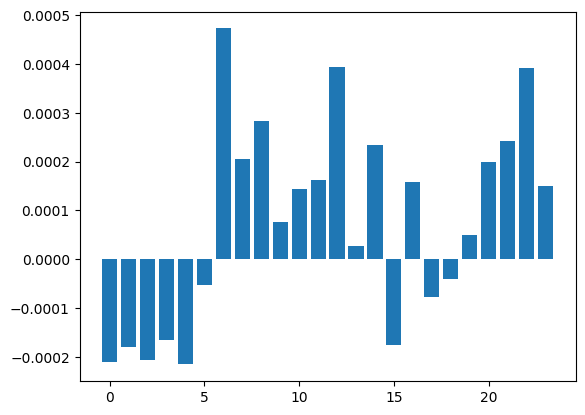

In [16]:
df_hour["Hour"] = df_hour["Open time"].dt.hour
tmp = df_hour.groupby("Hour")["pct"].mean()
plt.bar(x=tmp.index, height=tmp)

In [17]:
# Calendar Effects:
df_hour["Is_AfterHour"] = df_hour["Open time"].dt.hour >= 22
df_hour["Is_Monday"] = df_hour["Open time"].dt.day_of_week == 0
dt_indicators.extend([f'Is_AfterHour', f'Is_Monday'])

In [18]:
#berechnet performance für das gewollte Zeitfenster
def create_labels(df: pd.DataFrame, window: int):
    data = df.copy()
    data["future_return"] = data["Close"].shift(-window) / data["Close"] - 1
    data["label"] = (data["future_return"] > TRANSACTION_COSTS*2).astype(int)
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

In [19]:
from sklearn import tree
def train_model(data: pd.DataFrame, features: list, target: str, param_grid, estimator):
    # Indizes zurücksetzen, um Probleme mit der Indizierung zu vermeiden
    data = data.reset_index(drop=True)
    
    # Aufteilen der Daten in Trainings- und Testdaten
    train_size = int(len(data) * 0.8)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    X_train = train_data[features].dropna()
    X_test = test_data[features]
    y_train = train_data[target]
    
    # Definiere den Precision-Scorer
    precision_scorer = make_scorer(precision_score, pos_label=1)
    
    # Initialisiere den GridSearchCV
    grid_search = GridSearchCV(estimator=estimator,
                               param_grid=param_grid,
                                cv=4,  # Anzahl der Cross-Validation-Folds
                                scoring=precision_scorer,  # Bewertungskriterium
                                n_jobs=-1,  # Nutze alle verfügbaren CPU-Kerne
                                verbose=2)  # Ausgabe von Fortschrittsinformationen

     # Führe GridSearch aus
    grid_search.fit(X_train, y_train)
    
    # Ausgabe der besten Parameter
    print("Beste Parameter:", grid_search.best_params_)
    
    # Modell mit den besten Parametern
    best_clf = grid_search.best_estimator_
    return best_clf, X_test, X_train
    
def make_signals(pred: pd.Series, holding_period: int):
    np_pred = pred
    for i in reversed(range(len(np_pred))):
        if np_pred[i] == 1:
            np_pred[i:i+holding_period] = 1
    np_pred = np_pred
    return np_pred 
    
def evaluate_model(X_test, best_clf, data, signal_threshold, holding_period, plot=True):
    # Vorhersagen auf Testdaten
    #y_pred = best_clf.predict(X_test)
    
    #best_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
    #best_clf.fit(X_train, y_train)
    
    # TODO print out sharpe ratio in training data set
    # y_pred_proba = best_clf.predict_proba(X_train)
    # y_pred = (y_pred_proba[:, 1] > signal_threshold).astype(int)
    # y_pred = make_signals(y_pred, holding_period)
    # print(f"Sharpe Strategy (Train): {sharpe}")

    # Get the predicted probabilities
    y_pred_proba = best_clf.predict_proba(X_test)
    y_pred = (y_pred_proba[:, 1] > signal_threshold).astype(int)
    y_pred = make_signals(y_pred, holding_period)
    
    # Berechne die Sharpe Ratio
    test_returns = data.loc[X_test.index, "pct"]
    print(f'Sharpe BTC {sharpe_ratio(test_returns)}')

    strat_returns = test_returns.copy()
    strat_returns[y_pred == 0] = 0

    # Calculate transaction costs: a cost occurs whenever there is a change in the position (buy/sell)
    positions = np.diff(np.concatenate([[0], y_pred]))  # Calculate position changes
    transaction_costs = np.abs(positions) * TRANSACTION_COSTS  # Apply transaction costs

    sharpe = sharpe_ratio(strat_returns)
    print(f"Sharpe Ratio without costs: {sharpe}")
    strat_returns -= transaction_costs  # Deduct transaction costs from strategy returns

    print(f"number of transactions {np.sum(np.abs(positions))}")

    sharpe = sharpe_ratio(strat_returns)
    print(f"Sharpe Ratio with costs: {sharpe}")
    
    # Performance DataFrame erstellen
    if plot:
        # Performance DataFrame erstellen
        PF = pd.DataFrame(data["pct"].iloc[X_test.index])
        PF["pred"] = y_pred
        PF["strategy_returns"] = PF["pred"] * PF["pct"]
        PF["cumulative_strategy_returns"] = (PF["strategy_returns"] + 1).cumprod()

        PF["benchmark_returns"] = PF["pct"]
        PF["cumulative_benchmark_returns"] = (PF["benchmark_returns"] + 1).cumprod()

        # Calculate transaction indices
        transaction_indices = np.where(np.abs(positions) > 0)[0]

        # Adjust transaction_indices to match PF index
        transaction_indices = transaction_indices[transaction_indices < len(PF)]

        # Plot results
        plt.figure(figsize=(14, 7))
        plt.plot(PF["cumulative_strategy_returns"], label="Strategy Returns")
        plt.plot(PF["cumulative_benchmark_returns"], label="Benchmark Returns")

        # Add dots where transactions occur
        plt.scatter(PF.index[transaction_indices], 
                    PF["cumulative_strategy_returns"].iloc[transaction_indices],
                    color='red', 
                    marker='o', 
                    label='Transactions')

        plt.title("Cumulative Returns with Transactions")
        plt.xlabel("Time")
        plt.ylabel("Cumulative Returns")
        plt.legend()
        plt.show()
    
    return sharpe

In [20]:
def find_best_indicators(data: pd.DataFrame, indicators: list, target: str, holding_period, signal_threshold, plot=True):
    best_sharpe = -np.inf
    best_combination = None
    best_model = None

    # Definiere den Parameterbereich für GridSearch
    param_grid = {
        #'criterion': ['gini', 'entropy'],
        #'max_depth': [2, 3, 4],
        #'min_samples_split': [2, 5, 10],
        #'min_samples_leaf': [5, 10, 20, 30],
        #'max_features': ['sqrt']
    }

    models = []
    train_sharpe_ratios = []
    test_sharpe_ratios = []
    combos = []
    for r in [3, 4]:
        for combo in combinations(indicators, r):
            if len(train_sharpe_ratios) > 100: 
                break
            print(combo)
            features = list(combo)
            clf, X_test, X_train = train_model(data, features, target, param_grid=param_grid, estimator=XGBClassifier(random_state=42))
            
            train_sharpe = evaluate_model(X_train, clf, signal_threshold=signal_threshold, holding_period=holding_period, data=data, plot=plot)
            test_sharpe = evaluate_model(X_test, clf, signal_threshold=signal_threshold, holding_period=holding_period, data=data, plot=plot)

            train_sharpe_ratios.append(train_sharpe)
            test_sharpe_ratios.append(test_sharpe)
            models.append(clf)
            combos.append(features)
            
            if test_sharpe > best_sharpe:
                best_sharpe = test_sharpe
                best_combination = combo
                best_model = clf

    print(f"Best Sharpe Ratio: {best_sharpe}")
    print(f"Best Indicator Combination: {best_combination}")

    return best_model, best_combination, best_sharpe, train_sharpe_ratios, test_sharpe_ratios, models, combos

# Finding optimal holding period

In [21]:
qs = []
windows = [1, 5, 12, 24, 32, 48, 96, 7*24]
for holding_window in windows:

    # Labels erstellen
    labeled_data = create_labels(df_hour, window=holding_window)

    #dt_indicators.extend([f'EMA_{5}', f'EMA_{50}', f'EMA_{500}'])
    # Liste der Indikatoren
    #["SMA_50_Sig", "SMA_500_Sig", "HMA_50_Sig", "EMA_50_Sig", "EMA_500_Sig", "EMA_5_Sig"]#["OBV", "RSI_5", "RSI_10"]#, "RSI_50", "RSI_50", "MACD", "MACD_Signal", "Momentum_10", "StochRSI_10", "StochRSI_20", "StochRSI_50"]
    features = dt_indicators

    # Beste Indikatoren finden
    best_model, best_combination, best_sharpe, train_sharpe_ratios, test_sharpe_ratios, models, combos = find_best_indicators(labeled_data, 
                                                                                                                            features, 
                                                                                                                            holding_period=holding_window, 
                                                                                                                            target="label", 
                                                                                                                            signal_threshold=0.55,
                                                                                                                            plot=False)
    res = pd.DataFrame.from_dict({"test":test_sharpe_ratios, 
                                "train":train_sharpe_ratios})
    q = res["test"].quantile(0.8)
    qs.append(q)

('OBV', 'MACD', 'RSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007499
Sharpe BTC 0.005135081758944544
mean=0.000488, std=0.003303
Sharpe Ratio without costs: 0.1479000528116329
number of transactions 4074
mean=0.000424, std=0.003266
Sharpe Ratio with costs: 0.1297292361347745
mean=0.000094, std=0.005510
Sharpe BTC 0.01698343910646762
mean=0.000027, std=0.002138
Sharpe Ratio without costs: 0.012450853087765237
number of transactions 678
mean=-0.000017, std=0.002141
Sharpe Ratio with costs: -0.0077648793372690995
('OBV', 'MACD', 'SMA_24_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007499
Sharpe BTC 0.005135081758944544
mean=0.000383, std=0.003180
Sharpe Ratio without costs: 0.12030095972303693
number of transactions 3414
mean=0.000328, std=0.003151
Sharpe Ratio with costs: 0.10416532029574561
mean=0.000094, std=0.005510
Sharpe BTC 0.01698343910646762
mean=0.000016, 

C:\Users\Adria\AppData\Local\Temp\ipykernel_21404\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007499
Sharpe BTC 0.005135081758944544
mean=0.000073, std=0.002073
Sharpe Ratio without costs: 0.03535952984196935
number of transactions 1320
mean=0.000052, std=0.002064
Sharpe Ratio with costs: 0.02532491088894083
mean=0.000094, std=0.005510
Sharpe BTC 0.01698343910646762
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'SMA_24_Sig', 'HMA_168_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_21404\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007499
Sharpe BTC 0.005135081758944544
mean=0.000056, std=0.002164
Sharpe Ratio without costs: 0.02570094886151935
number of transactions 1278
mean=0.000035, std=0.002159
Sharpe Ratio with costs: 0.016323633637555693
mean=0.000094, std=0.005510
Sharpe BTC 0.01698343910646762
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'SMA_24_Sig', 'Momentum_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_21404\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007499
Sharpe BTC 0.005135081758944544
mean=0.000384, std=0.003257
Sharpe Ratio without costs: 0.11784012280675621
number of transactions 3336
mean=0.000331, std=0.003231
Sharpe Ratio with costs: 0.10236284973506396
mean=0.000094, std=0.005510
Sharpe BTC 0.01698343910646762
mean=0.000026, std=0.001821
Sharpe Ratio without costs: 0.014158156690864841
number of transactions 390
mean=0.000001, std=0.001825
Sharpe Ratio with costs: 0.0004961126917417009
('OBV', 'SMA_24_Sig', 'StochRSI_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007499
Sharpe BTC 0.005135081758944544
mean=0.000329, std=0.002677
Sharpe Ratio without costs: 0.12275406280217593
number of transactions 4076
mean=0.000264, std=0.002643
Sharpe Ratio with costs: 0.09976836116470435
mean=0.000094, std=0.005510
Sharpe BTC 0.01698343910646762
mean=0.000014, std=0.001633
Sharpe Ratio without costs: 0.008815617106549116
number of trans

C:\Users\Adria\AppData\Local\Temp\ipykernel_21404\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007499
Sharpe BTC 0.005135081758944544
mean=0.000067, std=0.001717
Sharpe Ratio without costs: 0.039238266107237636
number of transactions 1266
mean=0.000047, std=0.001708
Sharpe Ratio with costs: 0.0276144193561319
mean=0.000094, std=0.005510
Sharpe BTC 0.01698343910646762
mean=0.000000, std=0.000000
Sharpe Ratio without costs: 0.011294569126194953
number of transactions 2
mean=-0.000000, std=0.000008
Sharpe Ratio with costs: -0.015958878268842038
('OBV', 'EMA_24_Sig', 'Momentum_168')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007499
Sharpe BTC 0.005135081758944544
mean=0.000384, std=0.003251
Sharpe Ratio without costs: 0.11826079242526463
number of transactions 3542
mean=0.000328, std=0.003223
Sharpe Ratio with costs: 0.10178242604687075
mean=0.000094, std=0.005510
Sharpe BTC 0.01698343910646762
mean=0.000025, std=0.002050
Sharpe Ratio without costs: 0.012158705849887284
number of transa

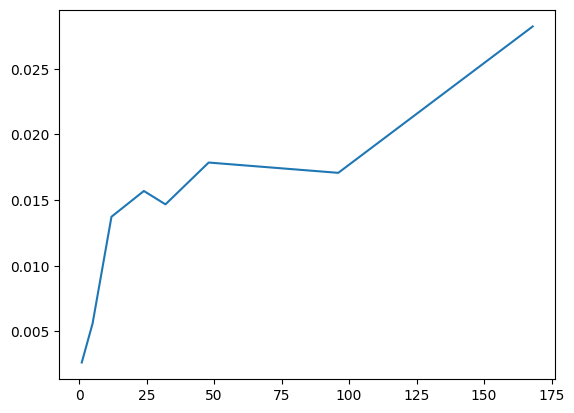

In [22]:
plt.plot(windows, qs)

In [23]:
HOLDING_WINDOW = 175

In [24]:
# Labels erstellen
labeled_data = create_labels(df_hour, window=HOLDING_WINDOW)

#dt_indicators.extend([f'EMA_{5}', f'EMA_{50}', f'EMA_{500}'])
# Liste der Indikatoren
#["SMA_50_Sig", "SMA_500_Sig", "HMA_50_Sig", "EMA_50_Sig", "EMA_500_Sig", "EMA_5_Sig"]#["OBV", "RSI_5", "RSI_10"]#, "RSI_50", "RSI_50", "MACD", "MACD_Signal", "Momentum_10", "StochRSI_10", "StochRSI_20", "StochRSI_50"]
features = dt_indicators

# Beste Indikatoren finden
best_model, best_combination, best_sharpe, train_sharpe_ratios, test_sharpe_ratios, models, combos = find_best_indicators(labeled_data, 
                                                                                                                        features, 
                                                                                                                        holding_period=HOLDING_WINDOW, 
                                                                                                                        target="label", 
                                                                                                                        signal_threshold=0.55,
                                                                                                                        plot=False)

('OBV', 'MACD', 'RSI_24')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007511
Sharpe BTC 0.004884769600797403
mean=0.000048, std=0.007474
Sharpe Ratio without costs: 0.006355338993669397
number of transactions 9
mean=0.000047, std=0.007474
Sharpe Ratio with costs: 0.006336079266298638
mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919967
mean=0.000145, std=0.004915
Sharpe Ratio without costs: 0.029593872468846514
number of transactions 19
mean=0.000144, std=0.004915
Sharpe Ratio with costs: 0.029347745843773462
('OBV', 'MACD', 'SMA_24_Sig')
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007511
Sharpe BTC 0.004884769600797403
mean=0.000048, std=0.007469
Sharpe Ratio without costs: 0.006406152972756355
number of transactions 15
mean=0.000048, std=0.007470
Sharpe Ratio with costs: 0.006373193912444608
mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919967
mean=0.000126, s

In [25]:
res = pd.DataFrame.from_dict({"test":test_sharpe_ratios, 
                              "train":train_sharpe_ratios})
q = res["test"].quantile(0.8)

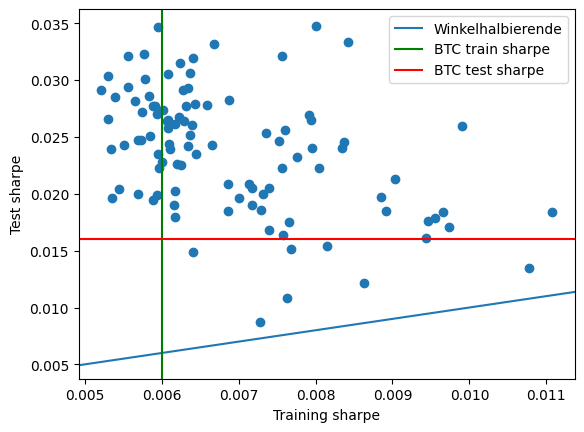

In [26]:
fig, ax = plt.subplots()

ax.scatter(train_sharpe_ratios, test_sharpe_ratios)
ax.axline((min(train_sharpe_ratios), min(train_sharpe_ratios)), slope=1, label="Winkelhalbierende")

train_btc_sharpe=0.006
test_btc_sharpe=0.016  
plt.axvline(x=train_btc_sharpe, color='g', linestyle='-', label="BTC train sharpe")
plt.axhline(y=test_btc_sharpe, color='r', linestyle='-', label="BTC test sharpe")

ax.set_xlabel("Training sharpe")
ax.set_ylabel("Test sharpe")
ax.legend()

In [74]:
# Indices which have above average training and test sharpe ratios
interesting_indices = [idx for idx, val in enumerate(test_sharpe_ratios) if val > test_btc_sharpe and train_sharpe_ratios[idx] > train_btc_sharpe]
res["model_score"] = np.abs(res["test"] - test_btc_sharpe + res["train"] - train_btc_sharpe)
res.iloc[interesting_indices].sort_values("model_score", ascending=True)[:20]

,test,train,model_score
61,0.016403,0.007575,0.001978
44,0.017941,0.006176,0.002117
83,0.016841,0.007391,0.002232
87,0.017494,0.007652,0.003146
26,0.019048,0.006153,0.003201
32,0.018452,0.006866,0.003318
66,0.016149,0.009439,0.003587
99,0.018538,0.007294,0.003833
45,0.019052,0.007177,0.004229
29,0.020227,0.006172,0.004399


# Select model

In [77]:
################################################
idx=61
print(combos[idx])
THRESHOLD = 0.55
#################################################

['OBV', 'EMA_24_Sig', 'SMA_168_Sig']


In [78]:
models[idx]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007511
Sharpe BTC 0.004884769600797403
mean=0.000056, std=0.007374
Sharpe Ratio without costs: 0.007620468187117538
number of transactions 21
mean=0.000056, std=0.007374
Sharpe Ratio with costs: 0.007574890332520946


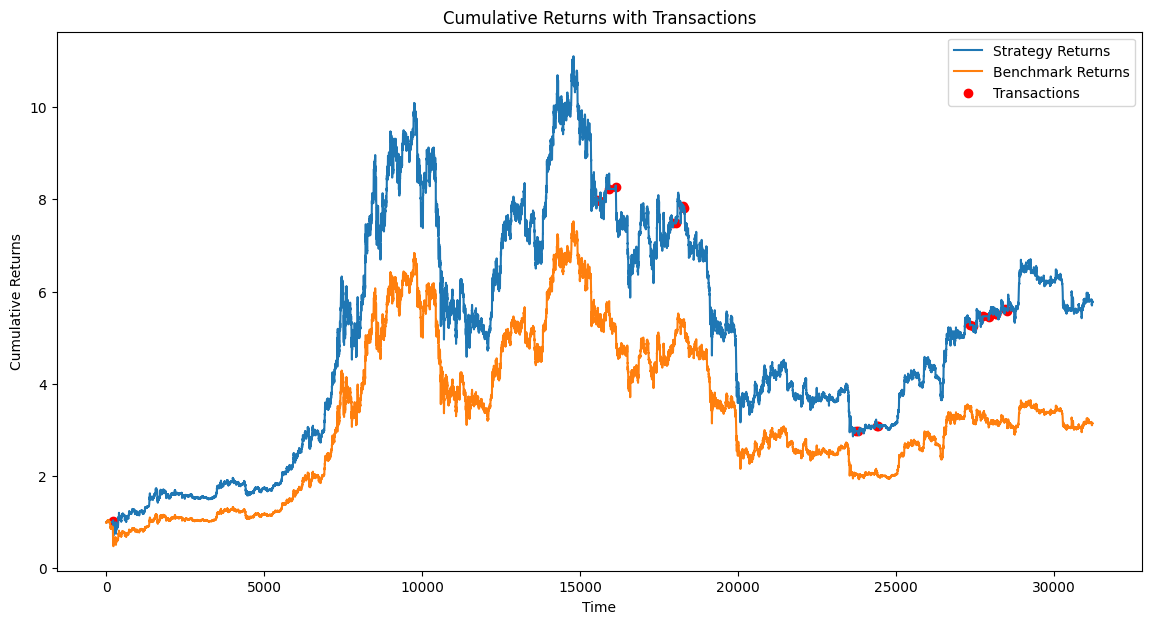

mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919967
mean=0.000044, std=0.002636
Sharpe Ratio without costs: 0.016745825999316455
number of transactions 14
mean=0.000043, std=0.002636
Sharpe Ratio with costs: 0.016403152963126062


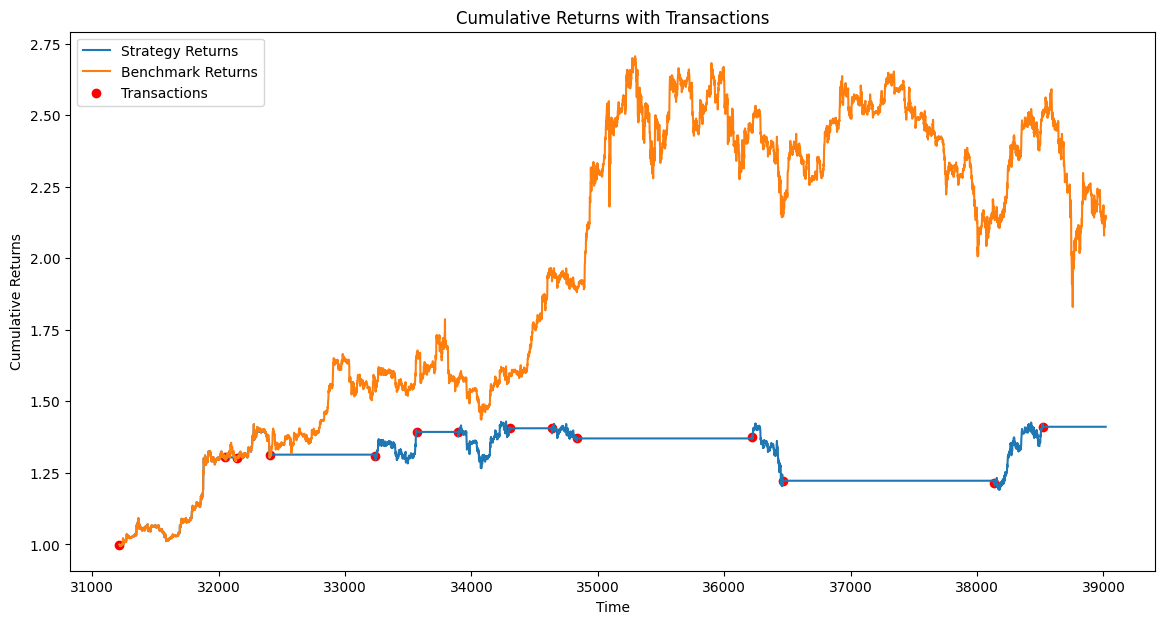

np.float64(0.016403152963126062)

In [79]:
_, X_test, X_train = train_model(data=labeled_data, features=combos[idx], target="label", param_grid={}, estimator=DecisionTreeClassifier(random_state=42))

evaluate_model(X_train, models[idx], data=labeled_data, signal_threshold=THRESHOLD, holding_period=HOLDING_WINDOW, plot=True)
evaluate_model(X_test, models[idx], data=labeled_data, signal_threshold=THRESHOLD, holding_period=HOLDING_WINDOW, plot=True)

# Single Model Analysis

In [82]:
################################# HIER 
clf = models[idx]
th = 0.55
sharpe = evaluate_model(X_train, clf, data=labeled_data, signal_threshold=th, holding_period=HOLDING_WINDOW, plot=False)
################################### HIER MODELL INDEX 

mean=0.000037, std=0.007511
Sharpe BTC 0.004884769600797403
mean=0.000056, std=0.007374
Sharpe Ratio without costs: 0.007620468187117538
number of transactions 21
mean=0.000056, std=0.007374
Sharpe Ratio with costs: 0.007574890332520946


In [70]:
sharpe = evaluate_model(X_test, clf, data=labeled_data, signal_threshold=th, holding_period=HOLDING_WINDOW, plot=False)

mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919967
mean=0.000077, std=0.005019
Sharpe Ratio without costs: 0.01541725770149848
number of transactions 19
mean=0.000076, std=0.005019
Sharpe Ratio with costs: 0.015172642211908585


In [71]:
from functools import partial

plot_func = partial(evaluate_model, X_test=X_test, best_clf=clf, data=labeled_data, holding_period=HOLDING_WINDOW, plot=False)
xs = np.arange(0.5, 1, 0.05)
ys = np.ndarray(shape=len(xs))
for i in range(len(xs)):
     ys[i] = plot_func(signal_threshold=xs[i])

mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919967
mean=0.000077, std=0.005019
Sharpe Ratio without costs: 0.01541725770149848
number of transactions 19
mean=0.000076, std=0.005019
Sharpe Ratio with costs: 0.015172642211908585
mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919967
mean=0.000082, std=0.004981
Sharpe Ratio without costs: 0.01642117531509144
number of transactions 21
mean=0.000080, std=0.004982
Sharpe Ratio with costs: 0.016148721223985682
mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919967
mean=0.000072, std=0.004792
Sharpe Ratio without costs: 0.014984447697913374
number of transactions 23
mean=0.000070, std=0.004792
Sharpe Ratio with costs: 0.01467530597345384
mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919967
mean=0.000066, std=0.004530
Sharpe Ratio without costs: 0.014591841719250424
number of transactions 17
mean=0.000065, std=0.004530
Sharpe Ratio with costs: 0.014349621238881054
mean=0.000098, std=0.005495
Sharpe BTC 0.01782831494691

Text(0, 0.5, 'sharpe')

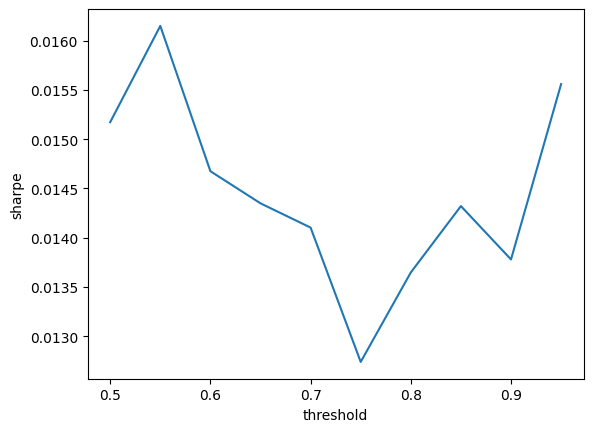

In [72]:
plt.plot(xs, ys)
plt.xlabel("threshold")
plt.ylabel("sharpe")

In [58]:
clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [50]:
import pickle 
import base64

# Serialize an object into a plain text
def obj_to_txt(obj):
    message_bytes = pickle.dumps(obj)
    base64_bytes = base64.b64encode(message_bytes)
    txt = base64_bytes.decode('ascii')
    return txt

# De-serialize an object from a plain text
def txt_to_obj(txt):
    base64_bytes = txt.encode('ascii')
    message_bytes = base64.b64decode(base64_bytes)
    obj = pickle.loads(message_bytes)
    return obj

In [83]:
txt = obj_to_txt(clf)

obj = txt_to_obj(txt)

In [98]:
txt

'gASVLAMAAAAAAACMD3hnYm9vc3Quc2tsZWFybpSMDVhHQkNsYXNzaWZpZXKUk5QpgZR9lCiMDG5fZXN0aW1hdG9yc5ROjAlvYmplY3RpdmWUjA9iaW5hcnk6bG9naXN0aWOUjAltYXhfZGVwdGiUTowKbWF4X2xlYXZlc5ROjAdtYXhfYmlulE6MC2dyb3dfcG9saWN5lE6MDWxlYXJuaW5nX3JhdGWUTowJdmVyYm9zaXR5lE6MB2Jvb3N0ZXKUTowLdHJlZV9tZXRob2SUTowFZ2FtbWGUTowQbWluX2NoaWxkX3dlaWdodJROjA5tYXhfZGVsdGFfc3RlcJROjAlzdWJzYW1wbGWUTowPc2FtcGxpbmdfbWV0aG9klE6MEGNvbHNhbXBsZV9ieXRyZWWUTowRY29sc2FtcGxlX2J5bGV2ZWyUTowQY29sc2FtcGxlX2J5bm9kZZROjAlyZWdfYWxwaGGUTowKcmVnX2xhbWJkYZROjBBzY2FsZV9wb3Nfd2VpZ2h0lE6MCmJhc2Vfc2NvcmWUTowHbWlzc2luZ5RHf/gAAAAAAACMEW51bV9wYXJhbGxlbF90cmVllE6MDHJhbmRvbV9zdGF0ZZRLKowGbl9qb2JzlE6MFG1vbm90b25lX2NvbnN0cmFpbnRzlE6MF2ludGVyYWN0aW9uX2NvbnN0cmFpbnRzlE6MD2ltcG9ydGFuY2VfdHlwZZROjAZkZXZpY2WUTowTdmFsaWRhdGVfcGFyYW1ldGVyc5ROjBJlbmFibGVfY2F0ZWdvcmljYWyUiYwNZmVhdHVyZV90eXBlc5ROjBFtYXhfY2F0X3RvX29uZWhvdJROjBFtYXhfY2F0X3RocmVzaG9sZJROjA5tdWx0aV9zdHJhdGVneZROjAtldmFsX21ldHJpY5ROjBVlYXJseV9zdG9wcGluZ19yb3VuZHOUTowJY2FsbGJhY2tzlE6MCm5fY2xhc3Nlc1+USwKMCF9

mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919967
mean=0.000130, std=0.004607
Sharpe Ratio without costs: 0.02828174056517683
number of transactions 21
mean=0.000129, std=0.004607
Sharpe Ratio with costs: 0.027989779222297843
mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919967
mean=0.000124, std=0.003684
Sharpe Ratio without costs: 0.03369529196423988
number of transactions 21
mean=0.000123, std=0.003685
Sharpe Ratio with costs: 0.03331923701757554
mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919967
mean=0.000085, std=0.003113
Sharpe Ratio without costs: 0.027177318753089662
number of transactions 19
mean=0.000083, std=0.003114
Sharpe Ratio with costs: 0.026774245052758765
mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919967
mean=0.000083, std=0.003098
Sharpe Ratio without costs: 0.02678631994003383
number of transactions 21
mean=0.000082, std=0.003099
Sharpe Ratio with costs: 0.026342804430834393
mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919

C:\Users\Adria\AppData\Local\Temp\ipykernel_21404\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Text(0, 0.5, 'sharpe')

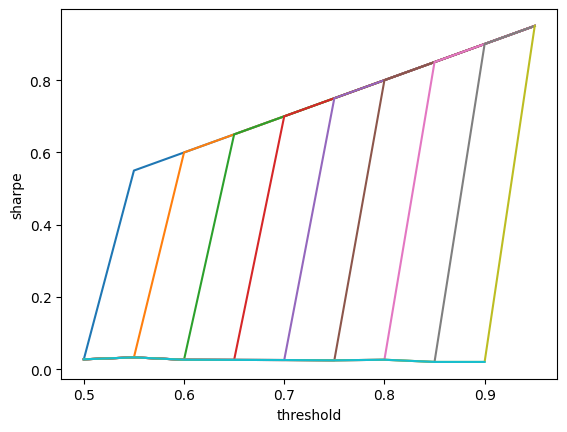

In [54]:
plot_func = partial(evaluate_model, X_test=X_test, best_clf=obj, data=labeled_data, holding_period=HOLDING_WINDOW, plot=False)
xs = np.arange(0.5, 1, 0.05)
ys = np.ndarray(shape=len(xs))
for i in range(len(xs)):
     ys[i] = plot_func(signal_threshold=xs[i])
     plt.plot(xs, ys)
plt.xlabel("threshold")
plt.ylabel("sharpe")